In [13]:
pip install imblearn


  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [1]:
#import libraries

import os
import glob
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from radiant_mlhub import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

D:\anacon\envs\py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DOWNLOAD DATA FROM MLHUB

In [2]:
#For simplicity we select 4 out 12 bands for the this baseline model

full_bands = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

# selected_bands = Full_bands[1:4]  + [Full_bands[-5]]  #'B02', 'B03', 'B04', 'B08'
# selected_bands

In [3]:
#define dataset collection_id , assets and necessary paths to collections

main = 'ref_agrifieldnet_competition_v1'

assets = ['field_ids','raster_labels']

source_collection = f'{main}_source'
train_label_collection = f'{main}_labels_train'
test_label_collection = f'{main}_labels_test'

In [4]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset

os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

dataset = Dataset.fetch(main)

my_filter = dict(
    ref_agrifieldnet_competition_v1_labels_train=assets,

    ref_agrifieldnet_competition_v1_labels_test=[assets[0]],

    ref_agrifieldnet_competition_v1_source=full_bands 
)

dataset.download(collection_filter=my_filter)

MLHub API Key: ········


unarchive ref_agrifieldnet_competition_v1.tar.gz: 100%|█| 6186/6186 [00:43<00:0
filter by collection ids and asset keys: 231716it [00:00, 521006.08it/s]       
download assets: 100%|███████████████████| 17641/17641 [45:06<00:00,  6.52it/s]


## Prepare Train data

- Load collection.json in labels_train collection's path and retrieve all unique folder ids into a list.
- Use unique folder ids to create a list of field.tif and raster_labels.tif paths for all tiles.
- Create competition_train_data dataframe for folder_ids and field_paths
- Create field_crop_pair dataframe using field_crop_extractor.
- Create train_data dataframe using the feature_extractor with argsss (competition_train_data, source_collection)
- Group processed dataset by fields and find the pixel average of across the entire field 
- Merge train_data dataframe and field_crop_pair dataframe on field_id
- Split train_df dataframe for model training and evaluation 

In [5]:
#load collection json and retrieve all unique folder ids 
#use all unique folder ids to create a list of field and label paths for all tiles

with open (f'{main}/{train_label_collection}/collection.json') as f:
    train_json = json.load(f)
    
train_folder_ids = [i['href'].split('_')[-1].split('.')[0] for i in train_json['links'][4:]]

train_field_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' for i in train_folder_ids]
train_label_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' for i in train_folder_ids]

In [6]:
#create dataset for folder_ids and field_paths

competition_train_data = pd.DataFrame(train_folder_ids, columns=['unique_folder_id'])
competition_train_data['field_paths'] = train_field_paths
competition_train_data.head()

,unique_folder_id,field_paths
0,28852,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1,d987c,ref_agrifieldnet_competition_v1/ref_agrifieldn...
2,ca1d4,ref_agrifieldnet_competition_v1/ref_agrifieldn...
3,2ec18,ref_agrifieldnet_competition_v1/ref_agrifieldn...
4,7575d,ref_agrifieldnet_competition_v1/ref_agrifieldn...


In [7]:
# PREPROCESS FIELDS AND CROPS IN TILES FOR TRAININIG

In [8]:
#Extract field_crop Pairs 

def field_crop_extractor(crop_field_files):
    field_crops = {}

    for label_field_file in tqdm(crop_field_files):
        with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/field_ids.tif') as src:
            field_data = src.read()[0]
        with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/raster_labels.tif') as src:
            crop_data = src.read()[0]
    
        for x in range(0, crop_data.shape[0]):
            for y in range(0, crop_data.shape[1]):
                field_id = str(field_data[x][y])
                field_crop = crop_data[x][y]

                if field_crops.get(field_id) is None:
                    field_crops[field_id] = []

                if field_crop not in field_crops[field_id]:
                    field_crops[field_id].append(field_crop)
    
    field_crop_map  =[[k, v[0]]  for k, v in field_crops.items() ]
    field_crop = pd.DataFrame(field_crop_map , columns=['field_id','crop_id'])

    return field_crop[field_crop['field_id']!='0']

In [9]:
field_crop_pair = field_crop_extractor(train_folder_ids)
field_crop_pair.head()

100%|██████████████████████████████████████| 1165/1165 [16:17<00:00,  1.19it/s]


,field_id,crop_id
1,757,6
2,756,6
3,1372,5
4,1374,1
5,1986,4


In [10]:
field_crop_pair.shape

(5551, 2)

In [11]:
field_crop_pair.to_csv('field_crop_pair.csv')

In [54]:
field_crop_pair = pd.read_csv('field_crop_pair.csv')

In [12]:
# Our goal is developing a pixel-based Random Forest model. So we will create an X variable
# such that, each row is a pixel and each column is one of the band observations mapped to its corresponding field. 


img_sh = 256
n_selected_bands= len(full_bands)

n_obs = 1  #imagery per chip(no time series)

def feature_extractor(data_ ,   path ):
    '''
        data_: Dataframe with 'field_paths' and 'unique_folder_id' columns
        path: Path to source collections files

        returns: pixel dataframe with corresponding field_ids
        '''
    
    X = np.empty((0, n_selected_bands * n_obs))
    X_tile = np.empty((img_sh * img_sh, 0))
    X_arrays = []
        
    field_ids = np.empty((0, 1))

    for idx, tile_id in tqdm(enumerate(data_['unique_folder_id'])):
        
        field_src =   rasterio.open( data_['field_paths'].values[idx])
        field_array = field_src.read(1)
        field_ids = np.append(field_ids, field_array.flatten())
        
        
        bands_src = [rasterio.open(f'{main}/{path}/{path}_{tile_id}/{band}.tif') for band in full_bands]
        bands_array = [np.expand_dims(band.read(1).flatten(), axis=1) for band in bands_src]
        
        X_tile = np.hstack(bands_array)

        X_arrays.append(X_tile)
        

    X = np.concatenate(X_arrays)
    
    data = pd.DataFrame(X, columns=full_bands)

    data['field_id'] = field_ids

    return data[data['field_id']!=0]

In [13]:
train_data = feature_extractor(competition_train_data, source_collection)

1165it [21:08,  1.09s/it]


In [14]:
train_data.head(5)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
11031,43,39,38,38,41,54,63,61,64,12,57,37,757.0
11287,43,39,38,38,42,57,67,63,72,12,63,42,757.0
11288,43,39,38,37,41,59,69,65,78,12,68,43,757.0
11289,43,38,37,36,41,59,69,64,78,12,68,43,757.0
11543,43,39,38,38,42,57,67,64,72,12,63,42,757.0


In [15]:
train_data.shape

(188228, 13)

In [16]:
train_data.to_csv('train_data.csv')

In [55]:
train_data = pd.read_csv('train_data.csv')

In [46]:
# train_data.field_id = [str(int(i)) for i in train_data.field_id.values]

In [47]:
# # merge pixel dataframe to field_crop_pair dataframe

# train_df = pd.merge(train_data, field_crop_pair , on='field_id' )
# train_df.head(10)




,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop_id
0,43,39,38,38,41,54,63,61,64,12,57,37,757,6
1,43,39,38,38,42,57,67,63,72,12,63,42,757,6
2,43,39,38,37,41,59,69,65,78,12,68,43,757,6
3,43,38,37,36,41,59,69,64,78,12,68,43,757,6
4,43,39,38,38,42,57,67,64,72,12,63,42,757,6
5,43,39,39,37,41,59,69,66,78,12,68,43,757,6
6,43,39,39,37,41,59,69,68,78,12,68,43,757,6
7,44,39,39,36,41,59,69,67,78,12,67,43,757,6
8,44,38,38,35,41,59,69,65,78,12,67,43,757,6
9,43,38,37,34,39,59,70,62,76,12,63,39,757,6


In [20]:
# sns.boxplot(x='crop_id',y='B04', data = train_data);

In [ ]:
plt.figure(figsize = (60,60))
sns.pairplot(train_df.drop(['Unnamed: 0', 'field_id'], axis = 1),hue = 'crop_id')

In [13]:
train_df.describe()

,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,BRI,CCCI,GBNDVI,LCI,MACCIONI,NDRE,NGRDI,NDVI2,PVR,SLAVI
count,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,...,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000,188228.000000
mean,94113.500000,43.461122,39.452738,38.907378,42.401221,44.988280,55.510604,63.687937,60.426897,70.171919,...,0.000059,0.855911,-0.129820,0.152983,0.896780,0.173847,-0.069308,-0.085034,-0.036721,0.674699
std,54336.887572,2.920023,3.565797,4.802049,8.261763,7.357721,6.575534,7.818992,7.572427,8.871060,...,0.000051,0.147239,0.064249,0.082286,0.117124,0.076909,0.048434,0.155987,0.055349,0.213691
min,0.000000,29.000000,22.000000,19.000000,16.000000,23.000000,27.000000,30.000000,27.000000,29.000000,...,-0.000134,-0.749235,-0.383178,-0.052083,-10.000000,0.051282,-0.312500,-0.688889,-0.218750,0.432990
25%,47056.750000,42.000000,38.000000,36.000000,37.000000,41.000000,51.000000,59.000000,56.000000,65.000000,...,0.000043,0.763507,-0.172414,0.088235,0.826087,0.113043,-0.097561,-0.117117,-0.073171,0.547826
50%,94113.500000,44.000000,40.000000,39.000000,43.000000,45.000000,56.000000,64.000000,61.000000,71.000000,...,0.000062,0.840708,-0.133758,0.133333,0.888889,0.154639,-0.073171,-0.035971,-0.050505,0.600000
75%,141170.250000,45.000000,42.000000,42.000000,48.000000,50.000000,60.000000,69.000000,65.000000,76.000000,...,0.000080,0.929699,-0.093168,0.193878,0.951220,0.210526,-0.051282,0.009524,-0.012658,0.704545
max,188227.000000,51.000000,52.000000,59.000000,78.000000,79.000000,94.000000,113.000000,106.000000,121.000000,...,0.000414,2.838275,0.226994,0.540323,10.000000,0.522936,0.103448,0.203704,0.163636,2.052632


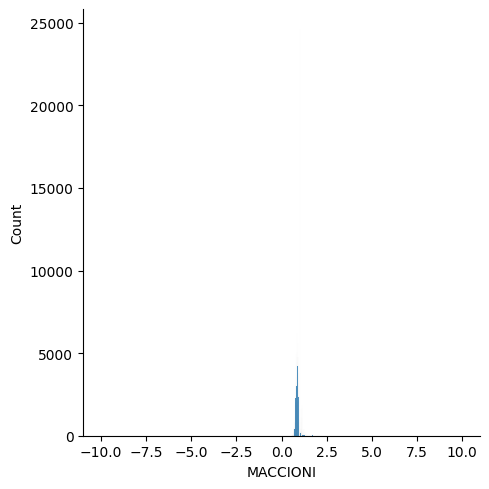

In [14]:
sns.displot(data = train_df, x = 'MACCIONI');

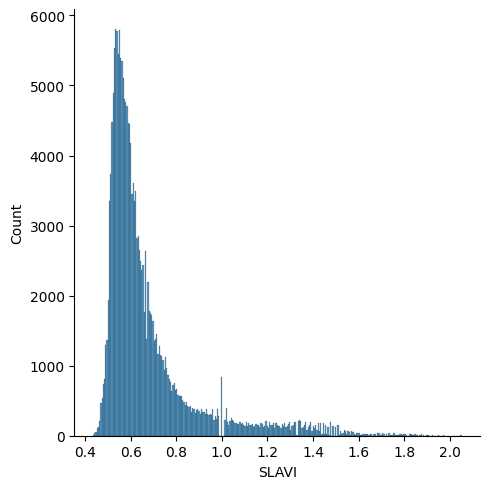

In [15]:
sns.displot(data = train_df, x = 'SLAVI');

In [ ]:
# train_data_grouped.field_id = [str(int(i)) for i in train_data_grouped.field_id.values]

In [52]:
# train_df.to_csv('training_set_raw')

In [3]:
# train_df = pd.read_csv('training_set_raw')

In [56]:
# Each field has several pixels in| the data. Here our goal is to build a Random Forest (RF) model using the average values
# of the pixels within each field. So, we use `groupby` to take the mean for each field_id

train_data_grouped = train_data.groupby(['field_id']).mean().reset_index()
train_data_grouped.field_id = [str(int(i)) for i in train_data_grouped.field_id.values]
train_data_grouped.head()

,field_id,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
0,1,1.913138e+07,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,12.000000,80.277778,61.333333
1,2,6.191975e+07,45.000000,42.000000,42.166667,47.666667,49.250000,59.916667,69.000000,63.916667,76.333333,12.833333,79.916667,56.750000
2,3,6.193000e+07,45.000000,42.687500,43.500000,49.187500,51.437500,62.875000,71.625000,66.625000,79.312500,13.000000,82.125000,58.062500
3,4,2.317440e+07,45.866667,42.466667,43.800000,47.733333,49.466667,59.733333,68.133333,62.600000,73.466667,11.266667,77.600000,55.000000
4,5,2.317156e+07,46.000000,43.238095,45.238095,49.285714,50.904762,60.904762,68.952381,63.380952,74.547619,11.333333,77.452381,55.809524


In [57]:
# merge pixel dataframe to field_crop_pair dataframe
field_crop_pair.field_id = [str(int(i)) for i in field_crop_pair.field_id.values]
train_df = pd.merge(train_data_grouped, field_crop_pair , on='field_id' )
train_df.head(10)

,field_id,Unnamed: 0_x,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,Unnamed: 0_y,crop_id
0,1,1.913138e+07,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,12.000000,80.277778,61.333333,1438,1
1,2,6.191975e+07,45.000000,42.000000,42.166667,47.666667,49.250000,59.916667,69.000000,63.916667,76.333333,12.833333,79.916667,56.750000,4597,1
2,3,6.193000e+07,45.000000,42.687500,43.500000,49.187500,51.437500,62.875000,71.625000,66.625000,79.312500,13.000000,82.125000,58.062500,4598,1
3,4,2.317440e+07,45.866667,42.466667,43.800000,47.733333,49.466667,59.733333,68.133333,62.600000,73.466667,11.266667,77.600000,55.000000,1742,2
4,5,2.317156e+07,46.000000,43.238095,45.238095,49.285714,50.904762,60.904762,68.952381,63.380952,74.547619,11.333333,77.452381,55.809524,1739,2
5,6,2.317643e+07,45.000000,42.833333,44.944444,49.111111,50.555556,60.333333,68.888889,62.888889,74.666667,12.000000,78.777778,57.222222,1745,2
6,7,2.317845e+07,46.000000,43.702703,46.081081,50.891892,51.972973,61.837838,69.621622,63.945946,75.324324,11.945946,80.378378,59.432432,1747,2
7,8,2.318180e+07,44.904762,42.571429,44.476190,49.000000,50.666667,63.142857,72.476190,66.571429,78.952381,12.000000,81.952381,59.761905,1748,2
8,9,2.317265e+07,44.843750,41.562500,42.718750,46.093750,47.875000,58.531250,66.843750,60.750000,72.843750,12.000000,76.000000,56.343750,1740,2
9,10,4.636175e+06,43.421053,38.578947,37.473684,36.894737,41.157895,59.052632,68.578947,65.157895,76.052632,12.105263,66.842105,45.000000,352,1


In [58]:
train_df.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1, inplace = True)

In [59]:
train_df.tail(8)

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,crop_id
5543,7322,45.000000,36.500000,32.250000,26.750000,31.000000,54.000000,67.875000,64.500000,75.000000,13.000000,49.625000,26.750000,4
5544,7323,45.000000,36.000000,31.000000,24.090909,27.818182,56.363636,75.454545,71.090909,82.181818,13.000000,41.909091,20.909091,4
5545,7324,45.000000,36.533333,31.666667,25.333333,29.133333,55.333333,70.800000,67.400000,77.600000,13.866667,43.066667,21.466667,4
5546,7326,46.384615,39.000000,34.576923,30.653846,33.153846,51.076923,62.538462,59.269231,66.846154,12.461538,50.615385,33.923077,9
5547,7327,46.000000,37.851852,32.629630,26.555556,29.296296,51.185185,65.518519,63.925926,70.444444,12.777778,40.740741,21.518519,9
5548,7328,47.000000,40.100000,35.100000,29.650000,31.950000,51.600000,65.050000,60.550000,70.700000,11.000000,39.550000,20.000000,9
5549,7331,46.652174,40.130435,35.130435,30.000000,32.608696,52.347826,66.347826,62.608696,71.521739,11.000000,44.434783,25.217391,9
5550,7332,46.076923,39.653846,35.230769,29.423077,31.846154,49.615385,58.615385,53.346154,60.923077,10.461538,35.538462,18.615385,36


In [60]:
# #Broadband B03ness

# # def creating_features():
    
# # train_df['DVI'] = train_df['B08'] - train_df['B04']
# #train_df['EVI'] = 2.5*((train_df['B08'] - train_df['B04'])/(train_df['B08'] + 6 * train_df['B04'] - 7.5 * train_df['B02'] + 1))
# train_df['GLI'] = ((train_df['B03'] - train_df['B04']) + (train_df['B03'] - train_df['B02'])) / ((2 * train_df['B03']) + train_df['B04'] + train_df['B02'])
# # # train_df['GDVI'] = train_df['B08'] - train_df['B03']
# train_df['GNDVI'] = (train_df['B08'] - train_df['B03'])/(train_df['B08'] + train_df['B03'])
# # train_df['GOSAVI'] = (train_df['B08'] - train_df['B03'])/(train_df['B08'] + train_df['B03'] +0.16)
# # train_df['GRVI'] = (train_df['B08'] / train_df['B03'])
# # train_df['GSAVI'] = 1.5 * ((train_df['B08'] - train_df['B03'])/(train_df['B08'] + train_df['B03'] + 0.5))
# # train_df['IPVI'] = train_df['B08']/(train_df['B08'] + train_df['B04'])
# #train_df['LAI'] = (3.618 * train_df['EVI'] - 0.118)
# # train_df['MLNI'] = ((train_df['B08']**2 - train_df['B04']) * 1.5)/(train_df['B08']**2 + train_df['B04'] + 0.5)
# # train_df['NDVI'] = (train_df['B08'] - train_df['B04'])/(train_df['B08'] + train_df['B04'])
# # train_df['OSAVI'] = (train_df['B08'] - train_df['B04'])/(train_df['B08'] + train_df['B04'] + 0.16)
# # train_df['RDVI'] = (train_df['B08'] - train_df['B04'])/(np.sqrt(train_df['B08'] + train_df['B04']))
# # train_df['SAVI'] = (1.5 * (train_df['B08'] - train_df['B04']))/(train_df['B08'] + train_df['B04'] + 0.5)
# # train_df['SR'] = train_df['B08']/ train_df['B04']
# # train_df['RGR'] = train_df['B04'] / train_df['B03']
# train_df['VARI'] = (train_df['B03'] - train_df['B04'])/(train_df['B03'] + train_df['B04'] - train_df['B02'])

# #narrowband B03ness
# train_df['MCARI'] = ((train_df['B05'] - train_df['B04']) - 0.2 * (train_df['B05'] - train_df['B03'])) * (train_df['B05']/train_df['B04'])
# # train_df['MCARI2'] = (1.5 * ((2.5 * (train_df['B08'] - train_df['B04']) - 1.3 * (train_df['B08'] - train_df['B03']))/(np.sqrt((2 * train_df['B08'] + 1)**2 - (6 * train_df['B08'] - 5 * np.sqrt(train_df['B04']) - 0.5)))))
# # train_df['TVI'] = np.sqrt(train_df['NDVI'] +0.5)
# #train_df['MNDVI'] = (train_df['B08'] - train_df['B04'])/(train_df['B08'] + train_df['B04'] - 2 * train_df['B02'])

# #light use efficiency
# train_df['SIPI'] = (train_df['B08'] - train_df['B02']) / (train_df['B08'] - train_df['B04'])
# # train_df['TCARI'] = 3 * ((train_df['B05'] - train_df['B04']) - 0.2 * (train_df['B05'] - train_df['B03']) * (train_df['B05']/train_df['B04']))
# train_df['NDMI'] =  (train_df['B08'] - train_df['B11'])/(train_df['B08'] + train_df['B11'])

# # train_df['ARI'] = 1/train_df['B03'] - 1/train_df['B05']
# train_df['AFRI2'] = (train_df['B8A'] - 0.5 * train_df['B12'])/(train_df['B8A'] + 0.5 * train_df['B12'])

# # train_df['ARVI2'] = (train_df['B08'] - train_df['B04'])/(train_df['B08'] + train_df['B04'])
# train_df['AVI'] = 2 * train_df['B8A']- train_df['B04']
# train_df['BRI'] =  (1/train_df['B03'] - 1/train_df['B05'])/train_df['B06']
# train_df['CCCI'] = (((train_df['B08'] - train_df['B05'])/(train_df['B08'] + train_df['B05']))/ ((train_df['B08'] - train_df['B04'])/(train_df['B08'] + train_df['B04'])))
# train_df['GBNDVI'] = (train_df['B08'] - (train_df['B03'] + train_df['B02'])) / (train_df['B08'] + (train_df['B03'] + train_df['B02']))
# train_df['LCI'] = (train_df['B08'] - train_df['B05']) / (train_df['B08'] + train_df['B04'])
# train_df['MACCIONI'] = (train_df['B07'] - train_df['B05'])/(train_df['B07'] - train_df['B04'])
# # train_df['NDRE'] = (train_df['B07'] - train_df['B05'])/(train_df['B07'] + train_df['B05'])
# train_df['NGRDI'] = (train_df['B03'] - train_df['B05'])/(train_df['B03'] + train_df['B05'])
# train_df['NDVI2'] = (train_df['B12'] - train_df['B08'])/(train_df['B12'] + train_df['B08'])
# # train_df['PVR'] = ((train_df['B03'] - train_df['B04'])/(train_df['B03'] + train_df['B04']))
# train_df['SLAVI'] = train_df['B08']/(train_df['B04'] + train_df['B12'])



                                                                                                          
                 


In [11]:
from pycaret.classification import *

In [15]:
experiment = setup(train_df.drop('field_id', axis = 1), target = 'crop_id',fix_imbalance = True, fold = 3)

,Description,Value
0,session_id,4906
1,Target,crop_id
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(5551, 29)"
5,Missing Values,False
6,Numeric Features,28
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5918,0.8549,0.2888,0.6192,0.6039,0.4624,0.4630,18.4867
et,Extra Trees Classifier,0.5781,0.8590,0.3074,0.6340,0.6009,0.4542,0.4564,5.2733
rf,Random Forest Classifier,0.5712,0.8562,0.3104,0.6327,0.5959,0.4478,0.4503,9.3700
gbc,Gradient Boosting Classifier,0.5171,0.8447,0.3348,0.6374,0.5608,0.3994,0.4060,213.6067
qda,Quadratic Discriminant Analysis,0.4996,0.8122,0.2719,0.5859,0.5194,0.3653,0.3748,0.2700
dt,Decision Tree Classifier,0.4798,0.6834,0.2573,0.5583,0.5121,0.3393,0.3422,1.0800
knn,K Neighbors Classifier,0.4180,0.7487,0.3163,0.6270,0.4847,0.3092,0.3212,0.8700
dummy,Dummy Classifier,0.3593,0.5000,0.0769,0.1291,0.1900,0.0000,0.0000,0.1900
lda,Linear Discriminant Analysis,0.3385,0.7989,0.3917,0.6691,0.4023,0.2576,0.2798,0.5300
svm,SVM - Linear Kernel,0.3323,0.0000,0.2853,0.5724,0.3794,0.2219,0.2439,5.9400


In [11]:
train_df['crop_id'].value_counts()

1     2031
4     1641
2      990
9      293
6      163
36     129
3      103
13      59
8       48
15      41
5       23
16      16
14      14
Name: crop_id, dtype: int64

In [12]:
train_df.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,crop_id
count,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000,5551.000000
mean,43.551038,39.197783,38.338501,40.963663,44.133547,56.244932,64.907333,61.641481,71.667237,13.611396,73.426054,51.829617,3.868852
std,2.878113,3.486734,4.671453,7.863293,7.088226,5.714856,6.671115,6.284680,7.653518,2.486175,15.690605,13.851583,5.640180
min,29.846995,23.814208,21.147541,19.743169,26.000000,31.285714,34.857143,33.035714,36.428571,7.000000,16.115385,8.846154,1.000000
25%,42.306250,37.250000,35.066964,35.444444,39.800000,52.500000,60.965476,58.250000,67.400000,12.000000,67.961751,46.476673,1.000000
50%,44.000000,39.868421,38.634146,41.500000,44.800000,56.440000,65.225806,62.238095,72.210811,13.000000,76.590909,55.000000,2.000000
75%,45.217029,41.530012,41.685185,46.777530,49.035964,60.181818,69.411765,65.785714,76.875000,15.000000,83.694838,61.041022,4.000000
max,50.000000,49.068966,54.085366,72.382353,73.264706,82.023810,96.416667,90.880952,102.857143,27.431373,108.534247,84.588235,36.000000


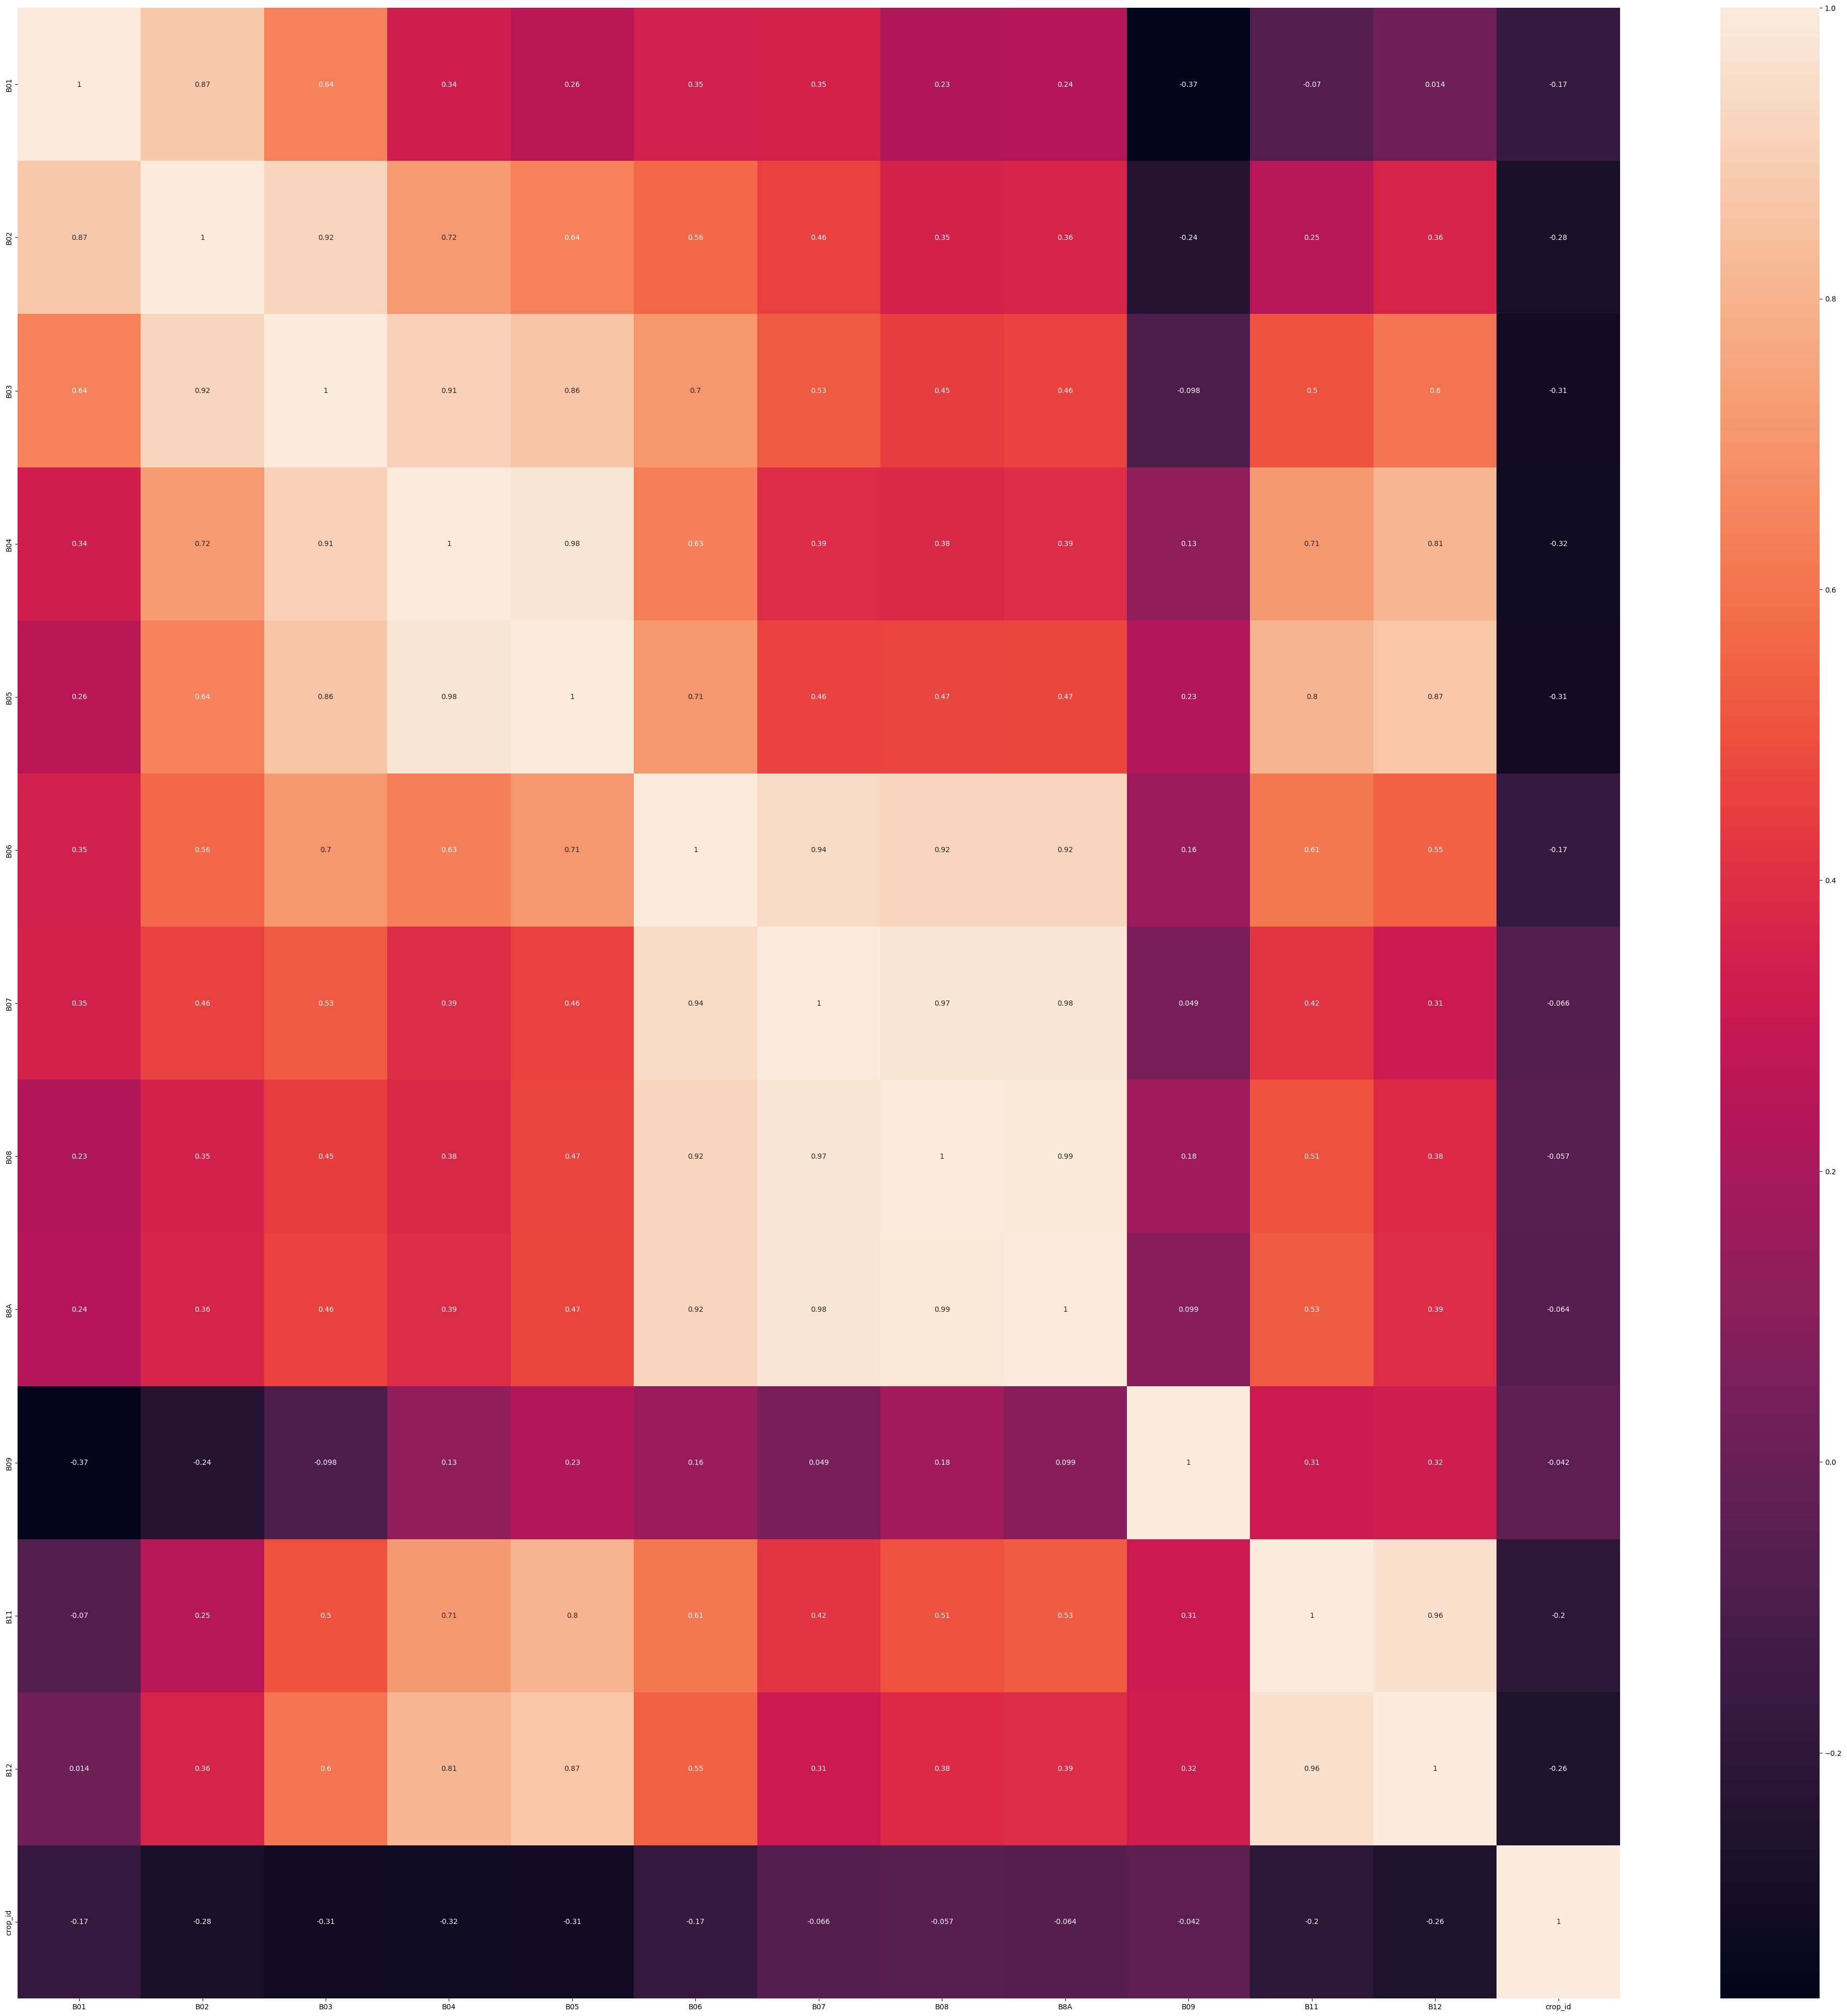

In [168]:
plt.figure(figsize = (50,50))
sns.heatmap(train_df.corr(), annot = True);

In [24]:
train_df.shape

(5551, 44)

In [71]:
train_df.isna().sum()

field_id    0
B01         0
B02         0
B03         0
B04         0
B05         0
B06         0
B07         0
B08         0
B8A         0
B09         0
B11         0
B12         0
crop_id     0
dtype: int64

In [26]:
train_df = train_df.fillna(0)

In [20]:
# train_df.to_csv('traindf.csv')

In [2]:
# train_df = pd.read_csv('traindf.csv')

In [34]:
# crop_names = {1 : 'Wheat' , 2 : 'Mustard' , 3 : 'Lentil' , 4: 'No Crop/Fallow' , 5 : 'Green pea' , 6 : 'Sugarcane', 8 : 'Garlic', 9 : 'Maize' , 13 : 'Gram', 14 : 'Coriander', 15 : 'Potato', 16 : 'Bersem', 36 : 'Rice'}

In [36]:
# train_df['crop_id'] = train_df['crop_id'].map(crop_names)

In [39]:
# from sklearn.preprocessing import LabelEncoder

In [40]:
# le = LabelEncoder()

In [42]:
# train_df['crop_id'] = le.fit_transform(train_df['crop_id'])

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [9]:
sm = SMOTE(random_state = 1)

In [123]:
# train_df.fillna(0, inplace = True)

In [61]:
# split data for model training and evaluation 

X_train, X_test, y_train, y_test =  train_test_split(train_df.drop(['field_id', 'crop_id'], axis=1), train_df['crop_id'] , test_size=0.15, random_state=42 , stratify = train_df['crop_id'])

In [114]:
from sklearn.feature_selection import SelectKBest,chi2

In [123]:
selector = SelectKBest(k = 20)
selector.fit(X_trainsm,y_trainsm)

SelectKBest(k=20)

In [124]:
vector_names = list(X_trainsm.columns[selector.get_support(indices = True)])
print(vector_names)

['B04', 'B05', 'B12', 'DVI', 'MLNI', 'NDVI', 'RDVI', 'SAVI', 'SR', 'RGR', 'VARI', 'MCARI', 'SIPI', 'TCARI', 'NDMI', 'AFRI2', 'LCI', 'NDVI2', 'PVR', 'SLAVI']


In [129]:
X_trainb = X_trainsm[vector_names]
X_testb = X_test[vector_names]

In [147]:
# pip install mlxtend

In [169]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [170]:
feat_sel = SequentialFeatureSelector(rf, k_features = 20,forward = True, verbose =2, scoring = 'accuracy', cv = 3)

In [ ]:
feat_sel.fit(X_trainsm, y_trainsm )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.354921
0:	learn: 2.3507595	total: 119ms	remaining: 23.7s
1:	learn: 2.2828851	total: 222ms	remaining: 22s
2:	learn: 2.2391945	total: 319ms	remaining: 20.9s
3:	learn: 2.2135338	total: 389ms	remaining: 19.1s
4:	learn: 2.1976544	total: 476ms	remaining: 18.6s
5:	learn: 2.1887549	total: 558ms	remaining: 18s
6:	learn: 2.1785062	total: 627ms	remaining: 17.3s
7:	learn: 2.1685366	total: 708ms	remaining: 17s
8:	learn: 2.1624290	total: 785ms	remaining: 16.7s
9:	learn: 2.1581342	total: 849ms	remaining: 16.1s
10:	learn: 2.1542620	total: 920ms	remaining: 15.8s
11:	learn: 2.1497481	total: 993ms	remaining: 15.6s
12:	learn: 2.1428295	total: 1.06s	remaining: 15.3s
13:	learn: 2.1407246	total: 1.21s	remaining: 16.1s
14:	learn: 2.1381264	total: 1.27s	remaining: 15.7s
15:	learn: 2.1366137	total: 1.35s	remaining: 15.5s
16:	learn: 2.1315324	total: 1.42s	remaining: 15.3s
17:	learn: 2.1283285	total: 1.5s	remaining: 15.2s
18:	learn: 2.1268746	total: 1.57s	remaining: 15s
19:	learn: 2.1216401

160:	learn: 2.0313018	total: 12.4s	remaining: 2.99s
161:	learn: 2.0311988	total: 12.4s	remaining: 2.92s
162:	learn: 2.0311184	total: 12.5s	remaining: 2.84s
163:	learn: 2.0309823	total: 12.6s	remaining: 2.77s
164:	learn: 2.0308167	total: 12.7s	remaining: 2.69s
165:	learn: 2.0306876	total: 12.7s	remaining: 2.61s
166:	learn: 2.0304934	total: 12.8s	remaining: 2.54s
167:	learn: 2.0303688	total: 12.9s	remaining: 2.46s
168:	learn: 2.0301463	total: 13s	remaining: 2.38s
169:	learn: 2.0299474	total: 13.1s	remaining: 2.3s
170:	learn: 2.0297842	total: 13.1s	remaining: 2.23s
171:	learn: 2.0297208	total: 13.2s	remaining: 2.15s
172:	learn: 2.0296471	total: 13.3s	remaining: 2.07s
173:	learn: 2.0294618	total: 13.4s	remaining: 2s
174:	learn: 2.0293409	total: 13.4s	remaining: 1.92s
175:	learn: 2.0291572	total: 13.5s	remaining: 1.84s
176:	learn: 2.0287911	total: 13.6s	remaining: 1.77s
177:	learn: 2.0286113	total: 13.7s	remaining: 1.69s
178:	learn: 2.0285498	total: 13.8s	remaining: 1.61s
179:	learn: 2.0283

123:	learn: 2.0442797	total: 9.66s	remaining: 5.92s
124:	learn: 2.0440260	total: 9.74s	remaining: 5.84s
125:	learn: 2.0436476	total: 9.81s	remaining: 5.76s
126:	learn: 2.0433246	total: 9.9s	remaining: 5.69s
127:	learn: 2.0428533	total: 9.96s	remaining: 5.61s
128:	learn: 2.0424816	total: 10s	remaining: 5.52s
129:	learn: 2.0417256	total: 10.1s	remaining: 5.43s
130:	learn: 2.0416237	total: 10.2s	remaining: 5.36s
131:	learn: 2.0414159	total: 10.2s	remaining: 5.27s
132:	learn: 2.0412315	total: 10.3s	remaining: 5.19s
133:	learn: 2.0411456	total: 10.4s	remaining: 5.11s
134:	learn: 2.0410548	total: 10.4s	remaining: 5.03s
135:	learn: 2.0405482	total: 10.5s	remaining: 4.95s
136:	learn: 2.0403257	total: 10.6s	remaining: 4.86s
137:	learn: 2.0401022	total: 10.6s	remaining: 4.78s
138:	learn: 2.0398654	total: 10.7s	remaining: 4.71s
139:	learn: 2.0397449	total: 10.8s	remaining: 4.63s
140:	learn: 2.0396426	total: 10.9s	remaining: 4.54s
141:	learn: 2.0393691	total: 10.9s	remaining: 4.46s
142:	learn: 2.0

83:	learn: 2.0447287	total: 6.15s	remaining: 8.49s
84:	learn: 2.0443031	total: 6.22s	remaining: 8.41s
85:	learn: 2.0440085	total: 6.29s	remaining: 8.33s
86:	learn: 2.0437402	total: 6.36s	remaining: 8.26s
87:	learn: 2.0431517	total: 6.43s	remaining: 8.18s
88:	learn: 2.0429535	total: 6.5s	remaining: 8.1s
89:	learn: 2.0427414	total: 6.57s	remaining: 8.03s
90:	learn: 2.0422133	total: 6.64s	remaining: 7.95s
91:	learn: 2.0416906	total: 6.71s	remaining: 7.87s
92:	learn: 2.0408944	total: 6.78s	remaining: 7.8s
93:	learn: 2.0405767	total: 6.85s	remaining: 7.72s
94:	learn: 2.0404706	total: 6.92s	remaining: 7.65s
95:	learn: 2.0401796	total: 7s	remaining: 7.58s
96:	learn: 2.0400428	total: 7.06s	remaining: 7.5s
97:	learn: 2.0397829	total: 7.13s	remaining: 7.42s
98:	learn: 2.0392847	total: 7.21s	remaining: 7.35s
99:	learn: 2.0390279	total: 7.28s	remaining: 7.28s
100:	learn: 2.0388352	total: 7.34s	remaining: 7.2s
101:	learn: 2.0383325	total: 7.42s	remaining: 7.12s
102:	learn: 2.0377220	total: 7.48s	re

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.0s remaining:    0.0s


Learning rate set to 0.354921
0:	learn: 2.3899398	total: 74.5ms	remaining: 14.8s
1:	learn: 2.3266582	total: 144ms	remaining: 14.3s
2:	learn: 2.2842492	total: 219ms	remaining: 14.4s
3:	learn: 2.2617901	total: 288ms	remaining: 14.1s
4:	learn: 2.2436419	total: 355ms	remaining: 13.9s
5:	learn: 2.2340916	total: 426ms	remaining: 13.8s
6:	learn: 2.2265452	total: 492ms	remaining: 13.6s
7:	learn: 2.2209377	total: 563ms	remaining: 13.5s
8:	learn: 2.2163671	total: 636ms	remaining: 13.5s
9:	learn: 2.2124037	total: 704ms	remaining: 13.4s
10:	learn: 2.2102433	total: 773ms	remaining: 13.3s
11:	learn: 2.2071772	total: 847ms	remaining: 13.3s
12:	learn: 2.2040062	total: 916ms	remaining: 13.2s
13:	learn: 2.2020917	total: 987ms	remaining: 13.1s
14:	learn: 2.2001034	total: 1.06s	remaining: 13.1s
15:	learn: 2.1982543	total: 1.13s	remaining: 13s
16:	learn: 2.1952670	total: 1.2s	remaining: 12.9s
17:	learn: 2.1939104	total: 1.27s	remaining: 12.9s
18:	learn: 2.1930175	total: 1.34s	remaining: 12.8s
19:	learn: 2.

161:	learn: 2.1257596	total: 11.4s	remaining: 2.67s
162:	learn: 2.1256623	total: 11.5s	remaining: 2.6s
163:	learn: 2.1255223	total: 11.5s	remaining: 2.53s
164:	learn: 2.1251922	total: 11.6s	remaining: 2.46s
165:	learn: 2.1251284	total: 11.7s	remaining: 2.39s
166:	learn: 2.1247902	total: 11.7s	remaining: 2.32s
167:	learn: 2.1246886	total: 11.8s	remaining: 2.25s
168:	learn: 2.1244536	total: 11.9s	remaining: 2.18s
169:	learn: 2.1241260	total: 12s	remaining: 2.11s
170:	learn: 2.1240925	total: 12s	remaining: 2.04s
171:	learn: 2.1238162	total: 12.1s	remaining: 1.97s
172:	learn: 2.1237952	total: 12.2s	remaining: 1.9s
173:	learn: 2.1237055	total: 12.2s	remaining: 1.83s
174:	learn: 2.1236603	total: 12.3s	remaining: 1.76s
175:	learn: 2.1235704	total: 12.4s	remaining: 1.69s
176:	learn: 2.1235091	total: 12.4s	remaining: 1.62s
177:	learn: 2.1233767	total: 12.5s	remaining: 1.55s
178:	learn: 2.1231480	total: 12.6s	remaining: 1.48s
179:	learn: 2.1231087	total: 12.7s	remaining: 1.41s
180:	learn: 2.1228

123:	learn: 2.1393080	total: 9.02s	remaining: 5.53s
124:	learn: 2.1389603	total: 9.11s	remaining: 5.46s
125:	learn: 2.1386879	total: 9.18s	remaining: 5.39s
126:	learn: 2.1383144	total: 9.25s	remaining: 5.32s
127:	learn: 2.1381336	total: 9.34s	remaining: 5.25s
128:	learn: 2.1375112	total: 9.42s	remaining: 5.18s
129:	learn: 2.1374138	total: 9.5s	remaining: 5.11s
130:	learn: 2.1372112	total: 9.56s	remaining: 5.04s
131:	learn: 2.1369193	total: 9.63s	remaining: 4.96s
132:	learn: 2.1368778	total: 9.7s	remaining: 4.89s
133:	learn: 2.1365238	total: 9.78s	remaining: 4.82s
134:	learn: 2.1363024	total: 9.85s	remaining: 4.74s
135:	learn: 2.1361192	total: 9.93s	remaining: 4.67s
136:	learn: 2.1360518	total: 10s	remaining: 4.6s
137:	learn: 2.1358098	total: 10.1s	remaining: 4.52s
138:	learn: 2.1357556	total: 10.1s	remaining: 4.45s
139:	learn: 2.1354991	total: 10.2s	remaining: 4.38s
140:	learn: 2.1352054	total: 10.3s	remaining: 4.3s
141:	learn: 2.1349830	total: 10.4s	remaining: 4.23s
142:	learn: 2.1346

85:	learn: 2.1507218	total: 6.5s	remaining: 8.61s
86:	learn: 2.1504465	total: 6.58s	remaining: 8.54s
87:	learn: 2.1499279	total: 6.65s	remaining: 8.46s
88:	learn: 2.1496079	total: 6.73s	remaining: 8.4s
89:	learn: 2.1489073	total: 6.8s	remaining: 8.31s
90:	learn: 2.1485887	total: 6.87s	remaining: 8.23s
91:	learn: 2.1482852	total: 6.95s	remaining: 8.15s
92:	learn: 2.1473050	total: 7.03s	remaining: 8.09s
93:	learn: 2.1468906	total: 7.1s	remaining: 8s
94:	learn: 2.1467559	total: 7.18s	remaining: 7.93s
95:	learn: 2.1465195	total: 7.25s	remaining: 7.85s
96:	learn: 2.1459678	total: 7.31s	remaining: 7.76s
97:	learn: 2.1455973	total: 7.38s	remaining: 7.68s
98:	learn: 2.1450407	total: 7.46s	remaining: 7.61s
99:	learn: 2.1447252	total: 7.52s	remaining: 7.52s
100:	learn: 2.1444572	total: 7.59s	remaining: 7.44s
101:	learn: 2.1442311	total: 7.65s	remaining: 7.35s
102:	learn: 2.1441248	total: 7.73s	remaining: 7.28s
103:	learn: 2.1439462	total: 7.8s	remaining: 7.2s
104:	learn: 2.1435904	total: 7.86s	r

47:	learn: 2.0571560	total: 3.53s	remaining: 11.2s
48:	learn: 2.0566067	total: 3.61s	remaining: 11.1s
49:	learn: 2.0560873	total: 3.67s	remaining: 11s
50:	learn: 2.0552762	total: 3.77s	remaining: 11s
51:	learn: 2.0544964	total: 3.84s	remaining: 10.9s
52:	learn: 2.0535727	total: 3.9s	remaining: 10.8s
53:	learn: 2.0529316	total: 3.97s	remaining: 10.7s
54:	learn: 2.0524143	total: 4.05s	remaining: 10.7s
55:	learn: 2.0516024	total: 4.12s	remaining: 10.6s
56:	learn: 2.0511022	total: 4.2s	remaining: 10.5s
57:	learn: 2.0506735	total: 4.26s	remaining: 10.4s
58:	learn: 2.0499653	total: 4.33s	remaining: 10.4s
59:	learn: 2.0495266	total: 4.4s	remaining: 10.3s
60:	learn: 2.0491402	total: 4.48s	remaining: 10.2s
61:	learn: 2.0487556	total: 4.55s	remaining: 10.1s
62:	learn: 2.0482073	total: 4.62s	remaining: 10.1s
63:	learn: 2.0471618	total: 4.7s	remaining: 9.98s
64:	learn: 2.0468340	total: 4.77s	remaining: 9.9s
65:	learn: 2.0465265	total: 4.84s	remaining: 9.83s
66:	learn: 2.0461485	total: 4.92s	remain

8:	learn: 2.1201271	total: 656ms	remaining: 13.9s
9:	learn: 2.1163543	total: 738ms	remaining: 14s
10:	learn: 2.1111186	total: 806ms	remaining: 13.9s
11:	learn: 2.1074165	total: 890ms	remaining: 13.9s
12:	learn: 2.1036051	total: 955ms	remaining: 13.7s
13:	learn: 2.1012143	total: 1.02s	remaining: 13.6s
14:	learn: 2.0991622	total: 1.09s	remaining: 13.4s
15:	learn: 2.0966969	total: 1.18s	remaining: 13.5s
16:	learn: 2.0948273	total: 1.24s	remaining: 13.4s
17:	learn: 2.0933334	total: 1.33s	remaining: 13.4s
18:	learn: 2.0922000	total: 1.4s	remaining: 13.3s
19:	learn: 2.0903940	total: 1.46s	remaining: 13.2s
20:	learn: 2.0894685	total: 1.53s	remaining: 13s
21:	learn: 2.0880358	total: 1.61s	remaining: 13s
22:	learn: 2.0868449	total: 1.67s	remaining: 12.9s
23:	learn: 2.0859151	total: 1.75s	remaining: 12.8s
24:	learn: 2.0847868	total: 1.83s	remaining: 12.8s
25:	learn: 2.0837444	total: 1.89s	remaining: 12.7s
26:	learn: 2.0828583	total: 1.97s	remaining: 12.6s
27:	learn: 2.0820759	total: 2.04s	remain

171:	learn: 2.0179947	total: 12.5s	remaining: 2.04s
172:	learn: 2.0176048	total: 12.6s	remaining: 1.97s
173:	learn: 2.0174817	total: 12.7s	remaining: 1.9s
174:	learn: 2.0173971	total: 12.8s	remaining: 1.83s
175:	learn: 2.0173413	total: 12.9s	remaining: 1.75s
176:	learn: 2.0172676	total: 12.9s	remaining: 1.68s
177:	learn: 2.0172124	total: 13s	remaining: 1.6s
178:	learn: 2.0170125	total: 13.1s	remaining: 1.53s
179:	learn: 2.0169141	total: 13.1s	remaining: 1.46s
180:	learn: 2.0167559	total: 13.2s	remaining: 1.39s
181:	learn: 2.0165871	total: 13.3s	remaining: 1.31s
182:	learn: 2.0164506	total: 13.4s	remaining: 1.24s
183:	learn: 2.0162968	total: 13.4s	remaining: 1.17s
184:	learn: 2.0162279	total: 13.5s	remaining: 1.09s
185:	learn: 2.0160349	total: 13.6s	remaining: 1.02s
186:	learn: 2.0159051	total: 13.6s	remaining: 947ms
187:	learn: 2.0157598	total: 13.7s	remaining: 874ms
188:	learn: 2.0155604	total: 13.8s	remaining: 801ms
189:	learn: 2.0151878	total: 13.8s	remaining: 728ms
190:	learn: 2.01

131:	learn: 2.0268516	total: 9.61s	remaining: 4.95s
132:	learn: 2.0266938	total: 9.69s	remaining: 4.88s
133:	learn: 2.0265508	total: 9.75s	remaining: 4.8s
134:	learn: 2.0264241	total: 9.83s	remaining: 4.73s
135:	learn: 2.0261053	total: 9.91s	remaining: 4.66s
136:	learn: 2.0259772	total: 9.97s	remaining: 4.59s
137:	learn: 2.0257917	total: 10s	remaining: 4.51s
138:	learn: 2.0255384	total: 10.1s	remaining: 4.45s
139:	learn: 2.0252197	total: 10.2s	remaining: 4.37s
140:	learn: 2.0250055	total: 10.3s	remaining: 4.3s
141:	learn: 2.0248395	total: 10.3s	remaining: 4.22s
142:	learn: 2.0246434	total: 10.4s	remaining: 4.15s
143:	learn: 2.0243379	total: 10.5s	remaining: 4.08s
144:	learn: 2.0241622	total: 10.6s	remaining: 4s
145:	learn: 2.0240523	total: 10.6s	remaining: 3.93s
146:	learn: 2.0237095	total: 10.7s	remaining: 3.86s
147:	learn: 2.0235405	total: 10.8s	remaining: 3.79s
148:	learn: 2.0233817	total: 10.8s	remaining: 3.71s
149:	learn: 2.0232695	total: 10.9s	remaining: 3.64s
150:	learn: 2.02304

91:	learn: 1.9677312	total: 7.65s	remaining: 8.98s
92:	learn: 1.9676292	total: 7.76s	remaining: 8.93s
93:	learn: 1.9674226	total: 7.85s	remaining: 8.85s
94:	learn: 1.9672905	total: 8.22s	remaining: 9.08s
95:	learn: 1.9666703	total: 8.32s	remaining: 9.01s
96:	learn: 1.9665534	total: 8.39s	remaining: 8.91s
97:	learn: 1.9663909	total: 8.47s	remaining: 8.82s
98:	learn: 1.9663370	total: 8.6s	remaining: 8.77s
99:	learn: 1.9659332	total: 8.7s	remaining: 8.7s
100:	learn: 1.9658154	total: 8.79s	remaining: 8.62s
101:	learn: 1.9655766	total: 8.95s	remaining: 8.6s
102:	learn: 1.9648819	total: 9.04s	remaining: 8.51s
103:	learn: 1.9646936	total: 9.11s	remaining: 8.41s
104:	learn: 1.9640495	total: 9.19s	remaining: 8.31s
105:	learn: 1.9636364	total: 9.26s	remaining: 8.21s
106:	learn: 1.9634492	total: 9.34s	remaining: 8.11s
107:	learn: 1.9632829	total: 9.46s	remaining: 8.05s
108:	learn: 1.9632104	total: 9.54s	remaining: 7.96s
109:	learn: 1.9631321	total: 9.61s	remaining: 7.86s
110:	learn: 1.9621924	tot

52:	learn: 1.9856057	total: 3.91s	remaining: 10.8s
53:	learn: 1.9849110	total: 3.99s	remaining: 10.8s
54:	learn: 1.9847000	total: 4.05s	remaining: 10.7s
55:	learn: 1.9830515	total: 4.13s	remaining: 10.6s
56:	learn: 1.9828411	total: 4.21s	remaining: 10.6s
57:	learn: 1.9818626	total: 4.28s	remaining: 10.5s
58:	learn: 1.9813557	total: 4.35s	remaining: 10.4s
59:	learn: 1.9802157	total: 4.43s	remaining: 10.3s
60:	learn: 1.9797690	total: 4.49s	remaining: 10.2s
61:	learn: 1.9787483	total: 4.56s	remaining: 10.2s
62:	learn: 1.9779917	total: 4.64s	remaining: 10.1s
63:	learn: 1.9774983	total: 4.71s	remaining: 10s
64:	learn: 1.9770925	total: 4.8s	remaining: 9.96s
65:	learn: 1.9768814	total: 4.86s	remaining: 9.88s
66:	learn: 1.9759536	total: 4.93s	remaining: 9.79s
67:	learn: 1.9756216	total: 5s	remaining: 9.7s
68:	learn: 1.9749789	total: 5.07s	remaining: 9.63s
69:	learn: 1.9746115	total: 5.14s	remaining: 9.54s
70:	learn: 1.9741502	total: 5.2s	remaining: 9.45s
71:	learn: 1.9735584	total: 5.27s	remai

14:	learn: 2.0351956	total: 1.09s	remaining: 13.5s
15:	learn: 2.0319378	total: 1.17s	remaining: 13.4s
16:	learn: 2.0298674	total: 1.23s	remaining: 13.3s
17:	learn: 2.0271250	total: 1.31s	remaining: 13.2s
18:	learn: 2.0258523	total: 1.39s	remaining: 13.2s
19:	learn: 2.0239547	total: 1.45s	remaining: 13.1s
20:	learn: 2.0224566	total: 1.54s	remaining: 13.1s
21:	learn: 2.0198779	total: 1.61s	remaining: 13s
22:	learn: 2.0180560	total: 1.68s	remaining: 12.9s
23:	learn: 2.0170472	total: 1.75s	remaining: 12.8s
24:	learn: 2.0160748	total: 1.82s	remaining: 12.8s
25:	learn: 2.0152564	total: 1.89s	remaining: 12.6s
26:	learn: 2.0140911	total: 1.96s	remaining: 12.6s
27:	learn: 2.0126781	total: 2.04s	remaining: 12.6s
28:	learn: 2.0119775	total: 2.11s	remaining: 12.4s
29:	learn: 2.0109218	total: 2.19s	remaining: 12.4s
30:	learn: 2.0094579	total: 2.26s	remaining: 12.3s
31:	learn: 2.0084444	total: 2.33s	remaining: 12.2s
32:	learn: 2.0069596	total: 2.4s	remaining: 12.1s
33:	learn: 2.0058017	total: 2.48s	

174:	learn: 1.9488642	total: 12.9s	remaining: 1.84s
175:	learn: 1.9488067	total: 12.9s	remaining: 1.76s
176:	learn: 1.9486053	total: 13s	remaining: 1.69s
177:	learn: 1.9485345	total: 13.1s	remaining: 1.62s
178:	learn: 1.9483806	total: 13.2s	remaining: 1.54s
179:	learn: 1.9481899	total: 13.2s	remaining: 1.47s
180:	learn: 1.9480587	total: 13.3s	remaining: 1.4s
181:	learn: 1.9480276	total: 13.4s	remaining: 1.32s
182:	learn: 1.9479302	total: 13.4s	remaining: 1.25s
183:	learn: 1.9477643	total: 13.5s	remaining: 1.18s
184:	learn: 1.9476514	total: 13.6s	remaining: 1.1s
185:	learn: 1.9476372	total: 13.7s	remaining: 1.03s
186:	learn: 1.9475185	total: 13.7s	remaining: 955ms
187:	learn: 1.9473263	total: 13.8s	remaining: 882ms
188:	learn: 1.9470891	total: 13.9s	remaining: 808ms
189:	learn: 1.9470300	total: 14s	remaining: 735ms
190:	learn: 1.9468602	total: 14s	remaining: 661ms
191:	learn: 1.9467662	total: 14.1s	remaining: 588ms
192:	learn: 1.9467538	total: 14.2s	remaining: 514ms
193:	learn: 1.946722

137:	learn: 1.9837584	total: 10.1s	remaining: 4.53s
138:	learn: 1.9837058	total: 10.2s	remaining: 4.46s
139:	learn: 1.9834263	total: 10.2s	remaining: 4.38s
140:	learn: 1.9831681	total: 10.3s	remaining: 4.31s
141:	learn: 1.9829907	total: 10.4s	remaining: 4.24s
142:	learn: 1.9829153	total: 10.5s	remaining: 4.17s
143:	learn: 1.9828452	total: 10.5s	remaining: 4.09s
144:	learn: 1.9827186	total: 10.6s	remaining: 4.02s
145:	learn: 1.9826726	total: 10.7s	remaining: 3.94s
146:	learn: 1.9824767	total: 10.7s	remaining: 3.87s
147:	learn: 1.9822320	total: 10.8s	remaining: 3.8s
148:	learn: 1.9821154	total: 10.9s	remaining: 3.73s
149:	learn: 1.9820782	total: 11s	remaining: 3.65s
150:	learn: 1.9819290	total: 11s	remaining: 3.58s
151:	learn: 1.9815950	total: 11.1s	remaining: 3.51s
152:	learn: 1.9814986	total: 11.2s	remaining: 3.43s
153:	learn: 1.9812952	total: 11.3s	remaining: 3.36s
154:	learn: 1.9811457	total: 11.3s	remaining: 3.29s
155:	learn: 1.9809769	total: 11.4s	remaining: 3.21s
156:	learn: 1.980

99:	learn: 1.9966482	total: 7.3s	remaining: 7.3s
100:	learn: 1.9964845	total: 7.37s	remaining: 7.22s
101:	learn: 1.9959983	total: 7.43s	remaining: 7.14s
102:	learn: 1.9957747	total: 7.5s	remaining: 7.07s
103:	learn: 1.9956281	total: 7.58s	remaining: 7s
104:	learn: 1.9951004	total: 7.65s	remaining: 6.92s
105:	learn: 1.9949753	total: 7.72s	remaining: 6.84s
106:	learn: 1.9947348	total: 7.8s	remaining: 6.78s
107:	learn: 1.9944351	total: 7.86s	remaining: 6.7s
108:	learn: 1.9940731	total: 7.93s	remaining: 6.62s
109:	learn: 1.9938059	total: 8.02s	remaining: 6.56s
110:	learn: 1.9931364	total: 8.08s	remaining: 6.48s
111:	learn: 1.9930373	total: 8.15s	remaining: 6.41s
112:	learn: 1.9928308	total: 8.23s	remaining: 6.34s
113:	learn: 1.9926375	total: 8.3s	remaining: 6.26s
114:	learn: 1.9922098	total: 8.37s	remaining: 6.19s
115:	learn: 1.9920361	total: 8.45s	remaining: 6.12s
116:	learn: 1.9918430	total: 8.52s	remaining: 6.04s
117:	learn: 1.9915426	total: 8.59s	remaining: 5.96s
118:	learn: 1.9912609	

61:	learn: 2.0139618	total: 4.57s	remaining: 10.2s
62:	learn: 2.0131903	total: 4.66s	remaining: 10.1s
63:	learn: 2.0123335	total: 4.72s	remaining: 10s
64:	learn: 2.0113404	total: 4.8s	remaining: 9.97s
65:	learn: 2.0105744	total: 4.87s	remaining: 9.88s
66:	learn: 2.0102856	total: 4.94s	remaining: 9.8s
67:	learn: 2.0099900	total: 5.01s	remaining: 9.72s
68:	learn: 2.0090574	total: 5.09s	remaining: 9.66s
69:	learn: 2.0088886	total: 5.16s	remaining: 9.58s
70:	learn: 2.0085754	total: 5.26s	remaining: 9.56s
71:	learn: 2.0084758	total: 5.34s	remaining: 9.5s
72:	learn: 2.0080474	total: 5.42s	remaining: 9.43s
73:	learn: 2.0068515	total: 5.51s	remaining: 9.38s
74:	learn: 2.0062433	total: 5.57s	remaining: 9.29s
75:	learn: 2.0058788	total: 5.64s	remaining: 9.2s
76:	learn: 2.0056261	total: 5.7s	remaining: 9.11s
77:	learn: 2.0054667	total: 5.78s	remaining: 9.04s
78:	learn: 2.0052935	total: 5.84s	remaining: 8.95s
79:	learn: 2.0041403	total: 5.91s	remaining: 8.86s
80:	learn: 2.0035081	total: 5.98s	rema

23:	learn: 2.2530744	total: 1.74s	remaining: 12.8s
24:	learn: 2.2517567	total: 1.82s	remaining: 12.8s
25:	learn: 2.2508707	total: 1.89s	remaining: 12.6s
26:	learn: 2.2497963	total: 1.97s	remaining: 12.6s
27:	learn: 2.2486287	total: 2.05s	remaining: 12.6s
28:	learn: 2.2479450	total: 2.11s	remaining: 12.5s
29:	learn: 2.2469000	total: 2.18s	remaining: 12.4s
30:	learn: 2.2461049	total: 2.26s	remaining: 12.3s
31:	learn: 2.2447853	total: 2.32s	remaining: 12.2s
32:	learn: 2.2433782	total: 2.4s	remaining: 12.1s
33:	learn: 2.2426023	total: 2.48s	remaining: 12.1s
34:	learn: 2.2405456	total: 2.54s	remaining: 12s
35:	learn: 2.2394197	total: 2.62s	remaining: 11.9s
36:	learn: 2.2383224	total: 2.69s	remaining: 11.9s
37:	learn: 2.2364722	total: 2.76s	remaining: 11.8s
38:	learn: 2.2357326	total: 2.84s	remaining: 11.7s
39:	learn: 2.2343079	total: 2.92s	remaining: 11.7s
40:	learn: 2.2333492	total: 2.99s	remaining: 11.6s
41:	learn: 2.2325411	total: 3.08s	remaining: 11.6s
42:	learn: 2.2318487	total: 3.15s	

183:	learn: 2.1748916	total: 13.4s	remaining: 1.17s
184:	learn: 2.1747787	total: 13.5s	remaining: 1.09s
185:	learn: 2.1746360	total: 13.6s	remaining: 1.02s
186:	learn: 2.1742842	total: 13.6s	remaining: 948ms
187:	learn: 2.1741091	total: 13.7s	remaining: 875ms
188:	learn: 2.1739721	total: 13.8s	remaining: 802ms
189:	learn: 2.1738689	total: 13.8s	remaining: 729ms
190:	learn: 2.1735155	total: 13.9s	remaining: 657ms
191:	learn: 2.1732255	total: 14s	remaining: 583ms
192:	learn: 2.1729391	total: 14.1s	remaining: 511ms
193:	learn: 2.1727381	total: 14.2s	remaining: 438ms
194:	learn: 2.1726013	total: 14.2s	remaining: 365ms
195:	learn: 2.1725088	total: 14.3s	remaining: 292ms
196:	learn: 2.1723619	total: 14.4s	remaining: 219ms
197:	learn: 2.1720641	total: 14.4s	remaining: 146ms
198:	learn: 2.1719403	total: 14.5s	remaining: 72.9ms
199:	learn: 2.1717481	total: 14.6s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.4366519	total: 71.3ms	remaining: 14.2s
1:	learn: 2.3786153	total: 136ms	remai

146:	learn: 2.1796786	total: 10.7s	remaining: 3.87s
147:	learn: 2.1794061	total: 10.8s	remaining: 3.8s
148:	learn: 2.1792502	total: 10.9s	remaining: 3.73s
149:	learn: 2.1791572	total: 11s	remaining: 3.66s
150:	learn: 2.1790688	total: 11s	remaining: 3.58s
151:	learn: 2.1785458	total: 11.1s	remaining: 3.51s
152:	learn: 2.1784721	total: 11.2s	remaining: 3.43s
153:	learn: 2.1781531	total: 11.3s	remaining: 3.36s
154:	learn: 2.1781043	total: 11.3s	remaining: 3.29s
155:	learn: 2.1777893	total: 11.4s	remaining: 3.21s
156:	learn: 2.1777248	total: 11.5s	remaining: 3.14s
157:	learn: 2.1776094	total: 11.5s	remaining: 3.06s
158:	learn: 2.1773857	total: 11.6s	remaining: 2.99s
159:	learn: 2.1772945	total: 11.7s	remaining: 2.92s
160:	learn: 2.1771141	total: 11.7s	remaining: 2.84s
161:	learn: 2.1770721	total: 11.8s	remaining: 2.77s
162:	learn: 2.1768678	total: 11.9s	remaining: 2.69s
163:	learn: 2.1767794	total: 11.9s	remaining: 2.62s
164:	learn: 2.1766298	total: 12s	remaining: 2.55s
165:	learn: 2.17642

108:	learn: 2.1908075	total: 8.58s	remaining: 7.17s
109:	learn: 2.1904330	total: 8.67s	remaining: 7.09s
110:	learn: 2.1897850	total: 8.73s	remaining: 7s
111:	learn: 2.1894132	total: 8.82s	remaining: 6.93s
112:	learn: 2.1891174	total: 8.89s	remaining: 6.84s
113:	learn: 2.1889644	total: 8.96s	remaining: 6.76s
114:	learn: 2.1886846	total: 9.02s	remaining: 6.67s
115:	learn: 2.1883645	total: 9.1s	remaining: 6.59s
116:	learn: 2.1881886	total: 9.17s	remaining: 6.5s
117:	learn: 2.1880416	total: 9.24s	remaining: 6.42s
118:	learn: 2.1878265	total: 9.32s	remaining: 6.35s
119:	learn: 2.1877655	total: 9.39s	remaining: 6.26s
120:	learn: 2.1870062	total: 9.46s	remaining: 6.18s
121:	learn: 2.1868247	total: 9.54s	remaining: 6.1s
122:	learn: 2.1864739	total: 9.6s	remaining: 6.01s
123:	learn: 2.1862338	total: 9.68s	remaining: 5.93s
124:	learn: 2.1858533	total: 9.75s	remaining: 5.85s
125:	learn: 2.1856580	total: 9.82s	remaining: 5.77s
126:	learn: 2.1854789	total: 9.9s	remaining: 5.69s
127:	learn: 2.185190

70:	learn: 2.2589580	total: 5.18s	remaining: 9.41s
71:	learn: 2.2584784	total: 5.26s	remaining: 9.35s
72:	learn: 2.2579034	total: 5.33s	remaining: 9.27s
73:	learn: 2.2576128	total: 5.41s	remaining: 9.21s
74:	learn: 2.2571894	total: 5.48s	remaining: 9.13s
75:	learn: 2.2566626	total: 5.54s	remaining: 9.04s
76:	learn: 2.2562773	total: 5.61s	remaining: 8.96s
77:	learn: 2.2556778	total: 5.72s	remaining: 8.94s
78:	learn: 2.2553051	total: 5.78s	remaining: 8.86s
79:	learn: 2.2550042	total: 5.85s	remaining: 8.77s
80:	learn: 2.2543052	total: 5.91s	remaining: 8.68s
81:	learn: 2.2533792	total: 5.99s	remaining: 8.62s
82:	learn: 2.2527529	total: 6.05s	remaining: 8.54s
83:	learn: 2.2523856	total: 6.12s	remaining: 8.45s
84:	learn: 2.2517518	total: 6.18s	remaining: 8.37s
85:	learn: 2.2515412	total: 6.27s	remaining: 8.31s
86:	learn: 2.2509663	total: 6.34s	remaining: 8.24s
87:	learn: 2.2505208	total: 6.41s	remaining: 8.16s
88:	learn: 2.2498736	total: 6.48s	remaining: 8.08s
89:	learn: 2.2493648	total: 6.5

29:	learn: 2.2882076	total: 2.2s	remaining: 12.5s
30:	learn: 2.2866205	total: 2.29s	remaining: 12.5s
31:	learn: 2.2850321	total: 2.35s	remaining: 12.3s
32:	learn: 2.2839441	total: 2.43s	remaining: 12.3s
33:	learn: 2.2830156	total: 2.5s	remaining: 12.2s
34:	learn: 2.2820353	total: 2.57s	remaining: 12.1s
35:	learn: 2.2806323	total: 2.63s	remaining: 12s
36:	learn: 2.2797449	total: 2.71s	remaining: 11.9s
37:	learn: 2.2783521	total: 2.78s	remaining: 11.8s
38:	learn: 2.2766833	total: 2.85s	remaining: 11.8s
39:	learn: 2.2758763	total: 2.93s	remaining: 11.7s
40:	learn: 2.2752251	total: 3s	remaining: 11.6s
41:	learn: 2.2742586	total: 3.07s	remaining: 11.6s
42:	learn: 2.2737395	total: 3.15s	remaining: 11.5s
43:	learn: 2.2726216	total: 3.22s	remaining: 11.4s
44:	learn: 2.2716291	total: 3.3s	remaining: 11.4s
45:	learn: 2.2711278	total: 3.37s	remaining: 11.3s
46:	learn: 2.2701875	total: 3.44s	remaining: 11.2s
47:	learn: 2.2694005	total: 3.51s	remaining: 11.1s
48:	learn: 2.2679896	total: 3.58s	remai

191:	learn: 2.2179626	total: 14.1s	remaining: 589ms
192:	learn: 2.2178599	total: 14.2s	remaining: 515ms
193:	learn: 2.2177303	total: 14.3s	remaining: 442ms
194:	learn: 2.2176360	total: 14.4s	remaining: 368ms
195:	learn: 2.2174530	total: 14.4s	remaining: 294ms
196:	learn: 2.2174044	total: 14.5s	remaining: 221ms
197:	learn: 2.2170847	total: 14.6s	remaining: 147ms
198:	learn: 2.2170002	total: 14.6s	remaining: 73.6ms
199:	learn: 2.2168549	total: 14.7s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.4494644	total: 67.9ms	remaining: 13.5s
1:	learn: 2.4044097	total: 140ms	remaining: 13.8s
2:	learn: 2.3774792	total: 229ms	remaining: 15.1s
3:	learn: 2.3614832	total: 297ms	remaining: 14.6s
4:	learn: 2.3525275	total: 363ms	remaining: 14.2s
5:	learn: 2.3454970	total: 428ms	remaining: 13.8s
6:	learn: 2.3388557	total: 506ms	remaining: 14s
7:	learn: 2.3350524	total: 571ms	remaining: 13.7s
8:	learn: 2.3306151	total: 639ms	remaining: 13.6s
9:	learn: 2.3271128	total: 705ms	remaining: 13.4s
10:	

151:	learn: 2.2250184	total: 11.2s	remaining: 3.54s
152:	learn: 2.2247711	total: 11.3s	remaining: 3.47s
153:	learn: 2.2245119	total: 11.4s	remaining: 3.39s
154:	learn: 2.2243859	total: 11.4s	remaining: 3.32s
155:	learn: 2.2240740	total: 11.5s	remaining: 3.25s
156:	learn: 2.2238776	total: 11.6s	remaining: 3.17s
157:	learn: 2.2233716	total: 11.6s	remaining: 3.1s
158:	learn: 2.2231775	total: 11.7s	remaining: 3.02s
159:	learn: 2.2229675	total: 11.8s	remaining: 2.95s
160:	learn: 2.2226600	total: 11.9s	remaining: 2.87s
161:	learn: 2.2224797	total: 11.9s	remaining: 2.8s
162:	learn: 2.2220782	total: 12s	remaining: 2.73s
163:	learn: 2.2218042	total: 12.1s	remaining: 2.65s
164:	learn: 2.2216867	total: 12.2s	remaining: 2.58s
165:	learn: 2.2213852	total: 12.2s	remaining: 2.5s
166:	learn: 2.2210534	total: 12.3s	remaining: 2.43s
167:	learn: 2.2206525	total: 12.4s	remaining: 2.36s
168:	learn: 2.2203170	total: 12.4s	remaining: 2.28s
169:	learn: 2.2200668	total: 12.5s	remaining: 2.21s
170:	learn: 2.219

113:	learn: 2.2252986	total: 8.34s	remaining: 6.29s
114:	learn: 2.2249331	total: 8.41s	remaining: 6.22s
115:	learn: 2.2246957	total: 8.48s	remaining: 6.14s
116:	learn: 2.2242936	total: 8.55s	remaining: 6.07s
117:	learn: 2.2239005	total: 8.63s	remaining: 6s
118:	learn: 2.2236183	total: 8.7s	remaining: 5.92s
119:	learn: 2.2232884	total: 8.77s	remaining: 5.85s
120:	learn: 2.2230249	total: 8.86s	remaining: 5.78s
121:	learn: 2.2227011	total: 8.92s	remaining: 5.7s
122:	learn: 2.2224380	total: 9.01s	remaining: 5.64s
123:	learn: 2.2223242	total: 9.08s	remaining: 5.56s
124:	learn: 2.2221838	total: 9.14s	remaining: 5.48s
125:	learn: 2.2219835	total: 9.21s	remaining: 5.41s
126:	learn: 2.2217420	total: 9.29s	remaining: 5.34s
127:	learn: 2.2216517	total: 9.35s	remaining: 5.26s
128:	learn: 2.2214947	total: 9.43s	remaining: 5.19s
129:	learn: 2.2211625	total: 9.5s	remaining: 5.12s
130:	learn: 2.2210256	total: 9.57s	remaining: 5.04s
131:	learn: 2.2209073	total: 9.64s	remaining: 4.97s
132:	learn: 2.2205

74:	learn: 2.2390904	total: 5.86s	remaining: 9.77s
75:	learn: 2.2382190	total: 5.94s	remaining: 9.69s
76:	learn: 2.2375423	total: 6s	remaining: 9.59s
77:	learn: 2.2365500	total: 6.07s	remaining: 9.5s
78:	learn: 2.2361597	total: 6.15s	remaining: 9.42s
79:	learn: 2.2357145	total: 6.22s	remaining: 9.32s
80:	learn: 2.2353110	total: 6.29s	remaining: 9.24s
81:	learn: 2.2345185	total: 6.36s	remaining: 9.16s
82:	learn: 2.2341453	total: 6.43s	remaining: 9.06s
83:	learn: 2.2337056	total: 6.5s	remaining: 8.98s
84:	learn: 2.2331909	total: 6.58s	remaining: 8.9s
85:	learn: 2.2325448	total: 6.65s	remaining: 8.81s
86:	learn: 2.2316139	total: 6.72s	remaining: 8.73s
87:	learn: 2.2310634	total: 6.8s	remaining: 8.65s
88:	learn: 2.2303441	total: 6.86s	remaining: 8.56s
89:	learn: 2.2300433	total: 6.94s	remaining: 8.48s
90:	learn: 2.2292936	total: 7.02s	remaining: 8.41s
91:	learn: 2.2289542	total: 7.08s	remaining: 8.32s
92:	learn: 2.2285760	total: 7.16s	remaining: 8.24s
93:	learn: 2.2283971	total: 7.24s	rema

35:	learn: 2.2703800	total: 2.64s	remaining: 12s
36:	learn: 2.2692547	total: 2.72s	remaining: 12s
37:	learn: 2.2681143	total: 2.79s	remaining: 11.9s
38:	learn: 2.2667942	total: 2.87s	remaining: 11.8s
39:	learn: 2.2659843	total: 2.94s	remaining: 11.7s
40:	learn: 2.2644761	total: 3s	remaining: 11.6s
41:	learn: 2.2630426	total: 3.07s	remaining: 11.5s
42:	learn: 2.2624426	total: 3.15s	remaining: 11.5s
43:	learn: 2.2612761	total: 3.21s	remaining: 11.4s
44:	learn: 2.2605176	total: 3.3s	remaining: 11.4s
45:	learn: 2.2598589	total: 3.37s	remaining: 11.3s
46:	learn: 2.2589278	total: 3.44s	remaining: 11.2s
47:	learn: 2.2576496	total: 3.51s	remaining: 11.1s
48:	learn: 2.2567925	total: 3.58s	remaining: 11s
49:	learn: 2.2563008	total: 3.66s	remaining: 11s
50:	learn: 2.2556532	total: 3.73s	remaining: 10.9s
51:	learn: 2.2552527	total: 3.81s	remaining: 10.8s
52:	learn: 2.2546022	total: 3.88s	remaining: 10.8s
53:	learn: 2.2540496	total: 3.95s	remaining: 10.7s
54:	learn: 2.2532454	total: 4.02s	remaining

195:	learn: 2.2018011	total: 14.4s	remaining: 295ms
196:	learn: 2.2016271	total: 14.5s	remaining: 221ms
197:	learn: 2.2013457	total: 14.6s	remaining: 147ms
198:	learn: 2.2013070	total: 14.7s	remaining: 73.6ms
199:	learn: 2.2011347	total: 14.7s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.4482202	total: 68.6ms	remaining: 13.7s
1:	learn: 2.4008761	total: 135ms	remaining: 13.4s
2:	learn: 2.3710444	total: 214ms	remaining: 14s
3:	learn: 2.3509020	total: 287ms	remaining: 14.1s
4:	learn: 2.3377475	total: 354ms	remaining: 13.8s
5:	learn: 2.3316853	total: 425ms	remaining: 13.7s
6:	learn: 2.3236069	total: 503ms	remaining: 13.9s
7:	learn: 2.3192412	total: 567ms	remaining: 13.6s
8:	learn: 2.3133014	total: 640ms	remaining: 13.6s
9:	learn: 2.3066578	total: 721ms	remaining: 13.7s
10:	learn: 2.3022552	total: 787ms	remaining: 13.5s
11:	learn: 2.2991904	total: 865ms	remaining: 13.6s
12:	learn: 2.2965944	total: 940ms	remaining: 13.5s
13:	learn: 2.2947968	total: 1.01s	remaining: 13.4s
14:	lear

156:	learn: 2.2018506	total: 11.5s	remaining: 3.15s
157:	learn: 2.2016482	total: 11.6s	remaining: 3.08s
158:	learn: 2.2014855	total: 11.6s	remaining: 3s
159:	learn: 2.2013280	total: 11.7s	remaining: 2.93s
160:	learn: 2.2010083	total: 11.8s	remaining: 2.86s
161:	learn: 2.2005767	total: 11.9s	remaining: 2.78s
162:	learn: 2.2001992	total: 11.9s	remaining: 2.71s
163:	learn: 2.1999819	total: 12s	remaining: 2.63s
164:	learn: 2.1999216	total: 12.1s	remaining: 2.56s
165:	learn: 2.1998690	total: 12.1s	remaining: 2.49s
166:	learn: 2.1996407	total: 12.2s	remaining: 2.42s
167:	learn: 2.1994997	total: 12.3s	remaining: 2.34s
168:	learn: 2.1992595	total: 12.4s	remaining: 2.27s
169:	learn: 2.1992116	total: 12.4s	remaining: 2.19s
170:	learn: 2.1990473	total: 12.5s	remaining: 2.12s
171:	learn: 2.1989810	total: 12.6s	remaining: 2.05s
172:	learn: 2.1988333	total: 12.7s	remaining: 1.98s
173:	learn: 2.1986812	total: 12.7s	remaining: 1.9s
174:	learn: 2.1984423	total: 12.8s	remaining: 1.83s
175:	learn: 2.1980

117:	learn: 2.2094641	total: 8.67s	remaining: 6.02s
118:	learn: 2.2092159	total: 8.75s	remaining: 5.95s
119:	learn: 2.2091137	total: 8.81s	remaining: 5.88s
120:	learn: 2.2087379	total: 8.9s	remaining: 5.81s
121:	learn: 2.2086050	total: 8.97s	remaining: 5.74s
122:	learn: 2.2079701	total: 9.05s	remaining: 5.66s
123:	learn: 2.2075967	total: 9.13s	remaining: 5.59s
124:	learn: 2.2073956	total: 9.21s	remaining: 5.52s
125:	learn: 2.2070411	total: 9.27s	remaining: 5.45s
126:	learn: 2.2064363	total: 9.34s	remaining: 5.37s
127:	learn: 2.2063835	total: 9.42s	remaining: 5.3s
128:	learn: 2.2060082	total: 9.49s	remaining: 5.22s
129:	learn: 2.2055727	total: 9.56s	remaining: 5.15s
130:	learn: 2.2049143	total: 9.64s	remaining: 5.08s
131:	learn: 2.2047719	total: 9.71s	remaining: 5s
132:	learn: 2.2044734	total: 9.78s	remaining: 4.93s
133:	learn: 2.2043314	total: 9.87s	remaining: 4.86s
134:	learn: 2.2042516	total: 9.94s	remaining: 4.79s
135:	learn: 2.2038634	total: 10s	remaining: 4.72s
136:	learn: 2.20363

77:	learn: 2.2271336	total: 5.8s	remaining: 9.07s
78:	learn: 2.2263269	total: 5.96s	remaining: 9.14s
79:	learn: 2.2257405	total: 6.05s	remaining: 9.07s
80:	learn: 2.2249865	total: 6.11s	remaining: 8.98s
81:	learn: 2.2243132	total: 6.18s	remaining: 8.89s
82:	learn: 2.2241795	total: 6.25s	remaining: 8.8s
83:	learn: 2.2237743	total: 6.33s	remaining: 8.73s
84:	learn: 2.2230674	total: 6.39s	remaining: 8.65s
85:	learn: 2.2227234	total: 6.46s	remaining: 8.57s
86:	learn: 2.2224338	total: 6.55s	remaining: 8.51s
87:	learn: 2.2218974	total: 6.62s	remaining: 8.42s
88:	learn: 2.2214485	total: 6.7s	remaining: 8.36s
89:	learn: 2.2210547	total: 6.77s	remaining: 8.27s
90:	learn: 2.2206886	total: 6.83s	remaining: 8.19s
91:	learn: 2.2205245	total: 6.9s	remaining: 8.1s
92:	learn: 2.2202915	total: 6.99s	remaining: 8.04s
93:	learn: 2.2199035	total: 7.05s	remaining: 7.95s
94:	learn: 2.2196502	total: 7.12s	remaining: 7.87s
95:	learn: 2.2192140	total: 7.18s	remaining: 7.78s
96:	learn: 2.2186741	total: 7.26s	re

38:	learn: 2.1500250	total: 2.87s	remaining: 11.9s
39:	learn: 2.1476451	total: 2.95s	remaining: 11.8s
40:	learn: 2.1466184	total: 3.02s	remaining: 11.7s
41:	learn: 2.1461100	total: 3.1s	remaining: 11.7s
42:	learn: 2.1456597	total: 3.17s	remaining: 11.6s
43:	learn: 2.1453123	total: 3.24s	remaining: 11.5s
44:	learn: 2.1440209	total: 3.31s	remaining: 11.4s
45:	learn: 2.1435904	total: 3.39s	remaining: 11.3s
46:	learn: 2.1425573	total: 3.46s	remaining: 11.3s
47:	learn: 2.1409556	total: 3.53s	remaining: 11.2s
48:	learn: 2.1402579	total: 3.61s	remaining: 11.1s
49:	learn: 2.1395403	total: 3.69s	remaining: 11.1s
50:	learn: 2.1389328	total: 3.78s	remaining: 11s
51:	learn: 2.1382397	total: 3.85s	remaining: 10.9s
52:	learn: 2.1367048	total: 3.92s	remaining: 10.9s
53:	learn: 2.1363081	total: 3.99s	remaining: 10.8s
54:	learn: 2.1356251	total: 4.07s	remaining: 10.7s
55:	learn: 2.1352364	total: 4.14s	remaining: 10.7s
56:	learn: 2.1345128	total: 4.23s	remaining: 10.6s
57:	learn: 2.1340198	total: 4.3s	r

199:	learn: 2.0876272	total: 15.1s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.4230618	total: 67.7ms	remaining: 13.5s
1:	learn: 2.3490464	total: 134ms	remaining: 13.3s
2:	learn: 2.3170714	total: 211ms	remaining: 13.9s
3:	learn: 2.2957485	total: 288ms	remaining: 14.1s
4:	learn: 2.2785294	total: 353ms	remaining: 13.8s
5:	learn: 2.2677415	total: 425ms	remaining: 13.7s
6:	learn: 2.2603531	total: 509ms	remaining: 14s
7:	learn: 2.2506777	total: 576ms	remaining: 13.8s
8:	learn: 2.2414899	total: 664ms	remaining: 14.1s
9:	learn: 2.2369520	total: 731ms	remaining: 13.9s
10:	learn: 2.2303479	total: 797ms	remaining: 13.7s
11:	learn: 2.2257064	total: 863ms	remaining: 13.5s
12:	learn: 2.2221109	total: 939ms	remaining: 13.5s
13:	learn: 2.2190052	total: 1s	remaining: 13.3s
14:	learn: 2.2150222	total: 1.08s	remaining: 13.3s
15:	learn: 2.2107565	total: 1.16s	remaining: 13.4s
16:	learn: 2.2066650	total: 1.23s	remaining: 13.3s
17:	learn: 2.2042046	total: 1.32s	remaining: 13.4s
18:	learn: 2.202

160:	learn: 2.1092561	total: 12s	remaining: 2.9s
161:	learn: 2.1091780	total: 12s	remaining: 2.82s
162:	learn: 2.1090013	total: 12.1s	remaining: 2.75s
163:	learn: 2.1089034	total: 12.2s	remaining: 2.67s
164:	learn: 2.1088060	total: 12.3s	remaining: 2.6s
165:	learn: 2.1086450	total: 12.3s	remaining: 2.52s
166:	learn: 2.1085362	total: 12.4s	remaining: 2.45s
167:	learn: 2.1082739	total: 12.5s	remaining: 2.38s
168:	learn: 2.1080776	total: 12.5s	remaining: 2.3s
169:	learn: 2.1079112	total: 12.6s	remaining: 2.23s
170:	learn: 2.1077134	total: 12.7s	remaining: 2.15s
171:	learn: 2.1074386	total: 12.8s	remaining: 2.08s
172:	learn: 2.1073507	total: 12.8s	remaining: 2s
173:	learn: 2.1070727	total: 12.9s	remaining: 1.93s
174:	learn: 2.1068885	total: 13s	remaining: 1.85s
175:	learn: 2.1067489	total: 13s	remaining: 1.78s
176:	learn: 2.1064981	total: 13.1s	remaining: 1.7s
177:	learn: 2.1063313	total: 13.2s	remaining: 1.63s
178:	learn: 2.1062031	total: 13.3s	remaining: 1.55s
179:	learn: 2.1061292	total

122:	learn: 2.1072024	total: 9.31s	remaining: 5.83s
123:	learn: 2.1070631	total: 9.39s	remaining: 5.75s
124:	learn: 2.1067555	total: 9.46s	remaining: 5.67s
125:	learn: 2.1066502	total: 9.53s	remaining: 5.6s
126:	learn: 2.1065556	total: 9.61s	remaining: 5.52s
127:	learn: 2.1061231	total: 9.68s	remaining: 5.44s
128:	learn: 2.1058518	total: 9.75s	remaining: 5.37s
129:	learn: 2.1055884	total: 9.83s	remaining: 5.29s
130:	learn: 2.1051813	total: 9.89s	remaining: 5.21s
131:	learn: 2.1050590	total: 10s	remaining: 5.15s
132:	learn: 2.1047075	total: 10.1s	remaining: 5.08s
133:	learn: 2.1044860	total: 10.2s	remaining: 5.03s
134:	learn: 2.1042432	total: 10.3s	remaining: 4.96s
135:	learn: 2.1041373	total: 10.4s	remaining: 4.88s
136:	learn: 2.1035266	total: 10.5s	remaining: 4.81s
137:	learn: 2.1034089	total: 10.6s	remaining: 4.75s
138:	learn: 2.1031010	total: 10.7s	remaining: 4.68s
139:	learn: 2.1030389	total: 10.8s	remaining: 4.61s
140:	learn: 2.1028698	total: 10.8s	remaining: 4.53s
141:	learn: 2.1

83:	learn: 2.0075454	total: 6.27s	remaining: 8.66s
84:	learn: 2.0070472	total: 6.35s	remaining: 8.59s
85:	learn: 2.0067933	total: 6.42s	remaining: 8.51s
86:	learn: 2.0063885	total: 6.51s	remaining: 8.46s
87:	learn: 2.0054708	total: 6.58s	remaining: 8.37s
88:	learn: 2.0049227	total: 6.64s	remaining: 8.29s
89:	learn: 2.0046015	total: 6.72s	remaining: 8.21s
90:	learn: 2.0036587	total: 6.79s	remaining: 8.14s
91:	learn: 2.0034946	total: 6.86s	remaining: 8.05s
92:	learn: 2.0033891	total: 6.93s	remaining: 7.97s
93:	learn: 2.0031958	total: 7.01s	remaining: 7.9s
94:	learn: 2.0027421	total: 7.07s	remaining: 7.82s
95:	learn: 2.0023170	total: 7.15s	remaining: 7.75s
96:	learn: 2.0020906	total: 7.23s	remaining: 7.68s
97:	learn: 2.0013506	total: 7.3s	remaining: 7.6s
98:	learn: 2.0012012	total: 7.39s	remaining: 7.54s
99:	learn: 2.0009883	total: 7.46s	remaining: 7.46s
100:	learn: 2.0008425	total: 7.52s	remaining: 7.37s
101:	learn: 2.0006873	total: 7.59s	remaining: 7.3s
102:	learn: 2.0005369	total: 7.67

44:	learn: 2.0305060	total: 3.35s	remaining: 11.5s
45:	learn: 2.0294217	total: 3.42s	remaining: 11.5s
46:	learn: 2.0283691	total: 3.49s	remaining: 11.4s
47:	learn: 2.0278748	total: 3.56s	remaining: 11.3s
48:	learn: 2.0273103	total: 3.66s	remaining: 11.3s
49:	learn: 2.0269458	total: 3.73s	remaining: 11.2s
50:	learn: 2.0261874	total: 3.81s	remaining: 11.1s
51:	learn: 2.0252661	total: 3.88s	remaining: 11s
52:	learn: 2.0244977	total: 3.95s	remaining: 11s
53:	learn: 2.0239383	total: 4.03s	remaining: 10.9s
54:	learn: 2.0228702	total: 4.11s	remaining: 10.8s
55:	learn: 2.0212060	total: 4.17s	remaining: 10.7s
56:	learn: 2.0206254	total: 4.26s	remaining: 10.7s
57:	learn: 2.0198974	total: 4.33s	remaining: 10.6s
58:	learn: 2.0186759	total: 4.4s	remaining: 10.5s
59:	learn: 2.0183455	total: 4.48s	remaining: 10.4s
60:	learn: 2.0176114	total: 4.56s	remaining: 10.4s
61:	learn: 2.0169355	total: 4.63s	remaining: 10.3s
62:	learn: 2.0160053	total: 4.71s	remaining: 10.3s
63:	learn: 2.0145158	total: 4.79s	re

5:	learn: 2.1289495	total: 436ms	remaining: 14.1s
6:	learn: 2.1181540	total: 514ms	remaining: 14.2s
7:	learn: 2.1090266	total: 583ms	remaining: 14s
8:	learn: 2.1025520	total: 670ms	remaining: 14.2s
9:	learn: 2.0966371	total: 738ms	remaining: 14s
10:	learn: 2.0927076	total: 803ms	remaining: 13.8s
11:	learn: 2.0895493	total: 872ms	remaining: 13.7s
12:	learn: 2.0854566	total: 959ms	remaining: 13.8s
13:	learn: 2.0836397	total: 1.03s	remaining: 13.6s
14:	learn: 2.0820621	total: 1.11s	remaining: 13.7s
15:	learn: 2.0793693	total: 1.18s	remaining: 13.6s
16:	learn: 2.0767417	total: 1.25s	remaining: 13.5s
17:	learn: 2.0740155	total: 1.33s	remaining: 13.5s
18:	learn: 2.0726223	total: 1.42s	remaining: 13.5s
19:	learn: 2.0715277	total: 1.48s	remaining: 13.4s
20:	learn: 2.0697092	total: 1.58s	remaining: 13.4s
21:	learn: 2.0688382	total: 1.65s	remaining: 13.4s
22:	learn: 2.0669790	total: 1.72s	remaining: 13.2s
23:	learn: 2.0654254	total: 1.8s	remaining: 13.2s
24:	learn: 2.0643103	total: 1.88s	remaini

167:	learn: 1.9940396	total: 12.6s	remaining: 2.4s
168:	learn: 1.9938998	total: 12.7s	remaining: 2.32s
169:	learn: 1.9935157	total: 12.7s	remaining: 2.24s
170:	learn: 1.9931165	total: 12.8s	remaining: 2.17s
171:	learn: 1.9929409	total: 12.9s	remaining: 2.1s
172:	learn: 1.9926546	total: 12.9s	remaining: 2.02s
173:	learn: 1.9925052	total: 13s	remaining: 1.94s
174:	learn: 1.9923942	total: 13.1s	remaining: 1.87s
175:	learn: 1.9922736	total: 13.1s	remaining: 1.79s
176:	learn: 1.9921441	total: 13.2s	remaining: 1.72s
177:	learn: 1.9920906	total: 13.3s	remaining: 1.64s
178:	learn: 1.9920271	total: 13.4s	remaining: 1.57s
179:	learn: 1.9918213	total: 13.4s	remaining: 1.49s
180:	learn: 1.9917692	total: 13.5s	remaining: 1.42s
181:	learn: 1.9916508	total: 13.6s	remaining: 1.34s
182:	learn: 1.9915550	total: 13.7s	remaining: 1.27s
183:	learn: 1.9915149	total: 13.7s	remaining: 1.19s
184:	learn: 1.9913991	total: 13.8s	remaining: 1.12s
185:	learn: 1.9912783	total: 13.9s	remaining: 1.04s
186:	learn: 1.99

127:	learn: 2.0107998	total: 9.79s	remaining: 5.51s
128:	learn: 2.0101114	total: 9.87s	remaining: 5.43s
129:	learn: 2.0100758	total: 9.94s	remaining: 5.35s
130:	learn: 2.0099169	total: 10s	remaining: 5.27s
131:	learn: 2.0098484	total: 10.1s	remaining: 5.2s
132:	learn: 2.0094302	total: 10.2s	remaining: 5.12s
133:	learn: 2.0091081	total: 10.2s	remaining: 5.05s
134:	learn: 2.0088119	total: 10.3s	remaining: 4.96s
135:	learn: 2.0086712	total: 10.4s	remaining: 4.88s
136:	learn: 2.0086195	total: 10.4s	remaining: 4.8s
137:	learn: 2.0085572	total: 10.5s	remaining: 4.73s
138:	learn: 2.0082581	total: 10.6s	remaining: 4.64s
139:	learn: 2.0081572	total: 10.7s	remaining: 4.56s
140:	learn: 2.0080498	total: 10.7s	remaining: 4.48s
141:	learn: 2.0076702	total: 10.8s	remaining: 4.41s
142:	learn: 2.0073094	total: 10.9s	remaining: 4.33s
143:	learn: 2.0072322	total: 10.9s	remaining: 4.25s
144:	learn: 2.0069713	total: 11s	remaining: 4.17s
145:	learn: 2.0067508	total: 11.1s	remaining: 4.1s
146:	learn: 2.00664

89:	learn: 2.0220009	total: 6.75s	remaining: 8.26s
90:	learn: 2.0218846	total: 6.84s	remaining: 8.19s
91:	learn: 2.0214520	total: 6.9s	remaining: 8.11s
92:	learn: 2.0213554	total: 6.98s	remaining: 8.04s
93:	learn: 2.0209707	total: 7.06s	remaining: 7.96s
94:	learn: 2.0201551	total: 7.13s	remaining: 7.88s
95:	learn: 2.0198861	total: 7.2s	remaining: 7.8s
96:	learn: 2.0193020	total: 7.29s	remaining: 7.74s
97:	learn: 2.0186775	total: 7.37s	remaining: 7.67s
98:	learn: 2.0184209	total: 7.46s	remaining: 7.61s
99:	learn: 2.0182798	total: 7.53s	remaining: 7.53s
100:	learn: 2.0180322	total: 7.6s	remaining: 7.45s
101:	learn: 2.0178745	total: 7.68s	remaining: 7.38s
102:	learn: 2.0170716	total: 7.76s	remaining: 7.31s
103:	learn: 2.0164034	total: 7.84s	remaining: 7.23s
104:	learn: 2.0163060	total: 7.92s	remaining: 7.17s
105:	learn: 2.0159851	total: 8s	remaining: 7.09s
106:	learn: 2.0156758	total: 8.07s	remaining: 7.01s
107:	learn: 2.0155149	total: 8.14s	remaining: 6.94s
108:	learn: 2.0152671	total: 8

50:	learn: 2.0590452	total: 3.88s	remaining: 11.3s
51:	learn: 2.0583318	total: 3.97s	remaining: 11.3s
52:	learn: 2.0579239	total: 4.03s	remaining: 11.2s
53:	learn: 2.0572113	total: 4.12s	remaining: 11.1s
54:	learn: 2.0570040	total: 4.19s	remaining: 11s
55:	learn: 2.0563754	total: 4.26s	remaining: 10.9s
56:	learn: 2.0557895	total: 4.33s	remaining: 10.9s
57:	learn: 2.0550703	total: 4.41s	remaining: 10.8s
58:	learn: 2.0548875	total: 4.48s	remaining: 10.7s
59:	learn: 2.0538314	total: 4.56s	remaining: 10.6s
60:	learn: 2.0533422	total: 4.63s	remaining: 10.6s
61:	learn: 2.0529508	total: 4.71s	remaining: 10.5s
62:	learn: 2.0526067	total: 4.81s	remaining: 10.5s
63:	learn: 2.0512993	total: 4.88s	remaining: 10.4s
64:	learn: 2.0504830	total: 4.95s	remaining: 10.3s
65:	learn: 2.0492997	total: 5.03s	remaining: 10.2s
66:	learn: 2.0473953	total: 5.11s	remaining: 10.1s
67:	learn: 2.0472104	total: 5.18s	remaining: 10.1s
68:	learn: 2.0459654	total: 5.27s	remaining: 10s
69:	learn: 2.0442577	total: 5.34s	r

11:	learn: 2.0096413	total: 896ms	remaining: 14s
12:	learn: 2.0076140	total: 974ms	remaining: 14s
13:	learn: 2.0049181	total: 1.04s	remaining: 13.9s
14:	learn: 2.0031729	total: 1.13s	remaining: 13.9s
15:	learn: 2.0019630	total: 1.2s	remaining: 13.8s
16:	learn: 2.0004099	total: 1.27s	remaining: 13.6s
17:	learn: 1.9985421	total: 1.34s	remaining: 13.5s
18:	learn: 1.9978443	total: 1.42s	remaining: 13.5s
19:	learn: 1.9962181	total: 1.48s	remaining: 13.4s
20:	learn: 1.9955155	total: 1.56s	remaining: 13.3s
21:	learn: 1.9939831	total: 1.64s	remaining: 13.2s
22:	learn: 1.9932312	total: 1.7s	remaining: 13.1s
23:	learn: 1.9927055	total: 1.75s	remaining: 12.8s
24:	learn: 1.9915706	total: 1.83s	remaining: 12.8s
25:	learn: 1.9903833	total: 1.89s	remaining: 12.7s
26:	learn: 1.9894178	total: 1.96s	remaining: 12.5s
27:	learn: 1.9883569	total: 2.03s	remaining: 12.5s
28:	learn: 1.9877431	total: 2.11s	remaining: 12.5s
29:	learn: 1.9867145	total: 2.18s	remaining: 12.3s
30:	learn: 1.9859844	total: 2.26s	rem

173:	learn: 1.9313279	total: 12.9s	remaining: 1.92s
174:	learn: 1.9310143	total: 13s	remaining: 1.85s
175:	learn: 1.9309039	total: 13s	remaining: 1.78s
176:	learn: 1.9306252	total: 13.1s	remaining: 1.7s
177:	learn: 1.9304230	total: 13.2s	remaining: 1.63s
178:	learn: 1.9302674	total: 13.3s	remaining: 1.55s
179:	learn: 1.9301922	total: 13.3s	remaining: 1.48s
180:	learn: 1.9300699	total: 13.4s	remaining: 1.41s
181:	learn: 1.9300154	total: 13.5s	remaining: 1.33s
182:	learn: 1.9299036	total: 13.6s	remaining: 1.26s
183:	learn: 1.9296954	total: 13.6s	remaining: 1.19s
184:	learn: 1.9296708	total: 13.7s	remaining: 1.11s
185:	learn: 1.9295567	total: 13.8s	remaining: 1.04s
186:	learn: 1.9293186	total: 13.8s	remaining: 962ms
187:	learn: 1.9292418	total: 13.9s	remaining: 888ms
188:	learn: 1.9290622	total: 14s	remaining: 814ms
189:	learn: 1.9289479	total: 14.1s	remaining: 740ms
190:	learn: 1.9287528	total: 14.1s	remaining: 666ms
191:	learn: 1.9285594	total: 14.2s	remaining: 592ms
192:	learn: 1.92844

133:	learn: 1.9394364	total: 9.81s	remaining: 4.83s
134:	learn: 1.9393360	total: 9.89s	remaining: 4.76s
135:	learn: 1.9390393	total: 9.96s	remaining: 4.69s
136:	learn: 1.9386684	total: 10s	remaining: 4.61s
137:	learn: 1.9384703	total: 10.1s	remaining: 4.54s
138:	learn: 1.9382198	total: 10.2s	remaining: 4.47s
139:	learn: 1.9380912	total: 10.3s	remaining: 4.4s
140:	learn: 1.9379970	total: 10.3s	remaining: 4.33s
141:	learn: 1.9377542	total: 10.4s	remaining: 4.25s
142:	learn: 1.9376015	total: 10.5s	remaining: 4.17s
143:	learn: 1.9375181	total: 10.5s	remaining: 4.1s
144:	learn: 1.9371560	total: 10.6s	remaining: 4.03s
145:	learn: 1.9369176	total: 10.7s	remaining: 3.95s
146:	learn: 1.9366959	total: 10.7s	remaining: 3.87s
147:	learn: 1.9364343	total: 10.8s	remaining: 3.8s
148:	learn: 1.9363079	total: 10.9s	remaining: 3.73s
149:	learn: 1.9361325	total: 11s	remaining: 3.65s
150:	learn: 1.9357474	total: 11s	remaining: 3.58s
151:	learn: 1.9354386	total: 11.1s	remaining: 3.51s
152:	learn: 1.9352767

94:	learn: 1.9543369	total: 7.1s	remaining: 7.84s
95:	learn: 1.9540456	total: 7.17s	remaining: 7.77s
96:	learn: 1.9536707	total: 7.24s	remaining: 7.69s
97:	learn: 1.9534509	total: 7.31s	remaining: 7.61s
98:	learn: 1.9533118	total: 7.39s	remaining: 7.54s
99:	learn: 1.9532002	total: 7.46s	remaining: 7.46s
100:	learn: 1.9525702	total: 7.54s	remaining: 7.4s
101:	learn: 1.9524775	total: 7.61s	remaining: 7.31s
102:	learn: 1.9519923	total: 7.68s	remaining: 7.23s
103:	learn: 1.9518612	total: 7.75s	remaining: 7.15s
104:	learn: 1.9514971	total: 7.83s	remaining: 7.08s
105:	learn: 1.9509738	total: 7.9s	remaining: 7s
106:	learn: 1.9505172	total: 7.98s	remaining: 6.94s
107:	learn: 1.9503673	total: 8.05s	remaining: 6.86s
108:	learn: 1.9500143	total: 8.12s	remaining: 6.78s
109:	learn: 1.9498462	total: 8.19s	remaining: 6.7s
110:	learn: 1.9493201	total: 8.27s	remaining: 6.63s
111:	learn: 1.9492499	total: 8.34s	remaining: 6.55s
112:	learn: 1.9491553	total: 8.41s	remaining: 6.48s
113:	learn: 1.9486671	tot

55:	learn: 2.0812180	total: 4.11s	remaining: 10.6s
56:	learn: 2.0803402	total: 4.19s	remaining: 10.5s
57:	learn: 2.0796035	total: 4.26s	remaining: 10.4s
58:	learn: 2.0792362	total: 4.33s	remaining: 10.4s
59:	learn: 2.0787720	total: 4.41s	remaining: 10.3s
60:	learn: 2.0780617	total: 4.48s	remaining: 10.2s
61:	learn: 2.0775054	total: 4.55s	remaining: 10.1s
62:	learn: 2.0769268	total: 4.63s	remaining: 10.1s
63:	learn: 2.0766105	total: 4.7s	remaining: 9.99s
64:	learn: 2.0764294	total: 4.78s	remaining: 9.92s
65:	learn: 2.0759747	total: 4.85s	remaining: 9.85s
66:	learn: 2.0755961	total: 4.92s	remaining: 9.76s
67:	learn: 2.0752918	total: 4.99s	remaining: 9.68s
68:	learn: 2.0750942	total: 5.06s	remaining: 9.61s
69:	learn: 2.0748567	total: 5.13s	remaining: 9.53s
70:	learn: 2.0742921	total: 5.2s	remaining: 9.45s
71:	learn: 2.0737655	total: 5.28s	remaining: 9.39s
72:	learn: 2.0734661	total: 5.35s	remaining: 9.3s
73:	learn: 2.0731577	total: 5.42s	remaining: 9.23s
74:	learn: 2.0727117	total: 5.5s	r

17:	learn: 2.1129849	total: 1.33s	remaining: 13.4s
18:	learn: 2.1116465	total: 1.41s	remaining: 13.4s
19:	learn: 2.1104275	total: 1.47s	remaining: 13.3s
20:	learn: 2.1096286	total: 1.55s	remaining: 13.2s
21:	learn: 2.1080829	total: 1.61s	remaining: 13.1s
22:	learn: 2.1071124	total: 1.68s	remaining: 12.9s
23:	learn: 2.1065972	total: 1.74s	remaining: 12.8s
24:	learn: 2.1056369	total: 1.82s	remaining: 12.8s
25:	learn: 2.1050541	total: 1.89s	remaining: 12.7s
26:	learn: 2.1043566	total: 1.96s	remaining: 12.5s
27:	learn: 2.1037566	total: 2.02s	remaining: 12.4s
28:	learn: 2.1029277	total: 2.1s	remaining: 12.4s
29:	learn: 2.1018998	total: 2.17s	remaining: 12.3s
30:	learn: 2.1013094	total: 2.24s	remaining: 12.2s
31:	learn: 2.1006726	total: 2.31s	remaining: 12.1s
32:	learn: 2.0998347	total: 2.39s	remaining: 12.1s
33:	learn: 2.0986999	total: 2.46s	remaining: 12s
34:	learn: 2.0981469	total: 2.55s	remaining: 12s
35:	learn: 2.0975624	total: 2.62s	remaining: 11.9s
36:	learn: 2.0965883	total: 2.69s	re

178:	learn: 2.0501900	total: 13.6s	remaining: 1.59s
179:	learn: 2.0499690	total: 13.7s	remaining: 1.52s
180:	learn: 2.0498749	total: 13.7s	remaining: 1.44s
181:	learn: 2.0497190	total: 13.8s	remaining: 1.37s
182:	learn: 2.0494877	total: 13.9s	remaining: 1.29s
183:	learn: 2.0494356	total: 14s	remaining: 1.21s
184:	learn: 2.0493428	total: 14s	remaining: 1.14s
185:	learn: 2.0490686	total: 14.1s	remaining: 1.06s
186:	learn: 2.0490290	total: 14.2s	remaining: 986ms
187:	learn: 2.0489697	total: 14.3s	remaining: 910ms
188:	learn: 2.0484362	total: 14.3s	remaining: 834ms
189:	learn: 2.0483945	total: 14.4s	remaining: 758ms
190:	learn: 2.0481842	total: 14.5s	remaining: 682ms
191:	learn: 2.0480241	total: 14.5s	remaining: 606ms
192:	learn: 2.0478712	total: 14.6s	remaining: 530ms
193:	learn: 2.0476455	total: 14.7s	remaining: 454ms
194:	learn: 2.0474854	total: 14.8s	remaining: 379ms
195:	learn: 2.0474155	total: 14.8s	remaining: 303ms
196:	learn: 2.0473781	total: 14.9s	remaining: 227ms
197:	learn: 2.04

138:	learn: 2.0650396	total: 10.6s	remaining: 4.65s
139:	learn: 2.0647748	total: 10.7s	remaining: 4.58s
140:	learn: 2.0647428	total: 10.7s	remaining: 4.5s
141:	learn: 2.0645860	total: 10.8s	remaining: 4.43s
142:	learn: 2.0645188	total: 10.9s	remaining: 4.35s
143:	learn: 2.0643659	total: 11s	remaining: 4.27s
144:	learn: 2.0642812	total: 11.1s	remaining: 4.19s
145:	learn: 2.0640624	total: 11.1s	remaining: 4.12s
146:	learn: 2.0639265	total: 11.2s	remaining: 4.04s
147:	learn: 2.0637917	total: 11.3s	remaining: 3.97s
148:	learn: 2.0635989	total: 11.4s	remaining: 3.89s
149:	learn: 2.0635525	total: 11.4s	remaining: 3.81s
150:	learn: 2.0633466	total: 11.5s	remaining: 3.74s
151:	learn: 2.0633214	total: 11.6s	remaining: 3.66s
152:	learn: 2.0631054	total: 11.7s	remaining: 3.58s
153:	learn: 2.0630707	total: 11.8s	remaining: 3.51s
154:	learn: 2.0628936	total: 11.8s	remaining: 3.43s
155:	learn: 2.0627761	total: 11.9s	remaining: 3.35s
156:	learn: 2.0625691	total: 12s	remaining: 3.28s
157:	learn: 2.062

98:	learn: 2.1130060	total: 7.57s	remaining: 7.72s
99:	learn: 2.1126872	total: 7.65s	remaining: 7.65s
100:	learn: 2.1124924	total: 7.71s	remaining: 7.56s
101:	learn: 2.1119831	total: 7.79s	remaining: 7.48s
102:	learn: 2.1115384	total: 7.87s	remaining: 7.41s
103:	learn: 2.1112187	total: 7.93s	remaining: 7.32s
104:	learn: 2.1109624	total: 8s	remaining: 7.24s
105:	learn: 2.1107084	total: 8.09s	remaining: 7.17s
106:	learn: 2.1105872	total: 8.16s	remaining: 7.09s
107:	learn: 2.1102111	total: 8.25s	remaining: 7.02s
108:	learn: 2.1095379	total: 8.31s	remaining: 6.94s
109:	learn: 2.1089119	total: 8.38s	remaining: 6.86s
110:	learn: 2.1088005	total: 8.46s	remaining: 6.78s
111:	learn: 2.1085215	total: 8.53s	remaining: 6.7s
112:	learn: 2.1083445	total: 8.59s	remaining: 6.62s
113:	learn: 2.1078231	total: 8.67s	remaining: 6.54s
114:	learn: 2.1074118	total: 8.74s	remaining: 6.46s
115:	learn: 2.1071651	total: 8.81s	remaining: 6.38s
116:	learn: 2.1071085	total: 8.89s	remaining: 6.3s
117:	learn: 2.10687

59:	learn: 2.1276382	total: 4.44s	remaining: 10.4s
60:	learn: 2.1270307	total: 4.52s	remaining: 10.3s
61:	learn: 2.1262962	total: 4.58s	remaining: 10.2s
62:	learn: 2.1256765	total: 4.66s	remaining: 10.1s
63:	learn: 2.1250840	total: 4.74s	remaining: 10.1s
64:	learn: 2.1245353	total: 4.8s	remaining: 9.98s
65:	learn: 2.1241638	total: 4.88s	remaining: 9.91s
66:	learn: 2.1236873	total: 4.96s	remaining: 9.84s
67:	learn: 2.1232674	total: 5.02s	remaining: 9.75s
68:	learn: 2.1224357	total: 5.1s	remaining: 9.68s
69:	learn: 2.1211308	total: 5.18s	remaining: 9.62s
70:	learn: 2.1208099	total: 5.24s	remaining: 9.53s
71:	learn: 2.1205866	total: 5.32s	remaining: 9.46s
72:	learn: 2.1202726	total: 5.39s	remaining: 9.38s
73:	learn: 2.1200495	total: 5.46s	remaining: 9.29s
74:	learn: 2.1189933	total: 5.53s	remaining: 9.22s
75:	learn: 2.1186051	total: 5.61s	remaining: 9.15s
76:	learn: 2.1182897	total: 5.68s	remaining: 9.07s
77:	learn: 2.1178868	total: 5.75s	remaining: 9s
78:	learn: 2.1176212	total: 5.84s	re

20:	learn: 2.1690562	total: 1.58s	remaining: 13.5s
21:	learn: 2.1682711	total: 1.66s	remaining: 13.4s
22:	learn: 2.1667972	total: 1.72s	remaining: 13.3s
23:	learn: 2.1660431	total: 1.8s	remaining: 13.2s
24:	learn: 2.1649236	total: 1.88s	remaining: 13.2s
25:	learn: 2.1637107	total: 1.95s	remaining: 13s
26:	learn: 2.1625198	total: 2.03s	remaining: 13s
27:	learn: 2.1615395	total: 2.1s	remaining: 12.9s
28:	learn: 2.1610045	total: 2.17s	remaining: 12.8s
29:	learn: 2.1599637	total: 2.25s	remaining: 12.7s
30:	learn: 2.1593461	total: 2.33s	remaining: 12.7s
31:	learn: 2.1582890	total: 2.4s	remaining: 12.6s
32:	learn: 2.1573745	total: 2.48s	remaining: 12.6s
33:	learn: 2.1556100	total: 2.56s	remaining: 12.5s
34:	learn: 2.1539534	total: 2.63s	remaining: 12.4s
35:	learn: 2.1528505	total: 2.71s	remaining: 12.4s
36:	learn: 2.1506331	total: 2.79s	remaining: 12.3s
37:	learn: 2.1498692	total: 2.86s	remaining: 12.2s
38:	learn: 2.1489058	total: 2.95s	remaining: 12.2s
39:	learn: 2.1477516	total: 3.02s	rema

182:	learn: 2.0907193	total: 13.6s	remaining: 1.26s
183:	learn: 2.0904664	total: 13.7s	remaining: 1.19s
184:	learn: 2.0900992	total: 13.7s	remaining: 1.11s
185:	learn: 2.0899488	total: 13.8s	remaining: 1.04s
186:	learn: 2.0898598	total: 13.9s	remaining: 965ms
187:	learn: 2.0895980	total: 13.9s	remaining: 890ms
188:	learn: 2.0894014	total: 14s	remaining: 816ms
189:	learn: 2.0892439	total: 14.1s	remaining: 742ms
190:	learn: 2.0891827	total: 14.2s	remaining: 667ms
191:	learn: 2.0890736	total: 14.2s	remaining: 593ms
192:	learn: 2.0889085	total: 14.3s	remaining: 519ms
193:	learn: 2.0888346	total: 14.4s	remaining: 445ms
194:	learn: 2.0886899	total: 14.5s	remaining: 371ms
195:	learn: 2.0886174	total: 14.5s	remaining: 297ms
196:	learn: 2.0884245	total: 14.6s	remaining: 222ms
197:	learn: 2.0882292	total: 14.7s	remaining: 148ms
198:	learn: 2.0880951	total: 14.8s	remaining: 74.2ms
199:	learn: 2.0880600	total: 14.8s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.3016347	total: 69.1ms	rem

142:	learn: 1.9976501	total: 10.7s	remaining: 4.27s
143:	learn: 1.9974088	total: 10.8s	remaining: 4.2s
144:	learn: 1.9973637	total: 10.9s	remaining: 4.12s
145:	learn: 1.9971973	total: 10.9s	remaining: 4.05s
146:	learn: 1.9970877	total: 11s	remaining: 3.97s
147:	learn: 1.9969314	total: 11.1s	remaining: 3.9s
148:	learn: 1.9966155	total: 11.2s	remaining: 3.82s
149:	learn: 1.9963990	total: 11.3s	remaining: 3.75s
150:	learn: 1.9961683	total: 11.3s	remaining: 3.67s
151:	learn: 1.9960695	total: 11.4s	remaining: 3.6s
152:	learn: 1.9954357	total: 11.5s	remaining: 3.53s
153:	learn: 1.9951890	total: 11.6s	remaining: 3.45s
154:	learn: 1.9950853	total: 11.6s	remaining: 3.38s
155:	learn: 1.9946993	total: 11.7s	remaining: 3.3s
156:	learn: 1.9946392	total: 11.8s	remaining: 3.23s
157:	learn: 1.9942759	total: 11.9s	remaining: 3.15s
158:	learn: 1.9941974	total: 11.9s	remaining: 3.08s
159:	learn: 1.9939752	total: 12s	remaining: 3s
160:	learn: 1.9934870	total: 12.1s	remaining: 2.93s
161:	learn: 1.9931933	t

104:	learn: 2.0019770	total: 8.08s	remaining: 7.31s
105:	learn: 2.0016790	total: 8.16s	remaining: 7.24s
106:	learn: 2.0012396	total: 8.23s	remaining: 7.15s
107:	learn: 2.0011382	total: 8.32s	remaining: 7.08s
108:	learn: 2.0009856	total: 8.39s	remaining: 7s
109:	learn: 2.0008393	total: 8.46s	remaining: 6.92s
110:	learn: 2.0006804	total: 8.53s	remaining: 6.84s
111:	learn: 2.0005996	total: 8.61s	remaining: 6.77s
112:	learn: 2.0003760	total: 8.68s	remaining: 6.68s
113:	learn: 2.0000781	total: 8.76s	remaining: 6.61s
114:	learn: 1.9995113	total: 8.85s	remaining: 6.54s
115:	learn: 1.9993848	total: 8.92s	remaining: 6.46s
116:	learn: 1.9992303	total: 9s	remaining: 6.39s
117:	learn: 1.9990101	total: 9.07s	remaining: 6.3s
118:	learn: 1.9988854	total: 9.14s	remaining: 6.22s
119:	learn: 1.9988091	total: 9.21s	remaining: 6.14s
120:	learn: 1.9986720	total: 9.3s	remaining: 6.07s
121:	learn: 1.9981141	total: 9.37s	remaining: 5.99s
122:	learn: 1.9976196	total: 9.46s	remaining: 5.92s
123:	learn: 1.997101

65:	learn: 2.0264399	total: 4.99s	remaining: 10.1s
66:	learn: 2.0262258	total: 5.07s	remaining: 10.1s
67:	learn: 2.0259589	total: 5.14s	remaining: 9.97s
68:	learn: 2.0257536	total: 5.22s	remaining: 9.92s
69:	learn: 2.0248976	total: 5.3s	remaining: 9.84s
70:	learn: 2.0247834	total: 5.37s	remaining: 9.75s
71:	learn: 2.0243319	total: 5.44s	remaining: 9.68s
72:	learn: 2.0241538	total: 5.52s	remaining: 9.61s
73:	learn: 2.0239000	total: 5.59s	remaining: 9.52s
74:	learn: 2.0234326	total: 5.69s	remaining: 9.48s
75:	learn: 2.0230522	total: 5.76s	remaining: 9.4s
76:	learn: 2.0229641	total: 5.83s	remaining: 9.31s
77:	learn: 2.0220761	total: 5.9s	remaining: 9.23s
78:	learn: 2.0214903	total: 6s	remaining: 9.18s
79:	learn: 2.0213111	total: 6.06s	remaining: 9.1s
80:	learn: 2.0209698	total: 6.15s	remaining: 9.03s
81:	learn: 2.0207459	total: 6.21s	remaining: 8.94s
82:	learn: 2.0201761	total: 6.28s	remaining: 8.85s
83:	learn: 2.0199677	total: 6.34s	remaining: 8.76s
84:	learn: 2.0197536	total: 6.42s	rema

26:	learn: 2.0524863	total: 1.99s	remaining: 12.7s
27:	learn: 2.0514810	total: 2.07s	remaining: 12.7s
28:	learn: 2.0506525	total: 2.13s	remaining: 12.6s
29:	learn: 2.0492953	total: 2.21s	remaining: 12.6s
30:	learn: 2.0483809	total: 2.29s	remaining: 12.5s
31:	learn: 2.0474571	total: 2.35s	remaining: 12.4s
32:	learn: 2.0466368	total: 2.43s	remaining: 12.3s
33:	learn: 2.0459010	total: 2.5s	remaining: 12.2s
34:	learn: 2.0444566	total: 2.57s	remaining: 12.1s
35:	learn: 2.0434940	total: 2.65s	remaining: 12.1s
36:	learn: 2.0415935	total: 2.73s	remaining: 12s
37:	learn: 2.0407213	total: 2.8s	remaining: 11.9s
38:	learn: 2.0401403	total: 2.89s	remaining: 11.9s
39:	learn: 2.0389948	total: 2.97s	remaining: 11.9s
40:	learn: 2.0378678	total: 3.04s	remaining: 11.8s
41:	learn: 2.0366554	total: 3.11s	remaining: 11.7s
42:	learn: 2.0357535	total: 3.19s	remaining: 11.7s
43:	learn: 2.0350907	total: 3.26s	remaining: 11.6s
44:	learn: 2.0344448	total: 3.34s	remaining: 11.5s
45:	learn: 2.0339930	total: 3.42s	r

187:	learn: 1.9839926	total: 14.1s	remaining: 898ms
188:	learn: 1.9839210	total: 14.2s	remaining: 824ms
189:	learn: 1.9837667	total: 14.2s	remaining: 749ms
190:	learn: 1.9836145	total: 14.3s	remaining: 674ms
191:	learn: 1.9835515	total: 14.4s	remaining: 599ms
192:	learn: 1.9832607	total: 14.4s	remaining: 524ms
193:	learn: 1.9830328	total: 14.5s	remaining: 449ms
194:	learn: 1.9827632	total: 14.6s	remaining: 374ms
195:	learn: 1.9826798	total: 14.7s	remaining: 299ms
196:	learn: 1.9824285	total: 14.7s	remaining: 224ms
197:	learn: 1.9823503	total: 14.8s	remaining: 150ms
198:	learn: 1.9820013	total: 14.9s	remaining: 74.8ms
199:	learn: 1.9817708	total: 15s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2868081	total: 82.8ms	remaining: 16.5s
1:	learn: 2.2053933	total: 149ms	remaining: 14.8s
2:	learn: 2.1624360	total: 234ms	remaining: 15.4s
3:	learn: 2.1362032	total: 301ms	remaining: 14.7s
4:	learn: 2.1201109	total: 366ms	remaining: 14.3s
5:	learn: 2.1113353	total: 431ms	remaining: 13

148:	learn: 1.9934458	total: 11.1s	remaining: 3.78s
149:	learn: 1.9933429	total: 11.1s	remaining: 3.71s
150:	learn: 1.9929179	total: 11.2s	remaining: 3.63s
151:	learn: 1.9926321	total: 11.3s	remaining: 3.56s
152:	learn: 1.9925104	total: 11.4s	remaining: 3.49s
153:	learn: 1.9921706	total: 11.4s	remaining: 3.41s
154:	learn: 1.9918806	total: 11.5s	remaining: 3.34s
155:	learn: 1.9915886	total: 11.6s	remaining: 3.27s
156:	learn: 1.9912657	total: 11.6s	remaining: 3.19s
157:	learn: 1.9910197	total: 11.7s	remaining: 3.12s
158:	learn: 1.9909514	total: 11.8s	remaining: 3.04s
159:	learn: 1.9908767	total: 11.9s	remaining: 2.97s
160:	learn: 1.9904113	total: 11.9s	remaining: 2.89s
161:	learn: 1.9902558	total: 12s	remaining: 2.82s
162:	learn: 1.9900954	total: 12.1s	remaining: 2.75s
163:	learn: 1.9900001	total: 12.2s	remaining: 2.67s
164:	learn: 1.9899040	total: 12.2s	remaining: 2.6s
165:	learn: 1.9896070	total: 12.3s	remaining: 2.52s
166:	learn: 1.9895222	total: 12.4s	remaining: 2.45s
167:	learn: 1.9

109:	learn: 2.0067718	total: 8.29s	remaining: 6.78s
110:	learn: 2.0065120	total: 8.38s	remaining: 6.71s
111:	learn: 2.0061963	total: 8.44s	remaining: 6.63s
112:	learn: 2.0055947	total: 8.53s	remaining: 6.57s
113:	learn: 2.0053399	total: 8.6s	remaining: 6.49s
114:	learn: 2.0051851	total: 8.66s	remaining: 6.4s
115:	learn: 2.0050386	total: 8.74s	remaining: 6.33s
116:	learn: 2.0047761	total: 8.83s	remaining: 6.26s
117:	learn: 2.0045230	total: 8.9s	remaining: 6.18s
118:	learn: 2.0043401	total: 8.99s	remaining: 6.12s
119:	learn: 2.0040903	total: 9.05s	remaining: 6.04s
120:	learn: 2.0039046	total: 9.12s	remaining: 5.96s
121:	learn: 2.0037634	total: 9.2s	remaining: 5.88s
122:	learn: 2.0032208	total: 9.28s	remaining: 5.81s
123:	learn: 2.0026653	total: 9.35s	remaining: 5.73s
124:	learn: 2.0024757	total: 9.44s	remaining: 5.66s
125:	learn: 2.0021457	total: 9.51s	remaining: 5.58s
126:	learn: 2.0020368	total: 9.58s	remaining: 5.5s
127:	learn: 2.0017707	total: 9.65s	remaining: 5.43s
128:	learn: 2.001

71:	learn: 1.8847901	total: 5.44s	remaining: 9.67s
72:	learn: 1.8842876	total: 5.52s	remaining: 9.61s
73:	learn: 1.8839597	total: 5.59s	remaining: 9.52s
74:	learn: 1.8837511	total: 5.67s	remaining: 9.45s
75:	learn: 1.8831082	total: 5.74s	remaining: 9.37s
76:	learn: 1.8826409	total: 5.8s	remaining: 9.27s
77:	learn: 1.8819691	total: 5.87s	remaining: 9.19s
78:	learn: 1.8812802	total: 5.96s	remaining: 9.12s
79:	learn: 1.8805181	total: 6.02s	remaining: 9.04s
80:	learn: 1.8802272	total: 6.11s	remaining: 8.97s
81:	learn: 1.8799003	total: 6.18s	remaining: 8.89s
82:	learn: 1.8797177	total: 6.25s	remaining: 8.81s
83:	learn: 1.8792647	total: 6.32s	remaining: 8.73s
84:	learn: 1.8784693	total: 6.4s	remaining: 8.66s
85:	learn: 1.8781452	total: 6.47s	remaining: 8.57s
86:	learn: 1.8778159	total: 6.56s	remaining: 8.53s
87:	learn: 1.8774272	total: 6.63s	remaining: 8.44s
88:	learn: 1.8772835	total: 6.7s	remaining: 8.35s
89:	learn: 1.8770380	total: 6.77s	remaining: 8.27s
90:	learn: 1.8766135	total: 6.85s	

32:	learn: 1.9094800	total: 2.44s	remaining: 12.3s
33:	learn: 1.9082731	total: 2.51s	remaining: 12.3s
34:	learn: 1.9071360	total: 2.58s	remaining: 12.2s
35:	learn: 1.9064819	total: 2.65s	remaining: 12.1s
36:	learn: 1.9055032	total: 2.73s	remaining: 12s
37:	learn: 1.9047690	total: 2.79s	remaining: 11.9s
38:	learn: 1.9033811	total: 2.87s	remaining: 11.8s
39:	learn: 1.9017949	total: 2.95s	remaining: 11.8s
40:	learn: 1.9007197	total: 3.01s	remaining: 11.7s
41:	learn: 1.8996378	total: 3.09s	remaining: 11.6s
42:	learn: 1.8992167	total: 3.17s	remaining: 11.6s
43:	learn: 1.8984079	total: 3.23s	remaining: 11.5s
44:	learn: 1.8978406	total: 3.3s	remaining: 11.4s
45:	learn: 1.8975293	total: 3.38s	remaining: 11.3s
46:	learn: 1.8968555	total: 3.44s	remaining: 11.2s
47:	learn: 1.8960741	total: 3.52s	remaining: 11.1s
48:	learn: 1.8958398	total: 3.6s	remaining: 11.1s
49:	learn: 1.8955098	total: 3.66s	remaining: 11s
50:	learn: 1.8940602	total: 3.74s	remaining: 10.9s
51:	learn: 1.8937061	total: 3.81s	rem

193:	learn: 1.8534992	total: 14.6s	remaining: 450ms
194:	learn: 1.8532019	total: 14.6s	remaining: 375ms
195:	learn: 1.8530510	total: 14.7s	remaining: 300ms
196:	learn: 1.8530289	total: 14.8s	remaining: 225ms
197:	learn: 1.8529939	total: 14.9s	remaining: 150ms
198:	learn: 1.8528785	total: 14.9s	remaining: 75ms
199:	learn: 1.8526949	total: 15s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2061767	total: 78.2ms	remaining: 15.6s
1:	learn: 2.1049694	total: 146ms	remaining: 14.4s
2:	learn: 2.0471137	total: 231ms	remaining: 15.1s
3:	learn: 2.0093240	total: 305ms	remaining: 14.9s
4:	learn: 1.9884309	total: 372ms	remaining: 14.5s
5:	learn: 1.9757144	total: 445ms	remaining: 14.4s
6:	learn: 1.9675709	total: 523ms	remaining: 14.4s
7:	learn: 1.9606714	total: 588ms	remaining: 14.1s
8:	learn: 1.9545494	total: 674ms	remaining: 14.3s
9:	learn: 1.9498940	total: 754ms	remaining: 14.3s
10:	learn: 1.9471039	total: 819ms	remaining: 14.1s
11:	learn: 1.9431153	total: 892ms	remaining: 14s
12:	learn:

155:	learn: 1.8664924	total: 11.5s	remaining: 3.23s
156:	learn: 1.8662713	total: 11.5s	remaining: 3.16s
157:	learn: 1.8661072	total: 11.6s	remaining: 3.08s
158:	learn: 1.8658015	total: 11.7s	remaining: 3.01s
159:	learn: 1.8656028	total: 11.8s	remaining: 2.94s
160:	learn: 1.8653589	total: 11.8s	remaining: 2.87s
161:	learn: 1.8651767	total: 11.9s	remaining: 2.79s
162:	learn: 1.8648860	total: 12s	remaining: 2.72s
163:	learn: 1.8647338	total: 12s	remaining: 2.64s
164:	learn: 1.8644243	total: 12.1s	remaining: 2.57s
165:	learn: 1.8643602	total: 12.2s	remaining: 2.5s
166:	learn: 1.8642888	total: 12.3s	remaining: 2.42s
167:	learn: 1.8641396	total: 12.3s	remaining: 2.35s
168:	learn: 1.8639032	total: 12.4s	remaining: 2.28s
169:	learn: 1.8637360	total: 12.5s	remaining: 2.2s
170:	learn: 1.8635214	total: 12.6s	remaining: 2.13s
171:	learn: 1.8634322	total: 12.6s	remaining: 2.06s
172:	learn: 1.8633578	total: 12.7s	remaining: 1.98s
173:	learn: 1.8631890	total: 12.8s	remaining: 1.91s
174:	learn: 1.8631

118:	learn: 1.8915244	total: 9.35s	remaining: 6.37s
119:	learn: 1.8910892	total: 9.43s	remaining: 6.29s
120:	learn: 1.8908535	total: 9.51s	remaining: 6.21s
121:	learn: 1.8908254	total: 9.6s	remaining: 6.13s
122:	learn: 1.8905538	total: 9.66s	remaining: 6.05s
123:	learn: 1.8901929	total: 9.73s	remaining: 5.96s
124:	learn: 1.8900200	total: 9.79s	remaining: 5.88s
125:	learn: 1.8896826	total: 9.87s	remaining: 5.8s
126:	learn: 1.8894988	total: 9.94s	remaining: 5.71s
127:	learn: 1.8893927	total: 10s	remaining: 5.63s
128:	learn: 1.8891951	total: 10.1s	remaining: 5.54s
129:	learn: 1.8891594	total: 10.2s	remaining: 5.47s
130:	learn: 1.8891187	total: 10.2s	remaining: 5.38s
131:	learn: 1.8889201	total: 10.3s	remaining: 5.3s
132:	learn: 1.8888003	total: 10.4s	remaining: 5.22s
133:	learn: 1.8881634	total: 10.4s	remaining: 5.15s
134:	learn: 1.8880688	total: 10.5s	remaining: 5.06s
135:	learn: 1.8880028	total: 10.6s	remaining: 4.99s
136:	learn: 1.8877595	total: 10.7s	remaining: 4.91s
137:	learn: 1.887

80:	learn: 1.9014514	total: 5.91s	remaining: 8.68s
81:	learn: 1.9009881	total: 5.99s	remaining: 8.62s
82:	learn: 1.9005919	total: 6.05s	remaining: 8.53s
83:	learn: 1.8999526	total: 6.13s	remaining: 8.46s
84:	learn: 1.8996672	total: 6.21s	remaining: 8.4s
85:	learn: 1.8992693	total: 6.28s	remaining: 8.32s
86:	learn: 1.8986403	total: 6.36s	remaining: 8.26s
87:	learn: 1.8981308	total: 6.43s	remaining: 8.19s
88:	learn: 1.8978075	total: 6.5s	remaining: 8.11s
89:	learn: 1.8972186	total: 6.58s	remaining: 8.04s
90:	learn: 1.8969204	total: 6.66s	remaining: 7.97s
91:	learn: 1.8964847	total: 6.72s	remaining: 7.89s
92:	learn: 1.8960236	total: 6.8s	remaining: 7.83s
93:	learn: 1.8957323	total: 6.88s	remaining: 7.76s
94:	learn: 1.8949539	total: 6.95s	remaining: 7.68s
95:	learn: 1.8946470	total: 7.02s	remaining: 7.61s
96:	learn: 1.8941196	total: 7.1s	remaining: 7.54s
97:	learn: 1.8938837	total: 7.17s	remaining: 7.46s
98:	learn: 1.8934898	total: 7.25s	remaining: 7.39s
99:	learn: 1.8933837	total: 7.32s	r

41:	learn: 1.9276532	total: 3.2s	remaining: 12s
42:	learn: 1.9267562	total: 3.28s	remaining: 12s
43:	learn: 1.9260568	total: 3.35s	remaining: 11.9s
44:	learn: 1.9254870	total: 3.43s	remaining: 11.8s
45:	learn: 1.9246625	total: 3.5s	remaining: 11.7s
46:	learn: 1.9240431	total: 3.57s	remaining: 11.6s
47:	learn: 1.9237473	total: 3.65s	remaining: 11.5s
48:	learn: 1.9230681	total: 3.73s	remaining: 11.5s
49:	learn: 1.9221672	total: 3.8s	remaining: 11.4s
50:	learn: 1.9217887	total: 3.88s	remaining: 11.3s
51:	learn: 1.9213824	total: 3.95s	remaining: 11.2s
52:	learn: 1.9208977	total: 4.03s	remaining: 11.2s
53:	learn: 1.9204481	total: 4.12s	remaining: 11.1s
54:	learn: 1.9201183	total: 4.19s	remaining: 11s
55:	learn: 1.9198035	total: 4.26s	remaining: 11s
56:	learn: 1.9190216	total: 4.34s	remaining: 10.9s
57:	learn: 1.9176009	total: 4.42s	remaining: 10.8s
58:	learn: 1.9170307	total: 4.5s	remaining: 10.7s
59:	learn: 1.9164326	total: 4.58s	remaining: 10.7s
60:	learn: 1.9161753	total: 4.66s	remaining

2:	learn: 2.0458293	total: 210ms	remaining: 13.8s
3:	learn: 2.0106128	total: 291ms	remaining: 14.2s
4:	learn: 1.9854482	total: 356ms	remaining: 13.9s
5:	learn: 1.9714915	total: 430ms	remaining: 13.9s
6:	learn: 1.9619207	total: 508ms	remaining: 14s
7:	learn: 1.9553320	total: 573ms	remaining: 13.8s
8:	learn: 1.9494636	total: 648ms	remaining: 13.7s
9:	learn: 1.9447075	total: 726ms	remaining: 13.8s
10:	learn: 1.9424898	total: 790ms	remaining: 13.6s
11:	learn: 1.9376425	total: 862ms	remaining: 13.5s
12:	learn: 1.9356251	total: 943ms	remaining: 13.6s
13:	learn: 1.9340129	total: 984ms	remaining: 13.1s
14:	learn: 1.9325473	total: 1.05s	remaining: 13s
15:	learn: 1.9310911	total: 1.12s	remaining: 12.9s
16:	learn: 1.9300172	total: 1.19s	remaining: 12.8s
17:	learn: 1.9277735	total: 1.26s	remaining: 12.7s
18:	learn: 1.9257478	total: 1.32s	remaining: 12.6s
19:	learn: 1.9242349	total: 1.41s	remaining: 12.7s
20:	learn: 1.9226270	total: 1.47s	remaining: 12.6s
21:	learn: 1.9211207	total: 1.55s	remaining

164:	learn: 1.8605042	total: 12.3s	remaining: 2.62s
165:	learn: 1.8603294	total: 12.4s	remaining: 2.54s
166:	learn: 1.8601140	total: 12.5s	remaining: 2.46s
167:	learn: 1.8598637	total: 12.5s	remaining: 2.39s
168:	learn: 1.8597285	total: 12.6s	remaining: 2.32s
169:	learn: 1.8596555	total: 12.7s	remaining: 2.24s
170:	learn: 1.8595871	total: 12.8s	remaining: 2.17s
171:	learn: 1.8593093	total: 12.8s	remaining: 2.09s
172:	learn: 1.8591208	total: 12.9s	remaining: 2.02s
173:	learn: 1.8590665	total: 13s	remaining: 1.94s
174:	learn: 1.8589667	total: 13.1s	remaining: 1.87s
175:	learn: 1.8586877	total: 13.1s	remaining: 1.79s
176:	learn: 1.8585172	total: 13.2s	remaining: 1.71s
177:	learn: 1.8584012	total: 13.3s	remaining: 1.64s
178:	learn: 1.8581800	total: 13.3s	remaining: 1.56s
179:	learn: 1.8580984	total: 13.4s	remaining: 1.49s
180:	learn: 1.8580131	total: 13.5s	remaining: 1.41s
181:	learn: 1.8578373	total: 13.5s	remaining: 1.34s
182:	learn: 1.8575923	total: 13.6s	remaining: 1.26s
183:	learn: 1.

125:	learn: 1.8658180	total: 9.22s	remaining: 5.42s
126:	learn: 1.8657223	total: 9.3s	remaining: 5.35s
127:	learn: 1.8655459	total: 9.37s	remaining: 5.27s
128:	learn: 1.8652946	total: 9.44s	remaining: 5.2s
129:	learn: 1.8648985	total: 9.52s	remaining: 5.13s
130:	learn: 1.8646548	total: 9.59s	remaining: 5.05s
131:	learn: 1.8644459	total: 9.67s	remaining: 4.98s
132:	learn: 1.8641495	total: 9.74s	remaining: 4.91s
133:	learn: 1.8639193	total: 9.81s	remaining: 4.83s
134:	learn: 1.8635588	total: 9.89s	remaining: 4.76s
135:	learn: 1.8634447	total: 9.97s	remaining: 4.69s
136:	learn: 1.8631734	total: 10s	remaining: 4.61s
137:	learn: 1.8630106	total: 10.1s	remaining: 4.54s
138:	learn: 1.8627617	total: 10.2s	remaining: 4.47s
139:	learn: 1.8625184	total: 10.2s	remaining: 4.39s
140:	learn: 1.8624554	total: 10.3s	remaining: 4.32s
141:	learn: 1.8619955	total: 10.4s	remaining: 4.25s
142:	learn: 1.8617608	total: 10.5s	remaining: 4.17s
143:	learn: 1.8617289	total: 10.5s	remaining: 4.1s
144:	learn: 1.861

86:	learn: 1.8823635	total: 6.39s	remaining: 8.3s
87:	learn: 1.8819578	total: 6.46s	remaining: 8.23s
88:	learn: 1.8816735	total: 6.53s	remaining: 8.14s
89:	learn: 1.8813902	total: 6.6s	remaining: 8.07s
90:	learn: 1.8811861	total: 6.68s	remaining: 8s
91:	learn: 1.8808017	total: 6.75s	remaining: 7.92s
92:	learn: 1.8803808	total: 6.83s	remaining: 7.85s
93:	learn: 1.8799711	total: 6.9s	remaining: 7.79s
94:	learn: 1.8798230	total: 6.97s	remaining: 7.7s
95:	learn: 1.8794224	total: 7.04s	remaining: 7.63s
96:	learn: 1.8791859	total: 7.12s	remaining: 7.56s
97:	learn: 1.8788701	total: 7.18s	remaining: 7.48s
98:	learn: 1.8785271	total: 7.26s	remaining: 7.4s
99:	learn: 1.8781796	total: 7.33s	remaining: 7.33s
100:	learn: 1.8775988	total: 7.4s	remaining: 7.25s
101:	learn: 1.8775178	total: 7.48s	remaining: 7.18s
102:	learn: 1.8772649	total: 7.56s	remaining: 7.12s
103:	learn: 1.8771331	total: 7.62s	remaining: 7.04s
104:	learn: 1.8769355	total: 7.71s	remaining: 6.98s
105:	learn: 1.8767981	total: 7.78s	

47:	learn: 1.8962022	total: 3.53s	remaining: 11.2s
48:	learn: 1.8956565	total: 3.62s	remaining: 11.1s
49:	learn: 1.8948022	total: 3.68s	remaining: 11s
50:	learn: 1.8945326	total: 3.76s	remaining: 11s
51:	learn: 1.8939015	total: 3.84s	remaining: 10.9s
52:	learn: 1.8931904	total: 3.9s	remaining: 10.8s
53:	learn: 1.8927743	total: 3.97s	remaining: 10.7s
54:	learn: 1.8923840	total: 4.05s	remaining: 10.7s
55:	learn: 1.8910184	total: 4.12s	remaining: 10.6s
56:	learn: 1.8906692	total: 4.2s	remaining: 10.5s
57:	learn: 1.8903869	total: 4.27s	remaining: 10.5s
58:	learn: 1.8894508	total: 4.34s	remaining: 10.4s
59:	learn: 1.8892977	total: 4.41s	remaining: 10.3s
60:	learn: 1.8891287	total: 4.49s	remaining: 10.2s
61:	learn: 1.8888162	total: 4.56s	remaining: 10.1s
62:	learn: 1.8877850	total: 4.63s	remaining: 10.1s
63:	learn: 1.8876890	total: 4.71s	remaining: 10s
64:	learn: 1.8870392	total: 4.77s	remaining: 9.91s
65:	learn: 1.8867847	total: 4.84s	remaining: 9.84s
66:	learn: 1.8859501	total: 4.92s	remai

8:	learn: 1.9486603	total: 677ms	remaining: 14.4s
9:	learn: 1.9440682	total: 753ms	remaining: 14.3s
10:	learn: 1.9394081	total: 819ms	remaining: 14.1s
11:	learn: 1.9362117	total: 891ms	remaining: 14s
12:	learn: 1.9343383	total: 968ms	remaining: 13.9s
13:	learn: 1.9314005	total: 1.03s	remaining: 13.7s
14:	learn: 1.9294049	total: 1.1s	remaining: 13.6s
15:	learn: 1.9275562	total: 1.18s	remaining: 13.6s
16:	learn: 1.9262375	total: 1.25s	remaining: 13.4s
17:	learn: 1.9249641	total: 1.32s	remaining: 13.4s
18:	learn: 1.9241695	total: 1.4s	remaining: 13.4s
19:	learn: 1.9222795	total: 1.48s	remaining: 13.3s
20:	learn: 1.9215549	total: 1.56s	remaining: 13.3s
21:	learn: 1.9198432	total: 1.63s	remaining: 13.2s
22:	learn: 1.9179852	total: 1.7s	remaining: 13.1s
23:	learn: 1.9174699	total: 1.78s	remaining: 13s
24:	learn: 1.9161729	total: 1.85s	remaining: 13s
25:	learn: 1.9147672	total: 1.92s	remaining: 12.9s
26:	learn: 1.9133611	total: 2s	remaining: 12.8s
27:	learn: 1.9127266	total: 2.08s	remaining: 

170:	learn: 1.8563416	total: 12.7s	remaining: 2.15s
171:	learn: 1.8562497	total: 12.8s	remaining: 2.09s
172:	learn: 1.8558889	total: 12.9s	remaining: 2.02s
173:	learn: 1.8556679	total: 13s	remaining: 1.94s
174:	learn: 1.8555898	total: 13.1s	remaining: 1.87s
175:	learn: 1.8554612	total: 13.1s	remaining: 1.79s
176:	learn: 1.8552864	total: 13.2s	remaining: 1.72s
177:	learn: 1.8551255	total: 13.3s	remaining: 1.64s
178:	learn: 1.8550132	total: 13.3s	remaining: 1.56s
179:	learn: 1.8549450	total: 13.4s	remaining: 1.49s
180:	learn: 1.8548527	total: 13.5s	remaining: 1.42s
181:	learn: 1.8546733	total: 13.6s	remaining: 1.34s
182:	learn: 1.8545670	total: 13.6s	remaining: 1.27s
183:	learn: 1.8545081	total: 13.7s	remaining: 1.19s
184:	learn: 1.8543640	total: 13.8s	remaining: 1.12s
185:	learn: 1.8541840	total: 13.9s	remaining: 1.04s
186:	learn: 1.8540765	total: 13.9s	remaining: 969ms
187:	learn: 1.8540191	total: 14s	remaining: 894ms
188:	learn: 1.8539580	total: 14.1s	remaining: 819ms
189:	learn: 1.85

131:	learn: 1.8703343	total: 9.7s	remaining: 5s
132:	learn: 1.8701507	total: 9.77s	remaining: 4.92s
133:	learn: 1.8700188	total: 9.84s	remaining: 4.84s
134:	learn: 1.8697195	total: 9.91s	remaining: 4.77s
135:	learn: 1.8695503	total: 9.99s	remaining: 4.7s
136:	learn: 1.8692696	total: 10.1s	remaining: 4.62s
137:	learn: 1.8688143	total: 10.1s	remaining: 4.55s
138:	learn: 1.8686976	total: 10.2s	remaining: 4.48s
139:	learn: 1.8686123	total: 10.3s	remaining: 4.4s
140:	learn: 1.8682216	total: 10.3s	remaining: 4.33s
141:	learn: 1.8679762	total: 10.4s	remaining: 4.26s
142:	learn: 1.8677261	total: 10.5s	remaining: 4.18s
143:	learn: 1.8675376	total: 10.6s	remaining: 4.11s
144:	learn: 1.8672012	total: 10.6s	remaining: 4.04s
145:	learn: 1.8670321	total: 10.7s	remaining: 3.96s
146:	learn: 1.8669732	total: 10.8s	remaining: 3.89s
147:	learn: 1.8668306	total: 10.9s	remaining: 3.82s
148:	learn: 1.8665773	total: 10.9s	remaining: 3.74s
149:	learn: 1.8663946	total: 11s	remaining: 3.67s
150:	learn: 1.866243

91:	learn: 1.9173405	total: 6.84s	remaining: 8.03s
92:	learn: 1.9171553	total: 6.92s	remaining: 7.96s
93:	learn: 1.9169152	total: 6.99s	remaining: 7.88s
94:	learn: 1.9166858	total: 7.06s	remaining: 7.8s
95:	learn: 1.9162749	total: 7.14s	remaining: 7.73s
96:	learn: 1.9159539	total: 7.2s	remaining: 7.65s
97:	learn: 1.9157067	total: 7.27s	remaining: 7.57s
98:	learn: 1.9152107	total: 7.35s	remaining: 7.5s
99:	learn: 1.9148238	total: 7.42s	remaining: 7.42s
100:	learn: 1.9145316	total: 7.5s	remaining: 7.35s
101:	learn: 1.9142760	total: 7.58s	remaining: 7.28s
102:	learn: 1.9138507	total: 7.64s	remaining: 7.2s
103:	learn: 1.9132815	total: 7.72s	remaining: 7.13s
104:	learn: 1.9130606	total: 7.8s	remaining: 7.05s
105:	learn: 1.9127600	total: 7.86s	remaining: 6.97s
106:	learn: 1.9124139	total: 7.93s	remaining: 6.89s
107:	learn: 1.9122997	total: 8.02s	remaining: 6.83s
108:	learn: 1.9120692	total: 8.09s	remaining: 6.75s
109:	learn: 1.9118537	total: 8.17s	remaining: 6.69s
110:	learn: 1.9116904	total

53:	learn: 1.9411411	total: 4.01s	remaining: 10.8s
54:	learn: 1.9407843	total: 4.09s	remaining: 10.8s
55:	learn: 1.9405619	total: 4.16s	remaining: 10.7s
56:	learn: 1.9396829	total: 4.24s	remaining: 10.6s
57:	learn: 1.9388315	total: 4.31s	remaining: 10.6s
58:	learn: 1.9379881	total: 4.38s	remaining: 10.5s
59:	learn: 1.9375093	total: 4.45s	remaining: 10.4s
60:	learn: 1.9371558	total: 4.53s	remaining: 10.3s
61:	learn: 1.9360351	total: 4.59s	remaining: 10.2s
62:	learn: 1.9351116	total: 4.67s	remaining: 10.1s
63:	learn: 1.9344877	total: 4.74s	remaining: 10.1s
64:	learn: 1.9340044	total: 4.81s	remaining: 9.99s
65:	learn: 1.9331332	total: 4.89s	remaining: 9.92s
66:	learn: 1.9326911	total: 4.96s	remaining: 9.86s
67:	learn: 1.9315136	total: 5.03s	remaining: 9.76s
68:	learn: 1.9310280	total: 5.1s	remaining: 9.68s
69:	learn: 1.9307987	total: 5.18s	remaining: 9.62s
70:	learn: 1.9302159	total: 5.25s	remaining: 9.53s
71:	learn: 1.9301041	total: 5.32s	remaining: 9.46s
72:	learn: 1.9294216	total: 5.4s

14:	learn: 1.9938493	total: 1.1s	remaining: 13.6s
15:	learn: 1.9913348	total: 1.18s	remaining: 13.6s
16:	learn: 1.9895770	total: 1.25s	remaining: 13.4s
17:	learn: 1.9857248	total: 1.32s	remaining: 13.4s
18:	learn: 1.9832745	total: 1.4s	remaining: 13.4s
19:	learn: 1.9815405	total: 1.47s	remaining: 13.2s
20:	learn: 1.9799792	total: 1.54s	remaining: 13.1s
21:	learn: 1.9787728	total: 1.62s	remaining: 13.1s
22:	learn: 1.9776591	total: 1.69s	remaining: 13s
23:	learn: 1.9762448	total: 1.77s	remaining: 13s
24:	learn: 1.9750390	total: 1.84s	remaining: 12.9s
25:	learn: 1.9737920	total: 1.91s	remaining: 12.8s
26:	learn: 1.9723092	total: 1.98s	remaining: 12.7s
27:	learn: 1.9710555	total: 2.06s	remaining: 12.6s
28:	learn: 1.9701249	total: 2.12s	remaining: 12.5s
29:	learn: 1.9691913	total: 2.2s	remaining: 12.5s
30:	learn: 1.9666179	total: 2.28s	remaining: 12.4s
31:	learn: 1.9657399	total: 2.34s	remaining: 12.3s
32:	learn: 1.9650663	total: 2.41s	remaining: 12.2s
33:	learn: 1.9638841	total: 2.49s	rema

176:	learn: 1.9095271	total: 13.4s	remaining: 1.74s
177:	learn: 1.9093294	total: 13.5s	remaining: 1.67s
178:	learn: 1.9091646	total: 13.5s	remaining: 1.59s
179:	learn: 1.9091066	total: 13.6s	remaining: 1.51s
180:	learn: 1.9088984	total: 13.7s	remaining: 1.44s
181:	learn: 1.9086894	total: 13.8s	remaining: 1.36s
182:	learn: 1.9085614	total: 13.8s	remaining: 1.28s
183:	learn: 1.9084963	total: 13.9s	remaining: 1.21s
184:	learn: 1.9081263	total: 14s	remaining: 1.13s
185:	learn: 1.9077747	total: 14.1s	remaining: 1.06s
186:	learn: 1.9075660	total: 14.1s	remaining: 983ms
187:	learn: 1.9074788	total: 14.2s	remaining: 906ms
188:	learn: 1.9072642	total: 14.3s	remaining: 831ms
189:	learn: 1.9071991	total: 14.4s	remaining: 755ms
190:	learn: 1.9069455	total: 14.4s	remaining: 680ms
191:	learn: 1.9067456	total: 14.5s	remaining: 604ms
192:	learn: 1.9066609	total: 14.6s	remaining: 529ms
193:	learn: 1.9065555	total: 14.6s	remaining: 453ms
194:	learn: 1.9064929	total: 14.7s	remaining: 378ms
195:	learn: 1.

137:	learn: 1.9029566	total: 10.6s	remaining: 4.78s
138:	learn: 1.9022424	total: 10.7s	remaining: 4.71s
139:	learn: 1.9019757	total: 10.8s	remaining: 4.64s
140:	learn: 1.9017155	total: 10.9s	remaining: 4.56s
141:	learn: 1.9016544	total: 11s	remaining: 4.48s
142:	learn: 1.9014853	total: 11s	remaining: 4.4s
143:	learn: 1.9012342	total: 11.1s	remaining: 4.32s
144:	learn: 1.9011343	total: 11.2s	remaining: 4.24s
145:	learn: 1.9009368	total: 11.3s	remaining: 4.16s
146:	learn: 1.9007802	total: 11.3s	remaining: 4.09s
147:	learn: 1.9006449	total: 11.4s	remaining: 4.01s
148:	learn: 1.9003726	total: 11.5s	remaining: 3.93s
149:	learn: 1.8999416	total: 11.5s	remaining: 3.85s
150:	learn: 1.8998147	total: 11.6s	remaining: 3.77s
151:	learn: 1.8996499	total: 11.7s	remaining: 3.69s
152:	learn: 1.8993492	total: 11.8s	remaining: 3.61s
153:	learn: 1.8990471	total: 11.9s	remaining: 3.54s
154:	learn: 1.8986559	total: 11.9s	remaining: 3.46s
155:	learn: 1.8985017	total: 12s	remaining: 3.39s
156:	learn: 1.89828

98:	learn: 1.9143333	total: 7.39s	remaining: 7.54s
99:	learn: 1.9140135	total: 7.48s	remaining: 7.48s
100:	learn: 1.9138563	total: 7.55s	remaining: 7.4s
101:	learn: 1.9134522	total: 7.63s	remaining: 7.33s
102:	learn: 1.9129301	total: 7.7s	remaining: 7.25s
103:	learn: 1.9124363	total: 7.77s	remaining: 7.17s
104:	learn: 1.9117300	total: 7.84s	remaining: 7.09s
105:	learn: 1.9114342	total: 7.92s	remaining: 7.02s
106:	learn: 1.9113202	total: 7.99s	remaining: 6.95s
107:	learn: 1.9109133	total: 8.08s	remaining: 6.88s
108:	learn: 1.9107316	total: 8.15s	remaining: 6.81s
109:	learn: 1.9101746	total: 8.22s	remaining: 6.73s
110:	learn: 1.9099873	total: 8.29s	remaining: 6.65s
111:	learn: 1.9095926	total: 8.37s	remaining: 6.58s
112:	learn: 1.9088704	total: 8.44s	remaining: 6.5s
113:	learn: 1.9086216	total: 8.51s	remaining: 6.42s
114:	learn: 1.9081238	total: 8.59s	remaining: 6.35s
115:	learn: 1.9080372	total: 8.66s	remaining: 6.27s
116:	learn: 1.9078881	total: 8.73s	remaining: 6.2s
117:	learn: 1.9077

59:	learn: 1.9383939	total: 4.48s	remaining: 10.5s
60:	learn: 1.9382221	total: 4.56s	remaining: 10.4s
61:	learn: 1.9376692	total: 4.63s	remaining: 10.3s
62:	learn: 1.9369591	total: 4.73s	remaining: 10.3s
63:	learn: 1.9364220	total: 4.8s	remaining: 10.2s
64:	learn: 1.9358121	total: 4.87s	remaining: 10.1s
65:	learn: 1.9356213	total: 4.95s	remaining: 10.1s
66:	learn: 1.9352227	total: 5.03s	remaining: 9.99s
67:	learn: 1.9345046	total: 5.1s	remaining: 9.9s
68:	learn: 1.9338797	total: 5.19s	remaining: 9.85s
69:	learn: 1.9331486	total: 5.26s	remaining: 9.76s
70:	learn: 1.9327547	total: 5.32s	remaining: 9.67s
71:	learn: 1.9326088	total: 5.39s	remaining: 9.59s
72:	learn: 1.9324132	total: 5.47s	remaining: 9.52s
73:	learn: 1.9317299	total: 5.54s	remaining: 9.43s
74:	learn: 1.9313833	total: 5.62s	remaining: 9.36s
75:	learn: 1.9309661	total: 5.69s	remaining: 9.29s
76:	learn: 1.9307121	total: 5.76s	remaining: 9.21s
77:	learn: 1.9304680	total: 5.84s	remaining: 9.14s
78:	learn: 1.9302411	total: 5.92s	

20:	learn: 2.0336198	total: 1.55s	remaining: 13.2s
21:	learn: 2.0326398	total: 1.64s	remaining: 13.2s
22:	learn: 2.0316296	total: 1.71s	remaining: 13.1s
23:	learn: 2.0309355	total: 1.8s	remaining: 13.2s
24:	learn: 2.0301607	total: 1.87s	remaining: 13.1s
25:	learn: 2.0295861	total: 1.94s	remaining: 13s
26:	learn: 2.0289217	total: 2.03s	remaining: 13s
27:	learn: 2.0282993	total: 2.11s	remaining: 12.9s
28:	learn: 2.0275380	total: 2.18s	remaining: 12.8s
29:	learn: 2.0270656	total: 2.27s	remaining: 12.9s
30:	learn: 2.0263561	total: 2.35s	remaining: 12.8s
31:	learn: 2.0252509	total: 2.42s	remaining: 12.7s
32:	learn: 2.0247039	total: 2.5s	remaining: 12.6s
33:	learn: 2.0232024	total: 2.58s	remaining: 12.6s
34:	learn: 2.0213703	total: 2.65s	remaining: 12.5s
35:	learn: 2.0204007	total: 2.73s	remaining: 12.4s
36:	learn: 2.0197893	total: 2.8s	remaining: 12.3s
37:	learn: 2.0179748	total: 2.86s	remaining: 12.2s
38:	learn: 2.0169736	total: 2.93s	remaining: 12.1s
39:	learn: 2.0157877	total: 3.01s	rema

182:	learn: 1.9747507	total: 13.6s	remaining: 1.27s
183:	learn: 1.9746977	total: 13.7s	remaining: 1.19s
184:	learn: 1.9746654	total: 13.8s	remaining: 1.12s
185:	learn: 1.9744244	total: 13.9s	remaining: 1.04s
186:	learn: 1.9741812	total: 13.9s	remaining: 969ms
187:	learn: 1.9740748	total: 14s	remaining: 894ms
188:	learn: 1.9740026	total: 14.1s	remaining: 819ms
189:	learn: 1.9738843	total: 14.2s	remaining: 745ms
190:	learn: 1.9735759	total: 14.2s	remaining: 670ms
191:	learn: 1.9733279	total: 14.3s	remaining: 596ms
192:	learn: 1.9732504	total: 14.4s	remaining: 522ms
193:	learn: 1.9732146	total: 14.4s	remaining: 447ms
194:	learn: 1.9728631	total: 14.5s	remaining: 372ms
195:	learn: 1.9727861	total: 14.6s	remaining: 298ms
196:	learn: 1.9725821	total: 14.7s	remaining: 223ms
197:	learn: 1.9722663	total: 14.7s	remaining: 149ms
198:	learn: 1.9722261	total: 14.8s	remaining: 74.5ms
199:	learn: 1.9720452	total: 14.9s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2829028	total: 69.1ms	rem

143:	learn: 1.9813203	total: 10.8s	remaining: 4.2s
144:	learn: 1.9811117	total: 10.9s	remaining: 4.13s
145:	learn: 1.9808918	total: 11s	remaining: 4.05s
146:	learn: 1.9805786	total: 11s	remaining: 3.98s
147:	learn: 1.9803068	total: 11.1s	remaining: 3.9s
148:	learn: 1.9801796	total: 11.2s	remaining: 3.82s
149:	learn: 1.9798575	total: 11.2s	remaining: 3.75s
150:	learn: 1.9797440	total: 11.3s	remaining: 3.67s
151:	learn: 1.9796406	total: 11.4s	remaining: 3.6s
152:	learn: 1.9793322	total: 11.5s	remaining: 3.53s
153:	learn: 1.9792486	total: 11.6s	remaining: 3.45s
154:	learn: 1.9791471	total: 11.6s	remaining: 3.37s
155:	learn: 1.9789860	total: 11.7s	remaining: 3.3s
156:	learn: 1.9789443	total: 11.8s	remaining: 3.22s
157:	learn: 1.9788261	total: 11.8s	remaining: 3.15s
158:	learn: 1.9786694	total: 11.9s	remaining: 3.07s
159:	learn: 1.9784167	total: 12s	remaining: 3s
160:	learn: 1.9783996	total: 12.1s	remaining: 2.92s
161:	learn: 1.9780499	total: 12.1s	remaining: 2.85s
162:	learn: 1.9780001	tot

104:	learn: 1.9865915	total: 7.68s	remaining: 6.95s
105:	learn: 1.9862356	total: 7.76s	remaining: 6.88s
106:	learn: 1.9857319	total: 7.82s	remaining: 6.8s
107:	learn: 1.9855863	total: 7.9s	remaining: 6.73s
108:	learn: 1.9854431	total: 7.98s	remaining: 6.66s
109:	learn: 1.9852865	total: 8.04s	remaining: 6.58s
110:	learn: 1.9849643	total: 8.12s	remaining: 6.51s
111:	learn: 1.9848749	total: 8.2s	remaining: 6.44s
112:	learn: 1.9847747	total: 8.26s	remaining: 6.36s
113:	learn: 1.9845505	total: 8.34s	remaining: 6.29s
114:	learn: 1.9843333	total: 8.42s	remaining: 6.22s
115:	learn: 1.9839407	total: 8.48s	remaining: 6.14s
116:	learn: 1.9837840	total: 8.56s	remaining: 6.07s
117:	learn: 1.9833388	total: 8.64s	remaining: 6s
118:	learn: 1.9831705	total: 8.7s	remaining: 5.92s
119:	learn: 1.9830138	total: 8.78s	remaining: 5.86s
120:	learn: 1.9828040	total: 8.86s	remaining: 5.79s
121:	learn: 1.9825345	total: 8.93s	remaining: 5.71s
122:	learn: 1.9820711	total: 9.01s	remaining: 5.64s
123:	learn: 1.98179

65:	learn: 1.8852349	total: 4.84s	remaining: 9.83s
66:	learn: 1.8844517	total: 4.92s	remaining: 9.76s
67:	learn: 1.8842813	total: 4.98s	remaining: 9.67s
68:	learn: 1.8837325	total: 5.06s	remaining: 9.61s
69:	learn: 1.8836327	total: 5.14s	remaining: 9.55s
70:	learn: 1.8828267	total: 5.21s	remaining: 9.46s
71:	learn: 1.8823678	total: 5.28s	remaining: 9.39s
72:	learn: 1.8821206	total: 5.36s	remaining: 9.33s
73:	learn: 1.8820310	total: 5.43s	remaining: 9.25s
74:	learn: 1.8813824	total: 5.52s	remaining: 9.2s
75:	learn: 1.8811548	total: 5.59s	remaining: 9.13s
76:	learn: 1.8809687	total: 5.66s	remaining: 9.04s
77:	learn: 1.8808630	total: 5.73s	remaining: 8.96s
78:	learn: 1.8804766	total: 5.81s	remaining: 8.9s
79:	learn: 1.8802664	total: 5.87s	remaining: 8.81s
80:	learn: 1.8798861	total: 5.95s	remaining: 8.74s
81:	learn: 1.8794205	total: 6.03s	remaining: 8.67s
82:	learn: 1.8792012	total: 6.09s	remaining: 8.59s
83:	learn: 1.8784442	total: 6.17s	remaining: 8.52s
84:	learn: 1.8781201	total: 6.24s

26:	learn: 1.9173095	total: 2s	remaining: 12.8s
27:	learn: 1.9148638	total: 2.08s	remaining: 12.8s
28:	learn: 1.9137029	total: 2.14s	remaining: 12.6s
29:	learn: 1.9127664	total: 2.22s	remaining: 12.6s
30:	learn: 1.9104791	total: 2.3s	remaining: 12.5s
31:	learn: 1.9097987	total: 2.37s	remaining: 12.4s
32:	learn: 1.9089738	total: 2.44s	remaining: 12.3s
33:	learn: 1.9081235	total: 2.51s	remaining: 12.3s
34:	learn: 1.9067782	total: 2.58s	remaining: 12.2s
35:	learn: 1.9058598	total: 2.65s	remaining: 12.1s
36:	learn: 1.9049112	total: 2.73s	remaining: 12s
37:	learn: 1.9033433	total: 2.79s	remaining: 11.9s
38:	learn: 1.9021256	total: 2.87s	remaining: 11.9s
39:	learn: 1.9011883	total: 2.95s	remaining: 11.8s
40:	learn: 1.8993016	total: 3.02s	remaining: 11.7s
41:	learn: 1.8987513	total: 3.1s	remaining: 11.6s
42:	learn: 1.8977978	total: 3.17s	remaining: 11.6s
43:	learn: 1.8974341	total: 3.24s	remaining: 11.5s
44:	learn: 1.8959245	total: 3.31s	remaining: 11.4s
45:	learn: 1.8952250	total: 3.38s	rema

188:	learn: 1.8531044	total: 14s	remaining: 816ms
189:	learn: 1.8530927	total: 14.1s	remaining: 742ms
190:	learn: 1.8529541	total: 14.2s	remaining: 667ms
191:	learn: 1.8526911	total: 14.2s	remaining: 593ms
192:	learn: 1.8526151	total: 14.3s	remaining: 519ms
193:	learn: 1.8525386	total: 14.4s	remaining: 445ms
194:	learn: 1.8523808	total: 14.4s	remaining: 370ms
195:	learn: 1.8521136	total: 14.5s	remaining: 297ms
196:	learn: 1.8520155	total: 14.6s	remaining: 222ms
197:	learn: 1.8518728	total: 14.7s	remaining: 148ms
198:	learn: 1.8516713	total: 14.7s	remaining: 74.1ms
199:	learn: 1.8516533	total: 14.8s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2200805	total: 69.6ms	remaining: 13.9s
1:	learn: 2.1190936	total: 134ms	remaining: 13.3s
2:	learn: 2.0624111	total: 209ms	remaining: 13.7s
3:	learn: 2.0257028	total: 285ms	remaining: 14s
4:	learn: 2.0024838	total: 351ms	remaining: 13.7s
5:	learn: 1.9885463	total: 422ms	remaining: 13.6s
6:	learn: 1.9780468	total: 499ms	remaining: 13.7s


149:	learn: 1.8672560	total: 11s	remaining: 3.68s
150:	learn: 1.8669615	total: 11.1s	remaining: 3.61s
151:	learn: 1.8667600	total: 11.2s	remaining: 3.53s
152:	learn: 1.8664950	total: 11.2s	remaining: 3.46s
153:	learn: 1.8664221	total: 11.3s	remaining: 3.38s
154:	learn: 1.8663024	total: 11.4s	remaining: 3.31s
155:	learn: 1.8657637	total: 11.5s	remaining: 3.23s
156:	learn: 1.8656303	total: 11.5s	remaining: 3.16s
157:	learn: 1.8652833	total: 11.6s	remaining: 3.09s
158:	learn: 1.8649870	total: 11.7s	remaining: 3.02s
159:	learn: 1.8648844	total: 11.8s	remaining: 2.94s
160:	learn: 1.8646565	total: 11.8s	remaining: 2.87s
161:	learn: 1.8644789	total: 11.9s	remaining: 2.79s
162:	learn: 1.8642863	total: 12s	remaining: 2.72s
163:	learn: 1.8641476	total: 12.1s	remaining: 2.65s
164:	learn: 1.8641090	total: 12.1s	remaining: 2.57s
165:	learn: 1.8639367	total: 12.2s	remaining: 2.5s
166:	learn: 1.8638523	total: 12.3s	remaining: 2.42s
167:	learn: 1.8636491	total: 12.3s	remaining: 2.35s
168:	learn: 1.863

110:	learn: 1.9936039	total: 8.27s	remaining: 6.63s
111:	learn: 1.9933106	total: 8.35s	remaining: 6.56s
112:	learn: 1.9931580	total: 8.42s	remaining: 6.48s
113:	learn: 1.9929636	total: 8.51s	remaining: 6.42s
114:	learn: 1.9926373	total: 8.58s	remaining: 6.34s
115:	learn: 1.9925197	total: 8.64s	remaining: 6.26s
116:	learn: 1.9922342	total: 8.71s	remaining: 6.18s
117:	learn: 1.9919929	total: 8.79s	remaining: 6.11s
118:	learn: 1.9917686	total: 8.85s	remaining: 6.03s
119:	learn: 1.9914915	total: 8.92s	remaining: 5.95s
120:	learn: 1.9910668	total: 8.98s	remaining: 5.86s
121:	learn: 1.9907326	total: 9.06s	remaining: 5.79s
122:	learn: 1.9904625	total: 9.13s	remaining: 5.71s
123:	learn: 1.9902003	total: 9.19s	remaining: 5.63s
124:	learn: 1.9900028	total: 9.26s	remaining: 5.56s
125:	learn: 1.9899114	total: 9.34s	remaining: 5.48s
126:	learn: 1.9897768	total: 9.4s	remaining: 5.41s
127:	learn: 1.9896763	total: 9.48s	remaining: 5.33s
128:	learn: 1.9895677	total: 9.55s	remaining: 5.26s
129:	learn: 1

70:	learn: 2.0096420	total: 5.39s	remaining: 9.8s
71:	learn: 2.0091672	total: 5.46s	remaining: 9.71s
72:	learn: 2.0089981	total: 5.53s	remaining: 9.62s
73:	learn: 2.0082418	total: 5.59s	remaining: 9.52s
74:	learn: 2.0078179	total: 5.67s	remaining: 9.45s
75:	learn: 2.0073794	total: 5.74s	remaining: 9.36s
76:	learn: 2.0072837	total: 5.8s	remaining: 9.27s
77:	learn: 2.0068353	total: 5.87s	remaining: 9.18s
78:	learn: 2.0062458	total: 5.95s	remaining: 9.11s
79:	learn: 2.0059118	total: 6.01s	remaining: 9.02s
80:	learn: 2.0054963	total: 6.08s	remaining: 8.93s
81:	learn: 2.0050911	total: 6.14s	remaining: 8.84s
82:	learn: 2.0044916	total: 6.23s	remaining: 8.78s
83:	learn: 2.0042378	total: 6.29s	remaining: 8.69s
84:	learn: 2.0036265	total: 6.36s	remaining: 8.61s
85:	learn: 2.0033626	total: 6.42s	remaining: 8.52s
86:	learn: 2.0032661	total: 6.51s	remaining: 8.45s
87:	learn: 2.0029960	total: 6.57s	remaining: 8.36s
88:	learn: 2.0028176	total: 6.63s	remaining: 8.28s
89:	learn: 2.0026607	total: 6.7s	

32:	learn: 2.0299510	total: 2.46s	remaining: 12.4s
33:	learn: 2.0293874	total: 2.54s	remaining: 12.4s
34:	learn: 2.0286597	total: 2.6s	remaining: 12.3s
35:	learn: 2.0281082	total: 2.67s	remaining: 12.2s
36:	learn: 2.0266950	total: 2.75s	remaining: 12.1s
37:	learn: 2.0257404	total: 2.82s	remaining: 12s
38:	learn: 2.0253146	total: 2.89s	remaining: 11.9s
39:	learn: 2.0248195	total: 2.98s	remaining: 11.9s
40:	learn: 2.0239629	total: 3.04s	remaining: 11.8s
41:	learn: 2.0232439	total: 3.12s	remaining: 11.7s
42:	learn: 2.0222126	total: 3.2s	remaining: 11.7s
43:	learn: 2.0217605	total: 3.26s	remaining: 11.6s
44:	learn: 2.0211086	total: 3.33s	remaining: 11.5s
45:	learn: 2.0203232	total: 3.41s	remaining: 11.4s
46:	learn: 2.0197593	total: 3.48s	remaining: 11.3s
47:	learn: 2.0191432	total: 3.56s	remaining: 11.3s
48:	learn: 2.0188458	total: 3.63s	remaining: 11.2s
49:	learn: 2.0185085	total: 3.7s	remaining: 11.1s
50:	learn: 2.0182569	total: 3.77s	remaining: 11s
51:	learn: 2.0180543	total: 3.85s	rema

193:	learn: 1.9792095	total: 14.5s	remaining: 449ms
194:	learn: 1.9791568	total: 14.6s	remaining: 374ms
195:	learn: 1.9791177	total: 14.7s	remaining: 299ms
196:	learn: 1.9789158	total: 14.8s	remaining: 225ms
197:	learn: 1.9787829	total: 14.8s	remaining: 150ms
198:	learn: 1.9785620	total: 14.9s	remaining: 74.9ms
199:	learn: 1.9784896	total: 15s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.3106331	total: 68.8ms	remaining: 13.7s
1:	learn: 2.2447999	total: 135ms	remaining: 13.4s
2:	learn: 2.2054788	total: 210ms	remaining: 13.8s
3:	learn: 2.1816376	total: 287ms	remaining: 14.1s
4:	learn: 2.1639826	total: 353ms	remaining: 13.8s
5:	learn: 2.1544736	total: 423ms	remaining: 13.7s
6:	learn: 2.1471768	total: 501ms	remaining: 13.8s
7:	learn: 2.1422619	total: 570ms	remaining: 13.7s
8:	learn: 2.1369112	total: 653ms	remaining: 13.8s
9:	learn: 2.1336034	total: 726ms	remaining: 13.8s
10:	learn: 2.1304515	total: 793ms	remaining: 13.6s
11:	learn: 2.1250847	total: 887ms	remaining: 13.9s
12:	le

155:	learn: 2.0373034	total: 11.5s	remaining: 3.25s
156:	learn: 2.0370878	total: 11.6s	remaining: 3.18s
157:	learn: 2.0366857	total: 11.7s	remaining: 3.11s
158:	learn: 2.0366126	total: 11.8s	remaining: 3.04s
159:	learn: 2.0365647	total: 11.8s	remaining: 2.96s
160:	learn: 2.0362220	total: 11.9s	remaining: 2.88s
161:	learn: 2.0359984	total: 12s	remaining: 2.81s
162:	learn: 2.0358773	total: 12.1s	remaining: 2.74s
163:	learn: 2.0357029	total: 12.1s	remaining: 2.66s
164:	learn: 2.0354212	total: 12.2s	remaining: 2.58s
165:	learn: 2.0353161	total: 12.3s	remaining: 2.51s
166:	learn: 2.0352404	total: 12.3s	remaining: 2.44s
167:	learn: 2.0349738	total: 12.4s	remaining: 2.36s
168:	learn: 2.0348691	total: 12.5s	remaining: 2.29s
169:	learn: 2.0347405	total: 12.5s	remaining: 2.21s
170:	learn: 2.0344594	total: 12.6s	remaining: 2.14s
171:	learn: 2.0342959	total: 12.7s	remaining: 2.06s
172:	learn: 2.0342334	total: 12.7s	remaining: 1.99s
173:	learn: 2.0341129	total: 12.8s	remaining: 1.91s
174:	learn: 2.

116:	learn: 2.0483794	total: 9.14s	remaining: 6.48s
117:	learn: 2.0482547	total: 9.22s	remaining: 6.41s
118:	learn: 2.0478230	total: 9.29s	remaining: 6.32s
119:	learn: 2.0476770	total: 9.36s	remaining: 6.24s
120:	learn: 2.0475504	total: 9.44s	remaining: 6.16s
121:	learn: 2.0472665	total: 9.51s	remaining: 6.08s
122:	learn: 2.0471330	total: 9.59s	remaining: 6.01s
123:	learn: 2.0468559	total: 9.67s	remaining: 5.92s
124:	learn: 2.0466267	total: 9.73s	remaining: 5.84s
125:	learn: 2.0464311	total: 9.8s	remaining: 5.76s
126:	learn: 2.0461516	total: 9.88s	remaining: 5.68s
127:	learn: 2.0460592	total: 9.95s	remaining: 5.6s
128:	learn: 2.0456014	total: 10s	remaining: 5.52s
129:	learn: 2.0453913	total: 10.1s	remaining: 5.45s
130:	learn: 2.0452572	total: 10.2s	remaining: 5.36s
131:	learn: 2.0451504	total: 10.3s	remaining: 5.29s
132:	learn: 2.0449680	total: 10.3s	remaining: 5.21s
133:	learn: 2.0449139	total: 10.4s	remaining: 5.13s
134:	learn: 2.0443452	total: 10.5s	remaining: 5.06s
135:	learn: 2.04

77:	learn: 2.0637726	total: 6s	remaining: 9.39s
78:	learn: 2.0634394	total: 6.08s	remaining: 9.32s
79:	learn: 2.0632156	total: 6.15s	remaining: 9.22s
80:	learn: 2.0627903	total: 6.23s	remaining: 9.15s
81:	learn: 2.0620810	total: 6.3s	remaining: 9.07s
82:	learn: 2.0616527	total: 6.37s	remaining: 8.98s
83:	learn: 2.0613015	total: 6.45s	remaining: 8.9s
84:	learn: 2.0611256	total: 6.52s	remaining: 8.83s
85:	learn: 2.0606206	total: 6.59s	remaining: 8.73s
86:	learn: 2.0598372	total: 6.66s	remaining: 8.65s
87:	learn: 2.0595701	total: 6.74s	remaining: 8.58s
88:	learn: 2.0591552	total: 6.8s	remaining: 8.49s
89:	learn: 2.0586850	total: 6.88s	remaining: 8.41s
90:	learn: 2.0583562	total: 6.96s	remaining: 8.33s
91:	learn: 2.0581953	total: 7.02s	remaining: 8.24s
92:	learn: 2.0576647	total: 7.09s	remaining: 8.16s
93:	learn: 2.0570041	total: 7.18s	remaining: 8.09s
94:	learn: 2.0567040	total: 7.24s	remaining: 8.01s
95:	learn: 2.0564549	total: 7.32s	remaining: 7.93s
96:	learn: 2.0561664	total: 7.41s	rem

38:	learn: 1.9543377	total: 3s	remaining: 12.4s
39:	learn: 1.9530947	total: 3.08s	remaining: 12.3s
40:	learn: 1.9524384	total: 3.16s	remaining: 12.2s
41:	learn: 1.9517977	total: 3.25s	remaining: 12.2s
42:	learn: 1.9514843	total: 3.32s	remaining: 12.1s
43:	learn: 1.9507332	total: 3.39s	remaining: 12s
44:	learn: 1.9498967	total: 3.47s	remaining: 11.9s
45:	learn: 1.9495249	total: 3.55s	remaining: 11.9s
46:	learn: 1.9482426	total: 3.62s	remaining: 11.8s
47:	learn: 1.9473052	total: 3.7s	remaining: 11.7s
48:	learn: 1.9466494	total: 3.77s	remaining: 11.6s
49:	learn: 1.9449874	total: 3.84s	remaining: 11.5s
50:	learn: 1.9441980	total: 3.92s	remaining: 11.5s
51:	learn: 1.9439465	total: 4s	remaining: 11.4s
52:	learn: 1.9431420	total: 4.07s	remaining: 11.3s
53:	learn: 1.9424238	total: 4.14s	remaining: 11.2s
54:	learn: 1.9416705	total: 4.22s	remaining: 11.1s
55:	learn: 1.9410756	total: 4.28s	remaining: 11s
56:	learn: 1.9404466	total: 4.36s	remaining: 10.9s
57:	learn: 1.9399456	total: 4.43s	remainin

Learning rate set to 0.354921
0:	learn: 2.2531439	total: 90.6ms	remaining: 18s
1:	learn: 2.1569477	total: 168ms	remaining: 16.6s
2:	learn: 2.1025922	total: 263ms	remaining: 17.3s
3:	learn: 2.0652952	total: 348ms	remaining: 17.1s
4:	learn: 2.0461136	total: 428ms	remaining: 16.7s
5:	learn: 2.0340550	total: 532ms	remaining: 17.2s
6:	learn: 2.0253880	total: 613ms	remaining: 16.9s
7:	learn: 2.0178303	total: 699ms	remaining: 16.8s
8:	learn: 2.0137765	total: 807ms	remaining: 17.1s
9:	learn: 2.0069140	total: 881ms	remaining: 16.7s
10:	learn: 2.0038943	total: 951ms	remaining: 16.3s
11:	learn: 2.0005607	total: 1.03s	remaining: 16.2s
12:	learn: 1.9966998	total: 1.11s	remaining: 16s
13:	learn: 1.9951197	total: 1.18s	remaining: 15.7s
14:	learn: 1.9928127	total: 1.27s	remaining: 15.7s
15:	learn: 1.9911483	total: 1.35s	remaining: 15.5s
16:	learn: 1.9885206	total: 1.43s	remaining: 15.4s
17:	learn: 1.9864314	total: 1.52s	remaining: 15.3s
18:	learn: 1.9850951	total: 1.58s	remaining: 15.1s
19:	learn: 1.9

160:	learn: 1.9143241	total: 12.5s	remaining: 3.02s
161:	learn: 1.9141710	total: 12.5s	remaining: 2.94s
162:	learn: 1.9140935	total: 12.6s	remaining: 2.86s
163:	learn: 1.9138896	total: 12.7s	remaining: 2.79s
164:	learn: 1.9138526	total: 12.8s	remaining: 2.71s
165:	learn: 1.9138007	total: 12.8s	remaining: 2.63s
166:	learn: 1.9137133	total: 12.9s	remaining: 2.55s
167:	learn: 1.9134992	total: 13s	remaining: 2.48s
168:	learn: 1.9133908	total: 13.1s	remaining: 2.4s
169:	learn: 1.9131754	total: 13.1s	remaining: 2.32s
170:	learn: 1.9130236	total: 13.2s	remaining: 2.24s
171:	learn: 1.9129244	total: 13.3s	remaining: 2.16s
172:	learn: 1.9126361	total: 13.4s	remaining: 2.09s
173:	learn: 1.9125154	total: 13.5s	remaining: 2.01s
174:	learn: 1.9124089	total: 13.5s	remaining: 1.93s
175:	learn: 1.9122392	total: 13.6s	remaining: 1.85s
176:	learn: 1.9120919	total: 13.7s	remaining: 1.78s
177:	learn: 1.9120040	total: 13.8s	remaining: 1.7s
178:	learn: 1.9119243	total: 13.8s	remaining: 1.62s
179:	learn: 1.91

121:	learn: 1.9228116	total: 9.01s	remaining: 5.76s
122:	learn: 1.9226321	total: 9.09s	remaining: 5.69s
123:	learn: 1.9220410	total: 9.16s	remaining: 5.61s
124:	learn: 1.9216727	total: 9.23s	remaining: 5.54s
125:	learn: 1.9215912	total: 9.31s	remaining: 5.47s
126:	learn: 1.9211951	total: 9.38s	remaining: 5.39s
127:	learn: 1.9208781	total: 9.46s	remaining: 5.32s
128:	learn: 1.9206593	total: 9.54s	remaining: 5.25s
129:	learn: 1.9203500	total: 9.6s	remaining: 5.17s
130:	learn: 1.9201059	total: 9.68s	remaining: 5.1s
131:	learn: 1.9200522	total: 9.76s	remaining: 5.03s
132:	learn: 1.9199624	total: 9.83s	remaining: 4.95s
133:	learn: 1.9195070	total: 9.91s	remaining: 4.88s
134:	learn: 1.9193413	total: 9.98s	remaining: 4.81s
135:	learn: 1.9190059	total: 10s	remaining: 4.73s
136:	learn: 1.9189349	total: 10.1s	remaining: 4.65s
137:	learn: 1.9186648	total: 10.2s	remaining: 4.58s
138:	learn: 1.9183931	total: 10.3s	remaining: 4.5s
139:	learn: 1.9182205	total: 10.3s	remaining: 4.43s
140:	learn: 1.918

82:	learn: 2.0206553	total: 6.23s	remaining: 8.78s
83:	learn: 2.0201516	total: 6.3s	remaining: 8.71s
84:	learn: 2.0199127	total: 6.37s	remaining: 8.62s
85:	learn: 2.0196185	total: 6.45s	remaining: 8.54s
86:	learn: 2.0189140	total: 6.52s	remaining: 8.47s
87:	learn: 2.0183608	total: 6.59s	remaining: 8.38s
88:	learn: 2.0181593	total: 6.66s	remaining: 8.31s
89:	learn: 2.0178117	total: 6.74s	remaining: 8.24s
90:	learn: 2.0176770	total: 6.8s	remaining: 8.15s
91:	learn: 2.0171379	total: 6.88s	remaining: 8.07s
92:	learn: 2.0167431	total: 6.96s	remaining: 8s
93:	learn: 2.0166788	total: 7.02s	remaining: 7.92s
94:	learn: 2.0165214	total: 7.1s	remaining: 7.85s
95:	learn: 2.0161790	total: 7.18s	remaining: 7.78s
96:	learn: 2.0160489	total: 7.24s	remaining: 7.69s
97:	learn: 2.0157511	total: 7.32s	remaining: 7.62s
98:	learn: 2.0152083	total: 7.4s	remaining: 7.55s
99:	learn: 2.0148832	total: 7.46s	remaining: 7.46s
100:	learn: 2.0147264	total: 7.54s	remaining: 7.39s
101:	learn: 2.0143078	total: 7.62s	re

44:	learn: 2.0372000	total: 3.39s	remaining: 11.7s
45:	learn: 2.0361973	total: 3.47s	remaining: 11.6s
46:	learn: 2.0357234	total: 3.54s	remaining: 11.5s
47:	learn: 2.0348480	total: 3.62s	remaining: 11.5s
48:	learn: 2.0345076	total: 3.7s	remaining: 11.4s
49:	learn: 2.0338243	total: 3.77s	remaining: 11.3s
50:	learn: 2.0330014	total: 3.85s	remaining: 11.2s
51:	learn: 2.0311184	total: 3.93s	remaining: 11.2s
52:	learn: 2.0304472	total: 4s	remaining: 11.1s
53:	learn: 2.0300558	total: 4.08s	remaining: 11s
54:	learn: 2.0297421	total: 4.16s	remaining: 11s
55:	learn: 2.0290484	total: 4.22s	remaining: 10.9s
56:	learn: 2.0282437	total: 4.31s	remaining: 10.8s
57:	learn: 2.0278431	total: 4.38s	remaining: 10.7s
58:	learn: 2.0272054	total: 4.45s	remaining: 10.6s
59:	learn: 2.0260317	total: 4.55s	remaining: 10.6s
60:	learn: 2.0256472	total: 4.62s	remaining: 10.5s
61:	learn: 2.0251984	total: 4.68s	remaining: 10.4s
62:	learn: 2.0249624	total: 4.76s	remaining: 10.3s
63:	learn: 2.0247500	total: 4.84s	remai

5:	learn: 2.1167007	total: 435ms	remaining: 14.1s
6:	learn: 2.1096563	total: 509ms	remaining: 14s
7:	learn: 2.1050764	total: 576ms	remaining: 13.8s
8:	learn: 2.0985225	total: 647ms	remaining: 13.7s
9:	learn: 2.0945158	total: 724ms	remaining: 13.8s
10:	learn: 2.0888316	total: 796ms	remaining: 13.7s
11:	learn: 2.0843926	total: 880ms	remaining: 13.8s
12:	learn: 2.0809230	total: 953ms	remaining: 13.7s
13:	learn: 2.0778452	total: 1.02s	remaining: 13.5s
14:	learn: 2.0757436	total: 1.09s	remaining: 13.4s
15:	learn: 2.0741312	total: 1.17s	remaining: 13.4s
16:	learn: 2.0730745	total: 1.24s	remaining: 13.3s
17:	learn: 2.0719628	total: 1.31s	remaining: 13.2s
18:	learn: 2.0705374	total: 1.39s	remaining: 13.2s
19:	learn: 2.0689090	total: 1.45s	remaining: 13.1s
20:	learn: 2.0679808	total: 1.52s	remaining: 13s
21:	learn: 2.0663159	total: 1.61s	remaining: 13s
22:	learn: 2.0650018	total: 1.67s	remaining: 12.9s
23:	learn: 2.0643194	total: 1.75s	remaining: 12.8s
24:	learn: 2.0633056	total: 1.83s	remainin

167:	learn: 2.0010320	total: 12.4s	remaining: 2.36s
168:	learn: 2.0008065	total: 12.4s	remaining: 2.28s
169:	learn: 2.0006171	total: 12.5s	remaining: 2.21s
170:	learn: 2.0003049	total: 12.6s	remaining: 2.13s
171:	learn: 2.0001209	total: 12.7s	remaining: 2.06s
172:	learn: 2.0000650	total: 12.7s	remaining: 1.99s
173:	learn: 1.9999289	total: 12.8s	remaining: 1.91s
174:	learn: 1.9997916	total: 12.9s	remaining: 1.84s
175:	learn: 1.9996066	total: 13s	remaining: 1.77s
176:	learn: 1.9994132	total: 13s	remaining: 1.69s
177:	learn: 1.9992919	total: 13.1s	remaining: 1.62s
178:	learn: 1.9992020	total: 13.2s	remaining: 1.54s
179:	learn: 1.9990646	total: 13.2s	remaining: 1.47s
180:	learn: 1.9989391	total: 13.3s	remaining: 1.4s
181:	learn: 1.9987873	total: 13.4s	remaining: 1.32s
182:	learn: 1.9986447	total: 13.5s	remaining: 1.25s
183:	learn: 1.9984134	total: 13.5s	remaining: 1.18s
184:	learn: 1.9982963	total: 13.6s	remaining: 1.1s
185:	learn: 1.9980220	total: 13.7s	remaining: 1.03s
186:	learn: 1.9977

127:	learn: 2.1284439	total: 9.62s	remaining: 5.41s
128:	learn: 2.1280437	total: 9.7s	remaining: 5.34s
129:	learn: 2.1277937	total: 9.77s	remaining: 5.26s
130:	learn: 2.1270472	total: 9.85s	remaining: 5.18s
131:	learn: 2.1268630	total: 9.92s	remaining: 5.11s
132:	learn: 2.1266497	total: 9.99s	remaining: 5.03s
133:	learn: 2.1265930	total: 10.1s	remaining: 4.96s
134:	learn: 2.1264774	total: 10.1s	remaining: 4.88s
135:	learn: 2.1263034	total: 10.2s	remaining: 4.8s
136:	learn: 2.1260479	total: 10.3s	remaining: 4.73s
137:	learn: 2.1259388	total: 10.4s	remaining: 4.65s
138:	learn: 2.1255398	total: 10.4s	remaining: 4.57s
139:	learn: 2.1253464	total: 10.5s	remaining: 4.5s
140:	learn: 2.1250063	total: 10.6s	remaining: 4.42s
141:	learn: 2.1249009	total: 10.6s	remaining: 4.35s
142:	learn: 2.1246752	total: 10.7s	remaining: 4.27s
143:	learn: 2.1243485	total: 10.8s	remaining: 4.2s
144:	learn: 2.1242330	total: 10.9s	remaining: 4.12s
145:	learn: 2.1239714	total: 10.9s	remaining: 4.04s
146:	learn: 2.12

89:	learn: 2.1403026	total: 6.6s	remaining: 8.07s
90:	learn: 2.1398862	total: 6.68s	remaining: 8s
91:	learn: 2.1395092	total: 6.75s	remaining: 7.93s
92:	learn: 2.1392758	total: 6.83s	remaining: 7.86s
93:	learn: 2.1387171	total: 6.91s	remaining: 7.79s
94:	learn: 2.1384328	total: 6.97s	remaining: 7.71s
95:	learn: 2.1379232	total: 7.04s	remaining: 7.63s
96:	learn: 2.1375223	total: 7.12s	remaining: 7.56s
97:	learn: 2.1372213	total: 7.19s	remaining: 7.48s
98:	learn: 2.1370720	total: 7.27s	remaining: 7.42s
99:	learn: 2.1368845	total: 7.35s	remaining: 7.35s
100:	learn: 2.1366769	total: 7.41s	remaining: 7.27s
101:	learn: 2.1360701	total: 7.49s	remaining: 7.2s
102:	learn: 2.1357278	total: 7.57s	remaining: 7.13s
103:	learn: 2.1355981	total: 7.63s	remaining: 7.05s
104:	learn: 2.1349261	total: 7.7s	remaining: 6.97s
105:	learn: 2.1346865	total: 7.78s	remaining: 6.9s
106:	learn: 2.1343445	total: 7.85s	remaining: 6.82s
107:	learn: 2.1340924	total: 7.92s	remaining: 6.75s
108:	learn: 2.1337760	total: 8

50:	learn: 2.1638014	total: 3.74s	remaining: 10.9s
51:	learn: 2.1632013	total: 3.82s	remaining: 10.9s
52:	learn: 2.1627967	total: 3.88s	remaining: 10.8s
53:	learn: 2.1625671	total: 3.97s	remaining: 10.7s
54:	learn: 2.1617956	total: 4.04s	remaining: 10.7s
55:	learn: 2.1610572	total: 4.11s	remaining: 10.6s
56:	learn: 2.1595421	total: 4.19s	remaining: 10.5s
57:	learn: 2.1589505	total: 4.27s	remaining: 10.5s
58:	learn: 2.1583455	total: 4.33s	remaining: 10.4s
59:	learn: 2.1581258	total: 4.41s	remaining: 10.3s
60:	learn: 2.1578551	total: 4.48s	remaining: 10.2s
61:	learn: 2.1570908	total: 4.55s	remaining: 10.1s
62:	learn: 2.1559201	total: 4.62s	remaining: 10.1s
63:	learn: 2.1555643	total: 4.7s	remaining: 9.99s
64:	learn: 2.1551813	total: 4.77s	remaining: 9.9s
65:	learn: 2.1543137	total: 4.84s	remaining: 9.83s
66:	learn: 2.1535845	total: 4.92s	remaining: 9.77s
67:	learn: 2.1530074	total: 4.99s	remaining: 9.69s
68:	learn: 2.1523541	total: 5.07s	remaining: 9.62s
69:	learn: 2.1517551	total: 5.14s

9:	learn: 1.9778905	total: 851ms	remaining: 16.2s
10:	learn: 1.9751508	total: 927ms	remaining: 15.9s
11:	learn: 1.9710844	total: 992ms	remaining: 15.5s
12:	learn: 1.9659539	total: 1.06s	remaining: 15.3s
13:	learn: 1.9626524	total: 1.14s	remaining: 15.2s
14:	learn: 1.9608493	total: 1.21s	remaining: 14.9s
15:	learn: 1.9589100	total: 1.28s	remaining: 14.7s
16:	learn: 1.9563529	total: 1.36s	remaining: 14.7s
17:	learn: 1.9538514	total: 1.43s	remaining: 14.4s
18:	learn: 1.9517397	total: 1.51s	remaining: 14.4s
19:	learn: 1.9509387	total: 1.58s	remaining: 14.3s
20:	learn: 1.9500761	total: 1.65s	remaining: 14.1s
21:	learn: 1.9483117	total: 1.73s	remaining: 14s
22:	learn: 1.9472208	total: 1.81s	remaining: 14s
23:	learn: 1.9462915	total: 1.88s	remaining: 13.8s
24:	learn: 1.9446067	total: 1.96s	remaining: 13.7s
25:	learn: 1.9435402	total: 2.03s	remaining: 13.6s
26:	learn: 1.9426449	total: 2.1s	remaining: 13.4s
27:	learn: 1.9418107	total: 2.17s	remaining: 13.3s
28:	learn: 1.9411583	total: 2.25s	rem

171:	learn: 1.8833956	total: 12.9s	remaining: 2.1s
172:	learn: 1.8832968	total: 12.9s	remaining: 2.02s
173:	learn: 1.8831155	total: 13s	remaining: 1.94s
174:	learn: 1.8828202	total: 13.1s	remaining: 1.87s
175:	learn: 1.8827850	total: 13.2s	remaining: 1.79s
176:	learn: 1.8826598	total: 13.2s	remaining: 1.72s
177:	learn: 1.8824660	total: 13.3s	remaining: 1.64s
178:	learn: 1.8823787	total: 13.4s	remaining: 1.57s
179:	learn: 1.8822285	total: 13.4s	remaining: 1.49s
180:	learn: 1.8821132	total: 13.5s	remaining: 1.42s
181:	learn: 1.8818946	total: 13.6s	remaining: 1.34s
182:	learn: 1.8817719	total: 13.7s	remaining: 1.27s
183:	learn: 1.8815210	total: 13.7s	remaining: 1.19s
184:	learn: 1.8813696	total: 13.8s	remaining: 1.12s
185:	learn: 1.8813220	total: 13.9s	remaining: 1.04s
186:	learn: 1.8811937	total: 14s	remaining: 971ms
187:	learn: 1.8809725	total: 14s	remaining: 896ms
188:	learn: 1.8806553	total: 14.1s	remaining: 821ms
189:	learn: 1.8805338	total: 14.2s	remaining: 746ms
190:	learn: 1.88041

131:	learn: 1.8939440	total: 10.2s	remaining: 5.24s
132:	learn: 1.8936761	total: 10.3s	remaining: 5.17s
133:	learn: 1.8935449	total: 10.3s	remaining: 5.09s
134:	learn: 1.8933808	total: 10.4s	remaining: 5.01s
135:	learn: 1.8932990	total: 10.5s	remaining: 4.93s
136:	learn: 1.8932384	total: 10.5s	remaining: 4.85s
137:	learn: 1.8931257	total: 10.6s	remaining: 4.77s
138:	learn: 1.8929314	total: 10.7s	remaining: 4.69s
139:	learn: 1.8927400	total: 10.8s	remaining: 4.61s
140:	learn: 1.8926500	total: 10.8s	remaining: 4.53s
141:	learn: 1.8924857	total: 10.9s	remaining: 4.46s
142:	learn: 1.8922266	total: 11s	remaining: 4.38s
143:	learn: 1.8921092	total: 11.1s	remaining: 4.3s
144:	learn: 1.8919441	total: 11.1s	remaining: 4.22s
145:	learn: 1.8918607	total: 11.2s	remaining: 4.14s
146:	learn: 1.8918181	total: 11.3s	remaining: 4.06s
147:	learn: 1.8916668	total: 11.3s	remaining: 3.99s
148:	learn: 1.8913579	total: 11.4s	remaining: 3.91s
149:	learn: 1.8910869	total: 11.5s	remaining: 3.83s
150:	learn: 1.8

92:	learn: 1.9065197	total: 6.88s	remaining: 7.91s
93:	learn: 1.9060388	total: 6.96s	remaining: 7.84s
94:	learn: 1.9058640	total: 7.02s	remaining: 7.76s
95:	learn: 1.9053546	total: 7.1s	remaining: 7.69s
96:	learn: 1.9050860	total: 7.18s	remaining: 7.62s
97:	learn: 1.9046625	total: 7.24s	remaining: 7.54s
98:	learn: 1.9043168	total: 7.31s	remaining: 7.46s
99:	learn: 1.9038964	total: 7.39s	remaining: 7.39s
100:	learn: 1.9035783	total: 7.46s	remaining: 7.31s
101:	learn: 1.9032980	total: 7.53s	remaining: 7.24s
102:	learn: 1.9031788	total: 7.61s	remaining: 7.17s
103:	learn: 1.9030901	total: 7.68s	remaining: 7.09s
104:	learn: 1.9028651	total: 7.75s	remaining: 7.02s
105:	learn: 1.9024930	total: 7.83s	remaining: 6.95s
106:	learn: 1.9022519	total: 7.9s	remaining: 6.87s
107:	learn: 1.9017375	total: 7.97s	remaining: 6.79s
108:	learn: 1.9015791	total: 8.05s	remaining: 6.72s
109:	learn: 1.9013149	total: 8.12s	remaining: 6.64s
110:	learn: 1.9010060	total: 8.19s	remaining: 6.57s
111:	learn: 1.9008026	

53:	learn: 2.1505735	total: 4.08s	remaining: 11s
54:	learn: 2.1499417	total: 4.16s	remaining: 11s
55:	learn: 2.1491896	total: 4.23s	remaining: 10.9s
56:	learn: 2.1487428	total: 4.32s	remaining: 10.8s
57:	learn: 2.1480432	total: 4.39s	remaining: 10.8s
58:	learn: 2.1476262	total: 4.46s	remaining: 10.7s
59:	learn: 2.1470603	total: 4.55s	remaining: 10.6s
60:	learn: 2.1467856	total: 4.62s	remaining: 10.5s
61:	learn: 2.1456930	total: 4.69s	remaining: 10.4s
62:	learn: 2.1448248	total: 4.76s	remaining: 10.3s
63:	learn: 2.1443055	total: 4.84s	remaining: 10.3s
64:	learn: 2.1438612	total: 4.9s	remaining: 10.2s
65:	learn: 2.1433621	total: 4.98s	remaining: 10.1s
66:	learn: 2.1428858	total: 5.05s	remaining: 10s
67:	learn: 2.1423526	total: 5.12s	remaining: 9.94s
68:	learn: 2.1421763	total: 5.19s	remaining: 9.86s
69:	learn: 2.1419273	total: 5.27s	remaining: 9.79s
70:	learn: 2.1414841	total: 5.33s	remaining: 9.69s
71:	learn: 2.1408537	total: 5.41s	remaining: 9.62s
72:	learn: 2.1405916	total: 5.49s	rema

14:	learn: 2.1824610	total: 1.11s	remaining: 13.7s
15:	learn: 2.1808112	total: 1.19s	remaining: 13.7s
16:	learn: 2.1791184	total: 1.26s	remaining: 13.6s
17:	learn: 2.1765050	total: 1.34s	remaining: 13.6s
18:	learn: 2.1748240	total: 1.42s	remaining: 13.5s
19:	learn: 2.1735280	total: 1.49s	remaining: 13.4s
20:	learn: 2.1726138	total: 1.57s	remaining: 13.4s
21:	learn: 2.1712967	total: 1.65s	remaining: 13.3s
22:	learn: 2.1708770	total: 1.71s	remaining: 13.2s
23:	learn: 2.1701305	total: 1.79s	remaining: 13.2s
24:	learn: 2.1696777	total: 1.87s	remaining: 13.1s
25:	learn: 2.1689231	total: 1.94s	remaining: 13s
26:	learn: 2.1680446	total: 2.02s	remaining: 13s
27:	learn: 2.1675463	total: 2.1s	remaining: 12.9s
28:	learn: 2.1669111	total: 2.17s	remaining: 12.8s
29:	learn: 2.1657307	total: 2.26s	remaining: 12.8s
30:	learn: 2.1648636	total: 2.33s	remaining: 12.7s
31:	learn: 2.1638613	total: 2.4s	remaining: 12.6s
32:	learn: 2.1630114	total: 2.47s	remaining: 12.5s
33:	learn: 2.1619080	total: 2.55s	rem

175:	learn: 2.1099040	total: 13.2s	remaining: 1.8s
176:	learn: 2.1096311	total: 13.3s	remaining: 1.72s
177:	learn: 2.1094852	total: 13.3s	remaining: 1.65s
178:	learn: 2.1093118	total: 13.4s	remaining: 1.57s
179:	learn: 2.1090794	total: 13.5s	remaining: 1.5s
180:	learn: 2.1089455	total: 13.5s	remaining: 1.42s
181:	learn: 2.1088119	total: 13.6s	remaining: 1.35s
182:	learn: 2.1084331	total: 13.7s	remaining: 1.27s
183:	learn: 2.1083197	total: 13.8s	remaining: 1.2s
184:	learn: 2.1081853	total: 13.8s	remaining: 1.12s
185:	learn: 2.1081050	total: 13.9s	remaining: 1.05s
186:	learn: 2.1079051	total: 14s	remaining: 972ms
187:	learn: 2.1076918	total: 14.1s	remaining: 897ms
188:	learn: 2.1073072	total: 14.1s	remaining: 823ms
189:	learn: 2.1069368	total: 14.2s	remaining: 748ms
190:	learn: 2.1067717	total: 14.3s	remaining: 673ms
191:	learn: 2.1066912	total: 14.4s	remaining: 598ms
192:	learn: 2.1065593	total: 14.4s	remaining: 523ms
193:	learn: 2.1064929	total: 14.5s	remaining: 448ms
194:	learn: 2.106

137:	learn: 2.1252121	total: 10.2s	remaining: 4.58s
138:	learn: 2.1248952	total: 10.3s	remaining: 4.5s
139:	learn: 2.1246448	total: 10.3s	remaining: 4.43s
140:	learn: 2.1240018	total: 10.4s	remaining: 4.35s
141:	learn: 2.1238836	total: 10.5s	remaining: 4.28s
142:	learn: 2.1237377	total: 10.5s	remaining: 4.2s
143:	learn: 2.1235979	total: 10.6s	remaining: 4.13s
144:	learn: 2.1234747	total: 10.7s	remaining: 4.06s
145:	learn: 2.1234466	total: 10.8s	remaining: 3.99s
146:	learn: 2.1232593	total: 10.9s	remaining: 3.92s
147:	learn: 2.1229649	total: 10.9s	remaining: 3.84s
148:	learn: 2.1227939	total: 11s	remaining: 3.76s
149:	learn: 2.1226264	total: 11.1s	remaining: 3.69s
150:	learn: 2.1225840	total: 11.1s	remaining: 3.62s
151:	learn: 2.1224292	total: 11.2s	remaining: 3.54s
152:	learn: 2.1223618	total: 11.3s	remaining: 3.47s
153:	learn: 2.1221903	total: 11.4s	remaining: 3.39s
154:	learn: 2.1218172	total: 11.4s	remaining: 3.32s
155:	learn: 2.1216754	total: 11.5s	remaining: 3.25s
156:	learn: 2.12

98:	learn: 2.0878265	total: 7.3s	remaining: 7.45s
99:	learn: 2.0875059	total: 7.38s	remaining: 7.38s
100:	learn: 2.0869814	total: 7.45s	remaining: 7.3s
101:	learn: 2.0867000	total: 7.53s	remaining: 7.24s
102:	learn: 2.0863705	total: 7.62s	remaining: 7.17s
103:	learn: 2.0862010	total: 7.68s	remaining: 7.09s
104:	learn: 2.0860310	total: 7.76s	remaining: 7.02s
105:	learn: 2.0856931	total: 7.84s	remaining: 6.95s
106:	learn: 2.0855175	total: 7.9s	remaining: 6.87s
107:	learn: 2.0850145	total: 7.97s	remaining: 6.79s
108:	learn: 2.0848457	total: 8.05s	remaining: 6.72s
109:	learn: 2.0846493	total: 8.12s	remaining: 6.64s
110:	learn: 2.0845571	total: 8.19s	remaining: 6.57s
111:	learn: 2.0841889	total: 8.27s	remaining: 6.5s
112:	learn: 2.0838448	total: 8.33s	remaining: 6.42s
113:	learn: 2.0837511	total: 8.41s	remaining: 6.34s
114:	learn: 2.0834905	total: 8.49s	remaining: 6.27s
115:	learn: 2.0832466	total: 8.56s	remaining: 6.2s
116:	learn: 2.0830246	total: 8.64s	remaining: 6.13s
117:	learn: 2.08280

59:	learn: 2.1034768	total: 4.49s	remaining: 10.5s
60:	learn: 2.1029745	total: 4.66s	remaining: 10.6s
61:	learn: 2.1019423	total: 4.75s	remaining: 10.6s
62:	learn: 2.1013824	total: 4.82s	remaining: 10.5s
63:	learn: 2.1009111	total: 4.88s	remaining: 10.4s
64:	learn: 2.1002347	total: 4.95s	remaining: 10.3s
65:	learn: 2.0999696	total: 5.03s	remaining: 10.2s
66:	learn: 2.0993973	total: 5.09s	remaining: 10.1s
67:	learn: 2.0989468	total: 5.16s	remaining: 10s
68:	learn: 2.0982886	total: 5.23s	remaining: 9.92s
69:	learn: 2.0975771	total: 5.3s	remaining: 9.85s
70:	learn: 2.0971257	total: 5.37s	remaining: 9.76s
71:	learn: 2.0963458	total: 5.44s	remaining: 9.68s
72:	learn: 2.0958149	total: 5.51s	remaining: 9.6s
73:	learn: 2.0949425	total: 5.59s	remaining: 9.53s
74:	learn: 2.0945077	total: 5.66s	remaining: 9.44s
75:	learn: 2.0939293	total: 5.74s	remaining: 9.36s
76:	learn: 2.0937120	total: 5.81s	remaining: 9.29s
77:	learn: 2.0930430	total: 5.88s	remaining: 9.19s
78:	learn: 2.0927806	total: 5.95s	r

20:	learn: 2.1426009	total: 1.55s	remaining: 13.2s
21:	learn: 2.1417674	total: 1.63s	remaining: 13.2s
22:	learn: 2.1403506	total: 1.7s	remaining: 13.1s
23:	learn: 2.1394976	total: 1.78s	remaining: 13.1s
24:	learn: 2.1387721	total: 1.85s	remaining: 13s
25:	learn: 2.1378280	total: 1.92s	remaining: 12.8s
26:	learn: 2.1369769	total: 1.99s	remaining: 12.8s
27:	learn: 2.1358578	total: 2.07s	remaining: 12.7s
28:	learn: 2.1349897	total: 2.14s	remaining: 12.6s
29:	learn: 2.1341410	total: 2.22s	remaining: 12.6s
30:	learn: 2.1336118	total: 2.29s	remaining: 12.5s
31:	learn: 2.1330068	total: 2.36s	remaining: 12.4s
32:	learn: 2.1321955	total: 2.43s	remaining: 12.3s
33:	learn: 2.1314581	total: 2.51s	remaining: 12.2s
34:	learn: 2.1300695	total: 2.57s	remaining: 12.1s
35:	learn: 2.1288473	total: 2.64s	remaining: 12s
36:	learn: 2.1280945	total: 2.73s	remaining: 12s
37:	learn: 2.1272439	total: 2.79s	remaining: 11.9s
38:	learn: 2.1261895	total: 2.87s	remaining: 11.9s
39:	learn: 2.1251162	total: 2.95s	rema

181:	learn: 2.0718389	total: 13.7s	remaining: 1.35s
182:	learn: 2.0717518	total: 13.7s	remaining: 1.27s
183:	learn: 2.0716849	total: 13.8s	remaining: 1.2s
184:	learn: 2.0714334	total: 13.9s	remaining: 1.13s
185:	learn: 2.0711586	total: 14s	remaining: 1.05s
186:	learn: 2.0710916	total: 14s	remaining: 975ms
187:	learn: 2.0709768	total: 14.1s	remaining: 901ms
188:	learn: 2.0707131	total: 14.2s	remaining: 826ms
189:	learn: 2.0706055	total: 14.3s	remaining: 751ms
190:	learn: 2.0704461	total: 14.4s	remaining: 677ms
191:	learn: 2.0703559	total: 14.4s	remaining: 601ms
192:	learn: 2.0702703	total: 14.5s	remaining: 526ms
193:	learn: 2.0702467	total: 14.6s	remaining: 450ms
194:	learn: 2.0701808	total: 14.6s	remaining: 376ms
195:	learn: 2.0700093	total: 14.7s	remaining: 300ms
196:	learn: 2.0698291	total: 14.8s	remaining: 225ms
197:	learn: 2.0696675	total: 14.9s	remaining: 150ms
198:	learn: 2.0695801	total: 14.9s	remaining: 75.1ms
199:	learn: 2.0695296	total: 15s	remaining: 0us
Learning rate set to

144:	learn: 1.8423925	total: 10.6s	remaining: 4.02s
145:	learn: 1.8420967	total: 10.7s	remaining: 3.95s
146:	learn: 1.8418643	total: 10.7s	remaining: 3.87s
147:	learn: 1.8417138	total: 10.8s	remaining: 3.8s
148:	learn: 1.8415442	total: 10.9s	remaining: 3.73s
149:	learn: 1.8413546	total: 11s	remaining: 3.65s
150:	learn: 1.8411962	total: 11s	remaining: 3.58s
151:	learn: 1.8410208	total: 11.1s	remaining: 3.51s
152:	learn: 1.8409195	total: 11.2s	remaining: 3.43s
153:	learn: 1.8406920	total: 11.2s	remaining: 3.36s
154:	learn: 1.8404592	total: 11.3s	remaining: 3.29s
155:	learn: 1.8399692	total: 11.4s	remaining: 3.21s
156:	learn: 1.8399246	total: 11.5s	remaining: 3.14s
157:	learn: 1.8396094	total: 11.6s	remaining: 3.07s
158:	learn: 1.8394237	total: 11.6s	remaining: 3s
159:	learn: 1.8391970	total: 11.7s	remaining: 2.92s
160:	learn: 1.8389609	total: 11.8s	remaining: 2.85s
161:	learn: 1.8388200	total: 11.8s	remaining: 2.78s
162:	learn: 1.8386006	total: 11.9s	remaining: 2.7s
163:	learn: 1.8385342

106:	learn: 1.8486873	total: 7.96s	remaining: 6.92s
107:	learn: 1.8485894	total: 8.04s	remaining: 6.84s
108:	learn: 1.8484110	total: 8.1s	remaining: 6.76s
109:	learn: 1.8480283	total: 8.17s	remaining: 6.69s
110:	learn: 1.8473810	total: 8.25s	remaining: 6.62s
111:	learn: 1.8470792	total: 8.32s	remaining: 6.54s
112:	learn: 1.8468918	total: 8.39s	remaining: 6.46s
113:	learn: 1.8466507	total: 8.47s	remaining: 6.39s
114:	learn: 1.8463610	total: 8.54s	remaining: 6.31s
115:	learn: 1.8460484	total: 8.61s	remaining: 6.24s
116:	learn: 1.8459024	total: 8.69s	remaining: 6.17s
117:	learn: 1.8455843	total: 8.76s	remaining: 6.08s
118:	learn: 1.8453193	total: 8.83s	remaining: 6.01s
119:	learn: 1.8449726	total: 8.91s	remaining: 5.94s
120:	learn: 1.8446284	total: 8.98s	remaining: 5.86s
121:	learn: 1.8443693	total: 9.05s	remaining: 5.79s
122:	learn: 1.8439408	total: 9.13s	remaining: 5.72s
123:	learn: 1.8435518	total: 9.2s	remaining: 5.64s
124:	learn: 1.8433735	total: 9.27s	remaining: 5.56s
125:	learn: 1.

68:	learn: 1.8683694	total: 5.12s	remaining: 9.72s
69:	learn: 1.8674872	total: 5.21s	remaining: 9.67s
70:	learn: 1.8672285	total: 5.27s	remaining: 9.58s
71:	learn: 1.8671068	total: 5.35s	remaining: 9.52s
72:	learn: 1.8664514	total: 5.43s	remaining: 9.45s
73:	learn: 1.8661878	total: 5.49s	remaining: 9.35s
74:	learn: 1.8653909	total: 5.56s	remaining: 9.27s
75:	learn: 1.8648174	total: 5.64s	remaining: 9.2s
76:	learn: 1.8644792	total: 5.71s	remaining: 9.12s
77:	learn: 1.8640055	total: 5.78s	remaining: 9.04s
78:	learn: 1.8635417	total: 5.86s	remaining: 8.98s
79:	learn: 1.8631806	total: 5.92s	remaining: 8.89s
80:	learn: 1.8628301	total: 6.01s	remaining: 8.82s
81:	learn: 1.8623451	total: 6.08s	remaining: 8.75s
82:	learn: 1.8617226	total: 6.15s	remaining: 8.68s
83:	learn: 1.8612770	total: 6.23s	remaining: 8.61s
84:	learn: 1.8610500	total: 6.31s	remaining: 8.53s
85:	learn: 1.8605076	total: 6.37s	remaining: 8.45s
86:	learn: 1.8601477	total: 6.46s	remaining: 8.39s
87:	learn: 1.8595184	total: 6.53

29:	learn: 2.1489450	total: 2.2s	remaining: 12.5s
30:	learn: 2.1482756	total: 2.28s	remaining: 12.5s
31:	learn: 2.1470158	total: 2.35s	remaining: 12.3s
32:	learn: 2.1459011	total: 2.43s	remaining: 12.3s
33:	learn: 2.1447603	total: 2.51s	remaining: 12.2s
34:	learn: 2.1439811	total: 2.57s	remaining: 12.1s
35:	learn: 2.1430090	total: 2.65s	remaining: 12.1s
36:	learn: 2.1419140	total: 2.73s	remaining: 12s
37:	learn: 2.1415622	total: 2.79s	remaining: 11.9s
38:	learn: 2.1411343	total: 2.86s	remaining: 11.8s
39:	learn: 2.1402667	total: 2.97s	remaining: 11.9s
40:	learn: 2.1393334	total: 3.03s	remaining: 11.8s
41:	learn: 2.1383306	total: 3.12s	remaining: 11.7s
42:	learn: 2.1372818	total: 3.18s	remaining: 11.6s
43:	learn: 2.1366691	total: 3.25s	remaining: 11.5s
44:	learn: 2.1358058	total: 3.31s	remaining: 11.4s
45:	learn: 2.1350895	total: 3.39s	remaining: 11.3s
46:	learn: 2.1343975	total: 3.45s	remaining: 11.2s
47:	learn: 2.1341303	total: 3.52s	remaining: 11.2s
48:	learn: 2.1332964	total: 3.61s	

191:	learn: 2.0911703	total: 14.2s	remaining: 590ms
192:	learn: 2.0910320	total: 14.3s	remaining: 517ms
193:	learn: 2.0909077	total: 14.3s	remaining: 443ms
194:	learn: 2.0906921	total: 14.4s	remaining: 369ms
195:	learn: 2.0905421	total: 14.5s	remaining: 295ms
196:	learn: 2.0904639	total: 14.5s	remaining: 221ms
197:	learn: 2.0904305	total: 14.6s	remaining: 148ms
198:	learn: 2.0903377	total: 14.7s	remaining: 73.8ms
199:	learn: 2.0902340	total: 14.8s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.3674752	total: 69.7ms	remaining: 13.9s
1:	learn: 2.2981819	total: 134ms	remaining: 13.3s
2:	learn: 2.2603249	total: 208ms	remaining: 13.7s
3:	learn: 2.2321152	total: 286ms	remaining: 14s
4:	learn: 2.2138878	total: 351ms	remaining: 13.7s
5:	learn: 2.2017139	total: 425ms	remaining: 13.7s
6:	learn: 2.1946324	total: 504ms	remaining: 13.9s
7:	learn: 2.1884803	total: 569ms	remaining: 13.7s
8:	learn: 2.1842874	total: 642ms	remaining: 13.6s
9:	learn: 2.1814156	total: 731ms	remaining: 13.9s
10:	

151:	learn: 2.0951618	total: 11.6s	remaining: 3.68s
152:	learn: 2.0950455	total: 11.7s	remaining: 3.6s
153:	learn: 2.0947242	total: 11.8s	remaining: 3.52s
154:	learn: 2.0945647	total: 11.9s	remaining: 3.45s
155:	learn: 2.0941087	total: 12s	remaining: 3.37s
156:	learn: 2.0940514	total: 12s	remaining: 3.29s
157:	learn: 2.0939584	total: 12.1s	remaining: 3.22s
158:	learn: 2.0937907	total: 12.2s	remaining: 3.15s
159:	learn: 2.0936675	total: 12.3s	remaining: 3.07s
160:	learn: 2.0935871	total: 12.3s	remaining: 2.99s
161:	learn: 2.0934534	total: 12.4s	remaining: 2.91s
162:	learn: 2.0933340	total: 12.5s	remaining: 2.84s
163:	learn: 2.0931800	total: 12.6s	remaining: 2.76s
164:	learn: 2.0930254	total: 12.7s	remaining: 2.69s
165:	learn: 2.0929605	total: 12.7s	remaining: 2.61s
166:	learn: 2.0924880	total: 12.8s	remaining: 2.53s
167:	learn: 2.0922880	total: 12.9s	remaining: 2.46s
168:	learn: 2.0921083	total: 13s	remaining: 2.38s
169:	learn: 2.0919717	total: 13s	remaining: 2.3s
170:	learn: 2.0918131	

113:	learn: 2.1084665	total: 8.38s	remaining: 6.33s
114:	learn: 2.1082793	total: 8.46s	remaining: 6.25s
115:	learn: 2.1078067	total: 8.53s	remaining: 6.17s
116:	learn: 2.1073236	total: 8.6s	remaining: 6.1s
117:	learn: 2.1070912	total: 8.68s	remaining: 6.03s
118:	learn: 2.1069458	total: 8.74s	remaining: 5.95s
119:	learn: 2.1066778	total: 8.82s	remaining: 5.88s
120:	learn: 2.1063249	total: 8.9s	remaining: 5.81s
121:	learn: 2.1058015	total: 8.97s	remaining: 5.73s
122:	learn: 2.1056541	total: 9.05s	remaining: 5.66s
123:	learn: 2.1055299	total: 9.12s	remaining: 5.59s
124:	learn: 2.1054765	total: 9.19s	remaining: 5.51s
125:	learn: 2.1050649	total: 9.26s	remaining: 5.44s
126:	learn: 2.1049071	total: 9.34s	remaining: 5.37s
127:	learn: 2.1047523	total: 9.4s	remaining: 5.29s
128:	learn: 2.1045898	total: 9.48s	remaining: 5.22s
129:	learn: 2.1043715	total: 9.56s	remaining: 5.15s
130:	learn: 2.1042336	total: 9.63s	remaining: 5.07s
131:	learn: 2.1040831	total: 9.7s	remaining: 5s
132:	learn: 2.103974

73:	learn: 1.9990406	total: 5.45s	remaining: 9.28s
74:	learn: 1.9985822	total: 5.53s	remaining: 9.21s
75:	learn: 1.9978428	total: 5.59s	remaining: 9.13s
76:	learn: 1.9974832	total: 5.67s	remaining: 9.05s
77:	learn: 1.9970048	total: 5.75s	remaining: 8.99s
78:	learn: 1.9966369	total: 5.81s	remaining: 8.9s
79:	learn: 1.9960301	total: 5.89s	remaining: 8.84s
80:	learn: 1.9957726	total: 5.97s	remaining: 8.77s
81:	learn: 1.9952715	total: 6.03s	remaining: 8.68s
82:	learn: 1.9947438	total: 6.11s	remaining: 8.61s
83:	learn: 1.9940563	total: 6.19s	remaining: 8.54s
84:	learn: 1.9936049	total: 6.25s	remaining: 8.46s
85:	learn: 1.9933542	total: 6.33s	remaining: 8.39s
86:	learn: 1.9929920	total: 6.41s	remaining: 8.32s
87:	learn: 1.9925492	total: 6.47s	remaining: 8.23s
88:	learn: 1.9922512	total: 6.54s	remaining: 8.16s
89:	learn: 1.9916561	total: 6.62s	remaining: 8.09s
90:	learn: 1.9911754	total: 6.69s	remaining: 8.01s
91:	learn: 1.9909599	total: 6.77s	remaining: 7.95s
92:	learn: 1.9906423	total: 6.84

33:	learn: 2.0335833	total: 2.46s	remaining: 12s
34:	learn: 2.0319426	total: 2.55s	remaining: 12s
35:	learn: 2.0308087	total: 2.61s	remaining: 11.9s
36:	learn: 2.0298677	total: 2.7s	remaining: 11.9s
37:	learn: 2.0290307	total: 2.77s	remaining: 11.8s
38:	learn: 2.0277520	total: 2.83s	remaining: 11.7s
39:	learn: 2.0270569	total: 2.9s	remaining: 11.6s
40:	learn: 2.0264441	total: 2.99s	remaining: 11.6s
41:	learn: 2.0257208	total: 3.05s	remaining: 11.5s
42:	learn: 2.0227883	total: 3.13s	remaining: 11.4s
43:	learn: 2.0222755	total: 3.21s	remaining: 11.4s
44:	learn: 2.0215401	total: 3.27s	remaining: 11.3s
45:	learn: 2.0194786	total: 3.35s	remaining: 11.2s
46:	learn: 2.0185786	total: 3.42s	remaining: 11.1s
47:	learn: 2.0179199	total: 3.49s	remaining: 11.1s
48:	learn: 2.0176506	total: 3.57s	remaining: 11s
49:	learn: 2.0170196	total: 3.65s	remaining: 10.9s
50:	learn: 2.0161679	total: 3.71s	remaining: 10.9s
51:	learn: 2.0157361	total: 3.79s	remaining: 10.8s
52:	learn: 2.0151073	total: 3.86s	remai

195:	learn: 1.9741059	total: 14.5s	remaining: 296ms
196:	learn: 1.9739474	total: 14.6s	remaining: 222ms
197:	learn: 1.9737536	total: 14.7s	remaining: 148ms
198:	learn: 1.9735812	total: 14.7s	remaining: 74.1ms
199:	learn: 1.9735235	total: 14.8s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2884418	total: 69.7ms	remaining: 13.9s
1:	learn: 2.2053598	total: 134ms	remaining: 13.3s
2:	learn: 2.1663605	total: 211ms	remaining: 13.9s
3:	learn: 2.1377890	total: 294ms	remaining: 14.4s
4:	learn: 2.1188347	total: 368ms	remaining: 14.4s
5:	learn: 2.1076180	total: 454ms	remaining: 14.7s
6:	learn: 2.0982953	total: 526ms	remaining: 14.5s
7:	learn: 2.0921946	total: 591ms	remaining: 14.2s
8:	learn: 2.0866738	total: 661ms	remaining: 14s
9:	learn: 2.0829911	total: 739ms	remaining: 14s
10:	learn: 2.0759665	total: 804ms	remaining: 13.8s
11:	learn: 2.0725045	total: 881ms	remaining: 13.8s
12:	learn: 2.0693040	total: 948ms	remaining: 13.6s
13:	learn: 2.0665780	total: 1.01s	remaining: 13.5s
14:	learn:

155:	learn: 1.9891859	total: 11.7s	remaining: 3.3s
156:	learn: 1.9888622	total: 11.8s	remaining: 3.23s
157:	learn: 1.9885396	total: 11.9s	remaining: 3.15s
158:	learn: 1.9878727	total: 11.9s	remaining: 3.08s
159:	learn: 1.9876111	total: 12s	remaining: 3s
160:	learn: 1.9875105	total: 12.1s	remaining: 2.93s
161:	learn: 1.9874400	total: 12.2s	remaining: 2.85s
162:	learn: 1.9873812	total: 12.2s	remaining: 2.78s
163:	learn: 1.9871442	total: 12.3s	remaining: 2.7s
164:	learn: 1.9870815	total: 12.4s	remaining: 2.62s
165:	learn: 1.9869741	total: 12.4s	remaining: 2.55s
166:	learn: 1.9869123	total: 12.5s	remaining: 2.47s
167:	learn: 1.9868706	total: 12.6s	remaining: 2.4s
168:	learn: 1.9865485	total: 12.7s	remaining: 2.32s
169:	learn: 1.9863182	total: 12.7s	remaining: 2.25s
170:	learn: 1.9859358	total: 12.8s	remaining: 2.17s
171:	learn: 1.9857328	total: 12.9s	remaining: 2.1s
172:	learn: 1.9854786	total: 13s	remaining: 2.02s
173:	learn: 1.9853072	total: 13s	remaining: 1.95s
174:	learn: 1.9851690	tot

116:	learn: 2.0182882	total: 8.61s	remaining: 6.11s
117:	learn: 2.0179753	total: 8.7s	remaining: 6.04s
118:	learn: 2.0177188	total: 8.76s	remaining: 5.96s
119:	learn: 2.0175893	total: 8.84s	remaining: 5.9s
120:	learn: 2.0174014	total: 8.92s	remaining: 5.82s
121:	learn: 2.0172166	total: 8.98s	remaining: 5.74s
122:	learn: 2.0170603	total: 9.05s	remaining: 5.67s
123:	learn: 2.0167736	total: 9.13s	remaining: 5.6s
124:	learn: 2.0166272	total: 9.2s	remaining: 5.52s
125:	learn: 2.0163077	total: 9.28s	remaining: 5.45s
126:	learn: 2.0159354	total: 9.35s	remaining: 5.38s
127:	learn: 2.0158478	total: 9.42s	remaining: 5.3s
128:	learn: 2.0156498	total: 9.49s	remaining: 5.22s
129:	learn: 2.0152710	total: 9.57s	remaining: 5.15s
130:	learn: 2.0151327	total: 9.63s	remaining: 5.07s
131:	learn: 2.0150638	total: 9.71s	remaining: 5s
132:	learn: 2.0145450	total: 9.79s	remaining: 4.93s
133:	learn: 2.0143843	total: 9.86s	remaining: 4.86s
134:	learn: 2.0143129	total: 9.93s	remaining: 4.78s
135:	learn: 2.014263

76:	learn: 2.0296980	total: 5.8s	remaining: 9.26s
77:	learn: 2.0293204	total: 5.88s	remaining: 9.2s
78:	learn: 2.0291260	total: 5.95s	remaining: 9.11s
79:	learn: 2.0289159	total: 6.02s	remaining: 9.04s
80:	learn: 2.0283711	total: 6.1s	remaining: 8.96s
81:	learn: 2.0282225	total: 6.17s	remaining: 8.87s
82:	learn: 2.0276354	total: 6.24s	remaining: 8.8s
83:	learn: 2.0270510	total: 6.32s	remaining: 8.73s
84:	learn: 2.0268518	total: 6.38s	remaining: 8.64s
85:	learn: 2.0264663	total: 6.46s	remaining: 8.56s
86:	learn: 2.0252764	total: 6.54s	remaining: 8.49s
87:	learn: 2.0249580	total: 6.6s	remaining: 8.4s
88:	learn: 2.0248495	total: 6.69s	remaining: 8.34s
89:	learn: 2.0246432	total: 6.76s	remaining: 8.26s
90:	learn: 2.0244496	total: 6.83s	remaining: 8.18s
91:	learn: 2.0240988	total: 6.9s	remaining: 8.1s
92:	learn: 2.0239930	total: 6.98s	remaining: 8.03s
93:	learn: 2.0236850	total: 7.04s	remaining: 7.95s
94:	learn: 2.0233256	total: 7.13s	remaining: 7.88s
95:	learn: 2.0231162	total: 7.2s	remain

38:	learn: 2.0582053	total: 2.9s	remaining: 12s
39:	learn: 2.0576900	total: 2.98s	remaining: 11.9s
40:	learn: 2.0570417	total: 3.04s	remaining: 11.8s
41:	learn: 2.0562191	total: 3.12s	remaining: 11.7s
42:	learn: 2.0554352	total: 3.19s	remaining: 11.7s
43:	learn: 2.0544035	total: 3.26s	remaining: 11.6s
44:	learn: 2.0538784	total: 3.34s	remaining: 11.5s
45:	learn: 2.0522205	total: 3.42s	remaining: 11.4s
46:	learn: 2.0516843	total: 3.49s	remaining: 11.4s
47:	learn: 2.0513184	total: 3.57s	remaining: 11.3s
48:	learn: 2.0504452	total: 3.65s	remaining: 11.2s
49:	learn: 2.0496270	total: 3.71s	remaining: 11.1s
50:	learn: 2.0490911	total: 3.79s	remaining: 11.1s
51:	learn: 2.0482921	total: 3.87s	remaining: 11s
52:	learn: 2.0479313	total: 3.93s	remaining: 10.9s
53:	learn: 2.0468627	total: 4s	remaining: 10.8s
54:	learn: 2.0463535	total: 4.08s	remaining: 10.8s
55:	learn: 2.0460683	total: 4.15s	remaining: 10.7s
56:	learn: 2.0457639	total: 4.22s	remaining: 10.6s
57:	learn: 2.0454987	total: 4.3s	remain

199:	learn: 2.0061765	total: 14.9s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2360254	total: 76.6ms	remaining: 15.3s
1:	learn: 2.1489013	total: 141ms	remaining: 14s
2:	learn: 2.0962652	total: 229ms	remaining: 15s
3:	learn: 2.0645258	total: 301ms	remaining: 14.7s
4:	learn: 2.0439537	total: 365ms	remaining: 14.3s
5:	learn: 2.0289771	total: 431ms	remaining: 13.9s
6:	learn: 2.0207716	total: 511ms	remaining: 14.1s
7:	learn: 2.0075133	total: 577ms	remaining: 13.9s
8:	learn: 2.0022854	total: 654ms	remaining: 13.9s
9:	learn: 1.9959142	total: 730ms	remaining: 13.9s
10:	learn: 1.9933440	total: 796ms	remaining: 13.7s
11:	learn: 1.9901745	total: 866ms	remaining: 13.6s
12:	learn: 1.9883045	total: 950ms	remaining: 13.7s
13:	learn: 1.9852664	total: 1.01s	remaining: 13.5s
14:	learn: 1.9829577	total: 1.1s	remaining: 13.6s
15:	learn: 1.9798065	total: 1.18s	remaining: 13.5s
16:	learn: 1.9784950	total: 1.24s	remaining: 13.4s
17:	learn: 1.9758294	total: 1.31s	remaining: 13.3s
18:	learn: 1.972

161:	learn: 1.8999295	total: 11.9s	remaining: 2.79s
162:	learn: 1.8997446	total: 12s	remaining: 2.72s
163:	learn: 1.8994494	total: 12.1s	remaining: 2.65s
164:	learn: 1.8993514	total: 12.1s	remaining: 2.57s
165:	learn: 1.8990738	total: 12.2s	remaining: 2.5s
166:	learn: 1.8989701	total: 12.3s	remaining: 2.42s
167:	learn: 1.8988938	total: 12.3s	remaining: 2.35s
168:	learn: 1.8988169	total: 12.4s	remaining: 2.28s
169:	learn: 1.8986163	total: 12.5s	remaining: 2.2s
170:	learn: 1.8984102	total: 12.6s	remaining: 2.13s
171:	learn: 1.8982540	total: 12.6s	remaining: 2.06s
172:	learn: 1.8982317	total: 12.7s	remaining: 1.98s
173:	learn: 1.8980713	total: 12.8s	remaining: 1.91s
174:	learn: 1.8979658	total: 12.9s	remaining: 1.84s
175:	learn: 1.8978624	total: 12.9s	remaining: 1.76s
176:	learn: 1.8978002	total: 13s	remaining: 1.69s
177:	learn: 1.8977129	total: 13.1s	remaining: 1.62s
178:	learn: 1.8976525	total: 13.2s	remaining: 1.54s
179:	learn: 1.8975158	total: 13.2s	remaining: 1.47s
180:	learn: 1.8974

121:	learn: 1.9100545	total: 9.03s	remaining: 5.77s
122:	learn: 1.9094604	total: 9.11s	remaining: 5.71s
123:	learn: 1.9091169	total: 9.18s	remaining: 5.63s
124:	learn: 1.9089288	total: 9.26s	remaining: 5.55s
125:	learn: 1.9084373	total: 9.33s	remaining: 5.48s
126:	learn: 1.9080692	total: 9.4s	remaining: 5.4s
127:	learn: 1.9079839	total: 9.47s	remaining: 5.33s
128:	learn: 1.9076700	total: 9.55s	remaining: 5.26s
129:	learn: 1.9071835	total: 9.62s	remaining: 5.18s
130:	learn: 1.9070552	total: 9.7s	remaining: 5.11s
131:	learn: 1.9068981	total: 9.78s	remaining: 5.04s
132:	learn: 1.9064199	total: 9.84s	remaining: 4.96s
133:	learn: 1.9063160	total: 9.92s	remaining: 4.89s
134:	learn: 1.9059024	total: 10s	remaining: 4.82s
135:	learn: 1.9055999	total: 10.1s	remaining: 4.74s
136:	learn: 1.9053912	total: 10.1s	remaining: 4.67s
137:	learn: 1.9052090	total: 10.2s	remaining: 4.59s
138:	learn: 1.9048141	total: 10.3s	remaining: 4.52s
139:	learn: 1.9042207	total: 10.4s	remaining: 4.44s
140:	learn: 1.904

83:	learn: 1.9310637	total: 6.17s	remaining: 8.52s
84:	learn: 1.9307628	total: 6.25s	remaining: 8.46s
85:	learn: 1.9306597	total: 6.32s	remaining: 8.37s
86:	learn: 1.9303191	total: 6.39s	remaining: 8.3s
87:	learn: 1.9299167	total: 6.47s	remaining: 8.23s
88:	learn: 1.9294403	total: 6.54s	remaining: 8.15s
89:	learn: 1.9292559	total: 6.62s	remaining: 8.09s
90:	learn: 1.9288926	total: 6.69s	remaining: 8.02s
91:	learn: 1.9285845	total: 6.76s	remaining: 7.93s
92:	learn: 1.9280650	total: 6.83s	remaining: 7.86s
93:	learn: 1.9276442	total: 6.91s	remaining: 7.79s
94:	learn: 1.9272438	total: 6.97s	remaining: 7.71s
95:	learn: 1.9268391	total: 7.05s	remaining: 7.64s
96:	learn: 1.9266650	total: 7.13s	remaining: 7.57s
97:	learn: 1.9264847	total: 7.2s	remaining: 7.49s
98:	learn: 1.9260911	total: 7.28s	remaining: 7.42s
99:	learn: 1.9258039	total: 7.36s	remaining: 7.36s
100:	learn: 1.9256500	total: 7.42s	remaining: 7.27s
101:	learn: 1.9254459	total: 7.5s	remaining: 7.2s
102:	learn: 1.9248988	total: 7.58

44:	learn: 1.9430356	total: 3.24s	remaining: 11.2s
45:	learn: 1.9425033	total: 3.32s	remaining: 11.1s
46:	learn: 1.9414385	total: 3.39s	remaining: 11s
47:	learn: 1.9408834	total: 3.47s	remaining: 11s
48:	learn: 1.9402495	total: 3.54s	remaining: 10.9s
49:	learn: 1.9392463	total: 3.61s	remaining: 10.8s
50:	learn: 1.9382806	total: 3.69s	remaining: 10.8s
51:	learn: 1.9375114	total: 3.77s	remaining: 10.7s
52:	learn: 1.9367110	total: 3.83s	remaining: 10.6s
53:	learn: 1.9358391	total: 3.9s	remaining: 10.6s
54:	learn: 1.9349547	total: 3.98s	remaining: 10.5s
55:	learn: 1.9341532	total: 4.05s	remaining: 10.4s
56:	learn: 1.9335392	total: 4.14s	remaining: 10.4s
57:	learn: 1.9326399	total: 4.21s	remaining: 10.3s
58:	learn: 1.9321287	total: 4.28s	remaining: 10.2s
59:	learn: 1.9316565	total: 4.34s	remaining: 10.1s
60:	learn: 1.9311833	total: 4.42s	remaining: 10.1s
61:	learn: 1.9310019	total: 4.49s	remaining: 9.99s
62:	learn: 1.9304038	total: 4.56s	remaining: 9.92s
63:	learn: 1.9296056	total: 4.64s	re

5:	learn: 2.0250799	total: 434ms	remaining: 14s
6:	learn: 2.0146893	total: 516ms	remaining: 14.2s
7:	learn: 2.0068918	total: 581ms	remaining: 13.9s
8:	learn: 2.0011566	total: 657ms	remaining: 14s
9:	learn: 1.9957476	total: 735ms	remaining: 14s
10:	learn: 1.9916509	total: 801ms	remaining: 13.8s
11:	learn: 1.9875466	total: 873ms	remaining: 13.7s
12:	learn: 1.9838866	total: 952ms	remaining: 13.7s
13:	learn: 1.9814165	total: 1.02s	remaining: 13.5s
14:	learn: 1.9790445	total: 1.1s	remaining: 13.5s
15:	learn: 1.9769909	total: 1.17s	remaining: 13.5s
16:	learn: 1.9751650	total: 1.24s	remaining: 13.3s
17:	learn: 1.9735503	total: 1.31s	remaining: 13.2s
18:	learn: 1.9723821	total: 1.39s	remaining: 13.3s
19:	learn: 1.9684045	total: 1.46s	remaining: 13.1s
20:	learn: 1.9670405	total: 1.53s	remaining: 13.1s
21:	learn: 1.9647137	total: 1.61s	remaining: 13s
22:	learn: 1.9640656	total: 1.67s	remaining: 12.9s
23:	learn: 1.9632564	total: 1.75s	remaining: 12.8s
24:	learn: 1.9614661	total: 1.83s	remaining: 

167:	learn: 1.8930225	total: 12.3s	remaining: 2.35s
168:	learn: 1.8928833	total: 12.4s	remaining: 2.28s
169:	learn: 1.8927294	total: 12.5s	remaining: 2.2s
170:	learn: 1.8926312	total: 12.6s	remaining: 2.13s
171:	learn: 1.8924426	total: 12.6s	remaining: 2.06s
172:	learn: 1.8923331	total: 12.7s	remaining: 1.98s
173:	learn: 1.8922169	total: 12.8s	remaining: 1.91s
174:	learn: 1.8921684	total: 12.9s	remaining: 1.84s
175:	learn: 1.8920807	total: 12.9s	remaining: 1.76s
176:	learn: 1.8919669	total: 13s	remaining: 1.69s
177:	learn: 1.8917766	total: 13.1s	remaining: 1.62s
178:	learn: 1.8915212	total: 13.1s	remaining: 1.54s
179:	learn: 1.8914010	total: 13.2s	remaining: 1.47s
180:	learn: 1.8913434	total: 13.3s	remaining: 1.4s
181:	learn: 1.8912295	total: 13.4s	remaining: 1.32s
182:	learn: 1.8910575	total: 13.4s	remaining: 1.25s
183:	learn: 1.8909307	total: 13.5s	remaining: 1.18s
184:	learn: 1.8907906	total: 13.6s	remaining: 1.1s
185:	learn: 1.8906076	total: 13.7s	remaining: 1.03s
186:	learn: 1.890

127:	learn: 1.9100433	total: 10.3s	remaining: 5.77s
128:	learn: 1.9099412	total: 10.3s	remaining: 5.69s
129:	learn: 1.9097191	total: 10.4s	remaining: 5.6s
130:	learn: 1.9092843	total: 10.5s	remaining: 5.52s
131:	learn: 1.9091004	total: 10.6s	remaining: 5.44s
132:	learn: 1.9088513	total: 10.6s	remaining: 5.35s
133:	learn: 1.9087628	total: 10.7s	remaining: 5.27s
134:	learn: 1.9084206	total: 10.8s	remaining: 5.19s
135:	learn: 1.9082499	total: 10.9s	remaining: 5.11s
136:	learn: 1.9079425	total: 10.9s	remaining: 5.03s
137:	learn: 1.9076138	total: 11s	remaining: 4.94s
138:	learn: 1.9070103	total: 11.1s	remaining: 4.86s
139:	learn: 1.9068965	total: 11.1s	remaining: 4.78s
140:	learn: 1.9067528	total: 11.2s	remaining: 4.69s
141:	learn: 1.9065071	total: 11.3s	remaining: 4.61s
142:	learn: 1.9064509	total: 11.4s	remaining: 4.53s
143:	learn: 1.9060938	total: 11.4s	remaining: 4.45s
144:	learn: 1.9059474	total: 11.5s	remaining: 4.37s
145:	learn: 1.9059011	total: 11.6s	remaining: 4.29s
146:	learn: 1.9

[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 30.0min finished

[2022-10-26 05:20:51] Features: 1/20 -- score: 0.32348111658456485[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.354921
0:	learn: 2.0875714	total: 71.8ms	remaining: 14.3s
1:	learn: 1.9163455	total: 146ms	remaining: 14.4s
2:	learn: 1.8082797	total: 244ms	remaining: 16s
3:	learn: 1.7463293	total: 317ms	remaining: 15.5s
4:	learn: 1.7020174	total: 386ms	remaining: 15.1s
5:	learn: 1.6759498	total: 480ms	remaining: 15.5s
6:	learn: 1.6516588	total: 559ms	remaining: 15.4s
7:	learn: 1.6290630	total: 636ms	remaining: 15.3s
8:	learn: 1.6142158	total: 733ms	remaining: 15.6s
9:	learn: 1.5884790	total: 804ms	remaining: 15.3s
10:	learn: 1.5760265	total: 879ms	remaining: 15.1s
11:	learn: 1.5687947	total: 964ms	remaining: 15.1s
12:	learn: 1.5606890	total: 1.04s	remaining: 15s
13:	learn: 1.5532859	total: 1.12s	remaining: 14.8s
14:	learn: 1.5446820	total: 1.22s	remaining: 15s
15:	learn: 1.5376271	total: 1.29s	remaining: 14.8s
16:	learn: 1.5314959	total: 1.36s	remaining: 14.7s
17:	learn: 1.5233731	total: 1.45s	remaining: 14.6s
18:	learn: 1.5141261	total: 1.53s	remaining: 14.6s
19:	learn: 1.503

161:	learn: 1.1981707	total: 13.9s	remaining: 3.26s
162:	learn: 1.1971818	total: 14s	remaining: 3.17s
163:	learn: 1.1966288	total: 14.1s	remaining: 3.09s
164:	learn: 1.1962127	total: 14.2s	remaining: 3.01s
165:	learn: 1.1949944	total: 14.3s	remaining: 2.92s
166:	learn: 1.1943554	total: 14.3s	remaining: 2.83s
167:	learn: 1.1938627	total: 14.4s	remaining: 2.75s
168:	learn: 1.1931923	total: 14.5s	remaining: 2.66s
169:	learn: 1.1924319	total: 14.6s	remaining: 2.57s
170:	learn: 1.1918363	total: 14.7s	remaining: 2.49s
171:	learn: 1.1911848	total: 14.8s	remaining: 2.4s
172:	learn: 1.1907197	total: 14.8s	remaining: 2.32s
173:	learn: 1.1900849	total: 15s	remaining: 2.23s
174:	learn: 1.1896660	total: 15s	remaining: 2.15s
175:	learn: 1.1886726	total: 15.1s	remaining: 2.06s
176:	learn: 1.1877236	total: 15.2s	remaining: 1.98s
177:	learn: 1.1868491	total: 15.3s	remaining: 1.89s
178:	learn: 1.1861194	total: 15.4s	remaining: 1.8s
179:	learn: 1.1851789	total: 15.5s	remaining: 1.72s
180:	learn: 1.184083

122:	learn: 1.2493464	total: 10.6s	remaining: 6.66s
123:	learn: 1.2484137	total: 10.7s	remaining: 6.58s
124:	learn: 1.2479332	total: 10.8s	remaining: 6.5s
125:	learn: 1.2466170	total: 10.9s	remaining: 6.42s
126:	learn: 1.2462584	total: 11s	remaining: 6.33s
127:	learn: 1.2452266	total: 11.1s	remaining: 6.24s
128:	learn: 1.2445912	total: 11.2s	remaining: 6.16s
129:	learn: 1.2443491	total: 11.3s	remaining: 6.07s
130:	learn: 1.2434990	total: 11.4s	remaining: 5.99s
131:	learn: 1.2418239	total: 11.5s	remaining: 5.91s
132:	learn: 1.2412089	total: 11.6s	remaining: 5.82s
133:	learn: 1.2398440	total: 11.6s	remaining: 5.73s
134:	learn: 1.2390451	total: 11.7s	remaining: 5.65s
135:	learn: 1.2371790	total: 11.8s	remaining: 5.56s
136:	learn: 1.2362543	total: 11.9s	remaining: 5.47s
137:	learn: 1.2352633	total: 12s	remaining: 5.39s
138:	learn: 1.2341906	total: 12.1s	remaining: 5.3s
139:	learn: 1.2336212	total: 12.2s	remaining: 5.21s
140:	learn: 1.2329954	total: 12.3s	remaining: 5.13s
141:	learn: 1.2326

82:	learn: 1.3019050	total: 7.48s	remaining: 10.5s
83:	learn: 1.2990048	total: 7.57s	remaining: 10.5s
84:	learn: 1.2961511	total: 7.65s	remaining: 10.4s
85:	learn: 1.2949084	total: 7.76s	remaining: 10.3s
86:	learn: 1.2942939	total: 7.84s	remaining: 10.2s
87:	learn: 1.2930824	total: 7.92s	remaining: 10.1s
88:	learn: 1.2917172	total: 8.02s	remaining: 10s
89:	learn: 1.2910540	total: 8.1s	remaining: 9.9s
90:	learn: 1.2901313	total: 8.18s	remaining: 9.8s
91:	learn: 1.2884004	total: 8.29s	remaining: 9.73s
92:	learn: 1.2866893	total: 8.37s	remaining: 9.62s
93:	learn: 1.2851770	total: 8.45s	remaining: 9.52s
94:	learn: 1.2834155	total: 8.55s	remaining: 9.45s
95:	learn: 1.2827997	total: 8.63s	remaining: 9.35s
96:	learn: 1.2805392	total: 8.71s	remaining: 9.25s
97:	learn: 1.2790081	total: 8.81s	remaining: 9.17s
98:	learn: 1.2783626	total: 8.89s	remaining: 9.07s
99:	learn: 1.2770412	total: 8.97s	remaining: 8.97s
100:	learn: 1.2760922	total: 9.07s	remaining: 8.89s
101:	learn: 1.2754934	total: 9.15s	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.3s remaining:    0.0s


Learning rate set to 0.354921
0:	learn: 2.0913338	total: 118ms	remaining: 23.5s
1:	learn: 1.9353439	total: 211ms	remaining: 20.9s
2:	learn: 1.8315053	total: 303ms	remaining: 19.9s
3:	learn: 1.7794611	total: 383ms	remaining: 18.8s
4:	learn: 1.7321195	total: 487ms	remaining: 19s
5:	learn: 1.7024688	total: 566ms	remaining: 18.3s
6:	learn: 1.6736973	total: 644ms	remaining: 17.7s
7:	learn: 1.6550423	total: 748ms	remaining: 18s
8:	learn: 1.6359916	total: 829ms	remaining: 17.6s
9:	learn: 1.6234144	total: 907ms	remaining: 17.2s
10:	learn: 1.6122156	total: 1.03s	remaining: 17.8s
11:	learn: 1.6016862	total: 1.11s	remaining: 17.5s
12:	learn: 1.5867581	total: 1.2s	remaining: 17.2s
13:	learn: 1.5754009	total: 1.29s	remaining: 17.2s
14:	learn: 1.5610380	total: 1.38s	remaining: 17s
15:	learn: 1.5525821	total: 1.47s	remaining: 16.9s
16:	learn: 1.5453616	total: 1.57s	remaining: 16.9s
17:	learn: 1.5378268	total: 1.65s	remaining: 16.6s
18:	learn: 1.5333161	total: 1.72s	remaining: 16.4s
19:	learn: 1.52463

160:	learn: 1.2349842	total: 14.1s	remaining: 3.42s
161:	learn: 1.2343352	total: 14.2s	remaining: 3.33s
162:	learn: 1.2327340	total: 14.3s	remaining: 3.24s
163:	learn: 1.2322533	total: 14.4s	remaining: 3.16s
164:	learn: 1.2306272	total: 14.5s	remaining: 3.06s
165:	learn: 1.2294005	total: 14.5s	remaining: 2.98s
166:	learn: 1.2286876	total: 14.6s	remaining: 2.89s
167:	learn: 1.2282203	total: 14.7s	remaining: 2.8s
168:	learn: 1.2272680	total: 14.8s	remaining: 2.71s
169:	learn: 1.2267887	total: 14.9s	remaining: 2.62s
170:	learn: 1.2261714	total: 14.9s	remaining: 2.53s
171:	learn: 1.2253004	total: 15s	remaining: 2.44s
172:	learn: 1.2245795	total: 15.1s	remaining: 2.36s
173:	learn: 1.2240564	total: 15.2s	remaining: 2.27s
174:	learn: 1.2236219	total: 15.3s	remaining: 2.18s
175:	learn: 1.2232725	total: 15.4s	remaining: 2.1s
176:	learn: 1.2222026	total: 15.5s	remaining: 2.01s
177:	learn: 1.2211236	total: 15.5s	remaining: 1.92s
178:	learn: 1.2206683	total: 15.6s	remaining: 1.83s
179:	learn: 1.21

122:	learn: 1.2696782	total: 10.5s	remaining: 6.56s
123:	learn: 1.2678282	total: 10.6s	remaining: 6.47s
124:	learn: 1.2668041	total: 10.6s	remaining: 6.38s
125:	learn: 1.2652094	total: 10.7s	remaining: 6.31s
126:	learn: 1.2646227	total: 10.8s	remaining: 6.22s
127:	learn: 1.2640398	total: 10.9s	remaining: 6.13s
128:	learn: 1.2628448	total: 11s	remaining: 6.06s
129:	learn: 1.2620983	total: 11.1s	remaining: 5.97s
130:	learn: 1.2609312	total: 11.2s	remaining: 5.89s
131:	learn: 1.2601782	total: 11.3s	remaining: 5.81s
132:	learn: 1.2592647	total: 11.4s	remaining: 5.72s
133:	learn: 1.2581031	total: 11.4s	remaining: 5.63s
134:	learn: 1.2573209	total: 11.5s	remaining: 5.56s
135:	learn: 1.2561272	total: 11.6s	remaining: 5.47s
136:	learn: 1.2555345	total: 11.7s	remaining: 5.38s
137:	learn: 1.2547976	total: 11.8s	remaining: 5.3s
138:	learn: 1.2540252	total: 11.9s	remaining: 5.21s
139:	learn: 1.2530887	total: 12s	remaining: 5.12s
140:	learn: 1.2523582	total: 12.1s	remaining: 5.04s
141:	learn: 1.251

83:	learn: 1.3354743	total: 7.36s	remaining: 10.2s
84:	learn: 1.3338779	total: 7.45s	remaining: 10.1s
85:	learn: 1.3332643	total: 7.53s	remaining: 9.98s
86:	learn: 1.3312971	total: 7.64s	remaining: 9.92s
87:	learn: 1.3298190	total: 7.72s	remaining: 9.82s
88:	learn: 1.3284971	total: 7.8s	remaining: 9.72s
89:	learn: 1.3257892	total: 7.9s	remaining: 9.65s
90:	learn: 1.3251098	total: 7.98s	remaining: 9.56s
91:	learn: 1.3228768	total: 8.06s	remaining: 9.46s
92:	learn: 1.3212590	total: 8.17s	remaining: 9.39s
93:	learn: 1.3200354	total: 8.24s	remaining: 9.3s
94:	learn: 1.3187177	total: 8.33s	remaining: 9.2s
95:	learn: 1.3179571	total: 8.43s	remaining: 9.13s
96:	learn: 1.3168706	total: 8.51s	remaining: 9.03s
97:	learn: 1.3158545	total: 8.59s	remaining: 8.94s
98:	learn: 1.3152322	total: 8.69s	remaining: 8.87s
99:	learn: 1.3146425	total: 8.77s	remaining: 8.77s
100:	learn: 1.3140778	total: 8.85s	remaining: 8.68s
101:	learn: 1.3123148	total: 8.95s	remaining: 8.6s
102:	learn: 1.3106450	total: 9.04s

43:	learn: 1.4390603	total: 4.01s	remaining: 14.2s
44:	learn: 1.4370012	total: 4.09s	remaining: 14.1s
45:	learn: 1.4339654	total: 4.17s	remaining: 13.9s
46:	learn: 1.4306429	total: 4.27s	remaining: 13.9s
47:	learn: 1.4293328	total: 4.35s	remaining: 13.8s
48:	learn: 1.4234190	total: 4.43s	remaining: 13.7s
49:	learn: 1.4212888	total: 4.54s	remaining: 13.6s
50:	learn: 1.4194771	total: 4.62s	remaining: 13.5s
51:	learn: 1.4167191	total: 4.7s	remaining: 13.4s
52:	learn: 1.4132950	total: 4.8s	remaining: 13.3s
53:	learn: 1.4087499	total: 4.88s	remaining: 13.2s
54:	learn: 1.4073397	total: 4.96s	remaining: 13.1s
55:	learn: 1.4061676	total: 5.07s	remaining: 13s
56:	learn: 1.4037612	total: 5.16s	remaining: 12.9s
57:	learn: 1.4016804	total: 5.24s	remaining: 12.8s
58:	learn: 1.3987646	total: 5.34s	remaining: 12.8s
59:	learn: 1.3948866	total: 5.42s	remaining: 12.7s
60:	learn: 1.3937977	total: 5.5s	remaining: 12.5s
61:	learn: 1.3911052	total: 5.6s	remaining: 12.5s
62:	learn: 1.3886706	total: 5.68s	rem

2:	learn: 1.8728134	total: 246ms	remaining: 16.1s
3:	learn: 1.7990262	total: 327ms	remaining: 16s
4:	learn: 1.7572489	total: 397ms	remaining: 15.5s
5:	learn: 1.7201160	total: 492ms	remaining: 15.9s
6:	learn: 1.6859312	total: 569ms	remaining: 15.7s
7:	learn: 1.6690348	total: 646ms	remaining: 15.5s
8:	learn: 1.6501272	total: 737ms	remaining: 15.6s
9:	learn: 1.6358507	total: 815ms	remaining: 15.5s
10:	learn: 1.6231087	total: 888ms	remaining: 15.3s
11:	learn: 1.6082819	total: 1.02s	remaining: 16s
12:	learn: 1.5970635	total: 1.09s	remaining: 15.7s
13:	learn: 1.5855695	total: 1.16s	remaining: 15.4s
14:	learn: 1.5759097	total: 1.24s	remaining: 15.4s
15:	learn: 1.5664339	total: 1.33s	remaining: 15.3s
16:	learn: 1.5564762	total: 1.41s	remaining: 15.1s
17:	learn: 1.5447680	total: 1.5s	remaining: 15.2s
18:	learn: 1.5392356	total: 1.58s	remaining: 15s
19:	learn: 1.5279797	total: 1.65s	remaining: 14.9s
20:	learn: 1.5223111	total: 1.75s	remaining: 14.9s
21:	learn: 1.5172748	total: 1.83s	remaining: 1

164:	learn: 1.2404925	total: 14.1s	remaining: 2.98s
165:	learn: 1.2394078	total: 14.1s	remaining: 2.9s
166:	learn: 1.2388153	total: 14.2s	remaining: 2.81s
167:	learn: 1.2384574	total: 14.3s	remaining: 2.72s
168:	learn: 1.2376836	total: 14.4s	remaining: 2.64s
169:	learn: 1.2369384	total: 14.5s	remaining: 2.56s
170:	learn: 1.2349058	total: 14.6s	remaining: 2.47s
171:	learn: 1.2340670	total: 14.7s	remaining: 2.39s
172:	learn: 1.2334458	total: 14.8s	remaining: 2.3s
173:	learn: 1.2323736	total: 14.9s	remaining: 2.22s
174:	learn: 1.2317574	total: 14.9s	remaining: 2.13s
175:	learn: 1.2314751	total: 15s	remaining: 2.05s
176:	learn: 1.2306008	total: 15.1s	remaining: 1.96s
177:	learn: 1.2297936	total: 15.2s	remaining: 1.88s
178:	learn: 1.2288492	total: 15.3s	remaining: 1.79s
179:	learn: 1.2283190	total: 15.4s	remaining: 1.71s
180:	learn: 1.2275859	total: 15.5s	remaining: 1.62s
181:	learn: 1.2268627	total: 15.5s	remaining: 1.54s
182:	learn: 1.2265688	total: 15.6s	remaining: 1.45s
183:	learn: 1.22

127:	learn: 1.2846462	total: 11.2s	remaining: 6.31s
128:	learn: 1.2831723	total: 11.3s	remaining: 6.23s
129:	learn: 1.2823892	total: 11.4s	remaining: 6.13s
130:	learn: 1.2803372	total: 11.5s	remaining: 6.05s
131:	learn: 1.2784996	total: 11.6s	remaining: 5.96s
132:	learn: 1.2779175	total: 11.6s	remaining: 5.86s
133:	learn: 1.2769132	total: 11.7s	remaining: 5.77s
134:	learn: 1.2761356	total: 11.8s	remaining: 5.69s
135:	learn: 1.2755316	total: 11.9s	remaining: 5.6s
136:	learn: 1.2749170	total: 12s	remaining: 5.52s
137:	learn: 1.2744929	total: 12.1s	remaining: 5.42s
138:	learn: 1.2734109	total: 12.2s	remaining: 5.33s
139:	learn: 1.2721062	total: 12.3s	remaining: 5.25s
140:	learn: 1.2712650	total: 12.3s	remaining: 5.16s
141:	learn: 1.2707674	total: 12.4s	remaining: 5.07s
142:	learn: 1.2695518	total: 12.5s	remaining: 4.99s
143:	learn: 1.2687030	total: 12.6s	remaining: 4.9s
144:	learn: 1.2678253	total: 12.7s	remaining: 4.81s
145:	learn: 1.2671804	total: 12.8s	remaining: 4.73s
146:	learn: 1.26

88:	learn: 1.3804069	total: 7.72s	remaining: 9.63s
89:	learn: 1.3799507	total: 7.8s	remaining: 9.53s
90:	learn: 1.3783647	total: 7.88s	remaining: 9.43s
91:	learn: 1.3764540	total: 7.98s	remaining: 9.37s
92:	learn: 1.3758664	total: 8.06s	remaining: 9.27s
93:	learn: 1.3752407	total: 8.14s	remaining: 9.18s
94:	learn: 1.3727992	total: 8.24s	remaining: 9.11s
95:	learn: 1.3709337	total: 8.33s	remaining: 9.02s
96:	learn: 1.3695207	total: 8.41s	remaining: 8.93s
97:	learn: 1.3682505	total: 8.51s	remaining: 8.86s
98:	learn: 1.3669313	total: 8.58s	remaining: 8.76s
99:	learn: 1.3650569	total: 8.66s	remaining: 8.66s
100:	learn: 1.3646957	total: 8.76s	remaining: 8.59s
101:	learn: 1.3623029	total: 8.84s	remaining: 8.49s
102:	learn: 1.3601782	total: 8.92s	remaining: 8.4s
103:	learn: 1.3597593	total: 9.01s	remaining: 8.32s
104:	learn: 1.3561458	total: 9.09s	remaining: 8.22s
105:	learn: 1.3545346	total: 9.16s	remaining: 8.13s
106:	learn: 1.3523968	total: 9.27s	remaining: 8.06s
107:	learn: 1.3504609	tota

50:	learn: 1.4612289	total: 4.42s	remaining: 12.9s
51:	learn: 1.4582492	total: 4.51s	remaining: 12.8s
52:	learn: 1.4557195	total: 4.58s	remaining: 12.7s
53:	learn: 1.4522886	total: 4.68s	remaining: 12.7s
54:	learn: 1.4506202	total: 4.76s	remaining: 12.6s
55:	learn: 1.4451441	total: 4.84s	remaining: 12.4s
56:	learn: 1.4394872	total: 4.94s	remaining: 12.4s
57:	learn: 1.4360429	total: 5.02s	remaining: 12.3s
58:	learn: 1.4339049	total: 5.1s	remaining: 12.2s
59:	learn: 1.4329132	total: 5.2s	remaining: 12.1s
60:	learn: 1.4321204	total: 5.27s	remaining: 12s
61:	learn: 1.4277364	total: 5.34s	remaining: 11.9s
62:	learn: 1.4263002	total: 5.44s	remaining: 11.8s
63:	learn: 1.4204952	total: 5.53s	remaining: 11.7s
64:	learn: 1.4190781	total: 5.6s	remaining: 11.6s
65:	learn: 1.4172389	total: 5.71s	remaining: 11.6s
66:	learn: 1.4151759	total: 5.79s	remaining: 11.5s
67:	learn: 1.4127327	total: 5.87s	remaining: 11.4s
68:	learn: 1.4084416	total: 5.96s	remaining: 11.3s
69:	learn: 1.4059864	total: 6.06s	re

11:	learn: 1.6665802	total: 1s	remaining: 15.7s
12:	learn: 1.6562431	total: 1.09s	remaining: 15.6s
13:	learn: 1.6514808	total: 1.16s	remaining: 15.4s
14:	learn: 1.6389732	total: 1.25s	remaining: 15.5s
15:	learn: 1.6282752	total: 1.32s	remaining: 15.2s
16:	learn: 1.6235240	total: 1.4s	remaining: 15.1s
17:	learn: 1.6191893	total: 1.48s	remaining: 15s
18:	learn: 1.6092662	total: 1.57s	remaining: 14.9s
19:	learn: 1.6023875	total: 1.64s	remaining: 14.8s
20:	learn: 1.5955240	total: 1.74s	remaining: 14.8s
21:	learn: 1.5907378	total: 1.82s	remaining: 14.7s
22:	learn: 1.5812744	total: 1.89s	remaining: 14.5s
23:	learn: 1.5680558	total: 1.98s	remaining: 14.5s
24:	learn: 1.5655852	total: 2.06s	remaining: 14.5s
25:	learn: 1.5597763	total: 2.14s	remaining: 14.3s
26:	learn: 1.5558352	total: 2.24s	remaining: 14.3s
27:	learn: 1.5498612	total: 2.31s	remaining: 14.2s
28:	learn: 1.5460174	total: 2.38s	remaining: 14s
29:	learn: 1.5424244	total: 2.47s	remaining: 14s
30:	learn: 1.5366028	total: 2.56s	remaini

173:	learn: 1.2858090	total: 15.1s	remaining: 2.26s
174:	learn: 1.2840546	total: 15.2s	remaining: 2.17s
175:	learn: 1.2837684	total: 15.3s	remaining: 2.09s
176:	learn: 1.2819015	total: 15.4s	remaining: 2s
177:	learn: 1.2808200	total: 15.5s	remaining: 1.92s
178:	learn: 1.2803130	total: 15.6s	remaining: 1.83s
179:	learn: 1.2796033	total: 15.7s	remaining: 1.74s
180:	learn: 1.2789471	total: 15.8s	remaining: 1.65s
181:	learn: 1.2769052	total: 15.8s	remaining: 1.57s
182:	learn: 1.2763066	total: 15.9s	remaining: 1.48s
183:	learn: 1.2759403	total: 16s	remaining: 1.39s
184:	learn: 1.2757840	total: 16.1s	remaining: 1.3s
185:	learn: 1.2749899	total: 16.2s	remaining: 1.22s
186:	learn: 1.2747389	total: 16.3s	remaining: 1.13s
187:	learn: 1.2741969	total: 16.3s	remaining: 1.04s
188:	learn: 1.2730906	total: 16.4s	remaining: 956ms
189:	learn: 1.2723847	total: 16.5s	remaining: 869ms
190:	learn: 1.2720797	total: 16.6s	remaining: 782ms
191:	learn: 1.2713708	total: 16.7s	remaining: 696ms
192:	learn: 1.2708

134:	learn: 1.3788247	total: 11.8s	remaining: 5.66s
135:	learn: 1.3774244	total: 11.8s	remaining: 5.57s
136:	learn: 1.3770161	total: 11.9s	remaining: 5.48s
137:	learn: 1.3762897	total: 12s	remaining: 5.4s
138:	learn: 1.3745900	total: 12.1s	remaining: 5.31s
139:	learn: 1.3731079	total: 12.2s	remaining: 5.22s
140:	learn: 1.3702679	total: 12.3s	remaining: 5.14s
141:	learn: 1.3689150	total: 12.4s	remaining: 5.05s
142:	learn: 1.3682708	total: 12.4s	remaining: 4.96s
143:	learn: 1.3667889	total: 12.5s	remaining: 4.88s
144:	learn: 1.3655717	total: 12.6s	remaining: 4.79s
145:	learn: 1.3643975	total: 12.7s	remaining: 4.7s
146:	learn: 1.3638723	total: 12.8s	remaining: 4.61s
147:	learn: 1.3622711	total: 12.9s	remaining: 4.53s
148:	learn: 1.3616749	total: 13s	remaining: 4.44s
149:	learn: 1.3609983	total: 13.1s	remaining: 4.36s
150:	learn: 1.3605856	total: 13.2s	remaining: 4.27s
151:	learn: 1.3600451	total: 13.2s	remaining: 4.18s
152:	learn: 1.3582557	total: 13.3s	remaining: 4.1s
153:	learn: 1.35691

95:	learn: 1.4317080	total: 8.44s	remaining: 9.14s
96:	learn: 1.4307648	total: 8.53s	remaining: 9.05s
97:	learn: 1.4291205	total: 8.6s	remaining: 8.95s
98:	learn: 1.4279103	total: 8.7s	remaining: 8.88s
99:	learn: 1.4259021	total: 8.78s	remaining: 8.78s
100:	learn: 1.4250993	total: 8.86s	remaining: 8.68s
101:	learn: 1.4227888	total: 8.97s	remaining: 8.61s
102:	learn: 1.4219888	total: 9.05s	remaining: 8.52s
103:	learn: 1.4192915	total: 9.12s	remaining: 8.42s
104:	learn: 1.4168352	total: 9.22s	remaining: 8.34s
105:	learn: 1.4161073	total: 9.29s	remaining: 8.24s
106:	learn: 1.4151014	total: 9.39s	remaining: 8.16s
107:	learn: 1.4136596	total: 9.49s	remaining: 8.09s
108:	learn: 1.4109032	total: 9.57s	remaining: 7.99s
109:	learn: 1.4095807	total: 9.65s	remaining: 7.9s
110:	learn: 1.4077362	total: 9.76s	remaining: 7.82s
111:	learn: 1.4071952	total: 9.83s	remaining: 7.73s
112:	learn: 1.4066793	total: 9.91s	remaining: 7.63s
113:	learn: 1.4061743	total: 10s	remaining: 7.56s
114:	learn: 1.4052907	

56:	learn: 1.5130677	total: 4.84s	remaining: 12.2s
57:	learn: 1.5126599	total: 4.94s	remaining: 12.1s
58:	learn: 1.5096308	total: 5.02s	remaining: 12s
59:	learn: 1.5073942	total: 5.12s	remaining: 11.9s
60:	learn: 1.5043219	total: 5.19s	remaining: 11.8s
61:	learn: 1.5014562	total: 5.27s	remaining: 11.7s
62:	learn: 1.4970198	total: 5.36s	remaining: 11.7s
63:	learn: 1.4953793	total: 5.44s	remaining: 11.6s
64:	learn: 1.4934555	total: 5.52s	remaining: 11.5s
65:	learn: 1.4898617	total: 5.62s	remaining: 11.4s
66:	learn: 1.4881768	total: 5.7s	remaining: 11.3s
67:	learn: 1.4868475	total: 5.77s	remaining: 11.2s
68:	learn: 1.4823352	total: 5.88s	remaining: 11.2s
69:	learn: 1.4806156	total: 5.96s	remaining: 11.1s
70:	learn: 1.4784449	total: 6.03s	remaining: 11s
71:	learn: 1.4776177	total: 6.13s	remaining: 10.9s
72:	learn: 1.4763031	total: 6.2s	remaining: 10.8s
73:	learn: 1.4759684	total: 6.28s	remaining: 10.7s
74:	learn: 1.4745773	total: 6.37s	remaining: 10.6s
75:	learn: 1.4718415	total: 6.45s	rem

17:	learn: 1.6392173	total: 1.51s	remaining: 15.3s
18:	learn: 1.6266879	total: 1.6s	remaining: 15.3s
19:	learn: 1.6203869	total: 1.68s	remaining: 15.1s
20:	learn: 1.6123176	total: 1.77s	remaining: 15.1s
21:	learn: 1.6080058	total: 1.85s	remaining: 15s
22:	learn: 1.6011504	total: 1.92s	remaining: 14.8s
23:	learn: 1.5949154	total: 2.02s	remaining: 14.8s
24:	learn: 1.5893315	total: 2.1s	remaining: 14.7s
25:	learn: 1.5830673	total: 2.17s	remaining: 14.5s
26:	learn: 1.5797289	total: 2.27s	remaining: 14.6s
27:	learn: 1.5750915	total: 2.35s	remaining: 14.4s
28:	learn: 1.5692164	total: 2.42s	remaining: 14.3s
29:	learn: 1.5652563	total: 2.51s	remaining: 14.2s
30:	learn: 1.5609178	total: 2.6s	remaining: 14.2s
31:	learn: 1.5571359	total: 2.67s	remaining: 14s
32:	learn: 1.5521012	total: 2.77s	remaining: 14s
33:	learn: 1.5486671	total: 2.85s	remaining: 13.9s
34:	learn: 1.5467335	total: 2.92s	remaining: 13.8s
35:	learn: 1.5426449	total: 3.02s	remaining: 13.8s
36:	learn: 1.5350014	total: 3.1s	remaini

180:	learn: 1.2948448	total: 15.6s	remaining: 1.64s
181:	learn: 1.2937119	total: 15.7s	remaining: 1.55s
182:	learn: 1.2931299	total: 15.7s	remaining: 1.46s
183:	learn: 1.2921860	total: 15.8s	remaining: 1.38s
184:	learn: 1.2915298	total: 15.9s	remaining: 1.29s
185:	learn: 1.2908961	total: 16s	remaining: 1.2s
186:	learn: 1.2899105	total: 16.1s	remaining: 1.12s
187:	learn: 1.2893001	total: 16.2s	remaining: 1.03s
188:	learn: 1.2878760	total: 16.2s	remaining: 946ms
189:	learn: 1.2868712	total: 16.3s	remaining: 860ms
190:	learn: 1.2865021	total: 16.4s	remaining: 774ms
191:	learn: 1.2853140	total: 16.5s	remaining: 687ms
192:	learn: 1.2843918	total: 16.6s	remaining: 602ms
193:	learn: 1.2839616	total: 16.7s	remaining: 516ms
194:	learn: 1.2834923	total: 16.8s	remaining: 429ms
195:	learn: 1.2825565	total: 16.8s	remaining: 344ms
196:	learn: 1.2817854	total: 16.9s	remaining: 258ms
197:	learn: 1.2803644	total: 17s	remaining: 172ms
198:	learn: 1.2798078	total: 17.1s	remaining: 86ms
199:	learn: 1.2793

143:	learn: 1.3298341	total: 12.4s	remaining: 4.81s
144:	learn: 1.3288792	total: 12.5s	remaining: 4.74s
145:	learn: 1.3268036	total: 12.6s	remaining: 4.65s
146:	learn: 1.3260443	total: 12.7s	remaining: 4.57s
147:	learn: 1.3253533	total: 12.8s	remaining: 4.48s
148:	learn: 1.3242819	total: 12.9s	remaining: 4.4s
149:	learn: 1.3237822	total: 12.9s	remaining: 4.31s
150:	learn: 1.3223114	total: 13s	remaining: 4.22s
151:	learn: 1.3211468	total: 13.1s	remaining: 4.14s
152:	learn: 1.3203304	total: 13.2s	remaining: 4.06s
153:	learn: 1.3187996	total: 13.3s	remaining: 3.97s
154:	learn: 1.3178390	total: 13.4s	remaining: 3.88s
155:	learn: 1.3171371	total: 13.5s	remaining: 3.79s
156:	learn: 1.3165843	total: 13.5s	remaining: 3.71s
157:	learn: 1.3153481	total: 13.6s	remaining: 3.63s
158:	learn: 1.3140763	total: 13.7s	remaining: 3.54s
159:	learn: 1.3125962	total: 13.8s	remaining: 3.45s
160:	learn: 1.3120449	total: 13.9s	remaining: 3.36s
161:	learn: 1.3105124	total: 14s	remaining: 3.27s
162:	learn: 1.309

104:	learn: 1.4011728	total: 8.99s	remaining: 8.13s
105:	learn: 1.3995796	total: 9.07s	remaining: 8.04s
106:	learn: 1.3984725	total: 9.14s	remaining: 7.95s
107:	learn: 1.3965241	total: 9.24s	remaining: 7.88s
108:	learn: 1.3940350	total: 9.32s	remaining: 7.78s
109:	learn: 1.3923388	total: 9.39s	remaining: 7.69s
110:	learn: 1.3908568	total: 9.49s	remaining: 7.61s
111:	learn: 1.3893242	total: 9.56s	remaining: 7.51s
112:	learn: 1.3878996	total: 9.63s	remaining: 7.42s
113:	learn: 1.3868304	total: 9.72s	remaining: 7.33s
114:	learn: 1.3846004	total: 9.81s	remaining: 7.25s
115:	learn: 1.3830714	total: 9.88s	remaining: 7.16s
116:	learn: 1.3821111	total: 9.98s	remaining: 7.08s
117:	learn: 1.3807330	total: 10.1s	remaining: 6.99s
118:	learn: 1.3799748	total: 10.1s	remaining: 6.89s
119:	learn: 1.3788210	total: 10.2s	remaining: 6.81s
120:	learn: 1.3781687	total: 10.3s	remaining: 6.74s
121:	learn: 1.3773543	total: 10.4s	remaining: 6.64s
122:	learn: 1.3765124	total: 10.5s	remaining: 6.57s
123:	learn: 

66:	learn: 1.4348895	total: 5.95s	remaining: 11.8s
67:	learn: 1.4332372	total: 6.02s	remaining: 11.7s
68:	learn: 1.4316319	total: 6.1s	remaining: 11.6s
69:	learn: 1.4297079	total: 6.19s	remaining: 11.5s
70:	learn: 1.4274224	total: 6.29s	remaining: 11.4s
71:	learn: 1.4258964	total: 6.36s	remaining: 11.3s
72:	learn: 1.4232090	total: 6.46s	remaining: 11.2s
73:	learn: 1.4212048	total: 6.56s	remaining: 11.2s
74:	learn: 1.4175943	total: 6.63s	remaining: 11.1s
75:	learn: 1.4164912	total: 6.73s	remaining: 11s
76:	learn: 1.4151562	total: 6.81s	remaining: 10.9s
77:	learn: 1.4127046	total: 6.88s	remaining: 10.8s
78:	learn: 1.4105391	total: 6.98s	remaining: 10.7s
79:	learn: 1.4085488	total: 7.06s	remaining: 10.6s
80:	learn: 1.4070908	total: 7.13s	remaining: 10.5s
81:	learn: 1.4051144	total: 7.23s	remaining: 10.4s
82:	learn: 1.4038079	total: 7.31s	remaining: 10.3s
83:	learn: 1.4015070	total: 7.39s	remaining: 10.2s
84:	learn: 1.4006683	total: 7.49s	remaining: 10.1s
85:	learn: 1.3991550	total: 7.57s	

26:	learn: 1.5711135	total: 2.28s	remaining: 14.6s
27:	learn: 1.5669063	total: 2.37s	remaining: 14.6s
28:	learn: 1.5618714	total: 2.44s	remaining: 14.4s
29:	learn: 1.5570544	total: 2.55s	remaining: 14.5s
30:	learn: 1.5522348	total: 2.63s	remaining: 14.3s
31:	learn: 1.5459111	total: 2.7s	remaining: 14.2s
32:	learn: 1.5420956	total: 2.8s	remaining: 14.2s
33:	learn: 1.5386469	total: 2.88s	remaining: 14.1s
34:	learn: 1.5341320	total: 2.95s	remaining: 13.9s
35:	learn: 1.5320716	total: 3.05s	remaining: 13.9s
36:	learn: 1.5270944	total: 3.12s	remaining: 13.8s
37:	learn: 1.5250620	total: 3.2s	remaining: 13.6s
38:	learn: 1.5220413	total: 3.28s	remaining: 13.5s
39:	learn: 1.5176218	total: 3.38s	remaining: 13.5s
40:	learn: 1.5146270	total: 3.45s	remaining: 13.4s
41:	learn: 1.5114649	total: 3.56s	remaining: 13.4s
42:	learn: 1.5088782	total: 3.63s	remaining: 13.3s
43:	learn: 1.5053912	total: 3.71s	remaining: 13.1s
44:	learn: 1.5010471	total: 3.8s	remaining: 13.1s
45:	learn: 1.4979656	total: 3.88s	r

187:	learn: 1.2797971	total: 16.3s	remaining: 1.04s
188:	learn: 1.2782407	total: 16.4s	remaining: 952ms
189:	learn: 1.2775436	total: 16.4s	remaining: 865ms
190:	learn: 1.2764569	total: 16.5s	remaining: 780ms
191:	learn: 1.2753581	total: 16.6s	remaining: 693ms
192:	learn: 1.2746828	total: 16.7s	remaining: 606ms
193:	learn: 1.2742073	total: 16.8s	remaining: 519ms
194:	learn: 1.2732680	total: 16.9s	remaining: 433ms
195:	learn: 1.2723928	total: 16.9s	remaining: 346ms
196:	learn: 1.2716445	total: 17s	remaining: 260ms
197:	learn: 1.2711998	total: 17.1s	remaining: 173ms
198:	learn: 1.2703067	total: 17.2s	remaining: 86.4ms
199:	learn: 1.2691635	total: 17.3s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1533337	total: 123ms	remaining: 24.5s
1:	learn: 2.0085320	total: 218ms	remaining: 21.6s
2:	learn: 1.9256832	total: 304ms	remaining: 20s
3:	learn: 1.8745954	total: 378ms	remaining: 18.5s
4:	learn: 1.8370292	total: 476ms	remaining: 18.6s
5:	learn: 1.8041979	total: 551ms	remaining: 17.8s

148:	learn: 1.3239720	total: 13.4s	remaining: 4.59s
149:	learn: 1.3226464	total: 13.5s	remaining: 4.5s
150:	learn: 1.3220016	total: 13.6s	remaining: 4.41s
151:	learn: 1.3211765	total: 13.7s	remaining: 4.32s
152:	learn: 1.3206563	total: 13.8s	remaining: 4.23s
153:	learn: 1.3202652	total: 13.8s	remaining: 4.13s
154:	learn: 1.3196806	total: 13.9s	remaining: 4.04s
155:	learn: 1.3188016	total: 14s	remaining: 3.95s
156:	learn: 1.3173455	total: 14.1s	remaining: 3.86s
157:	learn: 1.3150968	total: 14.2s	remaining: 3.77s
158:	learn: 1.3143874	total: 14.3s	remaining: 3.68s
159:	learn: 1.3140374	total: 14.3s	remaining: 3.58s
160:	learn: 1.3128087	total: 14.4s	remaining: 3.5s
161:	learn: 1.3114379	total: 14.5s	remaining: 3.4s
162:	learn: 1.3110308	total: 14.6s	remaining: 3.31s
163:	learn: 1.3100123	total: 14.7s	remaining: 3.23s
164:	learn: 1.3085985	total: 14.8s	remaining: 3.13s
165:	learn: 1.3076423	total: 14.8s	remaining: 3.04s
166:	learn: 1.3071185	total: 14.9s	remaining: 2.95s
167:	learn: 1.306

110:	learn: 1.3673060	total: 9.59s	remaining: 7.69s
111:	learn: 1.3656117	total: 9.68s	remaining: 7.6s
112:	learn: 1.3649350	total: 9.75s	remaining: 7.51s
113:	learn: 1.3628308	total: 9.85s	remaining: 7.43s
114:	learn: 1.3615354	total: 9.93s	remaining: 7.34s
115:	learn: 1.3584557	total: 10s	remaining: 7.24s
116:	learn: 1.3575184	total: 10.1s	remaining: 7.17s
117:	learn: 1.3562159	total: 10.2s	remaining: 7.08s
118:	learn: 1.3543922	total: 10.3s	remaining: 6.98s
119:	learn: 1.3515528	total: 10.4s	remaining: 6.91s
120:	learn: 1.3503229	total: 10.4s	remaining: 6.81s
121:	learn: 1.3494598	total: 10.5s	remaining: 6.72s
122:	learn: 1.3472936	total: 10.6s	remaining: 6.64s
123:	learn: 1.3459427	total: 10.7s	remaining: 6.55s
124:	learn: 1.3433148	total: 10.8s	remaining: 6.46s
125:	learn: 1.3428397	total: 10.9s	remaining: 6.38s
126:	learn: 1.3404476	total: 10.9s	remaining: 6.29s
127:	learn: 1.3398708	total: 11s	remaining: 6.19s
128:	learn: 1.3387844	total: 11.1s	remaining: 6.11s
129:	learn: 1.336

71:	learn: 1.4366765	total: 6.43s	remaining: 11.4s
72:	learn: 1.4343735	total: 6.53s	remaining: 11.4s
73:	learn: 1.4331676	total: 6.61s	remaining: 11.2s
74:	learn: 1.4325399	total: 6.71s	remaining: 11.2s
75:	learn: 1.4306176	total: 6.78s	remaining: 11.1s
76:	learn: 1.4277588	total: 6.85s	remaining: 10.9s
77:	learn: 1.4256061	total: 6.94s	remaining: 10.8s
78:	learn: 1.4220151	total: 7.02s	remaining: 10.8s
79:	learn: 1.4207698	total: 7.09s	remaining: 10.6s
80:	learn: 1.4189310	total: 7.19s	remaining: 10.6s
81:	learn: 1.4166509	total: 7.26s	remaining: 10.5s
82:	learn: 1.4153253	total: 7.34s	remaining: 10.3s
83:	learn: 1.4137803	total: 7.43s	remaining: 10.3s
84:	learn: 1.4122477	total: 7.51s	remaining: 10.2s
85:	learn: 1.4110498	total: 7.59s	remaining: 10.1s
86:	learn: 1.4089203	total: 7.68s	remaining: 9.97s
87:	learn: 1.4069126	total: 7.76s	remaining: 9.87s
88:	learn: 1.4050247	total: 7.83s	remaining: 9.77s
89:	learn: 1.4034452	total: 7.93s	remaining: 9.7s
90:	learn: 1.4015562	total: 8.01

31:	learn: 1.5498371	total: 2.75s	remaining: 14.4s
32:	learn: 1.5457385	total: 2.84s	remaining: 14.4s
33:	learn: 1.5415471	total: 2.92s	remaining: 14.2s
34:	learn: 1.5392438	total: 3.02s	remaining: 14.2s
35:	learn: 1.5337900	total: 3.09s	remaining: 14.1s
36:	learn: 1.5317981	total: 3.16s	remaining: 13.9s
37:	learn: 1.5262008	total: 3.26s	remaining: 13.9s
38:	learn: 1.5225516	total: 3.35s	remaining: 13.8s
39:	learn: 1.5202218	total: 3.42s	remaining: 13.7s
40:	learn: 1.5146234	total: 3.52s	remaining: 13.7s
41:	learn: 1.5075206	total: 3.6s	remaining: 13.5s
42:	learn: 1.5032902	total: 3.67s	remaining: 13.4s
43:	learn: 1.5019095	total: 3.77s	remaining: 13.4s
44:	learn: 1.4984676	total: 3.85s	remaining: 13.2s
45:	learn: 1.4948379	total: 3.92s	remaining: 13.1s
46:	learn: 1.4932657	total: 4.03s	remaining: 13.1s
47:	learn: 1.4901344	total: 4.1s	remaining: 13s
48:	learn: 1.4867868	total: 4.17s	remaining: 12.9s
49:	learn: 1.4801855	total: 4.27s	remaining: 12.8s
50:	learn: 1.4775910	total: 4.36s	r

191:	learn: 1.2828434	total: 16.8s	remaining: 700ms
192:	learn: 1.2821153	total: 16.9s	remaining: 613ms
193:	learn: 1.2811498	total: 17s	remaining: 525ms
194:	learn: 1.2807578	total: 17.1s	remaining: 438ms
195:	learn: 1.2804998	total: 17.2s	remaining: 350ms
196:	learn: 1.2795954	total: 17.2s	remaining: 263ms
197:	learn: 1.2787507	total: 17.4s	remaining: 175ms
198:	learn: 1.2782159	total: 17.4s	remaining: 87.6ms
199:	learn: 1.2777140	total: 17.5s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1528736	total: 76ms	remaining: 15.1s
1:	learn: 2.0015161	total: 157ms	remaining: 15.6s
2:	learn: 1.9220328	total: 265ms	remaining: 17.4s
3:	learn: 1.8594213	total: 338ms	remaining: 16.6s
4:	learn: 1.8215513	total: 410ms	remaining: 16s
5:	learn: 1.7847094	total: 495ms	remaining: 16s
6:	learn: 1.7545885	total: 589ms	remaining: 16.2s
7:	learn: 1.7336410	total: 663ms	remaining: 15.9s
8:	learn: 1.7155228	total: 765ms	remaining: 16.2s
9:	learn: 1.7008513	total: 877ms	remaining: 16.7s
10:	learn:

152:	learn: 1.2960759	total: 13.4s	remaining: 4.13s
153:	learn: 1.2942789	total: 13.5s	remaining: 4.04s
154:	learn: 1.2935959	total: 13.6s	remaining: 3.95s
155:	learn: 1.2928624	total: 13.7s	remaining: 3.87s
156:	learn: 1.2913990	total: 13.8s	remaining: 3.77s
157:	learn: 1.2903514	total: 13.9s	remaining: 3.68s
158:	learn: 1.2890856	total: 14s	remaining: 3.6s
159:	learn: 1.2882046	total: 14s	remaining: 3.51s
160:	learn: 1.2870708	total: 14.1s	remaining: 3.42s
161:	learn: 1.2857270	total: 14.2s	remaining: 3.33s
162:	learn: 1.2850361	total: 14.3s	remaining: 3.24s
163:	learn: 1.2831833	total: 14.4s	remaining: 3.15s
164:	learn: 1.2823466	total: 14.5s	remaining: 3.07s
165:	learn: 1.2818299	total: 14.5s	remaining: 2.98s
166:	learn: 1.2811547	total: 14.6s	remaining: 2.89s
167:	learn: 1.2798754	total: 14.7s	remaining: 2.8s
168:	learn: 1.2790670	total: 14.8s	remaining: 2.71s
169:	learn: 1.2784016	total: 14.9s	remaining: 2.62s
170:	learn: 1.2773380	total: 15s	remaining: 2.54s
171:	learn: 1.276676

113:	learn: 1.3428818	total: 9.99s	remaining: 7.53s
114:	learn: 1.3422080	total: 10.1s	remaining: 7.44s
115:	learn: 1.3414513	total: 10.1s	remaining: 7.34s
116:	learn: 1.3403433	total: 10.2s	remaining: 7.26s
117:	learn: 1.3375970	total: 10.3s	remaining: 7.17s
118:	learn: 1.3366438	total: 10.4s	remaining: 7.07s
119:	learn: 1.3350929	total: 10.5s	remaining: 6.99s
120:	learn: 1.3340705	total: 10.6s	remaining: 6.9s
121:	learn: 1.3327967	total: 10.6s	remaining: 6.8s
122:	learn: 1.3309657	total: 10.7s	remaining: 6.72s
123:	learn: 1.3295147	total: 10.8s	remaining: 6.63s
124:	learn: 1.3282700	total: 10.9s	remaining: 6.54s
125:	learn: 1.3273539	total: 11s	remaining: 6.46s
126:	learn: 1.3267946	total: 11.1s	remaining: 6.37s
127:	learn: 1.3255806	total: 11.2s	remaining: 6.27s
128:	learn: 1.3236440	total: 11.3s	remaining: 6.2s
129:	learn: 1.3225801	total: 11.3s	remaining: 6.11s
130:	learn: 1.3219776	total: 11.4s	remaining: 6.01s
131:	learn: 1.3209275	total: 11.5s	remaining: 5.93s
132:	learn: 1.319

74:	learn: 1.4144004	total: 6.79s	remaining: 11.3s
75:	learn: 1.4127662	total: 6.88s	remaining: 11.2s
76:	learn: 1.4116160	total: 6.96s	remaining: 11.1s
77:	learn: 1.4098598	total: 7.07s	remaining: 11.1s
78:	learn: 1.4083146	total: 7.16s	remaining: 11s
79:	learn: 1.4064130	total: 7.24s	remaining: 10.9s
80:	learn: 1.4043246	total: 7.34s	remaining: 10.8s
81:	learn: 1.4025604	total: 7.42s	remaining: 10.7s
82:	learn: 1.4004345	total: 7.5s	remaining: 10.6s
83:	learn: 1.3996433	total: 7.59s	remaining: 10.5s
84:	learn: 1.3975644	total: 7.68s	remaining: 10.4s
85:	learn: 1.3970231	total: 7.75s	remaining: 10.3s
86:	learn: 1.3949480	total: 7.85s	remaining: 10.2s
87:	learn: 1.3919803	total: 7.93s	remaining: 10.1s
88:	learn: 1.3906638	total: 8.03s	remaining: 10s
89:	learn: 1.3889376	total: 8.13s	remaining: 9.94s
90:	learn: 1.3870830	total: 8.21s	remaining: 9.83s
91:	learn: 1.3854005	total: 8.28s	remaining: 9.72s
92:	learn: 1.3838513	total: 8.39s	remaining: 9.65s
93:	learn: 1.3828369	total: 8.47s	re

34:	learn: 1.4986492	total: 2.98s	remaining: 14s
35:	learn: 1.4950262	total: 3.07s	remaining: 14s
36:	learn: 1.4880936	total: 3.15s	remaining: 13.9s
37:	learn: 1.4857931	total: 3.24s	remaining: 13.8s
38:	learn: 1.4824296	total: 3.32s	remaining: 13.7s
39:	learn: 1.4802378	total: 3.4s	remaining: 13.6s
40:	learn: 1.4786309	total: 3.49s	remaining: 13.5s
41:	learn: 1.4722414	total: 3.57s	remaining: 13.4s
42:	learn: 1.4710192	total: 3.65s	remaining: 13.3s
43:	learn: 1.4685678	total: 3.75s	remaining: 13.3s
44:	learn: 1.4663614	total: 3.83s	remaining: 13.2s
45:	learn: 1.4589335	total: 3.91s	remaining: 13.1s
46:	learn: 1.4550147	total: 4.01s	remaining: 13s
47:	learn: 1.4516546	total: 4.08s	remaining: 12.9s
48:	learn: 1.4480159	total: 4.16s	remaining: 12.8s
49:	learn: 1.4458242	total: 4.27s	remaining: 12.8s
50:	learn: 1.4436800	total: 4.35s	remaining: 12.7s
51:	learn: 1.4424921	total: 4.43s	remaining: 12.6s
52:	learn: 1.4388759	total: 4.53s	remaining: 12.6s
53:	learn: 1.4378312	total: 4.61s	rema

194:	learn: 1.2456309	total: 16.9s	remaining: 432ms
195:	learn: 1.2444447	total: 16.9s	remaining: 345ms
196:	learn: 1.2433897	total: 17s	remaining: 259ms
197:	learn: 1.2428509	total: 17.1s	remaining: 173ms
198:	learn: 1.2414449	total: 17.2s	remaining: 86.3ms
199:	learn: 1.2411903	total: 17.3s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1700904	total: 77.2ms	remaining: 15.4s
1:	learn: 2.0162223	total: 156ms	remaining: 15.4s
2:	learn: 1.9313685	total: 257ms	remaining: 16.9s
3:	learn: 1.8813941	total: 326ms	remaining: 16s
4:	learn: 1.8239821	total: 399ms	remaining: 15.6s
5:	learn: 1.7786388	total: 491ms	remaining: 15.9s
6:	learn: 1.7514148	total: 575ms	remaining: 15.9s
7:	learn: 1.7377652	total: 645ms	remaining: 15.5s
8:	learn: 1.7185435	total: 733ms	remaining: 15.6s
9:	learn: 1.6954781	total: 815ms	remaining: 15.5s
10:	learn: 1.6775446	total: 888ms	remaining: 15.3s
11:	learn: 1.6583926	total: 989ms	remaining: 15.5s
12:	learn: 1.6442498	total: 1.07s	remaining: 15.4s
13:	learn

155:	learn: 1.2861794	total: 13.4s	remaining: 3.77s
156:	learn: 1.2849205	total: 13.5s	remaining: 3.68s
157:	learn: 1.2840974	total: 13.5s	remaining: 3.6s
158:	learn: 1.2823961	total: 13.6s	remaining: 3.52s
159:	learn: 1.2819707	total: 13.7s	remaining: 3.43s
160:	learn: 1.2814904	total: 13.8s	remaining: 3.34s
161:	learn: 1.2798144	total: 13.9s	remaining: 3.26s
162:	learn: 1.2792537	total: 14s	remaining: 3.18s
163:	learn: 1.2783916	total: 14.1s	remaining: 3.09s
164:	learn: 1.2774432	total: 14.2s	remaining: 3s
165:	learn: 1.2769834	total: 14.3s	remaining: 2.92s
166:	learn: 1.2759017	total: 14.3s	remaining: 2.83s
167:	learn: 1.2754666	total: 14.4s	remaining: 2.75s
168:	learn: 1.2742296	total: 14.5s	remaining: 2.66s
169:	learn: 1.2737991	total: 14.6s	remaining: 2.57s
170:	learn: 1.2732001	total: 14.7s	remaining: 2.49s
171:	learn: 1.2726804	total: 14.8s	remaining: 2.4s
172:	learn: 1.2722323	total: 14.8s	remaining: 2.31s
173:	learn: 1.2713012	total: 14.9s	remaining: 2.23s
174:	learn: 1.27062

117:	learn: 1.3303580	total: 10.3s	remaining: 7.16s
118:	learn: 1.3294868	total: 10.4s	remaining: 7.08s
119:	learn: 1.3289280	total: 10.5s	remaining: 6.99s
120:	learn: 1.3280668	total: 10.6s	remaining: 6.91s
121:	learn: 1.3273449	total: 10.7s	remaining: 6.81s
122:	learn: 1.3254418	total: 10.7s	remaining: 6.72s
123:	learn: 1.3242321	total: 10.8s	remaining: 6.63s
124:	learn: 1.3237353	total: 10.9s	remaining: 6.54s
125:	learn: 1.3230468	total: 11s	remaining: 6.45s
126:	learn: 1.3221334	total: 11.1s	remaining: 6.37s
127:	learn: 1.3206549	total: 11.2s	remaining: 6.28s
128:	learn: 1.3198849	total: 11.2s	remaining: 6.18s
129:	learn: 1.3182340	total: 11.3s	remaining: 6.11s
130:	learn: 1.3171654	total: 11.4s	remaining: 6.02s
131:	learn: 1.3168437	total: 11.5s	remaining: 5.93s
132:	learn: 1.3156347	total: 11.6s	remaining: 5.85s
133:	learn: 1.3153417	total: 11.7s	remaining: 5.76s
134:	learn: 1.3137221	total: 11.8s	remaining: 5.66s
135:	learn: 1.3116595	total: 11.8s	remaining: 5.57s
136:	learn: 1.

77:	learn: 1.4064280	total: 6.79s	remaining: 10.6s
78:	learn: 1.4055785	total: 6.86s	remaining: 10.5s
79:	learn: 1.4045739	total: 6.93s	remaining: 10.4s
80:	learn: 1.4020820	total: 7.04s	remaining: 10.3s
81:	learn: 1.3994111	total: 7.12s	remaining: 10.2s
82:	learn: 1.3951769	total: 7.19s	remaining: 10.1s
83:	learn: 1.3925263	total: 7.31s	remaining: 10.1s
84:	learn: 1.3906251	total: 7.39s	remaining: 9.99s
85:	learn: 1.3880944	total: 7.47s	remaining: 9.9s
86:	learn: 1.3867815	total: 7.57s	remaining: 9.83s
87:	learn: 1.3829246	total: 7.64s	remaining: 9.73s
88:	learn: 1.3797873	total: 7.72s	remaining: 9.62s
89:	learn: 1.3785287	total: 7.79s	remaining: 9.53s
90:	learn: 1.3779395	total: 7.89s	remaining: 9.45s
91:	learn: 1.3769143	total: 7.96s	remaining: 9.35s
92:	learn: 1.3761728	total: 8.06s	remaining: 9.28s
93:	learn: 1.3751567	total: 8.14s	remaining: 9.18s
94:	learn: 1.3745067	total: 8.21s	remaining: 9.08s
95:	learn: 1.3740303	total: 8.32s	remaining: 9.02s
96:	learn: 1.3722957	total: 8.4s

38:	learn: 1.5062683	total: 3.58s	remaining: 14.8s
39:	learn: 1.5022539	total: 3.66s	remaining: 14.6s
40:	learn: 1.5004618	total: 3.75s	remaining: 14.5s
41:	learn: 1.4962807	total: 3.85s	remaining: 14.5s
42:	learn: 1.4936954	total: 3.93s	remaining: 14.4s
43:	learn: 1.4913973	total: 4.01s	remaining: 14.2s
44:	learn: 1.4876825	total: 4.13s	remaining: 14.2s
45:	learn: 1.4831788	total: 4.21s	remaining: 14.1s
46:	learn: 1.4815220	total: 4.29s	remaining: 14s
47:	learn: 1.4796518	total: 4.39s	remaining: 13.9s
48:	learn: 1.4710578	total: 4.47s	remaining: 13.8s
49:	learn: 1.4656570	total: 4.55s	remaining: 13.7s
50:	learn: 1.4603046	total: 4.65s	remaining: 13.6s
51:	learn: 1.4568695	total: 4.74s	remaining: 13.5s
52:	learn: 1.4549013	total: 4.82s	remaining: 13.4s
53:	learn: 1.4517309	total: 4.92s	remaining: 13.3s
54:	learn: 1.4505390	total: 5.03s	remaining: 13.2s
55:	learn: 1.4498322	total: 5.12s	remaining: 13.2s
56:	learn: 1.4475218	total: 5.22s	remaining: 13.1s
57:	learn: 1.4427111	total: 5.3s	

Learning rate set to 0.354921
0:	learn: 2.1492853	total: 84.4ms	remaining: 16.8s
1:	learn: 2.0008844	total: 160ms	remaining: 15.8s
2:	learn: 1.9158729	total: 261ms	remaining: 17.1s
3:	learn: 1.8560813	total: 337ms	remaining: 16.5s
4:	learn: 1.8267792	total: 412ms	remaining: 16.1s
5:	learn: 1.8050054	total: 503ms	remaining: 16.3s
6:	learn: 1.7644199	total: 587ms	remaining: 16.2s
7:	learn: 1.7391690	total: 658ms	remaining: 15.8s
8:	learn: 1.7216197	total: 751ms	remaining: 15.9s
9:	learn: 1.7015913	total: 835ms	remaining: 15.9s
10:	learn: 1.6933868	total: 912ms	remaining: 15.7s
11:	learn: 1.6796566	total: 1.01s	remaining: 15.9s
12:	learn: 1.6627106	total: 1.1s	remaining: 15.8s
13:	learn: 1.6529968	total: 1.18s	remaining: 15.7s
14:	learn: 1.6485592	total: 1.27s	remaining: 15.7s
15:	learn: 1.6398326	total: 1.36s	remaining: 15.6s
16:	learn: 1.6296024	total: 1.43s	remaining: 15.4s
17:	learn: 1.6174988	total: 1.53s	remaining: 15.5s
18:	learn: 1.6099537	total: 1.61s	remaining: 15.3s
19:	learn: 

161:	learn: 1.2987780	total: 14s	remaining: 3.28s
162:	learn: 1.2985822	total: 14.1s	remaining: 3.19s
163:	learn: 1.2981468	total: 14.2s	remaining: 3.11s
164:	learn: 1.2967041	total: 14.3s	remaining: 3.03s
165:	learn: 1.2944923	total: 14.3s	remaining: 2.94s
166:	learn: 1.2939682	total: 14.4s	remaining: 2.85s
167:	learn: 1.2928830	total: 14.5s	remaining: 2.77s
168:	learn: 1.2925438	total: 14.6s	remaining: 2.68s
169:	learn: 1.2912929	total: 14.7s	remaining: 2.59s
170:	learn: 1.2906636	total: 14.8s	remaining: 2.51s
171:	learn: 1.2901080	total: 14.9s	remaining: 2.42s
172:	learn: 1.2899259	total: 15s	remaining: 2.33s
173:	learn: 1.2876196	total: 15.1s	remaining: 2.25s
174:	learn: 1.2864529	total: 15.1s	remaining: 2.16s
175:	learn: 1.2859142	total: 15.2s	remaining: 2.08s
176:	learn: 1.2856630	total: 15.3s	remaining: 1.99s
177:	learn: 1.2853812	total: 15.4s	remaining: 1.91s
178:	learn: 1.2840398	total: 15.5s	remaining: 1.82s
179:	learn: 1.2838493	total: 15.6s	remaining: 1.73s
180:	learn: 1.28

121:	learn: 1.4431624	total: 10.5s	remaining: 6.74s
122:	learn: 1.4424794	total: 10.6s	remaining: 6.65s
123:	learn: 1.4410574	total: 10.7s	remaining: 6.56s
124:	learn: 1.4397329	total: 10.8s	remaining: 6.49s
125:	learn: 1.4377260	total: 10.9s	remaining: 6.39s
126:	learn: 1.4366882	total: 11s	remaining: 6.3s
127:	learn: 1.4353254	total: 11.1s	remaining: 6.22s
128:	learn: 1.4345308	total: 11.1s	remaining: 6.13s
129:	learn: 1.4321623	total: 11.2s	remaining: 6.04s
130:	learn: 1.4316435	total: 11.3s	remaining: 5.96s
131:	learn: 1.4312442	total: 11.4s	remaining: 5.87s
132:	learn: 1.4299348	total: 11.5s	remaining: 5.78s
133:	learn: 1.4290114	total: 11.6s	remaining: 5.69s
134:	learn: 1.4285746	total: 11.6s	remaining: 5.6s
135:	learn: 1.4274684	total: 11.7s	remaining: 5.51s
136:	learn: 1.4269571	total: 11.8s	remaining: 5.43s
137:	learn: 1.4261592	total: 11.9s	remaining: 5.34s
138:	learn: 1.4257665	total: 12s	remaining: 5.26s
139:	learn: 1.4254661	total: 12.1s	remaining: 5.17s
140:	learn: 1.4237

83:	learn: 1.4875252	total: 7.47s	remaining: 10.3s
84:	learn: 1.4864733	total: 7.6s	remaining: 10.3s
85:	learn: 1.4819685	total: 7.68s	remaining: 10.2s
86:	learn: 1.4783447	total: 7.79s	remaining: 10.1s
87:	learn: 1.4777680	total: 7.87s	remaining: 10s
88:	learn: 1.4770118	total: 7.98s	remaining: 9.95s
89:	learn: 1.4761307	total: 8.05s	remaining: 9.85s
90:	learn: 1.4754991	total: 8.14s	remaining: 9.75s
91:	learn: 1.4732797	total: 8.24s	remaining: 9.68s
92:	learn: 1.4722948	total: 8.32s	remaining: 9.57s
93:	learn: 1.4718486	total: 8.4s	remaining: 9.47s
94:	learn: 1.4707005	total: 8.5s	remaining: 9.39s
95:	learn: 1.4693416	total: 8.58s	remaining: 9.3s
96:	learn: 1.4675403	total: 8.67s	remaining: 9.21s
97:	learn: 1.4655877	total: 8.77s	remaining: 9.13s
98:	learn: 1.4642552	total: 8.85s	remaining: 9.03s
99:	learn: 1.4618218	total: 8.93s	remaining: 8.93s
100:	learn: 1.4613257	total: 9.04s	remaining: 8.86s
101:	learn: 1.4598526	total: 9.12s	remaining: 8.77s
102:	learn: 1.4574331	total: 9.2s	r

44:	learn: 1.5879915	total: 3.87s	remaining: 13.3s
45:	learn: 1.5846828	total: 3.97s	remaining: 13.3s
46:	learn: 1.5791345	total: 4.05s	remaining: 13.2s
47:	learn: 1.5748621	total: 4.15s	remaining: 13.1s
48:	learn: 1.5698569	total: 4.22s	remaining: 13s
49:	learn: 1.5657664	total: 4.29s	remaining: 12.9s
50:	learn: 1.5641488	total: 4.38s	remaining: 12.8s
51:	learn: 1.5635027	total: 4.47s	remaining: 12.7s
52:	learn: 1.5623930	total: 4.54s	remaining: 12.6s
53:	learn: 1.5594034	total: 4.65s	remaining: 12.6s
54:	learn: 1.5585240	total: 4.73s	remaining: 12.5s
55:	learn: 1.5529412	total: 4.8s	remaining: 12.3s
56:	learn: 1.5522572	total: 4.9s	remaining: 12.3s
57:	learn: 1.5493694	total: 4.98s	remaining: 12.2s
58:	learn: 1.5461323	total: 5.08s	remaining: 12.1s
59:	learn: 1.5451937	total: 5.15s	remaining: 12s
60:	learn: 1.5439595	total: 5.22s	remaining: 11.9s
61:	learn: 1.5410362	total: 5.3s	remaining: 11.8s
62:	learn: 1.5387471	total: 5.39s	remaining: 11.7s
63:	learn: 1.5367230	total: 5.46s	rema

5:	learn: 1.7382083	total: 517ms	remaining: 16.7s
6:	learn: 1.7122584	total: 605ms	remaining: 16.7s
7:	learn: 1.6950513	total: 682ms	remaining: 16.4s
8:	learn: 1.6834316	total: 792ms	remaining: 16.8s
9:	learn: 1.6706604	total: 866ms	remaining: 16.5s
10:	learn: 1.6589911	total: 946ms	remaining: 16.3s
11:	learn: 1.6469091	total: 1.05s	remaining: 16.5s
12:	learn: 1.6385384	total: 1.13s	remaining: 16.3s
13:	learn: 1.6322463	total: 1.21s	remaining: 16.1s
14:	learn: 1.6233432	total: 1.31s	remaining: 16.2s
15:	learn: 1.6187225	total: 1.39s	remaining: 16s
16:	learn: 1.6121689	total: 1.48s	remaining: 15.9s
17:	learn: 1.6062702	total: 1.58s	remaining: 15.9s
18:	learn: 1.5956039	total: 1.66s	remaining: 15.8s
19:	learn: 1.5857818	total: 1.74s	remaining: 15.7s
20:	learn: 1.5775026	total: 1.86s	remaining: 15.8s
21:	learn: 1.5691559	total: 1.95s	remaining: 15.7s
22:	learn: 1.5637219	total: 2.03s	remaining: 15.6s
23:	learn: 1.5575910	total: 2.13s	remaining: 15.6s
24:	learn: 1.5538303	total: 2.21s	rema

167:	learn: 1.2809411	total: 15.1s	remaining: 2.88s
168:	learn: 1.2793736	total: 15.2s	remaining: 2.79s
169:	learn: 1.2785429	total: 15.3s	remaining: 2.7s
170:	learn: 1.2779361	total: 15.4s	remaining: 2.61s
171:	learn: 1.2769826	total: 15.5s	remaining: 2.52s
172:	learn: 1.2757664	total: 15.5s	remaining: 2.43s
173:	learn: 1.2754453	total: 15.6s	remaining: 2.34s
174:	learn: 1.2748830	total: 15.7s	remaining: 2.25s
175:	learn: 1.2741359	total: 15.8s	remaining: 2.16s
176:	learn: 1.2727280	total: 16s	remaining: 2.08s
177:	learn: 1.2720163	total: 16.1s	remaining: 1.99s
178:	learn: 1.2715152	total: 16.2s	remaining: 1.89s
179:	learn: 1.2706453	total: 16.3s	remaining: 1.81s
180:	learn: 1.2694088	total: 16.3s	remaining: 1.72s
181:	learn: 1.2679234	total: 16.4s	remaining: 1.62s
182:	learn: 1.2664366	total: 16.5s	remaining: 1.53s
183:	learn: 1.2653184	total: 16.6s	remaining: 1.44s
184:	learn: 1.2645944	total: 16.7s	remaining: 1.35s
185:	learn: 1.2639350	total: 16.8s	remaining: 1.26s
186:	learn: 1.2

129:	learn: 1.3130382	total: 11.5s	remaining: 6.22s
130:	learn: 1.3120035	total: 11.6s	remaining: 6.12s
131:	learn: 1.3109339	total: 11.7s	remaining: 6.03s
132:	learn: 1.3096811	total: 11.8s	remaining: 5.95s
133:	learn: 1.3092352	total: 11.9s	remaining: 5.85s
134:	learn: 1.3082945	total: 12s	remaining: 5.75s
135:	learn: 1.3073220	total: 12.1s	remaining: 5.67s
136:	learn: 1.3066305	total: 12.1s	remaining: 5.58s
137:	learn: 1.3055019	total: 12.2s	remaining: 5.49s
138:	learn: 1.3045314	total: 12.3s	remaining: 5.4s
139:	learn: 1.3022413	total: 12.4s	remaining: 5.31s
140:	learn: 1.3011144	total: 12.5s	remaining: 5.22s
141:	learn: 1.3007916	total: 12.6s	remaining: 5.13s
142:	learn: 1.2996936	total: 12.7s	remaining: 5.04s
143:	learn: 1.2979211	total: 12.7s	remaining: 4.95s
144:	learn: 1.2975340	total: 12.8s	remaining: 4.87s
145:	learn: 1.2967525	total: 12.9s	remaining: 4.77s
146:	learn: 1.2959009	total: 13s	remaining: 4.68s
147:	learn: 1.2950225	total: 13.1s	remaining: 4.59s
148:	learn: 1.294

91:	learn: 1.3711141	total: 8.19s	remaining: 9.61s
92:	learn: 1.3697433	total: 8.26s	remaining: 9.5s
93:	learn: 1.3677224	total: 8.33s	remaining: 9.39s
94:	learn: 1.3665635	total: 8.42s	remaining: 9.31s
95:	learn: 1.3654194	total: 8.51s	remaining: 9.22s
96:	learn: 1.3615821	total: 8.59s	remaining: 9.12s
97:	learn: 1.3605462	total: 8.69s	remaining: 9.04s
98:	learn: 1.3596691	total: 8.77s	remaining: 8.94s
99:	learn: 1.3582010	total: 8.84s	remaining: 8.84s
100:	learn: 1.3569206	total: 8.93s	remaining: 8.75s
101:	learn: 1.3558697	total: 9.02s	remaining: 8.66s
102:	learn: 1.3546192	total: 9.09s	remaining: 8.56s
103:	learn: 1.3539364	total: 9.19s	remaining: 8.48s
104:	learn: 1.3511172	total: 9.26s	remaining: 8.38s
105:	learn: 1.3501605	total: 9.34s	remaining: 8.28s
106:	learn: 1.3475433	total: 9.44s	remaining: 8.21s
107:	learn: 1.3458322	total: 9.53s	remaining: 8.11s
108:	learn: 1.3447380	total: 9.6s	remaining: 8.01s
109:	learn: 1.3437932	total: 9.7s	remaining: 7.94s
110:	learn: 1.3427783	to

50:	learn: 1.6110387	total: 4.59s	remaining: 13.4s
51:	learn: 1.6100952	total: 4.67s	remaining: 13.3s
52:	learn: 1.6091161	total: 4.75s	remaining: 13.2s
53:	learn: 1.6019458	total: 4.87s	remaining: 13.2s
54:	learn: 1.6014612	total: 4.95s	remaining: 13s
55:	learn: 1.6009065	total: 5.03s	remaining: 12.9s
56:	learn: 1.5993525	total: 5.13s	remaining: 12.9s
57:	learn: 1.5964025	total: 5.21s	remaining: 12.8s
58:	learn: 1.5917770	total: 5.29s	remaining: 12.6s
59:	learn: 1.5896753	total: 5.39s	remaining: 12.6s
60:	learn: 1.5887499	total: 5.47s	remaining: 12.5s
61:	learn: 1.5863443	total: 5.56s	remaining: 12.4s
62:	learn: 1.5842434	total: 5.67s	remaining: 12.3s
63:	learn: 1.5806036	total: 5.75s	remaining: 12.2s
64:	learn: 1.5745792	total: 5.84s	remaining: 12.1s
65:	learn: 1.5737070	total: 5.95s	remaining: 12.1s
66:	learn: 1.5726328	total: 6.03s	remaining: 12s
67:	learn: 1.5694357	total: 6.1s	remaining: 11.8s
68:	learn: 1.5689298	total: 6.21s	remaining: 11.8s
69:	learn: 1.5655543	total: 6.28s	re

11:	learn: 1.7917638	total: 1.06s	remaining: 16.6s
12:	learn: 1.7795422	total: 1.15s	remaining: 16.5s
13:	learn: 1.7718892	total: 1.22s	remaining: 16.2s
14:	learn: 1.7662181	total: 1.32s	remaining: 16.3s
15:	learn: 1.7567383	total: 1.4s	remaining: 16.1s
16:	learn: 1.7457762	total: 1.47s	remaining: 15.8s
17:	learn: 1.7411979	total: 1.57s	remaining: 15.9s
18:	learn: 1.7357858	total: 1.65s	remaining: 15.7s
19:	learn: 1.7318504	total: 1.72s	remaining: 15.5s
20:	learn: 1.7244203	total: 1.82s	remaining: 15.5s
21:	learn: 1.7188578	total: 1.89s	remaining: 15.3s
22:	learn: 1.7125304	total: 1.97s	remaining: 15.2s
23:	learn: 1.7074054	total: 2.07s	remaining: 15.2s
24:	learn: 1.7019615	total: 2.16s	remaining: 15.1s
25:	learn: 1.6942905	total: 2.23s	remaining: 14.9s
26:	learn: 1.6898981	total: 2.34s	remaining: 15s
27:	learn: 1.6829350	total: 2.41s	remaining: 14.8s
28:	learn: 1.6812543	total: 2.48s	remaining: 14.6s
29:	learn: 1.6779105	total: 2.57s	remaining: 14.6s
30:	learn: 1.6741247	total: 2.66s	

172:	learn: 1.4347832	total: 15s	remaining: 2.35s
173:	learn: 1.4330414	total: 15.1s	remaining: 2.26s
174:	learn: 1.4322439	total: 15.2s	remaining: 2.17s
175:	learn: 1.4317105	total: 15.3s	remaining: 2.08s
176:	learn: 1.4305760	total: 15.4s	remaining: 2s
177:	learn: 1.4302864	total: 15.4s	remaining: 1.91s
178:	learn: 1.4295148	total: 15.5s	remaining: 1.82s
179:	learn: 1.4280596	total: 15.6s	remaining: 1.73s
180:	learn: 1.4271589	total: 15.7s	remaining: 1.65s
181:	learn: 1.4265298	total: 15.8s	remaining: 1.56s
182:	learn: 1.4262757	total: 15.9s	remaining: 1.47s
183:	learn: 1.4250349	total: 15.9s	remaining: 1.38s
184:	learn: 1.4248080	total: 16s	remaining: 1.3s
185:	learn: 1.4245331	total: 16.1s	remaining: 1.21s
186:	learn: 1.4226743	total: 16.2s	remaining: 1.12s
187:	learn: 1.4220417	total: 16.3s	remaining: 1.04s
188:	learn: 1.4213693	total: 16.4s	remaining: 952ms
189:	learn: 1.4203137	total: 16.4s	remaining: 865ms
190:	learn: 1.4200533	total: 16.5s	remaining: 779ms
191:	learn: 1.418573

135:	learn: 1.4841046	total: 12.4s	remaining: 5.84s
136:	learn: 1.4834881	total: 12.5s	remaining: 5.74s
137:	learn: 1.4821198	total: 12.6s	remaining: 5.64s
138:	learn: 1.4817484	total: 12.7s	remaining: 5.55s
139:	learn: 1.4793121	total: 12.7s	remaining: 5.46s
140:	learn: 1.4775209	total: 12.8s	remaining: 5.36s
141:	learn: 1.4759717	total: 12.9s	remaining: 5.28s
142:	learn: 1.4756490	total: 13s	remaining: 5.18s
143:	learn: 1.4754095	total: 13.1s	remaining: 5.08s
144:	learn: 1.4748943	total: 13.2s	remaining: 5s
145:	learn: 1.4743326	total: 13.3s	remaining: 4.91s
146:	learn: 1.4733652	total: 13.3s	remaining: 4.81s
147:	learn: 1.4727492	total: 13.4s	remaining: 4.72s
148:	learn: 1.4723530	total: 13.5s	remaining: 4.63s
149:	learn: 1.4707995	total: 13.6s	remaining: 4.53s
150:	learn: 1.4699793	total: 13.7s	remaining: 4.44s
151:	learn: 1.4696708	total: 13.8s	remaining: 4.35s
152:	learn: 1.4690463	total: 13.8s	remaining: 4.25s
153:	learn: 1.4687460	total: 13.9s	remaining: 4.16s
154:	learn: 1.468

95:	learn: 1.3558262	total: 8.58s	remaining: 9.29s
96:	learn: 1.3542963	total: 8.65s	remaining: 9.18s
97:	learn: 1.3511960	total: 8.72s	remaining: 9.08s
98:	learn: 1.3502803	total: 8.81s	remaining: 8.98s
99:	learn: 1.3491394	total: 8.9s	remaining: 8.9s
100:	learn: 1.3469009	total: 8.97s	remaining: 8.79s
101:	learn: 1.3457487	total: 9.08s	remaining: 8.72s
102:	learn: 1.3446349	total: 9.15s	remaining: 8.62s
103:	learn: 1.3439264	total: 9.22s	remaining: 8.51s
104:	learn: 1.3430502	total: 9.32s	remaining: 8.43s
105:	learn: 1.3416022	total: 9.41s	remaining: 8.35s
106:	learn: 1.3407850	total: 9.49s	remaining: 8.25s
107:	learn: 1.3386583	total: 9.59s	remaining: 8.17s
108:	learn: 1.3379218	total: 9.66s	remaining: 8.07s
109:	learn: 1.3364173	total: 9.74s	remaining: 7.97s
110:	learn: 1.3327493	total: 9.82s	remaining: 7.88s
111:	learn: 1.3319684	total: 9.91s	remaining: 7.78s
112:	learn: 1.3308039	total: 9.98s	remaining: 7.68s
113:	learn: 1.3302493	total: 10.1s	remaining: 7.6s
114:	learn: 1.329380

56:	learn: 1.4294333	total: 4.9s	remaining: 12.3s
57:	learn: 1.4280410	total: 4.99s	remaining: 12.2s
58:	learn: 1.4259967	total: 5.07s	remaining: 12.1s
59:	learn: 1.4242178	total: 5.17s	remaining: 12.1s
60:	learn: 1.4231998	total: 5.24s	remaining: 11.9s
61:	learn: 1.4199932	total: 5.32s	remaining: 11.8s
62:	learn: 1.4167508	total: 5.41s	remaining: 11.8s
63:	learn: 1.4136244	total: 5.49s	remaining: 11.7s
64:	learn: 1.4122877	total: 5.57s	remaining: 11.6s
65:	learn: 1.4101011	total: 5.66s	remaining: 11.5s
66:	learn: 1.4050916	total: 5.74s	remaining: 11.4s
67:	learn: 1.4039630	total: 5.82s	remaining: 11.3s
68:	learn: 1.4007599	total: 5.91s	remaining: 11.2s
69:	learn: 1.3992747	total: 5.99s	remaining: 11.1s
70:	learn: 1.3968691	total: 6.07s	remaining: 11s
71:	learn: 1.3961617	total: 6.17s	remaining: 11s
72:	learn: 1.3949356	total: 6.24s	remaining: 10.9s
73:	learn: 1.3922665	total: 6.32s	remaining: 10.8s
74:	learn: 1.3892942	total: 6.42s	remaining: 10.7s
75:	learn: 1.3877890	total: 6.5s	rem

18:	learn: 1.5763112	total: 1.76s	remaining: 16.8s
19:	learn: 1.5703453	total: 1.85s	remaining: 16.7s
20:	learn: 1.5671915	total: 1.92s	remaining: 16.4s
21:	learn: 1.5603549	total: 2.03s	remaining: 16.4s
22:	learn: 1.5501914	total: 2.1s	remaining: 16.2s
23:	learn: 1.5451104	total: 2.17s	remaining: 15.9s
24:	learn: 1.5410445	total: 2.25s	remaining: 15.8s
25:	learn: 1.5343103	total: 2.35s	remaining: 15.7s
26:	learn: 1.5287932	total: 2.42s	remaining: 15.5s
27:	learn: 1.5243652	total: 2.51s	remaining: 15.4s
28:	learn: 1.5181010	total: 2.59s	remaining: 15.3s
29:	learn: 1.5155719	total: 2.67s	remaining: 15.1s
30:	learn: 1.5105672	total: 2.77s	remaining: 15.1s
31:	learn: 1.5069904	total: 2.85s	remaining: 15s
32:	learn: 1.5026563	total: 2.92s	remaining: 14.8s
33:	learn: 1.4994532	total: 3.02s	remaining: 14.8s
34:	learn: 1.4967418	total: 3.1s	remaining: 14.6s
35:	learn: 1.4939152	total: 3.17s	remaining: 14.5s
36:	learn: 1.4870327	total: 3.27s	remaining: 14.4s
37:	learn: 1.4807614	total: 3.35s	r

180:	learn: 1.2602731	total: 15.8s	remaining: 1.66s
181:	learn: 1.2596195	total: 15.9s	remaining: 1.57s
182:	learn: 1.2589090	total: 15.9s	remaining: 1.48s
183:	learn: 1.2585276	total: 16s	remaining: 1.39s
184:	learn: 1.2581336	total: 16.1s	remaining: 1.31s
185:	learn: 1.2575219	total: 16.2s	remaining: 1.22s
186:	learn: 1.2569486	total: 16.3s	remaining: 1.13s
187:	learn: 1.2558917	total: 16.4s	remaining: 1.04s
188:	learn: 1.2547455	total: 16.4s	remaining: 957ms
189:	learn: 1.2541235	total: 16.5s	remaining: 871ms
190:	learn: 1.2532824	total: 16.6s	remaining: 784ms
191:	learn: 1.2528828	total: 16.7s	remaining: 696ms
192:	learn: 1.2523239	total: 16.8s	remaining: 609ms
193:	learn: 1.2512506	total: 16.9s	remaining: 522ms
194:	learn: 1.2505978	total: 17s	remaining: 435ms
195:	learn: 1.2499028	total: 17s	remaining: 348ms
196:	learn: 1.2494781	total: 17.1s	remaining: 261ms
197:	learn: 1.2487295	total: 17.2s	remaining: 174ms
198:	learn: 1.2482736	total: 17.3s	remaining: 87ms
199:	learn: 1.24762

141:	learn: 1.2499822	total: 12.4s	remaining: 5.06s
142:	learn: 1.2489201	total: 12.5s	remaining: 4.97s
143:	learn: 1.2480988	total: 12.5s	remaining: 4.88s
144:	learn: 1.2468989	total: 12.6s	remaining: 4.8s
145:	learn: 1.2454600	total: 12.7s	remaining: 4.71s
146:	learn: 1.2442708	total: 12.8s	remaining: 4.62s
147:	learn: 1.2438876	total: 12.9s	remaining: 4.53s
148:	learn: 1.2428553	total: 13s	remaining: 4.45s
149:	learn: 1.2422150	total: 13.1s	remaining: 4.35s
150:	learn: 1.2413223	total: 13.2s	remaining: 4.27s
151:	learn: 1.2404316	total: 13.2s	remaining: 4.18s
152:	learn: 1.2397032	total: 13.3s	remaining: 4.09s
153:	learn: 1.2388422	total: 13.4s	remaining: 4.01s
154:	learn: 1.2385330	total: 13.5s	remaining: 3.92s
155:	learn: 1.2378977	total: 13.6s	remaining: 3.83s
156:	learn: 1.2363047	total: 13.7s	remaining: 3.74s
157:	learn: 1.2344389	total: 13.8s	remaining: 3.65s
158:	learn: 1.2332454	total: 13.8s	remaining: 3.56s
159:	learn: 1.2327206	total: 13.9s	remaining: 3.48s
160:	learn: 1.2

101:	learn: 1.2849790	total: 8.76s	remaining: 8.42s
102:	learn: 1.2827456	total: 8.86s	remaining: 8.34s
103:	learn: 1.2812746	total: 8.94s	remaining: 8.25s
104:	learn: 1.2803243	total: 9.04s	remaining: 8.18s
105:	learn: 1.2795018	total: 9.11s	remaining: 8.08s
106:	learn: 1.2786043	total: 9.18s	remaining: 7.98s
107:	learn: 1.2775930	total: 9.27s	remaining: 7.89s
108:	learn: 1.2767503	total: 9.36s	remaining: 7.82s
109:	learn: 1.2754329	total: 9.44s	remaining: 7.72s
110:	learn: 1.2747039	total: 9.54s	remaining: 7.65s
111:	learn: 1.2732926	total: 9.61s	remaining: 7.55s
112:	learn: 1.2726309	total: 9.69s	remaining: 7.46s
113:	learn: 1.2707068	total: 9.78s	remaining: 7.38s
114:	learn: 1.2701152	total: 9.87s	remaining: 7.29s
115:	learn: 1.2682046	total: 9.94s	remaining: 7.2s
116:	learn: 1.2673631	total: 10s	remaining: 7.12s
117:	learn: 1.2663019	total: 10.1s	remaining: 7.03s
118:	learn: 1.2658014	total: 10.2s	remaining: 6.94s
119:	learn: 1.2648166	total: 10.3s	remaining: 6.85s
120:	learn: 1.2

63:	learn: 1.3597677	total: 5.67s	remaining: 12s
64:	learn: 1.3567000	total: 5.74s	remaining: 11.9s
65:	learn: 1.3549154	total: 5.82s	remaining: 11.8s
66:	learn: 1.3538722	total: 5.91s	remaining: 11.7s
67:	learn: 1.3524825	total: 6s	remaining: 11.7s
68:	learn: 1.3517788	total: 6.08s	remaining: 11.5s
69:	learn: 1.3487731	total: 6.17s	remaining: 11.5s
70:	learn: 1.3466058	total: 6.25s	remaining: 11.4s
71:	learn: 1.3456786	total: 6.33s	remaining: 11.2s
72:	learn: 1.3443770	total: 6.42s	remaining: 11.2s
73:	learn: 1.3426661	total: 6.5s	remaining: 11.1s
74:	learn: 1.3406955	total: 6.57s	remaining: 11s
75:	learn: 1.3390144	total: 6.67s	remaining: 10.9s
76:	learn: 1.3371091	total: 6.75s	remaining: 10.8s
77:	learn: 1.3353906	total: 6.83s	remaining: 10.7s
78:	learn: 1.3340853	total: 6.93s	remaining: 10.6s
79:	learn: 1.3324199	total: 7.01s	remaining: 10.5s
80:	learn: 1.3314772	total: 7.09s	remaining: 10.4s
81:	learn: 1.3294129	total: 7.18s	remaining: 10.3s
82:	learn: 1.3285581	total: 7.26s	remai

23:	learn: 1.5624799	total: 2.07s	remaining: 15.2s
24:	learn: 1.5566401	total: 2.16s	remaining: 15.1s
25:	learn: 1.5521592	total: 2.23s	remaining: 15s
26:	learn: 1.5458532	total: 2.34s	remaining: 15s
27:	learn: 1.5414473	total: 2.41s	remaining: 14.8s
28:	learn: 1.5366959	total: 2.48s	remaining: 14.7s
29:	learn: 1.5303516	total: 2.57s	remaining: 14.6s
30:	learn: 1.5259618	total: 2.66s	remaining: 14.5s
31:	learn: 1.5223565	total: 2.73s	remaining: 14.4s
32:	learn: 1.5184048	total: 2.83s	remaining: 14.3s
33:	learn: 1.5153853	total: 2.91s	remaining: 14.2s
34:	learn: 1.5129352	total: 3s	remaining: 14.1s
35:	learn: 1.5085204	total: 3.09s	remaining: 14.1s
36:	learn: 1.5053209	total: 3.17s	remaining: 14s
37:	learn: 1.5009780	total: 3.27s	remaining: 14s
38:	learn: 1.4971607	total: 3.35s	remaining: 13.8s
39:	learn: 1.4932046	total: 3.42s	remaining: 13.7s
40:	learn: 1.4888860	total: 3.53s	remaining: 13.7s
41:	learn: 1.4870946	total: 3.6s	remaining: 13.6s
42:	learn: 1.4851453	total: 3.68s	remaining

185:	learn: 1.2624680	total: 16.2s	remaining: 1.22s
186:	learn: 1.2614592	total: 16.2s	remaining: 1.13s
187:	learn: 1.2602121	total: 16.3s	remaining: 1.04s
188:	learn: 1.2591117	total: 16.4s	remaining: 956ms
189:	learn: 1.2579632	total: 16.5s	remaining: 868ms
190:	learn: 1.2573692	total: 16.6s	remaining: 781ms
191:	learn: 1.2570389	total: 16.7s	remaining: 695ms
192:	learn: 1.2565126	total: 16.8s	remaining: 608ms
193:	learn: 1.2553704	total: 16.8s	remaining: 520ms
194:	learn: 1.2547650	total: 16.9s	remaining: 434ms
195:	learn: 1.2532820	total: 17s	remaining: 347ms
196:	learn: 1.2526254	total: 17.1s	remaining: 260ms
197:	learn: 1.2516674	total: 17.2s	remaining: 174ms
198:	learn: 1.2505265	total: 17.3s	remaining: 86.8ms
199:	learn: 1.2500202	total: 17.4s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1080792	total: 76ms	remaining: 15.1s
1:	learn: 1.9610098	total: 155ms	remaining: 15.4s
2:	learn: 1.8906576	total: 250ms	remaining: 16.4s
3:	learn: 1.8398618	total: 325ms	remaining: 

146:	learn: 1.2994653	total: 12.6s	remaining: 4.54s
147:	learn: 1.2980905	total: 12.7s	remaining: 4.46s
148:	learn: 1.2973466	total: 12.8s	remaining: 4.37s
149:	learn: 1.2969987	total: 12.9s	remaining: 4.29s
150:	learn: 1.2964640	total: 12.9s	remaining: 4.2s
151:	learn: 1.2952247	total: 13s	remaining: 4.12s
152:	learn: 1.2943191	total: 13.1s	remaining: 4.04s
153:	learn: 1.2937705	total: 13.2s	remaining: 3.95s
154:	learn: 1.2930735	total: 13.3s	remaining: 3.86s
155:	learn: 1.2923675	total: 13.4s	remaining: 3.78s
156:	learn: 1.2914348	total: 13.5s	remaining: 3.69s
157:	learn: 1.2908429	total: 13.6s	remaining: 3.6s
158:	learn: 1.2901723	total: 13.7s	remaining: 3.52s
159:	learn: 1.2894654	total: 13.7s	remaining: 3.44s
160:	learn: 1.2890084	total: 13.8s	remaining: 3.35s
161:	learn: 1.2879577	total: 13.9s	remaining: 3.26s
162:	learn: 1.2863665	total: 14s	remaining: 3.17s
163:	learn: 1.2856531	total: 14.1s	remaining: 3.09s
164:	learn: 1.2847810	total: 14.2s	remaining: 3.01s
165:	learn: 1.2844

107:	learn: 1.3575256	total: 9.32s	remaining: 7.94s
108:	learn: 1.3560117	total: 9.4s	remaining: 7.85s
109:	learn: 1.3531363	total: 9.48s	remaining: 7.76s
110:	learn: 1.3523693	total: 9.58s	remaining: 7.68s
111:	learn: 1.3508491	total: 9.67s	remaining: 7.6s
112:	learn: 1.3496087	total: 9.74s	remaining: 7.5s
113:	learn: 1.3483977	total: 9.85s	remaining: 7.43s
114:	learn: 1.3472249	total: 9.92s	remaining: 7.33s
115:	learn: 1.3466412	total: 10s	remaining: 7.24s
116:	learn: 1.3457306	total: 10.1s	remaining: 7.16s
117:	learn: 1.3449410	total: 10.2s	remaining: 7.07s
118:	learn: 1.3441230	total: 10.3s	remaining: 6.98s
119:	learn: 1.3419774	total: 10.4s	remaining: 6.9s
120:	learn: 1.3412592	total: 10.4s	remaining: 6.81s
121:	learn: 1.3404311	total: 10.5s	remaining: 6.72s
122:	learn: 1.3393989	total: 10.6s	remaining: 6.63s
123:	learn: 1.3375439	total: 10.7s	remaining: 6.55s
124:	learn: 1.3364665	total: 10.8s	remaining: 6.46s
125:	learn: 1.3356016	total: 10.9s	remaining: 6.38s
126:	learn: 1.3341

67:	learn: 1.3660189	total: 6.01s	remaining: 11.7s
68:	learn: 1.3646806	total: 6.1s	remaining: 11.6s
69:	learn: 1.3600078	total: 6.18s	remaining: 11.5s
70:	learn: 1.3585127	total: 6.29s	remaining: 11.4s
71:	learn: 1.3562657	total: 6.36s	remaining: 11.3s
72:	learn: 1.3545131	total: 6.44s	remaining: 11.2s
73:	learn: 1.3518030	total: 6.53s	remaining: 11.1s
74:	learn: 1.3501651	total: 6.62s	remaining: 11s
75:	learn: 1.3489815	total: 6.7s	remaining: 10.9s
76:	learn: 1.3467123	total: 6.8s	remaining: 10.9s
77:	learn: 1.3454315	total: 6.87s	remaining: 10.7s
78:	learn: 1.3437151	total: 6.95s	remaining: 10.6s
79:	learn: 1.3426619	total: 7.04s	remaining: 10.6s
80:	learn: 1.3406747	total: 7.13s	remaining: 10.5s
81:	learn: 1.3382514	total: 7.2s	remaining: 10.4s
82:	learn: 1.3373165	total: 7.3s	remaining: 10.3s
83:	learn: 1.3361725	total: 7.4s	remaining: 10.2s
84:	learn: 1.3354278	total: 7.47s	remaining: 10.1s
85:	learn: 1.3338194	total: 7.58s	remaining: 10.1s
86:	learn: 1.3328731	total: 7.67s	remai

28:	learn: 1.4798788	total: 2.65s	remaining: 15.6s
29:	learn: 1.4772509	total: 2.73s	remaining: 15.5s
30:	learn: 1.4736959	total: 2.81s	remaining: 15.3s
31:	learn: 1.4700886	total: 2.91s	remaining: 15.3s
32:	learn: 1.4666065	total: 2.99s	remaining: 15.1s
33:	learn: 1.4649638	total: 3.06s	remaining: 14.9s
34:	learn: 1.4629868	total: 3.17s	remaining: 14.9s
35:	learn: 1.4570269	total: 3.25s	remaining: 14.8s
36:	learn: 1.4541748	total: 3.33s	remaining: 14.7s
37:	learn: 1.4511403	total: 3.43s	remaining: 14.6s
38:	learn: 1.4453589	total: 3.53s	remaining: 14.6s
39:	learn: 1.4441017	total: 3.6s	remaining: 14.4s
40:	learn: 1.4403870	total: 3.7s	remaining: 14.4s
41:	learn: 1.4385368	total: 3.77s	remaining: 14.2s
42:	learn: 1.4370704	total: 3.85s	remaining: 14.1s
43:	learn: 1.4343858	total: 3.95s	remaining: 14s
44:	learn: 1.4292153	total: 4.03s	remaining: 13.9s
45:	learn: 1.4243849	total: 4.1s	remaining: 13.7s
46:	learn: 1.4209026	total: 4.21s	remaining: 13.7s
47:	learn: 1.4170452	total: 4.29s	re

190:	learn: 1.2287282	total: 16.7s	remaining: 785ms
191:	learn: 1.2279763	total: 16.7s	remaining: 698ms
192:	learn: 1.2274980	total: 16.8s	remaining: 610ms
193:	learn: 1.2265189	total: 16.9s	remaining: 523ms
194:	learn: 1.2254599	total: 17s	remaining: 436ms
195:	learn: 1.2247813	total: 17.1s	remaining: 349ms
196:	learn: 1.2239193	total: 17.2s	remaining: 261ms
197:	learn: 1.2234399	total: 17.3s	remaining: 174ms
198:	learn: 1.2224525	total: 17.4s	remaining: 87.3ms
199:	learn: 1.2206978	total: 17.4s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1050887	total: 73ms	remaining: 14.5s
1:	learn: 1.9381023	total: 145ms	remaining: 14.4s
2:	learn: 1.8607021	total: 248ms	remaining: 16.3s
3:	learn: 1.8025237	total: 328ms	remaining: 16.1s
4:	learn: 1.7662481	total: 400ms	remaining: 15.6s
5:	learn: 1.7148580	total: 491ms	remaining: 15.9s
6:	learn: 1.6919220	total: 574ms	remaining: 15.8s
7:	learn: 1.6780362	total: 644ms	remaining: 15.4s
8:	learn: 1.6564960	total: 733ms	remaining: 15.6s
9:	l

152:	learn: 1.2657176	total: 13.5s	remaining: 4.15s
153:	learn: 1.2648612	total: 13.6s	remaining: 4.06s
154:	learn: 1.2645618	total: 13.7s	remaining: 3.98s
155:	learn: 1.2640215	total: 13.8s	remaining: 3.89s
156:	learn: 1.2628145	total: 13.9s	remaining: 3.8s
157:	learn: 1.2613290	total: 13.9s	remaining: 3.71s
158:	learn: 1.2604353	total: 14.1s	remaining: 3.62s
159:	learn: 1.2597720	total: 14.1s	remaining: 3.53s
160:	learn: 1.2592932	total: 14.2s	remaining: 3.44s
161:	learn: 1.2578844	total: 14.3s	remaining: 3.36s
162:	learn: 1.2573045	total: 14.4s	remaining: 3.27s
163:	learn: 1.2562743	total: 14.5s	remaining: 3.17s
164:	learn: 1.2555274	total: 14.6s	remaining: 3.09s
165:	learn: 1.2551431	total: 14.6s	remaining: 3s
166:	learn: 1.2544505	total: 14.7s	remaining: 2.91s
167:	learn: 1.2534650	total: 14.8s	remaining: 2.82s
168:	learn: 1.2531403	total: 14.9s	remaining: 2.73s
169:	learn: 1.2519130	total: 15s	remaining: 2.64s
170:	learn: 1.2511080	total: 15.1s	remaining: 2.56s
171:	learn: 1.2503

113:	learn: 1.3218573	total: 9.85s	remaining: 7.43s
114:	learn: 1.3212130	total: 9.95s	remaining: 7.35s
115:	learn: 1.3207283	total: 10s	remaining: 7.26s
116:	learn: 1.3202674	total: 10.1s	remaining: 7.19s
117:	learn: 1.3192157	total: 10.2s	remaining: 7.09s
118:	learn: 1.3183403	total: 10.3s	remaining: 7s
119:	learn: 1.3174856	total: 10.4s	remaining: 6.92s
120:	learn: 1.3168085	total: 10.5s	remaining: 6.83s
121:	learn: 1.3160737	total: 10.5s	remaining: 6.73s
122:	learn: 1.3146000	total: 10.6s	remaining: 6.65s
123:	learn: 1.3135461	total: 10.7s	remaining: 6.56s
124:	learn: 1.3126786	total: 10.8s	remaining: 6.47s
125:	learn: 1.3118443	total: 10.9s	remaining: 6.39s
126:	learn: 1.3106930	total: 11s	remaining: 6.3s
127:	learn: 1.3100342	total: 11s	remaining: 6.21s
128:	learn: 1.3087267	total: 11.1s	remaining: 6.13s
129:	learn: 1.3076670	total: 11.2s	remaining: 6.04s
130:	learn: 1.3065555	total: 11.3s	remaining: 5.95s
131:	learn: 1.3062493	total: 11.4s	remaining: 5.87s
132:	learn: 1.3052585	

74:	learn: 1.3747689	total: 6.55s	remaining: 10.9s
75:	learn: 1.3718821	total: 6.64s	remaining: 10.8s
76:	learn: 1.3704003	total: 6.72s	remaining: 10.7s
77:	learn: 1.3681021	total: 6.82s	remaining: 10.7s
78:	learn: 1.3672079	total: 6.89s	remaining: 10.6s
79:	learn: 1.3665421	total: 6.97s	remaining: 10.5s
80:	learn: 1.3628223	total: 7.07s	remaining: 10.4s
81:	learn: 1.3605018	total: 7.15s	remaining: 10.3s
82:	learn: 1.3597600	total: 7.22s	remaining: 10.2s
83:	learn: 1.3575417	total: 7.33s	remaining: 10.1s
84:	learn: 1.3544264	total: 7.41s	remaining: 10s
85:	learn: 1.3522111	total: 7.48s	remaining: 9.92s
86:	learn: 1.3515823	total: 7.58s	remaining: 9.84s
87:	learn: 1.3510075	total: 7.66s	remaining: 9.75s
88:	learn: 1.3488694	total: 7.74s	remaining: 9.65s
89:	learn: 1.3480965	total: 7.83s	remaining: 9.57s
90:	learn: 1.3468681	total: 7.91s	remaining: 9.47s
91:	learn: 1.3457047	total: 7.98s	remaining: 9.37s
92:	learn: 1.3444076	total: 8.09s	remaining: 9.3s
93:	learn: 1.3438114	total: 8.16s	

34:	learn: 1.4955176	total: 3.12s	remaining: 14.7s
35:	learn: 1.4925995	total: 3.21s	remaining: 14.6s
36:	learn: 1.4885090	total: 3.29s	remaining: 14.5s
37:	learn: 1.4848454	total: 3.39s	remaining: 14.5s
38:	learn: 1.4819205	total: 3.48s	remaining: 14.3s
39:	learn: 1.4803845	total: 3.55s	remaining: 14.2s
40:	learn: 1.4747281	total: 3.65s	remaining: 14.1s
41:	learn: 1.4724195	total: 3.73s	remaining: 14s
42:	learn: 1.4704048	total: 3.8s	remaining: 13.9s
43:	learn: 1.4686279	total: 3.9s	remaining: 13.8s
44:	learn: 1.4632752	total: 3.98s	remaining: 13.7s
45:	learn: 1.4570426	total: 4.05s	remaining: 13.6s
46:	learn: 1.4546689	total: 4.15s	remaining: 13.5s
47:	learn: 1.4515088	total: 4.23s	remaining: 13.4s
48:	learn: 1.4489729	total: 4.3s	remaining: 13.3s
49:	learn: 1.4449592	total: 4.41s	remaining: 13.2s
50:	learn: 1.4425658	total: 4.5s	remaining: 13.1s
51:	learn: 1.4402479	total: 4.57s	remaining: 13s
52:	learn: 1.4347583	total: 4.67s	remaining: 13s
53:	learn: 1.4332176	total: 4.75s	remaini

196:	learn: 1.2521012	total: 17.1s	remaining: 261ms
197:	learn: 1.2515484	total: 17.2s	remaining: 174ms
198:	learn: 1.2508957	total: 17.3s	remaining: 86.9ms
199:	learn: 1.2495015	total: 17.4s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1028378	total: 71.9ms	remaining: 14.3s
1:	learn: 1.9455293	total: 143ms	remaining: 14.1s
2:	learn: 1.8723560	total: 239ms	remaining: 15.7s
3:	learn: 1.7966631	total: 319ms	remaining: 15.6s
4:	learn: 1.7489897	total: 389ms	remaining: 15.2s
5:	learn: 1.7152968	total: 481ms	remaining: 15.6s
6:	learn: 1.6925239	total: 572ms	remaining: 15.8s
7:	learn: 1.6734397	total: 647ms	remaining: 15.5s
8:	learn: 1.6589776	total: 743ms	remaining: 15.8s
9:	learn: 1.6451334	total: 816ms	remaining: 15.5s
10:	learn: 1.6356616	total: 890ms	remaining: 15.3s
11:	learn: 1.6197232	total: 983ms	remaining: 15.4s
12:	learn: 1.6058208	total: 1.06s	remaining: 15.3s
13:	learn: 1.5990196	total: 1.14s	remaining: 15.1s
14:	learn: 1.5854041	total: 1.23s	remaining: 15.1s
15:	lea

159:	learn: 1.2512371	total: 13.9s	remaining: 3.48s
160:	learn: 1.2502318	total: 14s	remaining: 3.39s
161:	learn: 1.2491447	total: 14.1s	remaining: 3.3s
162:	learn: 1.2485594	total: 14.2s	remaining: 3.22s
163:	learn: 1.2475072	total: 14.2s	remaining: 3.13s
164:	learn: 1.2470454	total: 14.3s	remaining: 3.04s
165:	learn: 1.2463611	total: 14.4s	remaining: 2.95s
166:	learn: 1.2449413	total: 14.5s	remaining: 2.87s
167:	learn: 1.2445596	total: 14.6s	remaining: 2.78s
168:	learn: 1.2442104	total: 14.7s	remaining: 2.69s
169:	learn: 1.2436438	total: 14.8s	remaining: 2.6s
170:	learn: 1.2423394	total: 14.8s	remaining: 2.51s
171:	learn: 1.2411107	total: 14.9s	remaining: 2.43s
172:	learn: 1.2405267	total: 15s	remaining: 2.34s
173:	learn: 1.2401457	total: 15.1s	remaining: 2.25s
174:	learn: 1.2389747	total: 15.2s	remaining: 2.17s
175:	learn: 1.2380474	total: 15.3s	remaining: 2.08s
176:	learn: 1.2368785	total: 15.3s	remaining: 1.99s
177:	learn: 1.2363744	total: 15.4s	remaining: 1.91s
178:	learn: 1.2356

122:	learn: 1.2813551	total: 10.7s	remaining: 6.68s
123:	learn: 1.2803014	total: 10.8s	remaining: 6.6s
124:	learn: 1.2786431	total: 10.8s	remaining: 6.51s
125:	learn: 1.2775923	total: 10.9s	remaining: 6.43s
126:	learn: 1.2764136	total: 11s	remaining: 6.33s
127:	learn: 1.2757746	total: 11.1s	remaining: 6.24s
128:	learn: 1.2752079	total: 11.2s	remaining: 6.16s
129:	learn: 1.2743176	total: 11.3s	remaining: 6.07s
130:	learn: 1.2728674	total: 11.3s	remaining: 5.98s
131:	learn: 1.2722928	total: 11.4s	remaining: 5.9s
132:	learn: 1.2718809	total: 11.5s	remaining: 5.81s
133:	learn: 1.2710208	total: 11.6s	remaining: 5.72s
134:	learn: 1.2696566	total: 11.7s	remaining: 5.63s
135:	learn: 1.2686521	total: 11.8s	remaining: 5.54s
136:	learn: 1.2682870	total: 11.9s	remaining: 5.45s
137:	learn: 1.2667921	total: 12s	remaining: 5.37s
138:	learn: 1.2655076	total: 12s	remaining: 5.28s
139:	learn: 1.2642934	total: 12.1s	remaining: 5.19s
140:	learn: 1.2635040	total: 12.2s	remaining: 5.11s
141:	learn: 1.263111

84:	learn: 1.3498797	total: 7.53s	remaining: 10.2s
85:	learn: 1.3481724	total: 7.6s	remaining: 10.1s
86:	learn: 1.3470700	total: 7.69s	remaining: 9.98s
87:	learn: 1.3460956	total: 7.78s	remaining: 9.9s
88:	learn: 1.3453617	total: 7.86s	remaining: 9.8s
89:	learn: 1.3435572	total: 7.93s	remaining: 9.69s
90:	learn: 1.3417632	total: 8.03s	remaining: 9.62s
91:	learn: 1.3412786	total: 8.11s	remaining: 9.52s
92:	learn: 1.3402882	total: 8.18s	remaining: 9.42s
93:	learn: 1.3394498	total: 8.29s	remaining: 9.35s
94:	learn: 1.3371424	total: 8.37s	remaining: 9.24s
95:	learn: 1.3351747	total: 8.44s	remaining: 9.14s
96:	learn: 1.3330171	total: 8.54s	remaining: 9.07s
97:	learn: 1.3306774	total: 8.62s	remaining: 8.97s
98:	learn: 1.3299376	total: 8.7s	remaining: 8.87s
99:	learn: 1.3284125	total: 8.79s	remaining: 8.79s
100:	learn: 1.3271383	total: 8.88s	remaining: 8.7s
101:	learn: 1.3263247	total: 8.95s	remaining: 8.6s
102:	learn: 1.3240380	total: 9.05s	remaining: 8.52s
103:	learn: 1.3235503	total: 9.13s

44:	learn: 1.4340543	total: 3.95s	remaining: 13.6s
45:	learn: 1.4300618	total: 4.04s	remaining: 13.5s
46:	learn: 1.4277339	total: 4.12s	remaining: 13.4s
47:	learn: 1.4201993	total: 4.22s	remaining: 13.4s
48:	learn: 1.4170041	total: 4.29s	remaining: 13.2s
49:	learn: 1.4155295	total: 4.37s	remaining: 13.1s
50:	learn: 1.4122259	total: 4.46s	remaining: 13s
51:	learn: 1.4095870	total: 4.55s	remaining: 12.9s
52:	learn: 1.4085564	total: 4.62s	remaining: 12.8s
53:	learn: 1.4040813	total: 4.72s	remaining: 12.8s
54:	learn: 1.4001620	total: 4.8s	remaining: 12.7s
55:	learn: 1.3953288	total: 4.88s	remaining: 12.5s
56:	learn: 1.3932450	total: 4.98s	remaining: 12.5s
57:	learn: 1.3915338	total: 5.06s	remaining: 12.4s
58:	learn: 1.3904479	total: 5.13s	remaining: 12.3s
59:	learn: 1.3886252	total: 5.22s	remaining: 12.2s
60:	learn: 1.3868055	total: 5.31s	remaining: 12.1s
61:	learn: 1.3852001	total: 5.39s	remaining: 12s
62:	learn: 1.3817062	total: 5.48s	remaining: 11.9s
63:	learn: 1.3796234	total: 5.56s	re

5:	learn: 1.7103379	total: 488ms	remaining: 15.8s
6:	learn: 1.6854551	total: 583ms	remaining: 16.1s
7:	learn: 1.6668025	total: 658ms	remaining: 15.8s
8:	learn: 1.6451149	total: 756ms	remaining: 16.1s
9:	learn: 1.6290063	total: 835ms	remaining: 15.9s
10:	learn: 1.6213524	total: 907ms	remaining: 15.6s
11:	learn: 1.6119572	total: 997ms	remaining: 15.6s
12:	learn: 1.5976203	total: 1.08s	remaining: 15.5s
13:	learn: 1.5865873	total: 1.15s	remaining: 15.3s
14:	learn: 1.5743497	total: 1.24s	remaining: 15.3s
15:	learn: 1.5642231	total: 1.32s	remaining: 15.2s
16:	learn: 1.5575264	total: 1.4s	remaining: 15s
17:	learn: 1.5486988	total: 1.49s	remaining: 15.1s
18:	learn: 1.5426157	total: 1.57s	remaining: 15s
19:	learn: 1.5340783	total: 1.64s	remaining: 14.8s
20:	learn: 1.5265986	total: 1.74s	remaining: 14.8s
21:	learn: 1.5217882	total: 1.83s	remaining: 14.8s
22:	learn: 1.5166220	total: 1.9s	remaining: 14.6s
23:	learn: 1.5098589	total: 1.99s	remaining: 14.6s
24:	learn: 1.4990173	total: 2.07s	remainin

167:	learn: 1.2398719	total: 14.5s	remaining: 2.76s
168:	learn: 1.2388402	total: 14.6s	remaining: 2.68s
169:	learn: 1.2379680	total: 14.7s	remaining: 2.59s
170:	learn: 1.2375303	total: 14.8s	remaining: 2.51s
171:	learn: 1.2366321	total: 14.9s	remaining: 2.42s
172:	learn: 1.2355702	total: 14.9s	remaining: 2.33s
173:	learn: 1.2346948	total: 15s	remaining: 2.25s
174:	learn: 1.2342995	total: 15.1s	remaining: 2.16s
175:	learn: 1.2337690	total: 15.2s	remaining: 2.07s
176:	learn: 1.2322192	total: 15.3s	remaining: 1.99s
177:	learn: 1.2315848	total: 15.4s	remaining: 1.9s
178:	learn: 1.2309053	total: 15.4s	remaining: 1.81s
179:	learn: 1.2299458	total: 15.5s	remaining: 1.73s
180:	learn: 1.2292800	total: 15.6s	remaining: 1.64s
181:	learn: 1.2288706	total: 15.7s	remaining: 1.55s
182:	learn: 1.2277547	total: 15.8s	remaining: 1.47s
183:	learn: 1.2273582	total: 15.9s	remaining: 1.38s
184:	learn: 1.2269165	total: 16s	remaining: 1.29s
185:	learn: 1.2265120	total: 16s	remaining: 1.21s
186:	learn: 1.22563

129:	learn: 1.2926598	total: 11.8s	remaining: 6.37s
130:	learn: 1.2919368	total: 11.9s	remaining: 6.29s
131:	learn: 1.2915419	total: 12s	remaining: 6.19s
132:	learn: 1.2913040	total: 12.1s	remaining: 6.11s
133:	learn: 1.2906001	total: 12.2s	remaining: 6.02s
134:	learn: 1.2894955	total: 12.3s	remaining: 5.92s
135:	learn: 1.2889650	total: 12.4s	remaining: 5.83s
136:	learn: 1.2883728	total: 12.5s	remaining: 5.73s
137:	learn: 1.2861106	total: 12.5s	remaining: 5.64s
138:	learn: 1.2857545	total: 12.6s	remaining: 5.55s
139:	learn: 1.2846454	total: 12.7s	remaining: 5.45s
140:	learn: 1.2835898	total: 12.8s	remaining: 5.35s
141:	learn: 1.2824536	total: 12.9s	remaining: 5.27s
142:	learn: 1.2814218	total: 13s	remaining: 5.17s
143:	learn: 1.2804967	total: 13.1s	remaining: 5.08s
144:	learn: 1.2796004	total: 13.1s	remaining: 4.99s
145:	learn: 1.2780474	total: 13.2s	remaining: 4.89s
146:	learn: 1.2773124	total: 13.3s	remaining: 4.79s
147:	learn: 1.2764029	total: 13.4s	remaining: 4.71s
148:	learn: 1.27

89:	learn: 1.8265982	total: 7.84s	remaining: 9.58s
90:	learn: 1.8258206	total: 7.92s	remaining: 9.49s
91:	learn: 1.8252756	total: 8s	remaining: 9.38s
92:	learn: 1.8244083	total: 8.09s	remaining: 9.3s
93:	learn: 1.8218209	total: 8.17s	remaining: 9.21s
94:	learn: 1.8200731	total: 8.25s	remaining: 9.11s
95:	learn: 1.8197756	total: 8.35s	remaining: 9.04s
96:	learn: 1.8173558	total: 8.42s	remaining: 8.94s
97:	learn: 1.8143404	total: 8.5s	remaining: 8.85s
98:	learn: 1.8131105	total: 8.6s	remaining: 8.77s
99:	learn: 1.8112357	total: 8.68s	remaining: 8.68s
100:	learn: 1.8104262	total: 8.75s	remaining: 8.58s
101:	learn: 1.8098343	total: 8.86s	remaining: 8.51s
102:	learn: 1.8083802	total: 8.93s	remaining: 8.4s
103:	learn: 1.8078316	total: 9s	remaining: 8.31s
104:	learn: 1.8068798	total: 9.09s	remaining: 8.22s
105:	learn: 1.8055272	total: 9.18s	remaining: 8.14s
106:	learn: 1.8051509	total: 9.25s	remaining: 8.04s
107:	learn: 1.8037306	total: 9.36s	remaining: 7.97s
108:	learn: 1.8031551	total: 9.43

50:	learn: 1.8867343	total: 4.36s	remaining: 12.7s
51:	learn: 1.8836899	total: 4.46s	remaining: 12.7s
52:	learn: 1.8816214	total: 4.54s	remaining: 12.6s
53:	learn: 1.8804829	total: 4.64s	remaining: 12.5s
54:	learn: 1.8770404	total: 4.71s	remaining: 12.4s
55:	learn: 1.8765065	total: 4.79s	remaining: 12.3s
56:	learn: 1.8758630	total: 4.87s	remaining: 12.2s
57:	learn: 1.8719424	total: 4.96s	remaining: 12.1s
58:	learn: 1.8699107	total: 5.04s	remaining: 12s
59:	learn: 1.8693346	total: 5.13s	remaining: 12s
60:	learn: 1.8676881	total: 5.21s	remaining: 11.9s
61:	learn: 1.8659434	total: 5.28s	remaining: 11.8s
62:	learn: 1.8642519	total: 5.38s	remaining: 11.7s
63:	learn: 1.8622572	total: 5.47s	remaining: 11.6s
64:	learn: 1.8615486	total: 5.54s	remaining: 11.5s
65:	learn: 1.8612311	total: 5.64s	remaining: 11.4s
66:	learn: 1.8605905	total: 5.71s	remaining: 11.3s
67:	learn: 1.8593754	total: 5.79s	remaining: 11.2s
68:	learn: 1.8583194	total: 5.89s	remaining: 11.2s
69:	learn: 1.8548331	total: 5.96s	r

11:	learn: 1.9981982	total: 1.04s	remaining: 16.2s
12:	learn: 1.9933126	total: 1.11s	remaining: 15.9s
13:	learn: 1.9900515	total: 1.18s	remaining: 15.7s
14:	learn: 1.9874027	total: 1.26s	remaining: 15.5s
15:	learn: 1.9834554	total: 1.35s	remaining: 15.6s
16:	learn: 1.9778255	total: 1.43s	remaining: 15.4s
17:	learn: 1.9732497	total: 1.53s	remaining: 15.5s
18:	learn: 1.9689687	total: 1.6s	remaining: 15.2s
19:	learn: 1.9676305	total: 1.67s	remaining: 15s
20:	learn: 1.9621117	total: 1.76s	remaining: 15s
21:	learn: 1.9589963	total: 1.85s	remaining: 15s
22:	learn: 1.9569108	total: 1.93s	remaining: 14.8s
23:	learn: 1.9543344	total: 2.02s	remaining: 14.8s
24:	learn: 1.9523955	total: 2.1s	remaining: 14.7s
25:	learn: 1.9503283	total: 2.17s	remaining: 14.6s
26:	learn: 1.9486250	total: 2.28s	remaining: 14.6s
27:	learn: 1.9457541	total: 2.35s	remaining: 14.5s
28:	learn: 1.9409810	total: 2.43s	remaining: 14.3s
29:	learn: 1.9385454	total: 2.53s	remaining: 14.3s
30:	learn: 1.9353483	total: 2.61s	remai

172:	learn: 1.7522388	total: 14.9s	remaining: 2.33s
173:	learn: 1.7513009	total: 15s	remaining: 2.25s
174:	learn: 1.7509312	total: 15.1s	remaining: 2.16s
175:	learn: 1.7501656	total: 15.2s	remaining: 2.08s
176:	learn: 1.7481919	total: 15.3s	remaining: 1.99s
177:	learn: 1.7468639	total: 15.4s	remaining: 1.9s
178:	learn: 1.7458294	total: 15.5s	remaining: 1.81s
179:	learn: 1.7449222	total: 15.5s	remaining: 1.73s
180:	learn: 1.7438921	total: 15.6s	remaining: 1.64s
181:	learn: 1.7435382	total: 15.7s	remaining: 1.55s
182:	learn: 1.7423008	total: 15.8s	remaining: 1.47s
183:	learn: 1.7402133	total: 15.9s	remaining: 1.38s
184:	learn: 1.7399452	total: 16s	remaining: 1.29s
185:	learn: 1.7395812	total: 16.1s	remaining: 1.21s
186:	learn: 1.7389665	total: 16.1s	remaining: 1.12s
187:	learn: 1.7389030	total: 16.2s	remaining: 1.04s
188:	learn: 1.7380733	total: 16.3s	remaining: 950ms
189:	learn: 1.7364592	total: 16.4s	remaining: 863ms
190:	learn: 1.7356372	total: 16.5s	remaining: 777ms
191:	learn: 1.735

132:	learn: 1.3041460	total: 11.8s	remaining: 5.96s
133:	learn: 1.3024640	total: 11.9s	remaining: 5.87s
134:	learn: 1.3018842	total: 12s	remaining: 5.78s
135:	learn: 1.3014755	total: 12.1s	remaining: 5.69s
136:	learn: 1.3007114	total: 12.2s	remaining: 5.6s
137:	learn: 1.3001840	total: 12.3s	remaining: 5.5s
138:	learn: 1.2996879	total: 12.3s	remaining: 5.42s
139:	learn: 1.2984520	total: 12.4s	remaining: 5.33s
140:	learn: 1.2977868	total: 12.5s	remaining: 5.23s
141:	learn: 1.2971122	total: 12.6s	remaining: 5.15s
142:	learn: 1.2963127	total: 12.7s	remaining: 5.06s
143:	learn: 1.2954529	total: 12.8s	remaining: 4.96s
144:	learn: 1.2936414	total: 12.9s	remaining: 4.88s
145:	learn: 1.2928173	total: 12.9s	remaining: 4.79s
146:	learn: 1.2923153	total: 13s	remaining: 4.69s
147:	learn: 1.2897757	total: 13.1s	remaining: 4.61s
148:	learn: 1.2891257	total: 13.2s	remaining: 4.52s
149:	learn: 1.2881684	total: 13.3s	remaining: 4.42s
150:	learn: 1.2876229	total: 13.4s	remaining: 4.34s
151:	learn: 1.2870

92:	learn: 1.3529218	total: 8.08s	remaining: 9.3s
93:	learn: 1.3513667	total: 8.18s	remaining: 9.23s
94:	learn: 1.3502628	total: 8.25s	remaining: 9.12s
95:	learn: 1.3486521	total: 8.36s	remaining: 9.05s
96:	learn: 1.3479303	total: 8.44s	remaining: 8.96s
97:	learn: 1.3451191	total: 8.51s	remaining: 8.85s
98:	learn: 1.3445691	total: 8.6s	remaining: 8.77s
99:	learn: 1.3430064	total: 8.69s	remaining: 8.69s
100:	learn: 1.3412629	total: 8.77s	remaining: 8.6s
101:	learn: 1.3399633	total: 8.87s	remaining: 8.52s
102:	learn: 1.3386024	total: 8.94s	remaining: 8.42s
103:	learn: 1.3358721	total: 9.02s	remaining: 8.32s
104:	learn: 1.3336503	total: 9.11s	remaining: 8.24s
105:	learn: 1.3324646	total: 9.2s	remaining: 8.16s
106:	learn: 1.3314403	total: 9.27s	remaining: 8.06s
107:	learn: 1.3299905	total: 9.37s	remaining: 7.98s
108:	learn: 1.3288069	total: 9.45s	remaining: 7.89s
109:	learn: 1.3266390	total: 9.53s	remaining: 7.79s
110:	learn: 1.3244924	total: 9.62s	remaining: 7.72s
111:	learn: 1.3235178	to

53:	learn: 1.4393516	total: 4.84s	remaining: 13.1s
54:	learn: 1.4370324	total: 4.94s	remaining: 13s
55:	learn: 1.4340479	total: 5.01s	remaining: 12.9s
56:	learn: 1.4331294	total: 5.12s	remaining: 12.8s
57:	learn: 1.4318743	total: 5.19s	remaining: 12.7s
58:	learn: 1.4303091	total: 5.26s	remaining: 12.6s
59:	learn: 1.4271214	total: 5.35s	remaining: 12.5s
60:	learn: 1.4244261	total: 5.44s	remaining: 12.4s
61:	learn: 1.4225369	total: 5.52s	remaining: 12.3s
62:	learn: 1.4202803	total: 5.62s	remaining: 12.2s
63:	learn: 1.4172508	total: 5.69s	remaining: 12.1s
64:	learn: 1.4148793	total: 5.77s	remaining: 12s
65:	learn: 1.4132865	total: 5.87s	remaining: 11.9s
66:	learn: 1.4104940	total: 5.95s	remaining: 11.8s
67:	learn: 1.4087530	total: 6.03s	remaining: 11.7s
68:	learn: 1.4071730	total: 6.13s	remaining: 11.6s
69:	learn: 1.4066693	total: 6.21s	remaining: 11.5s
70:	learn: 1.4056533	total: 6.28s	remaining: 11.4s
71:	learn: 1.4041428	total: 6.38s	remaining: 11.3s
72:	learn: 1.4027413	total: 6.46s	r

14:	learn: 1.7070784	total: 1.27s	remaining: 15.6s
15:	learn: 1.6980926	total: 1.36s	remaining: 15.6s
16:	learn: 1.6876560	total: 1.43s	remaining: 15.4s
17:	learn: 1.6816091	total: 1.52s	remaining: 15.4s
18:	learn: 1.6734207	total: 1.61s	remaining: 15.3s
19:	learn: 1.6667211	total: 1.68s	remaining: 15.1s
20:	learn: 1.6613495	total: 1.78s	remaining: 15.1s
21:	learn: 1.6564210	total: 1.86s	remaining: 15.1s
22:	learn: 1.6498769	total: 1.93s	remaining: 14.9s
23:	learn: 1.6433020	total: 2.03s	remaining: 14.9s
24:	learn: 1.6389583	total: 2.11s	remaining: 14.8s
25:	learn: 1.6350099	total: 2.18s	remaining: 14.6s
26:	learn: 1.6304069	total: 2.28s	remaining: 14.6s
27:	learn: 1.6233938	total: 2.36s	remaining: 14.5s
28:	learn: 1.6202483	total: 2.43s	remaining: 14.3s
29:	learn: 1.6152291	total: 2.53s	remaining: 14.3s
30:	learn: 1.6124713	total: 2.62s	remaining: 14.3s
31:	learn: 1.6094384	total: 2.69s	remaining: 14.1s
32:	learn: 1.6061405	total: 2.79s	remaining: 14.1s
33:	learn: 1.6014001	total: 2.8

175:	learn: 1.3669589	total: 15.4s	remaining: 2.1s
176:	learn: 1.3664352	total: 15.5s	remaining: 2.01s
177:	learn: 1.3661017	total: 15.6s	remaining: 1.92s
178:	learn: 1.3658777	total: 15.6s	remaining: 1.83s
179:	learn: 1.3656487	total: 15.7s	remaining: 1.75s
180:	learn: 1.3646864	total: 15.8s	remaining: 1.66s
181:	learn: 1.3636119	total: 15.9s	remaining: 1.57s
182:	learn: 1.3626290	total: 16s	remaining: 1.49s
183:	learn: 1.3622370	total: 16.1s	remaining: 1.4s
184:	learn: 1.3618890	total: 16.1s	remaining: 1.31s
185:	learn: 1.3613489	total: 16.2s	remaining: 1.22s
186:	learn: 1.3603463	total: 16.3s	remaining: 1.13s
187:	learn: 1.3601318	total: 16.4s	remaining: 1.05s
188:	learn: 1.3595635	total: 16.5s	remaining: 960ms
189:	learn: 1.3592784	total: 16.6s	remaining: 872ms
190:	learn: 1.3587152	total: 16.7s	remaining: 785ms
191:	learn: 1.3584698	total: 16.8s	remaining: 698ms
192:	learn: 1.3582978	total: 16.8s	remaining: 610ms
193:	learn: 1.3580042	total: 16.9s	remaining: 523ms
194:	learn: 1.35

137:	learn: 1.3922833	total: 12.3s	remaining: 5.53s
138:	learn: 1.3913033	total: 12.4s	remaining: 5.45s
139:	learn: 1.3885724	total: 12.5s	remaining: 5.35s
140:	learn: 1.3876592	total: 12.6s	remaining: 5.27s
141:	learn: 1.3866624	total: 12.7s	remaining: 5.18s
142:	learn: 1.3850766	total: 12.8s	remaining: 5.09s
143:	learn: 1.3843345	total: 12.9s	remaining: 5s
144:	learn: 1.3825457	total: 12.9s	remaining: 4.91s
145:	learn: 1.3819563	total: 13s	remaining: 4.82s
146:	learn: 1.3800564	total: 13.1s	remaining: 4.73s
147:	learn: 1.3794629	total: 13.2s	remaining: 4.64s
148:	learn: 1.3788209	total: 13.3s	remaining: 4.55s
149:	learn: 1.3782814	total: 13.4s	remaining: 4.47s
150:	learn: 1.3776284	total: 13.5s	remaining: 4.38s
151:	learn: 1.3772972	total: 13.6s	remaining: 4.28s
152:	learn: 1.3770245	total: 13.7s	remaining: 4.2s
153:	learn: 1.3753961	total: 13.7s	remaining: 4.11s
154:	learn: 1.3746836	total: 13.8s	remaining: 4.01s
155:	learn: 1.3738522	total: 13.9s	remaining: 3.93s
156:	learn: 1.3720

99:	learn: 1.4623991	total: 9.15s	remaining: 9.15s
100:	learn: 1.4606751	total: 9.25s	remaining: 9.06s
101:	learn: 1.4598117	total: 9.33s	remaining: 8.96s
102:	learn: 1.4587937	total: 9.43s	remaining: 8.88s
103:	learn: 1.4582237	total: 9.51s	remaining: 8.78s
104:	learn: 1.4561872	total: 9.59s	remaining: 8.67s
105:	learn: 1.4556196	total: 9.68s	remaining: 8.58s
106:	learn: 1.4534908	total: 9.77s	remaining: 8.49s
107:	learn: 1.4511966	total: 9.84s	remaining: 8.38s
108:	learn: 1.4478103	total: 9.94s	remaining: 8.3s
109:	learn: 1.4471769	total: 10s	remaining: 8.2s
110:	learn: 1.4459208	total: 10.1s	remaining: 8.1s
111:	learn: 1.4450608	total: 10.2s	remaining: 8.01s
112:	learn: 1.4440336	total: 10.3s	remaining: 7.91s
113:	learn: 1.4405077	total: 10.4s	remaining: 7.81s
114:	learn: 1.4381847	total: 10.5s	remaining: 7.73s
115:	learn: 1.4378276	total: 10.5s	remaining: 7.63s
116:	learn: 1.4365933	total: 10.6s	remaining: 7.53s
117:	learn: 1.4350977	total: 10.7s	remaining: 7.44s
118:	learn: 1.4332

59:	learn: 1.4217337	total: 5.2s	remaining: 12.1s
60:	learn: 1.4204403	total: 5.28s	remaining: 12s
61:	learn: 1.4198196	total: 5.36s	remaining: 11.9s
62:	learn: 1.4157551	total: 5.46s	remaining: 11.9s
63:	learn: 1.4143768	total: 5.55s	remaining: 11.8s
64:	learn: 1.4122917	total: 5.63s	remaining: 11.7s
65:	learn: 1.4100559	total: 5.74s	remaining: 11.6s
66:	learn: 1.4085758	total: 5.82s	remaining: 11.5s
67:	learn: 1.4048236	total: 5.9s	remaining: 11.4s
68:	learn: 1.4034463	total: 6s	remaining: 11.4s
69:	learn: 1.4019487	total: 6.09s	remaining: 11.3s
70:	learn: 1.4001986	total: 6.17s	remaining: 11.2s
71:	learn: 1.3986253	total: 6.27s	remaining: 11.2s
72:	learn: 1.3972713	total: 6.35s	remaining: 11s
73:	learn: 1.3961147	total: 6.43s	remaining: 10.9s
74:	learn: 1.3952475	total: 6.53s	remaining: 10.9s
75:	learn: 1.3939342	total: 6.61s	remaining: 10.8s
76:	learn: 1.3925630	total: 6.69s	remaining: 10.7s
77:	learn: 1.3914529	total: 6.79s	remaining: 10.6s
78:	learn: 1.3906405	total: 6.87s	remain

19:	learn: 1.5622161	total: 2.09s	remaining: 18.8s
20:	learn: 1.5519337	total: 2.19s	remaining: 18.6s
21:	learn: 1.5485423	total: 2.26s	remaining: 18.3s
22:	learn: 1.5432431	total: 2.36s	remaining: 18.2s
23:	learn: 1.5386216	total: 2.44s	remaining: 17.9s
24:	learn: 1.5356510	total: 2.52s	remaining: 17.6s
25:	learn: 1.5266158	total: 2.63s	remaining: 17.6s
26:	learn: 1.5213169	total: 2.75s	remaining: 17.6s
27:	learn: 1.5157635	total: 2.83s	remaining: 17.4s
28:	learn: 1.5086891	total: 2.93s	remaining: 17.3s
29:	learn: 1.5062352	total: 3.01s	remaining: 17.1s
30:	learn: 1.5019728	total: 3.12s	remaining: 17s
31:	learn: 1.4995852	total: 3.2s	remaining: 16.8s
32:	learn: 1.4944760	total: 3.27s	remaining: 16.6s
33:	learn: 1.4918593	total: 3.37s	remaining: 16.5s
34:	learn: 1.4884005	total: 3.46s	remaining: 16.3s
35:	learn: 1.4842905	total: 3.54s	remaining: 16.1s
36:	learn: 1.4795930	total: 3.65s	remaining: 16.1s
37:	learn: 1.4767059	total: 3.72s	remaining: 15.9s
38:	learn: 1.4745594	total: 3.8s	r

180:	learn: 1.2696376	total: 16.2s	remaining: 1.7s
181:	learn: 1.2691098	total: 16.3s	remaining: 1.61s
182:	learn: 1.2679241	total: 16.4s	remaining: 1.52s
183:	learn: 1.2669361	total: 16.5s	remaining: 1.44s
184:	learn: 1.2660763	total: 16.6s	remaining: 1.34s
185:	learn: 1.2641620	total: 16.7s	remaining: 1.25s
186:	learn: 1.2635886	total: 16.8s	remaining: 1.17s
187:	learn: 1.2630782	total: 16.9s	remaining: 1.07s
188:	learn: 1.2624112	total: 16.9s	remaining: 985ms
189:	learn: 1.2615115	total: 17s	remaining: 896ms
190:	learn: 1.2611942	total: 17.1s	remaining: 806ms
191:	learn: 1.2600632	total: 17.2s	remaining: 716ms
192:	learn: 1.2593213	total: 17.3s	remaining: 627ms
193:	learn: 1.2589575	total: 17.4s	remaining: 537ms
194:	learn: 1.2583088	total: 17.4s	remaining: 447ms
195:	learn: 1.2580310	total: 17.5s	remaining: 358ms
196:	learn: 1.2575736	total: 17.6s	remaining: 268ms
197:	learn: 1.2566921	total: 17.7s	remaining: 179ms
198:	learn: 1.2559021	total: 17.8s	remaining: 89.4ms
199:	learn: 1.

140:	learn: 1.3163724	total: 12.3s	remaining: 5.13s
141:	learn: 1.3161244	total: 12.3s	remaining: 5.04s
142:	learn: 1.3154265	total: 12.4s	remaining: 4.95s
143:	learn: 1.3141307	total: 12.5s	remaining: 4.87s
144:	learn: 1.3130524	total: 12.6s	remaining: 4.78s
145:	learn: 1.3126225	total: 12.7s	remaining: 4.69s
146:	learn: 1.3116613	total: 12.8s	remaining: 4.61s
147:	learn: 1.3101494	total: 12.9s	remaining: 4.52s
148:	learn: 1.3095825	total: 12.9s	remaining: 4.42s
149:	learn: 1.3077785	total: 13s	remaining: 4.34s
150:	learn: 1.3067494	total: 13.1s	remaining: 4.25s
151:	learn: 1.3059935	total: 13.2s	remaining: 4.17s
152:	learn: 1.3054429	total: 13.3s	remaining: 4.08s
153:	learn: 1.3050141	total: 13.4s	remaining: 3.99s
154:	learn: 1.3043608	total: 13.4s	remaining: 3.9s
155:	learn: 1.3034926	total: 13.5s	remaining: 3.82s
156:	learn: 1.3030511	total: 13.6s	remaining: 3.73s
157:	learn: 1.3023724	total: 13.7s	remaining: 3.64s
158:	learn: 1.3013969	total: 13.8s	remaining: 3.56s
159:	learn: 1.3

101:	learn: 1.4914907	total: 8.9s	remaining: 8.55s
102:	learn: 1.4896144	total: 8.99s	remaining: 8.47s
103:	learn: 1.4878556	total: 9.07s	remaining: 8.37s
104:	learn: 1.4868322	total: 9.17s	remaining: 8.3s
105:	learn: 1.4857028	total: 9.25s	remaining: 8.2s
106:	learn: 1.4843486	total: 9.33s	remaining: 8.11s
107:	learn: 1.4832548	total: 9.43s	remaining: 8.03s
108:	learn: 1.4816693	total: 9.51s	remaining: 7.94s
109:	learn: 1.4810983	total: 9.58s	remaining: 7.84s
110:	learn: 1.4802323	total: 9.68s	remaining: 7.76s
111:	learn: 1.4794169	total: 9.76s	remaining: 7.67s
112:	learn: 1.4787010	total: 9.83s	remaining: 7.57s
113:	learn: 1.4769568	total: 9.93s	remaining: 7.49s
114:	learn: 1.4746340	total: 10s	remaining: 7.4s
115:	learn: 1.4726806	total: 10.1s	remaining: 7.3s
116:	learn: 1.4717480	total: 10.2s	remaining: 7.22s
117:	learn: 1.4710830	total: 10.3s	remaining: 7.14s
118:	learn: 1.4699497	total: 10.3s	remaining: 7.04s
119:	learn: 1.4687275	total: 10.4s	remaining: 6.96s
120:	learn: 1.46784

62:	learn: 1.5616507	total: 5.43s	remaining: 11.8s
63:	learn: 1.5595511	total: 5.54s	remaining: 11.8s
64:	learn: 1.5567750	total: 5.62s	remaining: 11.7s
65:	learn: 1.5535602	total: 5.73s	remaining: 11.6s
66:	learn: 1.5506146	total: 5.8s	remaining: 11.5s
67:	learn: 1.5497718	total: 5.88s	remaining: 11.4s
68:	learn: 1.5487733	total: 5.99s	remaining: 11.4s
69:	learn: 1.5467806	total: 6.07s	remaining: 11.3s
70:	learn: 1.5454967	total: 6.15s	remaining: 11.2s
71:	learn: 1.5443537	total: 6.25s	remaining: 11.1s
72:	learn: 1.5413400	total: 6.33s	remaining: 11s
73:	learn: 1.5405211	total: 6.41s	remaining: 10.9s
74:	learn: 1.5382889	total: 6.51s	remaining: 10.9s
75:	learn: 1.5341350	total: 6.6s	remaining: 10.8s
76:	learn: 1.5318005	total: 6.68s	remaining: 10.7s
77:	learn: 1.5291241	total: 6.79s	remaining: 10.6s
78:	learn: 1.5274909	total: 6.87s	remaining: 10.5s
79:	learn: 1.5263576	total: 6.94s	remaining: 10.4s
80:	learn: 1.5254941	total: 7.04s	remaining: 10.3s
81:	learn: 1.5240828	total: 7.13s	r

23:	learn: 1.6966842	total: 2.11s	remaining: 15.5s
24:	learn: 1.6908822	total: 2.19s	remaining: 15.3s
25:	learn: 1.6848970	total: 2.26s	remaining: 15.2s
26:	learn: 1.6804926	total: 2.37s	remaining: 15.2s
27:	learn: 1.6754859	total: 2.45s	remaining: 15.1s
28:	learn: 1.6694565	total: 2.53s	remaining: 14.9s
29:	learn: 1.6668347	total: 2.65s	remaining: 15s
30:	learn: 1.6620107	total: 2.72s	remaining: 14.8s
31:	learn: 1.6598109	total: 2.8s	remaining: 14.7s
32:	learn: 1.6549904	total: 2.9s	remaining: 14.7s
33:	learn: 1.6526873	total: 2.99s	remaining: 14.6s
34:	learn: 1.6481272	total: 3.07s	remaining: 14.5s
35:	learn: 1.6442427	total: 3.18s	remaining: 14.5s
36:	learn: 1.6365383	total: 3.25s	remaining: 14.3s
37:	learn: 1.6350233	total: 3.33s	remaining: 14.2s
38:	learn: 1.6320674	total: 3.42s	remaining: 14.1s
39:	learn: 1.6274918	total: 3.51s	remaining: 14s
40:	learn: 1.6238307	total: 3.58s	remaining: 13.9s
41:	learn: 1.6204050	total: 3.69s	remaining: 13.9s
42:	learn: 1.6167779	total: 3.77s	rem

185:	learn: 1.4141207	total: 16.4s	remaining: 1.24s
186:	learn: 1.4135770	total: 16.5s	remaining: 1.15s
187:	learn: 1.4133311	total: 16.6s	remaining: 1.06s
188:	learn: 1.4130680	total: 16.7s	remaining: 973ms
189:	learn: 1.4115182	total: 16.8s	remaining: 884ms
190:	learn: 1.4106223	total: 16.9s	remaining: 795ms
191:	learn: 1.4097775	total: 17s	remaining: 707ms
192:	learn: 1.4087169	total: 17.1s	remaining: 619ms
193:	learn: 1.4078068	total: 17.1s	remaining: 530ms
194:	learn: 1.4072464	total: 17.2s	remaining: 442ms
195:	learn: 1.4063905	total: 17.3s	remaining: 354ms
196:	learn: 1.4054896	total: 17.4s	remaining: 265ms
197:	learn: 1.4049123	total: 17.5s	remaining: 177ms
198:	learn: 1.4036480	total: 17.6s	remaining: 88.4ms
199:	learn: 1.4026138	total: 17.7s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.0926661	total: 77.8ms	remaining: 15.5s
1:	learn: 1.9431709	total: 153ms	remaining: 15.1s
2:	learn: 1.8384193	total: 250ms	remaining: 16.4s
3:	learn: 1.7793582	total: 333ms	remaining

145:	learn: 1.2753699	total: 12.9s	remaining: 4.79s
146:	learn: 1.2734360	total: 13s	remaining: 4.7s
147:	learn: 1.2728504	total: 13.1s	remaining: 4.61s
148:	learn: 1.2723985	total: 13.2s	remaining: 4.52s
149:	learn: 1.2709515	total: 13.3s	remaining: 4.43s
150:	learn: 1.2706306	total: 13.4s	remaining: 4.34s
151:	learn: 1.2702460	total: 13.5s	remaining: 4.25s
152:	learn: 1.2695378	total: 13.5s	remaining: 4.16s
153:	learn: 1.2685405	total: 13.6s	remaining: 4.07s
154:	learn: 1.2682343	total: 13.7s	remaining: 3.98s
155:	learn: 1.2677287	total: 13.8s	remaining: 3.89s
156:	learn: 1.2661806	total: 13.9s	remaining: 3.8s
157:	learn: 1.2646772	total: 14s	remaining: 3.71s
158:	learn: 1.2631563	total: 14.1s	remaining: 3.63s
159:	learn: 1.2625054	total: 14.1s	remaining: 3.53s
160:	learn: 1.2608249	total: 14.2s	remaining: 3.45s
161:	learn: 1.2592478	total: 14.3s	remaining: 3.36s
162:	learn: 1.2588943	total: 14.4s	remaining: 3.27s
163:	learn: 1.2581167	total: 14.5s	remaining: 3.19s
164:	learn: 1.2569

106:	learn: 1.3059080	total: 9.37s	remaining: 8.15s
107:	learn: 1.3033619	total: 9.45s	remaining: 8.05s
108:	learn: 1.3019617	total: 9.53s	remaining: 7.95s
109:	learn: 1.3009226	total: 9.63s	remaining: 7.88s
110:	learn: 1.2999562	total: 9.71s	remaining: 7.79s
111:	learn: 1.2987526	total: 9.78s	remaining: 7.69s
112:	learn: 1.2983053	total: 9.88s	remaining: 7.6s
113:	learn: 1.2979900	total: 9.96s	remaining: 7.52s
114:	learn: 1.2968493	total: 10s	remaining: 7.42s
115:	learn: 1.2962326	total: 10.1s	remaining: 7.35s
116:	learn: 1.2952954	total: 10.2s	remaining: 7.25s
117:	learn: 1.2942713	total: 10.3s	remaining: 7.15s
118:	learn: 1.2936356	total: 10.4s	remaining: 7.07s
119:	learn: 1.2919590	total: 10.5s	remaining: 6.99s
120:	learn: 1.2916537	total: 10.6s	remaining: 6.89s
121:	learn: 1.2908208	total: 10.6s	remaining: 6.8s
122:	learn: 1.2900823	total: 10.7s	remaining: 6.72s
123:	learn: 1.2886282	total: 10.8s	remaining: 6.62s
124:	learn: 1.2881456	total: 10.9s	remaining: 6.54s
125:	learn: 1.28

67:	learn: 1.3825562	total: 6.06s	remaining: 11.8s
68:	learn: 1.3811991	total: 6.14s	remaining: 11.7s
69:	learn: 1.3801302	total: 6.21s	remaining: 11.5s
70:	learn: 1.3790311	total: 6.3s	remaining: 11.5s
71:	learn: 1.3772049	total: 6.39s	remaining: 11.4s
72:	learn: 1.3743113	total: 6.46s	remaining: 11.2s
73:	learn: 1.3730890	total: 6.55s	remaining: 11.2s
74:	learn: 1.3725392	total: 6.65s	remaining: 11.1s
75:	learn: 1.3707261	total: 6.72s	remaining: 11s
76:	learn: 1.3691117	total: 6.82s	remaining: 10.9s
77:	learn: 1.3676929	total: 6.9s	remaining: 10.8s
78:	learn: 1.3669097	total: 6.98s	remaining: 10.7s
79:	learn: 1.3662098	total: 7.09s	remaining: 10.6s
80:	learn: 1.3651411	total: 7.16s	remaining: 10.5s
81:	learn: 1.3632130	total: 7.23s	remaining: 10.4s
82:	learn: 1.3608615	total: 7.33s	remaining: 10.3s
83:	learn: 1.3601850	total: 7.42s	remaining: 10.2s
84:	learn: 1.3578629	total: 7.49s	remaining: 10.1s
85:	learn: 1.3569920	total: 7.59s	remaining: 10.1s
86:	learn: 1.3553236	total: 7.67s	r

26:	learn: 1.7285676	total: 2.31s	remaining: 14.8s
27:	learn: 1.7226647	total: 2.41s	remaining: 14.8s
28:	learn: 1.7189822	total: 2.48s	remaining: 14.6s
29:	learn: 1.7138533	total: 2.59s	remaining: 14.7s
30:	learn: 1.7099953	total: 2.66s	remaining: 14.5s
31:	learn: 1.7061061	total: 2.73s	remaining: 14.3s
32:	learn: 1.7022738	total: 2.82s	remaining: 14.3s
33:	learn: 1.7006160	total: 2.91s	remaining: 14.2s
34:	learn: 1.6970340	total: 2.98s	remaining: 14.1s
35:	learn: 1.6933986	total: 3.07s	remaining: 14s
36:	learn: 1.6864756	total: 3.16s	remaining: 13.9s
37:	learn: 1.6830525	total: 3.23s	remaining: 13.8s
38:	learn: 1.6793573	total: 3.32s	remaining: 13.7s
39:	learn: 1.6768372	total: 3.4s	remaining: 13.6s
40:	learn: 1.6751475	total: 3.48s	remaining: 13.5s
41:	learn: 1.6735640	total: 3.58s	remaining: 13.5s
42:	learn: 1.6671904	total: 3.67s	remaining: 13.4s
43:	learn: 1.6656346	total: 3.74s	remaining: 13.3s
44:	learn: 1.6624930	total: 3.85s	remaining: 13.3s
45:	learn: 1.6583175	total: 3.93s	

186:	learn: 1.4368048	total: 16.4s	remaining: 1.14s
187:	learn: 1.4361898	total: 16.4s	remaining: 1.05s
188:	learn: 1.4358081	total: 16.5s	remaining: 962ms
189:	learn: 1.4351013	total: 16.6s	remaining: 875ms
190:	learn: 1.4339818	total: 16.7s	remaining: 787ms
191:	learn: 1.4332118	total: 16.8s	remaining: 699ms
192:	learn: 1.4325389	total: 16.9s	remaining: 612ms
193:	learn: 1.4308153	total: 17s	remaining: 525ms
194:	learn: 1.4301784	total: 17s	remaining: 437ms
195:	learn: 1.4286893	total: 17.1s	remaining: 350ms
196:	learn: 1.4281773	total: 17.2s	remaining: 262ms
197:	learn: 1.4277925	total: 17.3s	remaining: 175ms
198:	learn: 1.4261245	total: 17.4s	remaining: 87.4ms
199:	learn: 1.4258258	total: 17.5s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2001665	total: 77ms	remaining: 15.3s
1:	learn: 2.0968726	total: 148ms	remaining: 14.6s
2:	learn: 2.0261526	total: 243ms	remaining: 16s
3:	learn: 1.9786619	total: 321ms	remaining: 15.7s
4:	learn: 1.9458666	total: 392ms	remaining: 15.3s


146:	learn: 1.4779710	total: 12.8s	remaining: 4.61s
147:	learn: 1.4764446	total: 12.9s	remaining: 4.53s
148:	learn: 1.4751776	total: 13s	remaining: 4.43s
149:	learn: 1.4745392	total: 13.1s	remaining: 4.35s
150:	learn: 1.4738635	total: 13.1s	remaining: 4.26s
151:	learn: 1.4729561	total: 13.2s	remaining: 4.17s
152:	learn: 1.4725064	total: 13.3s	remaining: 4.09s
153:	learn: 1.4717637	total: 13.4s	remaining: 4s
154:	learn: 1.4710834	total: 13.5s	remaining: 3.91s
155:	learn: 1.4695394	total: 13.6s	remaining: 3.83s
156:	learn: 1.4681064	total: 13.6s	remaining: 3.74s
157:	learn: 1.4672628	total: 13.7s	remaining: 3.65s
158:	learn: 1.4660135	total: 13.8s	remaining: 3.57s
159:	learn: 1.4651480	total: 13.9s	remaining: 3.48s
160:	learn: 1.4647918	total: 14s	remaining: 3.39s
161:	learn: 1.4644185	total: 14.1s	remaining: 3.3s
162:	learn: 1.4634133	total: 14.2s	remaining: 3.22s
163:	learn: 1.4627259	total: 14.3s	remaining: 3.13s
164:	learn: 1.4619414	total: 14.4s	remaining: 3.05s
165:	learn: 1.461484

109:	learn: 1.5372753	total: 10.3s	remaining: 8.46s
110:	learn: 1.5361112	total: 10.4s	remaining: 8.35s
111:	learn: 1.5348954	total: 10.5s	remaining: 8.24s
112:	learn: 1.5330817	total: 10.6s	remaining: 8.14s
113:	learn: 1.5316664	total: 10.7s	remaining: 8.05s
114:	learn: 1.5311271	total: 10.7s	remaining: 7.94s
115:	learn: 1.5293408	total: 10.8s	remaining: 7.85s
116:	learn: 1.5281618	total: 10.9s	remaining: 7.75s
117:	learn: 1.5266259	total: 11s	remaining: 7.64s
118:	learn: 1.5255000	total: 11.1s	remaining: 7.56s
119:	learn: 1.5244688	total: 11.2s	remaining: 7.48s
120:	learn: 1.5242503	total: 11.3s	remaining: 7.38s
121:	learn: 1.5234839	total: 11.4s	remaining: 7.3s
122:	learn: 1.5225023	total: 11.5s	remaining: 7.2s
123:	learn: 1.5212619	total: 11.6s	remaining: 7.11s
124:	learn: 1.5199390	total: 11.7s	remaining: 7.01s
125:	learn: 1.5191590	total: 11.8s	remaining: 6.91s
126:	learn: 1.5178687	total: 11.9s	remaining: 6.82s
127:	learn: 1.5152969	total: 12s	remaining: 6.73s
128:	learn: 1.5149

71:	learn: 1.4212416	total: 6.25s	remaining: 11.1s
72:	learn: 1.4192047	total: 6.34s	remaining: 11s
73:	learn: 1.4176410	total: 6.41s	remaining: 10.9s
74:	learn: 1.4139233	total: 6.5s	remaining: 10.8s
75:	learn: 1.4111791	total: 6.59s	remaining: 10.8s
76:	learn: 1.4095552	total: 6.67s	remaining: 10.7s
77:	learn: 1.4079259	total: 6.78s	remaining: 10.6s
78:	learn: 1.4061289	total: 6.86s	remaining: 10.5s
79:	learn: 1.4034720	total: 6.94s	remaining: 10.4s
80:	learn: 1.4023636	total: 7.05s	remaining: 10.4s
81:	learn: 1.3989109	total: 7.13s	remaining: 10.3s
82:	learn: 1.3971715	total: 7.21s	remaining: 10.2s
83:	learn: 1.3959280	total: 7.32s	remaining: 10.1s
84:	learn: 1.3947614	total: 7.4s	remaining: 10s
85:	learn: 1.3927618	total: 7.48s	remaining: 9.91s
86:	learn: 1.3910002	total: 7.58s	remaining: 9.84s
87:	learn: 1.3893259	total: 7.66s	remaining: 9.75s
88:	learn: 1.3879043	total: 7.75s	remaining: 9.66s
89:	learn: 1.3866256	total: 7.86s	remaining: 9.61s
90:	learn: 1.3851752	total: 7.94s	rem

32:	learn: 1.5365820	total: 2.9s	remaining: 14.7s
33:	learn: 1.5330282	total: 2.99s	remaining: 14.6s
34:	learn: 1.5293972	total: 3.07s	remaining: 14.5s
35:	learn: 1.5250403	total: 3.17s	remaining: 14.5s
36:	learn: 1.5211979	total: 3.25s	remaining: 14.3s
37:	learn: 1.5194486	total: 3.34s	remaining: 14.2s
38:	learn: 1.5166633	total: 3.43s	remaining: 14.2s
39:	learn: 1.5129425	total: 3.52s	remaining: 14.1s
40:	learn: 1.5100733	total: 3.6s	remaining: 14s
41:	learn: 1.5072080	total: 3.71s	remaining: 14s
42:	learn: 1.5046941	total: 3.79s	remaining: 13.8s
43:	learn: 1.5006540	total: 3.87s	remaining: 13.7s
44:	learn: 1.4982399	total: 3.97s	remaining: 13.7s
45:	learn: 1.4956954	total: 4.06s	remaining: 13.6s
46:	learn: 1.4906004	total: 4.14s	remaining: 13.5s
47:	learn: 1.4851750	total: 4.24s	remaining: 13.4s
48:	learn: 1.4830802	total: 4.32s	remaining: 13.3s
49:	learn: 1.4810263	total: 4.4s	remaining: 13.2s
50:	learn: 1.4797572	total: 4.5s	remaining: 13.1s
51:	learn: 1.4766173	total: 4.58s	remai

194:	learn: 1.2659487	total: 17.1s	remaining: 438ms
195:	learn: 1.2643992	total: 17.2s	remaining: 350ms
196:	learn: 1.2638458	total: 17.3s	remaining: 263ms
197:	learn: 1.2628826	total: 17.4s	remaining: 175ms
198:	learn: 1.2623419	total: 17.4s	remaining: 87.6ms
199:	learn: 1.2611983	total: 17.5s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1255071	total: 77.4ms	remaining: 15.4s
1:	learn: 1.9972376	total: 147ms	remaining: 14.6s
2:	learn: 1.9267957	total: 241ms	remaining: 15.8s
3:	learn: 1.8670984	total: 325ms	remaining: 15.9s
4:	learn: 1.8281076	total: 403ms	remaining: 15.7s
5:	learn: 1.8018379	total: 498ms	remaining: 16.1s
6:	learn: 1.7728726	total: 577ms	remaining: 15.9s
7:	learn: 1.7522504	total: 649ms	remaining: 15.6s
8:	learn: 1.7324832	total: 740ms	remaining: 15.7s
9:	learn: 1.7170146	total: 827ms	remaining: 15.7s
10:	learn: 1.7062784	total: 897ms	remaining: 15.4s
11:	learn: 1.6924644	total: 995ms	remaining: 15.6s
12:	learn: 1.6793853	total: 1.07s	remaining: 15.5s
13:	l

155:	learn: 1.3042234	total: 13.6s	remaining: 3.84s
156:	learn: 1.3038140	total: 13.7s	remaining: 3.75s
157:	learn: 1.3020116	total: 13.8s	remaining: 3.66s
158:	learn: 1.3009781	total: 13.9s	remaining: 3.58s
159:	learn: 1.2999021	total: 14s	remaining: 3.49s
160:	learn: 1.2989036	total: 14s	remaining: 3.4s
161:	learn: 1.2983112	total: 14.1s	remaining: 3.32s
162:	learn: 1.2978562	total: 14.2s	remaining: 3.23s
163:	learn: 1.2969516	total: 14.3s	remaining: 3.14s
164:	learn: 1.2955388	total: 14.4s	remaining: 3.06s
165:	learn: 1.2938341	total: 14.5s	remaining: 2.97s
166:	learn: 1.2926056	total: 14.6s	remaining: 2.89s
167:	learn: 1.2909969	total: 14.7s	remaining: 2.8s
168:	learn: 1.2902770	total: 14.8s	remaining: 2.71s
169:	learn: 1.2897130	total: 14.8s	remaining: 2.62s
170:	learn: 1.2886044	total: 14.9s	remaining: 2.53s
171:	learn: 1.2876702	total: 15s	remaining: 2.44s
172:	learn: 1.2865717	total: 15.1s	remaining: 2.36s
173:	learn: 1.2862049	total: 15.2s	remaining: 2.27s
174:	learn: 1.285669

116:	learn: 1.3117807	total: 10.3s	remaining: 7.28s
117:	learn: 1.3090651	total: 10.4s	remaining: 7.19s
118:	learn: 1.3071241	total: 10.4s	remaining: 7.1s
119:	learn: 1.3056095	total: 10.5s	remaining: 7.01s
120:	learn: 1.3039589	total: 10.6s	remaining: 6.92s
121:	learn: 1.3029999	total: 10.7s	remaining: 6.83s
122:	learn: 1.3023638	total: 10.8s	remaining: 6.75s
123:	learn: 1.3012529	total: 10.9s	remaining: 6.65s
124:	learn: 1.3003313	total: 10.9s	remaining: 6.56s
125:	learn: 1.2992742	total: 11s	remaining: 6.48s
126:	learn: 1.2978493	total: 11.1s	remaining: 6.39s
127:	learn: 1.2969726	total: 11.2s	remaining: 6.29s
128:	learn: 1.2955787	total: 11.3s	remaining: 6.21s
129:	learn: 1.2949237	total: 11.4s	remaining: 6.12s
130:	learn: 1.2933414	total: 11.4s	remaining: 6.03s
131:	learn: 1.2922938	total: 11.5s	remaining: 5.95s
132:	learn: 1.2907803	total: 11.6s	remaining: 5.86s
133:	learn: 1.2898345	total: 11.7s	remaining: 5.76s
134:	learn: 1.2890226	total: 11.8s	remaining: 5.68s
135:	learn: 1.2

76:	learn: 1.3659961	total: 6.97s	remaining: 11.1s
77:	learn: 1.3636860	total: 7.06s	remaining: 11s
78:	learn: 1.3627639	total: 7.14s	remaining: 10.9s
79:	learn: 1.3615071	total: 7.25s	remaining: 10.9s
80:	learn: 1.3591033	total: 7.32s	remaining: 10.8s
81:	learn: 1.3575516	total: 7.4s	remaining: 10.6s
82:	learn: 1.3550124	total: 7.49s	remaining: 10.6s
83:	learn: 1.3538747	total: 7.59s	remaining: 10.5s
84:	learn: 1.3500552	total: 7.66s	remaining: 10.4s
85:	learn: 1.3489390	total: 7.76s	remaining: 10.3s
86:	learn: 1.3472251	total: 7.84s	remaining: 10.2s
87:	learn: 1.3453245	total: 7.91s	remaining: 10.1s
88:	learn: 1.3427804	total: 8s	remaining: 9.98s
89:	learn: 1.3408429	total: 8.09s	remaining: 9.89s
90:	learn: 1.3383566	total: 8.18s	remaining: 9.8s
91:	learn: 1.3365907	total: 8.29s	remaining: 9.73s
92:	learn: 1.3360580	total: 8.37s	remaining: 9.63s
93:	learn: 1.3349008	total: 8.44s	remaining: 9.52s
94:	learn: 1.3343338	total: 8.54s	remaining: 9.44s
95:	learn: 1.3335436	total: 8.62s	rema

38:	learn: 1.4659630	total: 3.41s	remaining: 14.1s
39:	learn: 1.4633108	total: 3.48s	remaining: 13.9s
40:	learn: 1.4580869	total: 3.56s	remaining: 13.8s
41:	learn: 1.4561731	total: 3.65s	remaining: 13.7s
42:	learn: 1.4547253	total: 3.74s	remaining: 13.7s
43:	learn: 1.4515072	total: 3.81s	remaining: 13.5s
44:	learn: 1.4430354	total: 3.91s	remaining: 13.5s
45:	learn: 1.4411130	total: 4s	remaining: 13.4s
46:	learn: 1.4383486	total: 4.08s	remaining: 13.3s
47:	learn: 1.4343971	total: 4.17s	remaining: 13.2s
48:	learn: 1.4296106	total: 4.25s	remaining: 13.1s
49:	learn: 1.4250918	total: 4.33s	remaining: 13s
50:	learn: 1.4223858	total: 4.42s	remaining: 12.9s
51:	learn: 1.4207377	total: 4.51s	remaining: 12.8s
52:	learn: 1.4189674	total: 4.58s	remaining: 12.7s
53:	learn: 1.4144035	total: 4.68s	remaining: 12.7s
54:	learn: 1.4133931	total: 4.77s	remaining: 12.6s
55:	learn: 1.4105427	total: 4.84s	remaining: 12.4s
56:	learn: 1.4083379	total: 4.94s	remaining: 12.4s
57:	learn: 1.4073747	total: 5.02s	re

199:	learn: 1.2413728	total: 17.6s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.0956860	total: 75.2ms	remaining: 15s
1:	learn: 1.9606538	total: 147ms	remaining: 14.5s
2:	learn: 1.8787299	total: 240ms	remaining: 15.7s
3:	learn: 1.8276381	total: 322ms	remaining: 15.8s
4:	learn: 1.7934115	total: 393ms	remaining: 15.3s
5:	learn: 1.7624035	total: 482ms	remaining: 15.6s
6:	learn: 1.7374113	total: 569ms	remaining: 15.7s
7:	learn: 1.7217708	total: 645ms	remaining: 15.5s
8:	learn: 1.7083803	total: 739ms	remaining: 15.7s
9:	learn: 1.6963027	total: 816ms	remaining: 15.5s
10:	learn: 1.6857391	total: 888ms	remaining: 15.2s
11:	learn: 1.6754857	total: 986ms	remaining: 15.4s
12:	learn: 1.6607294	total: 1.07s	remaining: 15.4s
13:	learn: 1.6516506	total: 1.14s	remaining: 15.2s
14:	learn: 1.6367737	total: 1.24s	remaining: 15.3s
15:	learn: 1.6303427	total: 1.32s	remaining: 15.2s
16:	learn: 1.6230408	total: 1.39s	remaining: 15s
17:	learn: 1.6172328	total: 1.49s	remaining: 15.1s
18:	learn: 1.61

161:	learn: 1.3391938	total: 14.1s	remaining: 3.32s
162:	learn: 1.3386447	total: 14.2s	remaining: 3.23s
163:	learn: 1.3382066	total: 14.3s	remaining: 3.14s
164:	learn: 1.3371481	total: 14.4s	remaining: 3.05s
165:	learn: 1.3356846	total: 14.5s	remaining: 2.96s
166:	learn: 1.3346521	total: 14.5s	remaining: 2.87s
167:	learn: 1.3341552	total: 14.6s	remaining: 2.79s
168:	learn: 1.3334690	total: 14.7s	remaining: 2.7s
169:	learn: 1.3322070	total: 14.8s	remaining: 2.61s
170:	learn: 1.3319463	total: 14.9s	remaining: 2.53s
171:	learn: 1.3314916	total: 15s	remaining: 2.44s
172:	learn: 1.3305378	total: 15.1s	remaining: 2.35s
173:	learn: 1.3296676	total: 15.1s	remaining: 2.26s
174:	learn: 1.3284880	total: 15.2s	remaining: 2.18s
175:	learn: 1.3271986	total: 15.3s	remaining: 2.09s
176:	learn: 1.3258865	total: 15.4s	remaining: 2s
177:	learn: 1.3249863	total: 15.5s	remaining: 1.91s
178:	learn: 1.3243400	total: 15.6s	remaining: 1.83s
179:	learn: 1.3226486	total: 15.7s	remaining: 1.74s
180:	learn: 1.3223

123:	learn: 1.3709219	total: 11s	remaining: 6.75s
124:	learn: 1.3690528	total: 11.1s	remaining: 6.67s
125:	learn: 1.3686011	total: 11.2s	remaining: 6.57s
126:	learn: 1.3675369	total: 11.3s	remaining: 6.49s
127:	learn: 1.3668773	total: 11.4s	remaining: 6.39s
128:	learn: 1.3661130	total: 11.4s	remaining: 6.3s
129:	learn: 1.3656305	total: 11.5s	remaining: 6.21s
130:	learn: 1.3645855	total: 11.6s	remaining: 6.12s
131:	learn: 1.3638168	total: 11.7s	remaining: 6.03s
132:	learn: 1.3630929	total: 11.8s	remaining: 5.94s
133:	learn: 1.3620917	total: 11.9s	remaining: 5.85s
134:	learn: 1.3612174	total: 12s	remaining: 5.75s
135:	learn: 1.3602556	total: 12.1s	remaining: 5.67s
136:	learn: 1.3595866	total: 12.1s	remaining: 5.58s
137:	learn: 1.3588109	total: 12.2s	remaining: 5.49s
138:	learn: 1.3572037	total: 12.3s	remaining: 5.4s
139:	learn: 1.3554471	total: 12.4s	remaining: 5.31s
140:	learn: 1.3549404	total: 12.5s	remaining: 5.22s
141:	learn: 1.3545554	total: 12.6s	remaining: 5.13s
142:	learn: 1.3536

83:	learn: 1.4461628	total: 7.83s	remaining: 10.8s
84:	learn: 1.4436399	total: 7.91s	remaining: 10.7s
85:	learn: 1.4414017	total: 8s	remaining: 10.6s
86:	learn: 1.4397757	total: 8.13s	remaining: 10.6s
87:	learn: 1.4389881	total: 8.21s	remaining: 10.5s
88:	learn: 1.4367221	total: 8.29s	remaining: 10.3s
89:	learn: 1.4360845	total: 8.39s	remaining: 10.3s
90:	learn: 1.4340373	total: 8.48s	remaining: 10.2s
91:	learn: 1.4333410	total: 8.55s	remaining: 10s
92:	learn: 1.4325247	total: 8.67s	remaining: 9.97s
93:	learn: 1.4317840	total: 8.74s	remaining: 9.86s
94:	learn: 1.4301498	total: 8.83s	remaining: 9.76s
95:	learn: 1.4282326	total: 8.94s	remaining: 9.68s
96:	learn: 1.4258143	total: 9.04s	remaining: 9.6s
97:	learn: 1.4234328	total: 9.12s	remaining: 9.49s
98:	learn: 1.4224230	total: 9.22s	remaining: 9.41s
99:	learn: 1.4217701	total: 9.29s	remaining: 9.29s
100:	learn: 1.4205582	total: 9.37s	remaining: 9.19s
101:	learn: 1.4195271	total: 9.47s	remaining: 9.1s
102:	learn: 1.4170245	total: 9.55s	r

44:	learn: 1.4209598	total: 3.96s	remaining: 13.6s
45:	learn: 1.4181717	total: 4.06s	remaining: 13.6s
46:	learn: 1.4163837	total: 4.14s	remaining: 13.5s
47:	learn: 1.4115657	total: 4.25s	remaining: 13.4s
48:	learn: 1.4097660	total: 4.32s	remaining: 13.3s
49:	learn: 1.4060803	total: 4.4s	remaining: 13.2s
50:	learn: 1.4038491	total: 4.5s	remaining: 13.1s
51:	learn: 1.4004707	total: 4.58s	remaining: 13s
52:	learn: 1.3957708	total: 4.66s	remaining: 12.9s
53:	learn: 1.3936823	total: 4.75s	remaining: 12.9s
54:	learn: 1.3929595	total: 4.83s	remaining: 12.7s
55:	learn: 1.3882176	total: 4.91s	remaining: 12.6s
56:	learn: 1.3865792	total: 5.01s	remaining: 12.6s
57:	learn: 1.3847643	total: 5.09s	remaining: 12.5s
58:	learn: 1.3829337	total: 5.17s	remaining: 12.3s
59:	learn: 1.3817460	total: 5.26s	remaining: 12.3s
60:	learn: 1.3800620	total: 5.35s	remaining: 12.2s
61:	learn: 1.3791227	total: 5.43s	remaining: 12.1s
62:	learn: 1.3754971	total: 5.53s	remaining: 12s
63:	learn: 1.3736757	total: 5.61s	rem

5:	learn: 1.6787936	total: 517ms	remaining: 16.7s
6:	learn: 1.6466317	total: 614ms	remaining: 16.9s
7:	learn: 1.6209434	total: 686ms	remaining: 16.5s
8:	learn: 1.6061398	total: 796ms	remaining: 16.9s
9:	learn: 1.5884119	total: 899ms	remaining: 17.1s
10:	learn: 1.5764250	total: 989ms	remaining: 17s
11:	learn: 1.5618391	total: 1.09s	remaining: 17.2s
12:	learn: 1.5504127	total: 1.17s	remaining: 16.8s
13:	learn: 1.5437303	total: 1.24s	remaining: 16.5s
14:	learn: 1.5361266	total: 1.32s	remaining: 16.3s
15:	learn: 1.5295396	total: 1.41s	remaining: 16.2s
16:	learn: 1.5228608	total: 1.49s	remaining: 16s
17:	learn: 1.5127537	total: 1.58s	remaining: 16s
18:	learn: 1.5062099	total: 1.68s	remaining: 16s
19:	learn: 1.4981801	total: 1.75s	remaining: 15.8s
20:	learn: 1.4918740	total: 1.86s	remaining: 15.9s
21:	learn: 1.4858611	total: 1.93s	remaining: 15.6s
22:	learn: 1.4810045	total: 2s	remaining: 15.4s
23:	learn: 1.4775043	total: 2.08s	remaining: 15.3s
24:	learn: 1.4739180	total: 2.19s	remaining: 15

168:	learn: 1.2207421	total: 15.1s	remaining: 2.77s
169:	learn: 1.2202882	total: 15.2s	remaining: 2.68s
170:	learn: 1.2197613	total: 15.2s	remaining: 2.58s
171:	learn: 1.2190445	total: 15.4s	remaining: 2.5s
172:	learn: 1.2175415	total: 15.4s	remaining: 2.41s
173:	learn: 1.2166270	total: 15.5s	remaining: 2.32s
174:	learn: 1.2159355	total: 15.6s	remaining: 2.23s
175:	learn: 1.2154257	total: 15.7s	remaining: 2.14s
176:	learn: 1.2137964	total: 15.8s	remaining: 2.05s
177:	learn: 1.2126490	total: 15.9s	remaining: 1.96s
178:	learn: 1.2120827	total: 15.9s	remaining: 1.87s
179:	learn: 1.2106929	total: 16s	remaining: 1.78s
180:	learn: 1.2098291	total: 16.1s	remaining: 1.69s
181:	learn: 1.2095115	total: 16.2s	remaining: 1.6s
182:	learn: 1.2085476	total: 16.3s	remaining: 1.51s
183:	learn: 1.2079440	total: 16.4s	remaining: 1.42s
184:	learn: 1.2071335	total: 16.5s	remaining: 1.33s
185:	learn: 1.2053222	total: 16.5s	remaining: 1.25s
186:	learn: 1.2046601	total: 16.7s	remaining: 1.16s
187:	learn: 1.20

128:	learn: 1.2691817	total: 11.4s	remaining: 6.28s
129:	learn: 1.2679106	total: 11.5s	remaining: 6.19s
130:	learn: 1.2657288	total: 11.6s	remaining: 6.1s
131:	learn: 1.2648306	total: 11.7s	remaining: 6.02s
132:	learn: 1.2638200	total: 11.8s	remaining: 5.92s
133:	learn: 1.2622642	total: 11.8s	remaining: 5.83s
134:	learn: 1.2614604	total: 11.9s	remaining: 5.75s
135:	learn: 1.2607584	total: 12s	remaining: 5.66s
136:	learn: 1.2602887	total: 12.1s	remaining: 5.56s
137:	learn: 1.2599967	total: 12.2s	remaining: 5.48s
138:	learn: 1.2594538	total: 12.3s	remaining: 5.39s
139:	learn: 1.2579550	total: 12.4s	remaining: 5.29s
140:	learn: 1.2568651	total: 12.5s	remaining: 5.22s
141:	learn: 1.2559262	total: 12.5s	remaining: 5.12s
142:	learn: 1.2546074	total: 12.6s	remaining: 5.03s
143:	learn: 1.2543170	total: 12.7s	remaining: 4.94s
144:	learn: 1.2537426	total: 12.8s	remaining: 4.85s
145:	learn: 1.2514950	total: 12.9s	remaining: 4.76s
146:	learn: 1.2506818	total: 13s	remaining: 4.67s
147:	learn: 1.248

90:	learn: 1.3538988	total: 8.23s	remaining: 9.86s
91:	learn: 1.3531991	total: 8.33s	remaining: 9.78s
92:	learn: 1.3509533	total: 8.4s	remaining: 9.67s
93:	learn: 1.3493274	total: 8.51s	remaining: 9.59s
94:	learn: 1.3480566	total: 8.59s	remaining: 9.49s
95:	learn: 1.3471339	total: 8.66s	remaining: 9.38s
96:	learn: 1.3459265	total: 8.76s	remaining: 9.3s
97:	learn: 1.3442387	total: 8.86s	remaining: 9.22s
98:	learn: 1.3432462	total: 8.94s	remaining: 9.12s
99:	learn: 1.3422052	total: 9.04s	remaining: 9.04s
100:	learn: 1.3417741	total: 9.12s	remaining: 8.94s
101:	learn: 1.3398761	total: 9.19s	remaining: 8.83s
102:	learn: 1.3382298	total: 9.29s	remaining: 8.74s
103:	learn: 1.3371101	total: 9.38s	remaining: 8.66s
104:	learn: 1.3360602	total: 9.46s	remaining: 8.55s
105:	learn: 1.3345589	total: 9.56s	remaining: 8.48s
106:	learn: 1.3336925	total: 9.63s	remaining: 8.37s
107:	learn: 1.3317439	total: 9.71s	remaining: 8.27s
108:	learn: 1.3292643	total: 9.81s	remaining: 8.19s
109:	learn: 1.3282705	to

50:	learn: 1.4379714	total: 4.49s	remaining: 13.1s
51:	learn: 1.4359751	total: 4.58s	remaining: 13s
52:	learn: 1.4343303	total: 4.66s	remaining: 12.9s
53:	learn: 1.4313087	total: 4.77s	remaining: 12.9s
54:	learn: 1.4262009	total: 4.84s	remaining: 12.8s
55:	learn: 1.4251946	total: 4.94s	remaining: 12.7s
56:	learn: 1.4223445	total: 5.05s	remaining: 12.7s
57:	learn: 1.4193783	total: 5.12s	remaining: 12.5s
58:	learn: 1.4163361	total: 5.2s	remaining: 12.4s
59:	learn: 1.4124287	total: 5.29s	remaining: 12.4s
60:	learn: 1.4119742	total: 5.38s	remaining: 12.3s
61:	learn: 1.4093400	total: 5.45s	remaining: 12.1s
62:	learn: 1.4084293	total: 5.56s	remaining: 12.1s
63:	learn: 1.4041188	total: 5.64s	remaining: 12s
64:	learn: 1.4009811	total: 5.71s	remaining: 11.9s
65:	learn: 1.3999809	total: 5.81s	remaining: 11.8s
66:	learn: 1.3983948	total: 5.9s	remaining: 11.7s
67:	learn: 1.3968476	total: 5.97s	remaining: 11.6s
68:	learn: 1.3948138	total: 6.07s	remaining: 11.5s
69:	learn: 1.3927169	total: 6.16s	rem

11:	learn: 1.6321407	total: 1.04s	remaining: 16.3s
12:	learn: 1.6223978	total: 1.12s	remaining: 16.1s
13:	learn: 1.6133280	total: 1.19s	remaining: 15.8s
14:	learn: 1.6032845	total: 1.28s	remaining: 15.8s
15:	learn: 1.5963057	total: 1.37s	remaining: 15.8s
16:	learn: 1.5858428	total: 1.44s	remaining: 15.5s
17:	learn: 1.5780036	total: 1.54s	remaining: 15.6s
18:	learn: 1.5723378	total: 1.63s	remaining: 15.5s
19:	learn: 1.5631018	total: 1.7s	remaining: 15.3s
20:	learn: 1.5560520	total: 1.8s	remaining: 15.3s
21:	learn: 1.5489176	total: 1.88s	remaining: 15.2s
22:	learn: 1.5425574	total: 1.96s	remaining: 15.1s
23:	learn: 1.5357945	total: 2.07s	remaining: 15.2s
24:	learn: 1.5328557	total: 2.15s	remaining: 15s
25:	learn: 1.5275855	total: 2.22s	remaining: 14.9s
26:	learn: 1.5241415	total: 2.31s	remaining: 14.8s
27:	learn: 1.5187226	total: 2.4s	remaining: 14.7s
28:	learn: 1.5132397	total: 2.48s	remaining: 14.6s
29:	learn: 1.5104290	total: 2.59s	remaining: 14.7s
30:	learn: 1.5082674	total: 2.66s	re

173:	learn: 1.2686550	total: 15.2s	remaining: 2.27s
174:	learn: 1.2675601	total: 15.3s	remaining: 2.18s
175:	learn: 1.2668188	total: 15.3s	remaining: 2.09s
176:	learn: 1.2664654	total: 15.4s	remaining: 2.01s
177:	learn: 1.2655935	total: 15.5s	remaining: 1.92s
178:	learn: 1.2650767	total: 15.6s	remaining: 1.83s
179:	learn: 1.2642175	total: 15.7s	remaining: 1.74s
180:	learn: 1.2635740	total: 15.8s	remaining: 1.66s
181:	learn: 1.2631788	total: 15.9s	remaining: 1.57s
182:	learn: 1.2618963	total: 16s	remaining: 1.48s
183:	learn: 1.2614080	total: 16s	remaining: 1.39s
184:	learn: 1.2610250	total: 16.1s	remaining: 1.3s
185:	learn: 1.2599996	total: 16.2s	remaining: 1.22s
186:	learn: 1.2593237	total: 16.3s	remaining: 1.13s
187:	learn: 1.2577447	total: 16.4s	remaining: 1.04s
188:	learn: 1.2569475	total: 16.5s	remaining: 958ms
189:	learn: 1.2553505	total: 16.5s	remaining: 871ms
190:	learn: 1.2549921	total: 16.6s	remaining: 783ms
191:	learn: 1.2546113	total: 16.7s	remaining: 696ms
192:	learn: 1.253

133:	learn: 1.3539735	total: 11.9s	remaining: 5.87s
134:	learn: 1.3530139	total: 12s	remaining: 5.78s
135:	learn: 1.3511170	total: 12.1s	remaining: 5.68s
136:	learn: 1.3501659	total: 12.2s	remaining: 5.6s
137:	learn: 1.3488869	total: 12.2s	remaining: 5.5s
138:	learn: 1.3475848	total: 12.3s	remaining: 5.41s
139:	learn: 1.3467765	total: 12.4s	remaining: 5.32s
140:	learn: 1.3462750	total: 12.5s	remaining: 5.23s
141:	learn: 1.3458735	total: 12.6s	remaining: 5.14s
142:	learn: 1.3449691	total: 12.7s	remaining: 5.05s
143:	learn: 1.3436045	total: 12.8s	remaining: 4.96s
144:	learn: 1.3429737	total: 12.8s	remaining: 4.87s
145:	learn: 1.3416867	total: 12.9s	remaining: 4.78s
146:	learn: 1.3407665	total: 13s	remaining: 4.69s
147:	learn: 1.3399478	total: 13.1s	remaining: 4.6s
148:	learn: 1.3390829	total: 13.2s	remaining: 4.51s
149:	learn: 1.3382854	total: 13.3s	remaining: 4.42s
150:	learn: 1.3379399	total: 13.3s	remaining: 4.33s
151:	learn: 1.3373372	total: 13.4s	remaining: 4.25s
152:	learn: 1.33648

94:	learn: 1.4007130	total: 8.38s	remaining: 9.27s
95:	learn: 1.3992394	total: 8.58s	remaining: 9.3s
96:	learn: 1.3977495	total: 8.69s	remaining: 9.22s
97:	learn: 1.3957691	total: 8.77s	remaining: 9.13s
98:	learn: 1.3950212	total: 8.84s	remaining: 9.02s
99:	learn: 1.3938044	total: 8.94s	remaining: 8.94s
100:	learn: 1.3930368	total: 9.02s	remaining: 8.84s
101:	learn: 1.3915732	total: 9.09s	remaining: 8.74s
102:	learn: 1.3883880	total: 9.19s	remaining: 8.65s
103:	learn: 1.3872066	total: 9.27s	remaining: 8.56s
104:	learn: 1.3864346	total: 9.35s	remaining: 8.46s
105:	learn: 1.3857490	total: 9.45s	remaining: 8.38s
106:	learn: 1.3833832	total: 9.53s	remaining: 8.28s
107:	learn: 1.3812066	total: 9.6s	remaining: 8.18s
108:	learn: 1.3794633	total: 9.69s	remaining: 8.09s
109:	learn: 1.3766711	total: 9.79s	remaining: 8.01s
110:	learn: 1.3755536	total: 9.86s	remaining: 7.91s
111:	learn: 1.3746025	total: 9.96s	remaining: 7.83s
112:	learn: 1.3732784	total: 10s	remaining: 7.73s
113:	learn: 1.3719148	

56:	learn: 1.4759861	total: 4.98s	remaining: 12.5s
57:	learn: 1.4746605	total: 5.07s	remaining: 12.4s
58:	learn: 1.4716752	total: 5.15s	remaining: 12.3s
59:	learn: 1.4679934	total: 5.25s	remaining: 12.3s
60:	learn: 1.4667078	total: 5.33s	remaining: 12.1s
61:	learn: 1.4647304	total: 5.4s	remaining: 12s
62:	learn: 1.4622837	total: 5.49s	remaining: 11.9s
63:	learn: 1.4586555	total: 5.58s	remaining: 11.9s
64:	learn: 1.4566366	total: 5.66s	remaining: 11.8s
65:	learn: 1.4539641	total: 5.76s	remaining: 11.7s
66:	learn: 1.4527571	total: 5.84s	remaining: 11.6s
67:	learn: 1.4515742	total: 5.92s	remaining: 11.5s
68:	learn: 1.4494999	total: 6.01s	remaining: 11.4s
69:	learn: 1.4484277	total: 6.09s	remaining: 11.3s
70:	learn: 1.4465009	total: 6.17s	remaining: 11.2s
71:	learn: 1.4456983	total: 6.27s	remaining: 11.1s
72:	learn: 1.4438623	total: 6.35s	remaining: 11s
73:	learn: 1.4419553	total: 6.42s	remaining: 10.9s
74:	learn: 1.4411466	total: 6.53s	remaining: 10.9s
75:	learn: 1.4383621	total: 6.62s	re

17:	learn: 1.5619807	total: 1.58s	remaining: 16s
18:	learn: 1.5567694	total: 1.66s	remaining: 15.8s
19:	learn: 1.5492627	total: 1.74s	remaining: 15.6s
20:	learn: 1.5428170	total: 1.83s	remaining: 15.6s
21:	learn: 1.5400246	total: 1.91s	remaining: 15.5s
22:	learn: 1.5311776	total: 1.99s	remaining: 15.3s
23:	learn: 1.5248782	total: 2.08s	remaining: 15.2s
24:	learn: 1.5226315	total: 2.17s	remaining: 15.2s
25:	learn: 1.5159643	total: 2.24s	remaining: 15s
26:	learn: 1.5122906	total: 2.34s	remaining: 15s
27:	learn: 1.5050240	total: 2.42s	remaining: 14.9s
28:	learn: 1.4990930	total: 2.5s	remaining: 14.8s
29:	learn: 1.4936339	total: 2.61s	remaining: 14.8s
30:	learn: 1.4909324	total: 2.69s	remaining: 14.7s
31:	learn: 1.4843763	total: 2.76s	remaining: 14.5s
32:	learn: 1.4804514	total: 2.85s	remaining: 14.4s
33:	learn: 1.4787612	total: 2.94s	remaining: 14.3s
34:	learn: 1.4770063	total: 3.01s	remaining: 14.2s
35:	learn: 1.4726537	total: 3.1s	remaining: 14.1s
36:	learn: 1.4664531	total: 3.19s	remai

178:	learn: 1.2646680	total: 15.7s	remaining: 1.85s
179:	learn: 1.2633870	total: 15.8s	remaining: 1.76s
180:	learn: 1.2623588	total: 15.9s	remaining: 1.67s
181:	learn: 1.2609976	total: 16s	remaining: 1.58s
182:	learn: 1.2600034	total: 16.1s	remaining: 1.5s
183:	learn: 1.2588556	total: 16.2s	remaining: 1.41s
184:	learn: 1.2577937	total: 16.3s	remaining: 1.32s
185:	learn: 1.2572356	total: 16.4s	remaining: 1.23s
186:	learn: 1.2561956	total: 16.4s	remaining: 1.14s
187:	learn: 1.2554780	total: 16.5s	remaining: 1.05s
188:	learn: 1.2549093	total: 16.6s	remaining: 967ms
189:	learn: 1.2538169	total: 16.7s	remaining: 879ms
190:	learn: 1.2528477	total: 16.8s	remaining: 791ms
191:	learn: 1.2520686	total: 16.9s	remaining: 703ms
192:	learn: 1.2510933	total: 16.9s	remaining: 615ms
193:	learn: 1.2506284	total: 17s	remaining: 527ms
194:	learn: 1.2502805	total: 17.1s	remaining: 439ms
195:	learn: 1.2497544	total: 17.2s	remaining: 351ms
196:	learn: 1.2488473	total: 17.3s	remaining: 264ms
197:	learn: 1.248

139:	learn: 1.2889375	total: 12.4s	remaining: 5.31s
140:	learn: 1.2883682	total: 12.5s	remaining: 5.22s
141:	learn: 1.2877634	total: 12.6s	remaining: 5.13s
142:	learn: 1.2869712	total: 12.7s	remaining: 5.04s
143:	learn: 1.2857959	total: 12.7s	remaining: 4.95s
144:	learn: 1.2853575	total: 12.8s	remaining: 4.86s
145:	learn: 1.2840282	total: 12.9s	remaining: 4.77s
146:	learn: 1.2821076	total: 13s	remaining: 4.68s
147:	learn: 1.2815244	total: 13.1s	remaining: 4.59s
148:	learn: 1.2804410	total: 13.2s	remaining: 4.5s
149:	learn: 1.2790601	total: 13.2s	remaining: 4.42s
150:	learn: 1.2783096	total: 13.3s	remaining: 4.32s
151:	learn: 1.2775093	total: 13.4s	remaining: 4.24s
152:	learn: 1.2771595	total: 13.5s	remaining: 4.15s
153:	learn: 1.2768066	total: 13.6s	remaining: 4.05s
154:	learn: 1.2756829	total: 13.7s	remaining: 3.97s
155:	learn: 1.2754971	total: 13.8s	remaining: 3.88s
156:	learn: 1.2746001	total: 13.8s	remaining: 3.79s
157:	learn: 1.2741047	total: 13.9s	remaining: 3.7s
158:	learn: 1.27

101:	learn: 1.3531889	total: 9.71s	remaining: 9.33s
102:	learn: 1.3515447	total: 9.79s	remaining: 9.22s
103:	learn: 1.3511685	total: 9.87s	remaining: 9.11s
104:	learn: 1.3505410	total: 9.96s	remaining: 9.02s
105:	learn: 1.3489800	total: 10.1s	remaining: 8.91s
106:	learn: 1.3476312	total: 10.1s	remaining: 8.81s
107:	learn: 1.3464797	total: 10.2s	remaining: 8.73s
108:	learn: 1.3457874	total: 10.3s	remaining: 8.62s
109:	learn: 1.3454563	total: 10.4s	remaining: 8.51s
110:	learn: 1.3437644	total: 10.5s	remaining: 8.42s
111:	learn: 1.3419694	total: 10.6s	remaining: 8.32s
112:	learn: 1.3406769	total: 10.7s	remaining: 8.21s
113:	learn: 1.3402492	total: 10.8s	remaining: 8.13s
114:	learn: 1.3396298	total: 10.9s	remaining: 8.02s
115:	learn: 1.3392490	total: 10.9s	remaining: 7.92s
116:	learn: 1.3387382	total: 11s	remaining: 7.83s
117:	learn: 1.3381372	total: 11.1s	remaining: 7.73s
118:	learn: 1.3377649	total: 11.2s	remaining: 7.63s
119:	learn: 1.3369683	total: 11.3s	remaining: 7.54s
120:	learn: 1.

62:	learn: 1.6320462	total: 5.81s	remaining: 12.6s
63:	learn: 1.6286909	total: 5.91s	remaining: 12.6s
64:	learn: 1.6269397	total: 5.99s	remaining: 12.4s
65:	learn: 1.6220273	total: 6.1s	remaining: 12.4s
66:	learn: 1.6195961	total: 6.18s	remaining: 12.3s
67:	learn: 1.6179695	total: 6.26s	remaining: 12.2s
68:	learn: 1.6167422	total: 6.36s	remaining: 12.1s
69:	learn: 1.6139981	total: 6.45s	remaining: 12s
70:	learn: 1.6132938	total: 6.52s	remaining: 11.9s
71:	learn: 1.6111099	total: 6.63s	remaining: 11.8s
72:	learn: 1.6087348	total: 6.71s	remaining: 11.7s
73:	learn: 1.6073516	total: 6.79s	remaining: 11.6s
74:	learn: 1.6043658	total: 6.91s	remaining: 11.5s
75:	learn: 1.6019844	total: 7s	remaining: 11.4s
76:	learn: 1.5998690	total: 7.08s	remaining: 11.3s
77:	learn: 1.5984998	total: 7.18s	remaining: 11.2s
78:	learn: 1.5977577	total: 7.29s	remaining: 11.2s
79:	learn: 1.5965981	total: 7.37s	remaining: 11s
80:	learn: 1.5949427	total: 7.47s	remaining: 11s
81:	learn: 1.5915518	total: 7.55s	remaini

23:	learn: 1.7668912	total: 2.08s	remaining: 15.2s
24:	learn: 1.7622347	total: 2.17s	remaining: 15.2s
25:	learn: 1.7539053	total: 2.25s	remaining: 15s
26:	learn: 1.7492100	total: 2.36s	remaining: 15.1s
27:	learn: 1.7446109	total: 2.43s	remaining: 14.9s
28:	learn: 1.7387722	total: 2.5s	remaining: 14.7s
29:	learn: 1.7356455	total: 2.59s	remaining: 14.7s
30:	learn: 1.7300271	total: 2.69s	remaining: 14.6s
31:	learn: 1.7259841	total: 2.76s	remaining: 14.5s
32:	learn: 1.7211039	total: 2.86s	remaining: 14.5s
33:	learn: 1.7193761	total: 2.93s	remaining: 14.3s
34:	learn: 1.7154423	total: 3.01s	remaining: 14.2s
35:	learn: 1.7127484	total: 3.1s	remaining: 14.1s
36:	learn: 1.7099096	total: 3.19s	remaining: 14.1s
37:	learn: 1.7086230	total: 3.27s	remaining: 13.9s
38:	learn: 1.7040914	total: 3.36s	remaining: 13.9s
39:	learn: 1.6991495	total: 3.45s	remaining: 13.8s
40:	learn: 1.6980626	total: 3.52s	remaining: 13.7s
41:	learn: 1.6964937	total: 3.63s	remaining: 13.7s
42:	learn: 1.6946447	total: 3.71s	r

185:	learn: 1.4658837	total: 16.4s	remaining: 1.23s
186:	learn: 1.4652655	total: 16.5s	remaining: 1.14s
187:	learn: 1.4649094	total: 16.5s	remaining: 1.05s
188:	learn: 1.4641323	total: 16.6s	remaining: 968ms
189:	learn: 1.4631671	total: 16.7s	remaining: 880ms
190:	learn: 1.4626678	total: 16.8s	remaining: 791ms
191:	learn: 1.4618360	total: 16.9s	remaining: 704ms
192:	learn: 1.4611273	total: 17s	remaining: 616ms
193:	learn: 1.4603285	total: 17s	remaining: 527ms
194:	learn: 1.4600677	total: 17.1s	remaining: 440ms
195:	learn: 1.4596570	total: 17.2s	remaining: 352ms
196:	learn: 1.4589115	total: 17.3s	remaining: 264ms
197:	learn: 1.4579747	total: 17.4s	remaining: 176ms
198:	learn: 1.4570917	total: 17.5s	remaining: 87.9ms
199:	learn: 1.4561832	total: 17.6s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.2068263	total: 73.5ms	remaining: 14.6s
1:	learn: 2.0985663	total: 147ms	remaining: 14.6s
2:	learn: 2.0351399	total: 241ms	remaining: 15.8s
3:	learn: 1.9912085	total: 331ms	remaining: 

146:	learn: 1.5236592	total: 12.8s	remaining: 4.63s
147:	learn: 1.5223280	total: 12.9s	remaining: 4.55s
148:	learn: 1.5215900	total: 13s	remaining: 4.46s
149:	learn: 1.5204039	total: 13.1s	remaining: 4.37s
150:	learn: 1.5197089	total: 13.2s	remaining: 4.28s
151:	learn: 1.5190146	total: 13.3s	remaining: 4.19s
152:	learn: 1.5181700	total: 13.4s	remaining: 4.11s
153:	learn: 1.5176058	total: 13.5s	remaining: 4.03s
154:	learn: 1.5161646	total: 13.6s	remaining: 3.93s
155:	learn: 1.5152579	total: 13.7s	remaining: 3.85s
156:	learn: 1.5148022	total: 13.7s	remaining: 3.76s
157:	learn: 1.5141591	total: 13.8s	remaining: 3.67s
158:	learn: 1.5125486	total: 13.9s	remaining: 3.59s
159:	learn: 1.5111365	total: 14s	remaining: 3.5s
160:	learn: 1.5099578	total: 14.1s	remaining: 3.41s
161:	learn: 1.5081048	total: 14.2s	remaining: 3.32s
162:	learn: 1.5073015	total: 14.3s	remaining: 3.23s
163:	learn: 1.5061274	total: 14.3s	remaining: 3.15s
164:	learn: 1.5049925	total: 14.4s	remaining: 3.06s
165:	learn: 1.504

108:	learn: 1.8057925	total: 9.75s	remaining: 8.14s
109:	learn: 1.8051723	total: 9.85s	remaining: 8.06s
110:	learn: 1.8036108	total: 9.92s	remaining: 7.96s
111:	learn: 1.8034031	total: 10s	remaining: 7.88s
112:	learn: 1.8032488	total: 10.1s	remaining: 7.78s
113:	learn: 1.8022014	total: 10.2s	remaining: 7.68s
114:	learn: 1.8014716	total: 10.3s	remaining: 7.6s
115:	learn: 1.8010323	total: 10.4s	remaining: 7.51s
116:	learn: 1.7988869	total: 10.4s	remaining: 7.41s
117:	learn: 1.7968417	total: 10.5s	remaining: 7.33s
118:	learn: 1.7958612	total: 10.6s	remaining: 7.23s
119:	learn: 1.7942024	total: 10.7s	remaining: 7.13s
120:	learn: 1.7917093	total: 10.8s	remaining: 7.05s
121:	learn: 1.7906703	total: 10.9s	remaining: 6.96s
122:	learn: 1.7902589	total: 11s	remaining: 6.86s
123:	learn: 1.7896782	total: 11s	remaining: 6.77s
124:	learn: 1.7877328	total: 11.1s	remaining: 6.68s
125:	learn: 1.7872772	total: 11.2s	remaining: 6.58s
126:	learn: 1.7844522	total: 11.3s	remaining: 6.5s
127:	learn: 1.784202

68:	learn: 1.8498488	total: 6.06s	remaining: 11.5s
69:	learn: 1.8477503	total: 6.14s	remaining: 11.4s
70:	learn: 1.8471908	total: 6.22s	remaining: 11.3s
71:	learn: 1.8463060	total: 6.32s	remaining: 11.2s
72:	learn: 1.8442366	total: 6.4s	remaining: 11.1s
73:	learn: 1.8436392	total: 6.48s	remaining: 11s
74:	learn: 1.8430414	total: 6.58s	remaining: 11s
75:	learn: 1.8400526	total: 6.66s	remaining: 10.9s
76:	learn: 1.8385488	total: 6.74s	remaining: 10.8s
77:	learn: 1.8354906	total: 6.83s	remaining: 10.7s
78:	learn: 1.8350208	total: 6.92s	remaining: 10.6s
79:	learn: 1.8342791	total: 6.99s	remaining: 10.5s
80:	learn: 1.8333703	total: 7.09s	remaining: 10.4s
81:	learn: 1.8319945	total: 7.19s	remaining: 10.3s
82:	learn: 1.8315555	total: 7.26s	remaining: 10.2s
83:	learn: 1.8309229	total: 7.36s	remaining: 10.2s
84:	learn: 1.8289821	total: 7.43s	remaining: 10.1s
85:	learn: 1.8274092	total: 7.51s	remaining: 9.95s
86:	learn: 1.8253606	total: 7.6s	remaining: 9.87s
87:	learn: 1.8248875	total: 7.69s	rem

30:	learn: 1.9341654	total: 2.62s	remaining: 14.3s
31:	learn: 1.9330635	total: 2.71s	remaining: 14.3s
32:	learn: 1.9312552	total: 2.79s	remaining: 14.1s
33:	learn: 1.9291676	total: 2.9s	remaining: 14.1s
34:	learn: 1.9281776	total: 2.98s	remaining: 14s
35:	learn: 1.9263904	total: 3.05s	remaining: 13.9s
36:	learn: 1.9247562	total: 3.15s	remaining: 13.9s
37:	learn: 1.9228260	total: 3.23s	remaining: 13.8s
38:	learn: 1.9181375	total: 3.3s	remaining: 13.6s
39:	learn: 1.9148193	total: 3.4s	remaining: 13.6s
40:	learn: 1.9130731	total: 3.48s	remaining: 13.5s
41:	learn: 1.9120406	total: 3.56s	remaining: 13.4s
42:	learn: 1.9107327	total: 3.65s	remaining: 13.3s
43:	learn: 1.9102487	total: 3.74s	remaining: 13.3s
44:	learn: 1.9088591	total: 3.81s	remaining: 13.1s
45:	learn: 1.9046459	total: 3.91s	remaining: 13.1s
46:	learn: 1.9037503	total: 4s	remaining: 13s
47:	learn: 1.9015259	total: 4.08s	remaining: 12.9s
48:	learn: 1.8984344	total: 4.17s	remaining: 12.9s
49:	learn: 1.8978662	total: 4.25s	remaini

192:	learn: 1.7325026	total: 16.8s	remaining: 609ms
193:	learn: 1.7322830	total: 16.9s	remaining: 522ms
194:	learn: 1.7314386	total: 17s	remaining: 435ms
195:	learn: 1.7312255	total: 17.1s	remaining: 348ms
196:	learn: 1.7301327	total: 17.1s	remaining: 261ms
197:	learn: 1.7293229	total: 17.2s	remaining: 174ms
198:	learn: 1.7287252	total: 17.3s	remaining: 87ms
199:	learn: 1.7282969	total: 17.4s	remaining: 0us
Learning rate set to 0.354921
0:	learn: 2.1777484	total: 82.4ms	remaining: 16.4s
1:	learn: 2.0432131	total: 152ms	remaining: 15s
2:	learn: 1.9660324	total: 244ms	remaining: 16s
3:	learn: 1.9061511	total: 328ms	remaining: 16.1s
4:	learn: 1.8685200	total: 401ms	remaining: 15.6s
5:	learn: 1.8431703	total: 496ms	remaining: 16s
6:	learn: 1.8176444	total: 578ms	remaining: 15.9s
7:	learn: 1.7931068	total: 652ms	remaining: 15.7s
8:	learn: 1.7780433	total: 747ms	remaining: 15.8s
9:	learn: 1.7616430	total: 833ms	remaining: 15.8s
10:	learn: 1.7516853	total: 903ms	remaining: 15.5s
11:	learn: 1.

152:	learn: 1.3817622	total: 13.5s	remaining: 4.15s
153:	learn: 1.3808264	total: 13.6s	remaining: 4.06s
154:	learn: 1.3801015	total: 13.7s	remaining: 3.97s
155:	learn: 1.3793758	total: 13.8s	remaining: 3.88s
156:	learn: 1.3775829	total: 13.9s	remaining: 3.79s
157:	learn: 1.3756123	total: 13.9s	remaining: 3.7s
158:	learn: 1.3748685	total: 14s	remaining: 3.62s
159:	learn: 1.3739232	total: 14.1s	remaining: 3.53s
160:	learn: 1.3725717	total: 14.2s	remaining: 3.44s
161:	learn: 1.3710033	total: 14.3s	remaining: 3.35s
162:	learn: 1.3700466	total: 14.4s	remaining: 3.26s
163:	learn: 1.3692951	total: 14.4s	remaining: 3.17s
164:	learn: 1.3678270	total: 14.5s	remaining: 3.08s
165:	learn: 1.3662522	total: 14.6s	remaining: 3s
166:	learn: 1.3647406	total: 14.7s	remaining: 2.91s
167:	learn: 1.3645840	total: 14.8s	remaining: 2.82s
168:	learn: 1.3639707	total: 14.9s	remaining: 2.73s
169:	learn: 1.3627160	total: 15s	remaining: 2.64s
170:	learn: 1.3620811	total: 15.1s	remaining: 2.55s
171:	learn: 1.361163

113:	learn: 1.4317816	total: 9.99s	remaining: 7.54s
114:	learn: 1.4306202	total: 10.1s	remaining: 7.45s
115:	learn: 1.4300114	total: 10.2s	remaining: 7.35s
116:	learn: 1.4297173	total: 10.2s	remaining: 7.27s
117:	learn: 1.4283833	total: 10.3s	remaining: 7.18s
118:	learn: 1.4281560	total: 10.4s	remaining: 7.09s
119:	learn: 1.4259131	total: 10.5s	remaining: 7s
120:	learn: 1.4242925	total: 10.6s	remaining: 6.91s
121:	learn: 1.4228959	total: 10.7s	remaining: 6.82s
122:	learn: 1.4217811	total: 10.8s	remaining: 6.74s
123:	learn: 1.4211275	total: 10.9s	remaining: 6.66s
124:	learn: 1.4191954	total: 10.9s	remaining: 6.56s
125:	learn: 1.4183941	total: 11s	remaining: 6.48s
126:	learn: 1.4181876	total: 11.1s	remaining: 6.38s
127:	learn: 1.4179530	total: 11.2s	remaining: 6.29s
128:	learn: 1.4170347	total: 11.3s	remaining: 6.21s
129:	learn: 1.4152793	total: 11.4s	remaining: 6.12s
130:	learn: 1.4147622	total: 11.4s	remaining: 6.03s
131:	learn: 1.4130512	total: 11.6s	remaining: 5.95s
132:	learn: 1.411

74:	learn: 1.5002166	total: 6.57s	remaining: 11s
75:	learn: 1.4992863	total: 6.64s	remaining: 10.8s
76:	learn: 1.4969066	total: 6.72s	remaining: 10.7s
77:	learn: 1.4947572	total: 6.82s	remaining: 10.7s
78:	learn: 1.4940263	total: 6.91s	remaining: 10.6s
79:	learn: 1.4920522	total: 6.99s	remaining: 10.5s
80:	learn: 1.4880680	total: 7.1s	remaining: 10.4s
81:	learn: 1.4866721	total: 7.18s	remaining: 10.3s
82:	learn: 1.4840927	total: 7.25s	remaining: 10.2s
83:	learn: 1.4828951	total: 7.36s	remaining: 10.2s
84:	learn: 1.4821445	total: 7.44s	remaining: 10.1s
85:	learn: 1.4807450	total: 7.52s	remaining: 9.97s
86:	learn: 1.4791120	total: 7.62s	remaining: 9.89s
87:	learn: 1.4781634	total: 7.71s	remaining: 9.81s
88:	learn: 1.4765161	total: 7.79s	remaining: 9.72s
89:	learn: 1.4756555	total: 7.9s	remaining: 9.65s
90:	learn: 1.4738290	total: 7.98s	remaining: 9.56s
91:	learn: 1.4724016	total: 8.06s	remaining: 9.46s
92:	learn: 1.4704340	total: 8.16s	remaining: 9.38s
93:	learn: 1.4694402	total: 8.24s	r

[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 34.4min finished

[2022-10-26 05:55:14] Features: 2/20 -- score: 0.5450717864510968[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.354921
0:	learn: 2.0541915	total: 139ms	remaining: 27.6s
1:	learn: 1.8784021	total: 271ms	remaining: 26.8s
2:	learn: 1.7696101	total: 378ms	remaining: 24.8s
3:	learn: 1.6837938	total: 496ms	remaining: 24.3s
4:	learn: 1.6300625	total: 619ms	remaining: 24.1s
5:	learn: 1.5895528	total: 751ms	remaining: 24.3s
6:	learn: 1.5626307	total: 869ms	remaining: 23.9s
7:	learn: 1.5252791	total: 991ms	remaining: 23.8s
8:	learn: 1.4977114	total: 1.11s	remaining: 23.6s
9:	learn: 1.4751319	total: 1.24s	remaining: 23.6s
10:	learn: 1.4593264	total: 1.36s	remaining: 23.4s
11:	learn: 1.4453715	total: 1.49s	remaining: 23.3s
12:	learn: 1.4298798	total: 1.6s	remaining: 23.1s
13:	learn: 1.4209950	total: 1.74s	remaining: 23.1s
14:	learn: 1.4092587	total: 1.85s	remaining: 22.8s
15:	learn: 1.3951596	total: 1.97s	remaining: 22.7s
16:	learn: 1.3848266	total: 2.09s	remaining: 22.5s
17:	learn: 1.3779852	total: 2.21s	remaining: 22.4s
18:	learn: 1.3697727	total: 2.33s	remaining: 22.2s
19:	learn: 1

161:	learn: 0.9198136	total: 20.3s	remaining: 4.76s
162:	learn: 0.9189742	total: 20.4s	remaining: 4.63s
163:	learn: 0.9174028	total: 20.5s	remaining: 4.51s
164:	learn: 0.9157047	total: 20.7s	remaining: 4.38s
165:	learn: 0.9146624	total: 20.8s	remaining: 4.26s
166:	learn: 0.9135094	total: 20.9s	remaining: 4.13s
167:	learn: 0.9114595	total: 21s	remaining: 4s
168:	learn: 0.9099906	total: 21.1s	remaining: 3.88s
169:	learn: 0.9075999	total: 21.3s	remaining: 3.75s
170:	learn: 0.9065435	total: 21.4s	remaining: 3.63s
171:	learn: 0.9047540	total: 21.5s	remaining: 3.5s
172:	learn: 0.9023472	total: 21.6s	remaining: 3.38s
173:	learn: 0.9018141	total: 21.8s	remaining: 3.25s
174:	learn: 0.8987794	total: 21.9s	remaining: 3.13s
175:	learn: 0.8972294	total: 22s	remaining: 3s
176:	learn: 0.8967582	total: 22.1s	remaining: 2.87s
177:	learn: 0.8955050	total: 22.2s	remaining: 2.75s
178:	learn: 0.8941147	total: 22.4s	remaining: 2.62s
179:	learn: 0.8910033	total: 22.5s	remaining: 2.5s
180:	learn: 0.8902783	to

123:	learn: 0.9698138	total: 15.3s	remaining: 9.36s
124:	learn: 0.9687062	total: 15.4s	remaining: 9.24s
125:	learn: 0.9669772	total: 15.5s	remaining: 9.11s
126:	learn: 0.9659211	total: 15.6s	remaining: 8.98s
127:	learn: 0.9644590	total: 15.8s	remaining: 8.86s
128:	learn: 0.9628978	total: 15.9s	remaining: 8.74s
129:	learn: 0.9614186	total: 16s	remaining: 8.62s
130:	learn: 0.9593026	total: 16.1s	remaining: 8.49s
131:	learn: 0.9556370	total: 16.3s	remaining: 8.37s
132:	learn: 0.9549398	total: 16.4s	remaining: 8.24s
133:	learn: 0.9544263	total: 16.5s	remaining: 8.12s
134:	learn: 0.9528309	total: 16.6s	remaining: 8s
135:	learn: 0.9523341	total: 16.7s	remaining: 7.88s
136:	learn: 0.9503838	total: 16.9s	remaining: 7.75s
137:	learn: 0.9496034	total: 17s	remaining: 7.63s
138:	learn: 0.9470921	total: 17.1s	remaining: 7.5s
139:	learn: 0.9458213	total: 17.2s	remaining: 7.38s
140:	learn: 0.9453563	total: 17.3s	remaining: 7.25s
141:	learn: 0.9444372	total: 17.5s	remaining: 7.13s
142:	learn: 0.942673

83:	learn: 1.0625858	total: 10.5s	remaining: 14.4s
84:	learn: 1.0599563	total: 10.6s	remaining: 14.3s
85:	learn: 1.0588307	total: 10.7s	remaining: 14.2s
86:	learn: 1.0577234	total: 10.8s	remaining: 14.1s
87:	learn: 1.0547017	total: 10.9s	remaining: 13.9s
88:	learn: 1.0532697	total: 11.1s	remaining: 13.8s
89:	learn: 1.0518432	total: 11.2s	remaining: 13.7s
90:	learn: 1.0477152	total: 11.3s	remaining: 13.6s
91:	learn: 1.0465528	total: 11.4s	remaining: 13.4s
92:	learn: 1.0428571	total: 11.6s	remaining: 13.3s
93:	learn: 1.0404200	total: 11.7s	remaining: 13.2s
94:	learn: 1.0393401	total: 11.8s	remaining: 13s
95:	learn: 1.0375787	total: 11.9s	remaining: 12.9s
96:	learn: 1.0348112	total: 12.1s	remaining: 12.8s
97:	learn: 1.0335945	total: 12.2s	remaining: 12.7s
98:	learn: 1.0324965	total: 12.3s	remaining: 12.5s
99:	learn: 1.0304491	total: 12.4s	remaining: 12.4s
100:	learn: 1.0294996	total: 12.5s	remaining: 12.3s
101:	learn: 1.0285746	total: 12.7s	remaining: 12.2s
102:	learn: 1.0273375	total: 12

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Learning rate set to 0.354921
0:	learn: 2.0608660	total: 136ms	remaining: 27.1s
1:	learn: 1.8621469	total: 268ms	remaining: 26.5s
2:	learn: 1.7438915	total: 375ms	remaining: 24.6s
3:	learn: 1.6646519	total: 496ms	remaining: 24.3s
4:	learn: 1.6109748	total: 619ms	remaining: 24.1s
5:	learn: 1.5731400	total: 749ms	remaining: 24.2s
6:	learn: 1.5338980	total: 861ms	remaining: 23.7s
7:	learn: 1.5001687	total: 980ms	remaining: 23.5s
8:	learn: 1.4827495	total: 1.1s	remaining: 23.3s
9:	learn: 1.4621183	total: 1.22s	remaining: 23.2s
10:	learn: 1.4397547	total: 1.34s	remaining: 23.1s
11:	learn: 1.4171329	total: 1.46s	remaining: 22.9s
12:	learn: 1.3934144	total: 1.58s	remaining: 22.8s
13:	learn: 1.3844144	total: 1.71s	remaining: 22.7s
14:	learn: 1.3729958	total: 1.82s	remaining: 22.5s
15:	learn: 1.3608955	total: 1.95s	remaining: 22.4s
16:	learn: 1.3487706	total: 2.07s	remaining: 22.3s
17:	learn: 1.3407284	total: 2.19s	remaining: 22.2s
18:	learn: 1.3218600	total: 2.31s	remaining: 22s
19:	learn: 1.3

160:	learn: 0.8873250	total: 20.1s	remaining: 4.86s
161:	learn: 0.8860999	total: 20.2s	remaining: 4.74s
162:	learn: 0.8853455	total: 20.3s	remaining: 4.61s
163:	learn: 0.8826118	total: 20.4s	remaining: 4.49s
164:	learn: 0.8818677	total: 20.6s	remaining: 4.36s
165:	learn: 0.8806358	total: 20.7s	remaining: 4.24s
166:	learn: 0.8788830	total: 20.8s	remaining: 4.11s
167:	learn: 0.8785323	total: 20.9s	remaining: 3.99s
168:	learn: 0.8762290	total: 21.1s	remaining: 3.86s
169:	learn: 0.8757037	total: 21.2s	remaining: 3.74s
170:	learn: 0.8750340	total: 21.3s	remaining: 3.61s
171:	learn: 0.8740889	total: 21.4s	remaining: 3.48s
172:	learn: 0.8723602	total: 21.5s	remaining: 3.36s
173:	learn: 0.8716415	total: 21.7s	remaining: 3.24s
174:	learn: 0.8683445	total: 21.8s	remaining: 3.11s
175:	learn: 0.8676659	total: 21.9s	remaining: 2.99s
176:	learn: 0.8671777	total: 22s	remaining: 2.86s
177:	learn: 0.8658634	total: 22.1s	remaining: 2.73s
178:	learn: 0.8649114	total: 22.2s	remaining: 2.61s
179:	learn: 0.

122:	learn: 0.9343563	total: 15.3s	remaining: 9.55s
123:	learn: 0.9337940	total: 15.4s	remaining: 9.43s
124:	learn: 0.9325481	total: 15.5s	remaining: 9.3s
125:	learn: 0.9306936	total: 15.6s	remaining: 9.18s
126:	learn: 0.9298189	total: 15.8s	remaining: 9.05s
127:	learn: 0.9278774	total: 15.9s	remaining: 8.93s
128:	learn: 0.9259559	total: 16s	remaining: 8.8s
129:	learn: 0.9247952	total: 16.1s	remaining: 8.67s
130:	learn: 0.9238467	total: 16.2s	remaining: 8.55s
131:	learn: 0.9205742	total: 16.4s	remaining: 8.43s
132:	learn: 0.9168578	total: 16.5s	remaining: 8.3s
133:	learn: 0.9155566	total: 16.6s	remaining: 8.17s
134:	learn: 0.9148287	total: 16.7s	remaining: 8.05s
135:	learn: 0.9126803	total: 16.8s	remaining: 7.92s
136:	learn: 0.9102134	total: 17s	remaining: 7.8s
137:	learn: 0.9089192	total: 17.1s	remaining: 7.67s
138:	learn: 0.9079081	total: 17.2s	remaining: 7.55s
139:	learn: 0.9065207	total: 17.3s	remaining: 7.43s
140:	learn: 0.9052712	total: 17.4s	remaining: 7.3s
141:	learn: 0.9039541

83:	learn: 1.0270768	total: 10.4s	remaining: 14.3s
84:	learn: 1.0241504	total: 10.5s	remaining: 14.2s
85:	learn: 1.0235100	total: 10.6s	remaining: 14.1s
86:	learn: 1.0226886	total: 10.7s	remaining: 13.9s
87:	learn: 1.0220654	total: 10.9s	remaining: 13.8s
88:	learn: 1.0172386	total: 11s	remaining: 13.7s
89:	learn: 1.0157242	total: 11.1s	remaining: 13.6s
90:	learn: 1.0149989	total: 11.2s	remaining: 13.4s
91:	learn: 1.0133289	total: 11.3s	remaining: 13.3s
92:	learn: 1.0086746	total: 11.5s	remaining: 13.2s
93:	learn: 1.0064229	total: 11.6s	remaining: 13.1s
94:	learn: 1.0027837	total: 11.7s	remaining: 12.9s
95:	learn: 0.9995540	total: 11.8s	remaining: 12.8s
96:	learn: 0.9965744	total: 11.9s	remaining: 12.7s
97:	learn: 0.9959563	total: 12.1s	remaining: 12.6s
98:	learn: 0.9947670	total: 12.2s	remaining: 12.4s
99:	learn: 0.9935570	total: 12.3s	remaining: 12.3s
100:	learn: 0.9923124	total: 12.4s	remaining: 12.2s
101:	learn: 0.9913739	total: 12.6s	remaining: 12.1s
102:	learn: 0.9900302	total: 12

43:	learn: 1.2039396	total: 5.45s	remaining: 19.3s
44:	learn: 1.1985919	total: 5.57s	remaining: 19.2s
45:	learn: 1.1948505	total: 5.7s	remaining: 19.1s
46:	learn: 1.1918887	total: 5.81s	remaining: 18.9s
47:	learn: 1.1898769	total: 5.94s	remaining: 18.8s
48:	learn: 1.1879789	total: 6.05s	remaining: 18.7s
49:	learn: 1.1827999	total: 6.18s	remaining: 18.5s
50:	learn: 1.1785511	total: 6.3s	remaining: 18.4s
51:	learn: 1.1756952	total: 6.42s	remaining: 18.3s
52:	learn: 1.1695214	total: 6.54s	remaining: 18.1s
53:	learn: 1.1642676	total: 6.66s	remaining: 18s
54:	learn: 1.1590645	total: 6.78s	remaining: 17.9s
55:	learn: 1.1548833	total: 6.9s	remaining: 17.7s
56:	learn: 1.1512161	total: 7.02s	remaining: 17.6s
57:	learn: 1.1485911	total: 7.14s	remaining: 17.5s
58:	learn: 1.1426145	total: 7.26s	remaining: 17.4s
59:	learn: 1.1388631	total: 7.38s	remaining: 17.2s
60:	learn: 1.1304176	total: 7.5s	remaining: 17.1s
61:	learn: 1.1229553	total: 7.62s	remaining: 17s
62:	learn: 1.1200496	total: 7.75s	remai

3:	learn: 1.6763352	total: 490ms	remaining: 24s
4:	learn: 1.6279980	total: 613ms	remaining: 23.9s
5:	learn: 1.5945155	total: 735ms	remaining: 23.8s
6:	learn: 1.5552598	total: 853ms	remaining: 23.5s
7:	learn: 1.5341647	total: 982ms	remaining: 23.6s
8:	learn: 1.5153326	total: 1.1s	remaining: 23.3s
9:	learn: 1.4802210	total: 1.22s	remaining: 23.2s
10:	learn: 1.4647914	total: 1.34s	remaining: 23s
11:	learn: 1.4491808	total: 1.48s	remaining: 23.2s
12:	learn: 1.4256066	total: 1.59s	remaining: 22.9s
13:	learn: 1.4125591	total: 1.7s	remaining: 22.6s
14:	learn: 1.3986849	total: 1.83s	remaining: 22.5s
15:	learn: 1.3882955	total: 1.96s	remaining: 22.5s
16:	learn: 1.3753449	total: 2.07s	remaining: 22.3s
17:	learn: 1.3673519	total: 2.19s	remaining: 22.2s
18:	learn: 1.3525235	total: 2.31s	remaining: 22.1s
19:	learn: 1.3418294	total: 2.44s	remaining: 22s
20:	learn: 1.3332960	total: 2.56s	remaining: 21.8s
21:	learn: 1.3245190	total: 2.67s	remaining: 21.6s
22:	learn: 1.3112211	total: 2.8s	remaining: 21

164:	learn: 0.9195058	total: 20.4s	remaining: 4.33s
165:	learn: 0.9186672	total: 20.5s	remaining: 4.2s
166:	learn: 0.9174692	total: 20.6s	remaining: 4.08s
167:	learn: 0.9163684	total: 20.8s	remaining: 3.95s
168:	learn: 0.9149820	total: 20.9s	remaining: 3.83s
169:	learn: 0.9144768	total: 21s	remaining: 3.71s
170:	learn: 0.9134651	total: 21.1s	remaining: 3.58s
171:	learn: 0.9120318	total: 21.2s	remaining: 3.46s
172:	learn: 0.9107045	total: 21.4s	remaining: 3.33s
173:	learn: 0.9088966	total: 21.5s	remaining: 3.21s
174:	learn: 0.9070174	total: 21.6s	remaining: 3.09s
175:	learn: 0.9064083	total: 21.7s	remaining: 2.96s
176:	learn: 0.9055060	total: 21.8s	remaining: 2.84s
177:	learn: 0.9047713	total: 22s	remaining: 2.71s
178:	learn: 0.9022029	total: 22.1s	remaining: 2.59s
179:	learn: 0.9015159	total: 22.2s	remaining: 2.47s
180:	learn: 0.9007480	total: 22.3s	remaining: 2.35s
181:	learn: 0.9001066	total: 22.5s	remaining: 2.22s
182:	learn: 0.8974913	total: 22.6s	remaining: 2.1s
183:	learn: 0.8961

125:	learn: 0.9820433	total: 16.1s	remaining: 9.48s
126:	learn: 0.9798808	total: 16.3s	remaining: 9.36s
127:	learn: 0.9768055	total: 16.4s	remaining: 9.22s
128:	learn: 0.9738144	total: 16.5s	remaining: 9.09s
129:	learn: 0.9734140	total: 16.6s	remaining: 8.96s
130:	learn: 0.9686773	total: 16.8s	remaining: 8.82s
131:	learn: 0.9670897	total: 16.9s	remaining: 8.69s
132:	learn: 0.9660352	total: 17s	remaining: 8.56s
133:	learn: 0.9649590	total: 17.1s	remaining: 8.43s
134:	learn: 0.9639528	total: 17.2s	remaining: 8.3s
135:	learn: 0.9617317	total: 17.4s	remaining: 8.17s
136:	learn: 0.9596571	total: 17.5s	remaining: 8.04s
137:	learn: 0.9590160	total: 17.6s	remaining: 7.91s
138:	learn: 0.9581266	total: 17.7s	remaining: 7.78s
139:	learn: 0.9576166	total: 17.8s	remaining: 7.65s
140:	learn: 0.9570222	total: 18s	remaining: 7.52s
141:	learn: 0.9543382	total: 18.1s	remaining: 7.39s
142:	learn: 0.9538805	total: 18.2s	remaining: 7.26s
143:	learn: 0.9529237	total: 18.3s	remaining: 7.13s
144:	learn: 0.951

85:	learn: 1.0882223	total: 10.6s	remaining: 14.1s
86:	learn: 1.0868463	total: 10.8s	remaining: 14s
87:	learn: 1.0854155	total: 10.9s	remaining: 13.8s
88:	learn: 1.0808059	total: 11s	remaining: 13.7s
89:	learn: 1.0776596	total: 11.1s	remaining: 13.6s
90:	learn: 1.0767458	total: 11.2s	remaining: 13.5s
91:	learn: 1.0705717	total: 11.4s	remaining: 13.3s
92:	learn: 1.0672142	total: 11.5s	remaining: 13.2s
93:	learn: 1.0648239	total: 11.6s	remaining: 13.1s
94:	learn: 1.0636028	total: 11.7s	remaining: 13s
95:	learn: 1.0612378	total: 11.8s	remaining: 12.8s
96:	learn: 1.0576602	total: 12s	remaining: 12.7s
97:	learn: 1.0560960	total: 12.1s	remaining: 12.6s
98:	learn: 1.0551712	total: 12.2s	remaining: 12.5s
99:	learn: 1.0536082	total: 12.3s	remaining: 12.3s
100:	learn: 1.0518683	total: 12.5s	remaining: 12.2s
101:	learn: 1.0468727	total: 12.6s	remaining: 12.1s
102:	learn: 1.0449214	total: 12.7s	remaining: 12s
103:	learn: 1.0441839	total: 12.8s	remaining: 11.8s
104:	learn: 1.0430441	total: 12.9s	re

45:	learn: 1.2228653	total: 5.71s	remaining: 19.1s
46:	learn: 1.2183541	total: 5.84s	remaining: 19s
47:	learn: 1.2167663	total: 5.96s	remaining: 18.9s
48:	learn: 1.2085765	total: 6.08s	remaining: 18.7s
49:	learn: 1.2032383	total: 6.21s	remaining: 18.6s
50:	learn: 1.2007599	total: 6.33s	remaining: 18.5s
51:	learn: 1.1908716	total: 6.45s	remaining: 18.4s
52:	learn: 1.1902379	total: 6.57s	remaining: 18.2s
53:	learn: 1.1882336	total: 6.7s	remaining: 18.1s
54:	learn: 1.1824145	total: 6.82s	remaining: 18s
55:	learn: 1.1789364	total: 6.94s	remaining: 17.8s
56:	learn: 1.1778773	total: 7.06s	remaining: 17.7s
57:	learn: 1.1759963	total: 7.19s	remaining: 17.6s
58:	learn: 1.1670396	total: 7.31s	remaining: 17.5s
59:	learn: 1.1623975	total: 7.43s	remaining: 17.3s
60:	learn: 1.1584965	total: 7.55s	remaining: 17.2s
61:	learn: 1.1512856	total: 7.67s	remaining: 17.1s
62:	learn: 1.1493709	total: 7.79s	remaining: 17s
63:	learn: 1.1480070	total: 7.92s	remaining: 16.8s
64:	learn: 1.1445063	total: 8.05s	rema

5:	learn: 1.6187771	total: 735ms	remaining: 23.8s
6:	learn: 1.5950601	total: 863ms	remaining: 23.8s
7:	learn: 1.5577076	total: 985ms	remaining: 23.6s
8:	learn: 1.5323457	total: 1.1s	remaining: 23.3s
9:	learn: 1.5049982	total: 1.21s	remaining: 23.1s
10:	learn: 1.4861588	total: 1.34s	remaining: 23s
11:	learn: 1.4712169	total: 1.46s	remaining: 22.9s
12:	learn: 1.4642683	total: 1.58s	remaining: 22.8s
13:	learn: 1.4494494	total: 1.71s	remaining: 22.7s
14:	learn: 1.4359615	total: 1.83s	remaining: 22.6s
15:	learn: 1.4289798	total: 1.96s	remaining: 22.5s
16:	learn: 1.4184582	total: 2.07s	remaining: 22.3s
17:	learn: 1.4091133	total: 2.18s	remaining: 22.1s
18:	learn: 1.4021689	total: 2.31s	remaining: 22s
19:	learn: 1.3953391	total: 2.43s	remaining: 21.9s
20:	learn: 1.3778369	total: 2.55s	remaining: 21.8s
21:	learn: 1.3697995	total: 2.67s	remaining: 21.6s
22:	learn: 1.3586692	total: 2.8s	remaining: 21.5s
23:	learn: 1.3535608	total: 2.92s	remaining: 21.4s
24:	learn: 1.3478761	total: 3.05s	remainin

166:	learn: 0.9303532	total: 21.4s	remaining: 4.23s
167:	learn: 0.9292847	total: 21.5s	remaining: 4.1s
168:	learn: 0.9280222	total: 21.7s	remaining: 3.97s
169:	learn: 0.9273502	total: 21.8s	remaining: 3.85s
170:	learn: 0.9262430	total: 21.9s	remaining: 3.72s
171:	learn: 0.9228755	total: 22s	remaining: 3.59s
172:	learn: 0.9203502	total: 22.2s	remaining: 3.46s
173:	learn: 0.9198772	total: 22.3s	remaining: 3.33s
174:	learn: 0.9184775	total: 22.4s	remaining: 3.2s
175:	learn: 0.9172441	total: 22.5s	remaining: 3.07s
176:	learn: 0.9166492	total: 22.6s	remaining: 2.94s
177:	learn: 0.9158196	total: 22.8s	remaining: 2.81s
178:	learn: 0.9132409	total: 22.9s	remaining: 2.69s
179:	learn: 0.9121016	total: 23s	remaining: 2.56s
180:	learn: 0.9115328	total: 23.1s	remaining: 2.43s
181:	learn: 0.9100629	total: 23.3s	remaining: 2.3s
182:	learn: 0.9090154	total: 23.4s	remaining: 2.17s
183:	learn: 0.9083142	total: 23.5s	remaining: 2.04s
184:	learn: 0.9062351	total: 23.6s	remaining: 1.92s
185:	learn: 0.90588

127:	learn: 0.8563299	total: 15.8s	remaining: 8.9s
128:	learn: 0.8554020	total: 15.9s	remaining: 8.77s
129:	learn: 0.8540037	total: 16.1s	remaining: 8.65s
130:	learn: 0.8519724	total: 16.2s	remaining: 8.52s
131:	learn: 0.8510134	total: 16.3s	remaining: 8.39s
132:	learn: 0.8495630	total: 16.4s	remaining: 8.27s
133:	learn: 0.8481233	total: 16.5s	remaining: 8.15s
134:	learn: 0.8461462	total: 16.7s	remaining: 8.03s
135:	learn: 0.8451249	total: 16.8s	remaining: 7.9s
136:	learn: 0.8427329	total: 16.9s	remaining: 7.78s
137:	learn: 0.8401649	total: 17s	remaining: 7.65s
138:	learn: 0.8391024	total: 17.1s	remaining: 7.53s
139:	learn: 0.8384263	total: 17.3s	remaining: 7.4s
140:	learn: 0.8376244	total: 17.4s	remaining: 7.28s
141:	learn: 0.8359739	total: 17.5s	remaining: 7.15s
142:	learn: 0.8356166	total: 17.6s	remaining: 7.03s
143:	learn: 0.8334300	total: 17.8s	remaining: 6.9s
144:	learn: 0.8292089	total: 17.9s	remaining: 6.78s
145:	learn: 0.8276574	total: 18s	remaining: 6.66s
146:	learn: 0.826998

87:	learn: 0.9501284	total: 10.9s	remaining: 13.9s
88:	learn: 0.9464552	total: 11s	remaining: 13.8s
89:	learn: 0.9449369	total: 11.2s	remaining: 13.6s
90:	learn: 0.9419069	total: 11.3s	remaining: 13.5s
91:	learn: 0.9368770	total: 11.4s	remaining: 13.4s
92:	learn: 0.9350193	total: 11.5s	remaining: 13.3s
93:	learn: 0.9337324	total: 11.7s	remaining: 13.1s
94:	learn: 0.9307393	total: 11.8s	remaining: 13s
95:	learn: 0.9296478	total: 11.9s	remaining: 12.9s
96:	learn: 0.9274023	total: 12s	remaining: 12.8s
97:	learn: 0.9253382	total: 12.1s	remaining: 12.6s
98:	learn: 0.9227596	total: 12.3s	remaining: 12.5s
99:	learn: 0.9211038	total: 12.4s	remaining: 12.4s
100:	learn: 0.9174783	total: 12.5s	remaining: 12.3s
101:	learn: 0.9127953	total: 12.6s	remaining: 12.1s
102:	learn: 0.9119354	total: 12.8s	remaining: 12s
103:	learn: 0.9094365	total: 12.9s	remaining: 11.9s
104:	learn: 0.9081250	total: 13s	remaining: 11.8s
105:	learn: 0.9064396	total: 13.1s	remaining: 11.6s
106:	learn: 0.9040307	total: 13.3s	

47:	learn: 1.0804532	total: 5.95s	remaining: 18.8s
48:	learn: 1.0721220	total: 6.07s	remaining: 18.7s
49:	learn: 1.0690155	total: 6.19s	remaining: 18.6s
50:	learn: 1.0672742	total: 6.32s	remaining: 18.5s
51:	learn: 1.0622235	total: 6.44s	remaining: 18.3s
52:	learn: 1.0602815	total: 6.56s	remaining: 18.2s
53:	learn: 1.0581630	total: 6.68s	remaining: 18.1s
54:	learn: 1.0546171	total: 6.8s	remaining: 17.9s
55:	learn: 1.0476747	total: 6.93s	remaining: 17.8s
56:	learn: 1.0409510	total: 7.05s	remaining: 17.7s
57:	learn: 1.0388653	total: 7.17s	remaining: 17.6s
58:	learn: 1.0350266	total: 7.29s	remaining: 17.4s
59:	learn: 1.0280042	total: 7.41s	remaining: 17.3s
60:	learn: 1.0257882	total: 7.53s	remaining: 17.2s
61:	learn: 1.0208593	total: 7.65s	remaining: 17s
62:	learn: 1.0183427	total: 7.77s	remaining: 16.9s
63:	learn: 1.0157604	total: 7.9s	remaining: 16.8s
64:	learn: 1.0132933	total: 8.02s	remaining: 16.6s
65:	learn: 1.0079265	total: 8.14s	remaining: 16.5s
66:	learn: 1.0048524	total: 8.26s	r

7:	learn: 1.4607065	total: 983ms	remaining: 23.6s
8:	learn: 1.4332575	total: 1.11s	remaining: 23.5s
9:	learn: 1.4061148	total: 1.23s	remaining: 23.3s
10:	learn: 1.3862514	total: 1.35s	remaining: 23.2s
11:	learn: 1.3689489	total: 1.47s	remaining: 23.1s
12:	learn: 1.3475421	total: 1.6s	remaining: 23s
13:	learn: 1.3325654	total: 1.72s	remaining: 22.9s
14:	learn: 1.3218275	total: 1.84s	remaining: 22.7s
15:	learn: 1.3056870	total: 1.96s	remaining: 22.5s
16:	learn: 1.2948352	total: 2.08s	remaining: 22.4s
17:	learn: 1.2854431	total: 2.2s	remaining: 22.3s
18:	learn: 1.2683401	total: 2.32s	remaining: 22.1s
19:	learn: 1.2568123	total: 2.44s	remaining: 22s
20:	learn: 1.2416160	total: 2.56s	remaining: 21.9s
21:	learn: 1.2303913	total: 2.69s	remaining: 21.8s
22:	learn: 1.2183152	total: 2.81s	remaining: 21.7s
23:	learn: 1.2060861	total: 2.94s	remaining: 21.6s
24:	learn: 1.1965350	total: 3.06s	remaining: 21.4s
25:	learn: 1.1869187	total: 3.18s	remaining: 21.3s
26:	learn: 1.1750764	total: 3.3s	remaini

In [ ]:
features = list(feat_sel.k_feature_names_)
features = list(map(int, features))

In [ ]:
features

In [ ]:
rf.fit(X_trainsm[features], y_trainsm)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4995, 12), (556, 12), (4995,), (556,))

In [62]:
X_trainsm, y_trainsm = sm.fit_resample(X_train,y_train)

In [63]:
band_data = X_trainsm.columns.tolist()

In [64]:
#Broadband B03ness

# def creating_features():
    
X_trainsm['DVI'] = X_trainsm['B08'] - X_trainsm['B04']
#X_trainsm['EVI'] = 2.5*((X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + 6 * X_trainsm['B04'] - 7.5 * X_trainsm['B02'] + 1))
X_trainsm['GLI'] = ((X_trainsm['B03'] - X_trainsm['B04']) + (X_trainsm['B03'] - X_trainsm['B02'])) / ((2 * X_trainsm['B03']) + X_trainsm['B04'] + X_trainsm['B02'])
X_trainsm['GDVI'] = X_trainsm['B08'] - X_trainsm['B03']
X_trainsm['GNDVI'] = (X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'])
# X_trainsm['GOSAVI'] = (X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'] +0.16)
# X_trainsm['GRVI'] = (X_trainsm['B08'] / X_trainsm['B03'])
# X_trainsm['GSAVI'] = 1.5 * ((X_trainsm['B08'] - X_trainsm['B03'])/(X_trainsm['B08'] + X_trainsm['B03'] + 0.5))
# X_trainsm['IPVI'] = X_trainsm['B08']/(X_trainsm['B08'] + X_trainsm['B04'])
#X_trainsm['LAI'] = (3.618 * X_trainsm['EVI'] - 0.118)
# X_trainsm['MLNI'] = ((X_trainsm['B08']**2 - X_trainsm['B04']) * 1.5)/(X_trainsm['B08']**2 + X_trainsm['B04'] + 0.5)
# X_trainsm['NDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])
# X_trainsm['OSAVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'] + 0.16)
# X_trainsm['RDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(np.sqrt(X_trainsm['B08'] + X_trainsm['B04']))
X_trainsm['SAVI'] = (1.5 * (X_trainsm['B08'] - X_trainsm['B04']))/(X_trainsm['B08'] + X_trainsm['B04'] + 0.5)
# X_trainsm['SR'] = X_trainsm['B08']/ X_trainsm['B04']
# X_trainsm['RGR'] = X_trainsm['B04'] / X_trainsm['B03']
X_trainsm['VARI'] = (X_trainsm['B03'] - X_trainsm['B04'])/(X_trainsm['B03'] + X_trainsm['B04'] - X_trainsm['B02'])

#narrowband B03ness
X_trainsm['MCARI'] = ((X_trainsm['B05'] - X_trainsm['B04']) - 0.2 * (X_trainsm['B05'] - X_trainsm['B03'])) * (X_trainsm['B05']/X_trainsm['B04'])
# X_trainsm['MCARI2'] = (1.5 * ((2.5 * (X_trainsm['B08'] - X_trainsm['B04']) - 1.3 * (X_trainsm['B08'] - X_trainsm['B03']))/(np.sqrt((2 * X_trainsm['B08'] + 1)**2 - (6 * X_trainsm['B08'] - 5 * np.sqrt(X_trainsm['B04']) - 0.5)))))
# X_trainsm['TVI'] = np.sqrt(X_trainsm['NDVI'] +0.5)
#X_trainsm['MNDVI'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'] - 2 * X_trainsm['B02'])

#light use efficiency
X_trainsm['SIPI'] = (X_trainsm['B08'] - X_trainsm['B02']) / (X_trainsm['B08'] - X_trainsm['B04'])
# X_trainsm['TCARI'] = 3 * ((X_trainsm['B05'] - X_trainsm['B04']) - 0.2 * (X_trainsm['B05'] - X_trainsm['B03']) * (X_trainsm['B05']/X_trainsm['B04']))
X_trainsm['NDMI'] =  (X_trainsm['B08'] - X_trainsm['B11'])/(X_trainsm['B08'] + X_trainsm['B11'])

X_trainsm['ARI'] = 1/X_trainsm['B03'] - 1/X_trainsm['B05']
X_trainsm['AFRI2'] = (X_trainsm['B8A'] - 0.5 * X_trainsm['B12'])/(X_trainsm['B8A'] + 0.5 * X_trainsm['B12'])

# X_trainsm['ARVI2'] = (X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])
X_trainsm['AVI'] = 2 * X_trainsm['B8A']- X_trainsm['B04']
X_trainsm['BRI'] =  (1/X_trainsm['B03'] - 1/X_trainsm['B05'])/X_trainsm['B06']
X_trainsm['CCCI'] = (((X_trainsm['B08'] - X_trainsm['B05'])/(X_trainsm['B08'] + X_trainsm['B05']))/ ((X_trainsm['B08'] - X_trainsm['B04'])/(X_trainsm['B08'] + X_trainsm['B04'])))
X_trainsm['GBNDVI'] = (X_trainsm['B08'] - (X_trainsm['B03'] + X_trainsm['B02'])) / (X_trainsm['B08'] + (X_trainsm['B03'] + X_trainsm['B02']))
X_trainsm['LCI'] = (X_trainsm['B08'] - X_trainsm['B05']) / (X_trainsm['B08'] + X_trainsm['B04'])
X_trainsm['MACCIONI'] = (X_trainsm['B07'] - X_trainsm['B05'])/(X_trainsm['B07'] - X_trainsm['B04'])
# X_trainsm['NDRE'] = (X_trainsm['B07'] - X_trainsm['B05'])/(X_trainsm['B07'] + X_trainsm['B05'])
X_trainsm['NGRDI'] = (X_trainsm['B03'] - X_trainsm['B05'])/(X_trainsm['B03'] + X_trainsm['B05'])
X_trainsm['NDVI2'] = (X_trainsm['B12'] - X_trainsm['B08'])/(X_trainsm['B12'] + X_trainsm['B08'])
X_trainsm['PVR'] = ((X_trainsm['B03'] - X_trainsm['B04'])/(X_trainsm['B03'] + X_trainsm['B04']))
X_trainsm['SLAVI'] = X_trainsm['B08']/(X_trainsm['B04'] + X_trainsm['B12'])
X_trainsm['BSI'] = (X_trainsm['B11'] -  X_trainsm['B04']) / (X_trainsm['B08'] +  X_trainsm['B02'])
X_trainsm['cl_index'] =  X_trainsm['B07']/X_trainsm['B05'] - 1




                                                                                                          
                 


In [65]:
def remove_common(a,b):
    a = list(set(a).difference(b))
    return a

In [66]:
vegetation_indices = remove_common(X_trainsm.columns.tolist(),band_data)

In [67]:
X_trainsm['cat'] = 1 
X_test['cat'] = 2
test_data_grouped['cat'] = 3

In [68]:
vegetation_indices

['AFRI2',
 'SAVI',
 'SIPI',
 'CCCI',
 'ARI',
 'GDVI',
 'NDMI',
 'MACCIONI',
 'DVI',
 'NDVI2',
 'GBNDVI',
 'VARI',
 'GLI',
 'cl_index',
 'BRI',
 'LCI',
 'GNDVI',
 'MCARI',
 'SLAVI',
 'AVI',
 'NGRDI',
 'PVR',
 'BSI']

In [72]:
df1 = pd.concat([X_trainsm,X_test])

In [42]:
df2 = pd.concat([df1,test_data_grouped])

In [48]:
from sklearn.cluster import KMeans

In [73]:
def preprocess(df, vegetation_indices, band_data):
    for cluster in [6,10,15]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df[band_data])
        df[f'Cluster_band_{cluster}']  = kmeans.predict(df[band_data])
        
    for cluster in [6,10,15]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df[vegetation_indices])
        df[f'Cluster_vegetation_{cluster}']  = kmeans.predict(df[vegetation_indices])
        
    for cluster in [6,10,15]:
        kmeans = KMeans(n_clusters = cluster)
        kmeans.fit(df)
        df[f'Cluster_df_{cluster}']  = kmeans.predict(df)
        
    return df


In [74]:
df = preprocess(df1,vegetation_indices, band_data)

In [45]:
X_trainsm = df1[df1['cat'] == 1]
X_test = df1[df1['cat'] == 2]
test_grouped = df1[df1['cat'] == 3]

# MODEL TRAINING

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
X_trainsm.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09',
       'B11', 'B12', 'GLI', 'GNDVI', 'VARI', 'MCARI', 'SIPI', 'NDMI', 'AFRI2',
       'AVI', 'BRI', 'CCCI', 'GBNDVI', 'LCI', 'MACCIONI', 'NGRDI', 'NDVI2',
       'SLAVI'],
      dtype='object')

In [18]:
X_trai = scaler.fit_transform(X_trainsm)

In [19]:
X_trainsm = pd.DataFrame(X_trai, columns = X_trainsm.columns)

In [315]:
from sklearn.decomposition import PCA

In [316]:
pca = PCA()

In [317]:
X_transformed = pca.fit_transform(X_trainsm)

In [341]:
# We ran a simple hyperparameter tuning for the number of trees, and concluded to use:
n_trees = 500

In [20]:
# Fitting the RF model
# rf = LGBMClassifier(n_estimators = n_trees, random_state = 42)
# rf = CatBoostClassifier(n_estimators = n_trees, random_state = 0, loss_function = 'MultiClass')
rf = MLPClassifier(hidden_layer_sizes = (512,256,100))

In [ ]:
rf.fit(X_trainsm, y_trainsm)

In [ ]:
feat_imp = rf.feature_importances_
sorted_idx = np.argsort(feat_imp)
fig = plt.figure(figsize = (20,20))
plt.barh(range(len(sorted_idx)), feat_imp[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_trainsm.columns)[sorted_idx])
plt.title('Feature importance')

In [ ]:
# trained classes

rf.classes_

# MODEL EVALUATION

In [71]:
#Broadband B03ness

# def creating_features():
    
X_test['DVI'] = X_test['B08'] - X_test['B04']
#X_test['EVI'] = 2.5*((X_test['B08'] - X_test['B04'])/(X_test['B08'] + 6 * X_test['B04'] - 7.5 * X_test['B02'] + 1))
X_test['GLI'] = ((X_test['B03'] - X_test['B04']) + (X_test['B03'] - X_test['B02'])) / ((2 * X_test['B03']) + X_test['B04'] + X_test['B02'])
X_test['GDVI'] = X_test['B08'] - X_test['B03']
X_test['GNDVI'] = (X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'])
# X_test['GOSAVI'] = (X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'] +0.16)
# X_test['GRVI'] = (X_test['B08'] / X_test['B03'])
# X_test['GSAVI'] = 1.5 * ((X_test['B08'] - X_test['B03'])/(X_test['B08'] + X_test['B03'] + 0.5))
# X_test['IPVI'] = X_test['B08']/(X_test['B08'] + X_test['B04'])
#X_test['LAI'] = (3.618 * X_test['EVI'] - 0.118)
# X_test['MLNI'] = ((X_test['B08']**2 - X_test['B04']) * 1.5)/(X_test['B08']**2 + X_test['B04'] + 0.5)
# X_test['NDVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])
# X_test['OSAVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'] + 0.16)
# X_test['RDVI'] = (X_test['B08'] - X_test['B04'])/(np.sqrt(X_test['B08'] + X_test['B04']))
X_test['SAVI'] = (1.5 * (X_test['B08'] - X_test['B04']))/(X_test['B08'] + X_test['B04'] + 0.5)
# X_test['SR'] = X_test['B08']/ X_test['B04']
# X_test['RGR'] = X_test['B04'] / X_test['B03']
X_test['VARI'] = (X_test['B03'] - X_test['B04'])/(X_test['B03'] + X_test['B04'] - X_test['B02'])

#narrowband B03ness
X_test['MCARI'] = ((X_test['B05'] - X_test['B04']) - 0.2 * (X_test['B05'] - X_test['B03'])) * (X_test['B05']/X_test['B04'])
# X_test['MCARI2'] = (1.5 * ((2.5 * (X_test['B08'] - X_test['B04']) - 1.3 * (X_test['B08'] - X_test['B03']))/(np.sqrt((2 * X_test['B08'] + 1)**2 - (6 * X_test['B08'] - 5 * np.sqrt(X_test['B04']) - 0.5)))))
# X_test['TVI'] = np.sqrt(X_test['NDVI'] +0.5)
#X_test['MNDVI'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'] - 2 * X_test['B02'])

#light use efficiency
X_test['SIPI'] = (X_test['B08'] - X_test['B02']) / (X_test['B08'] - X_test['B04'])
# X_test['TCARI'] = 3 * ((X_test['B05'] - X_test['B04']) - 0.2 * (X_test['B05'] - X_test['B03']) * (X_test['B05']/X_test['B04']))
X_test['NDMI'] =  (X_test['B08'] - X_test['B11'])/(X_test['B08'] + X_test['B11'])

X_test['ARI'] = 1/X_test['B03'] - 1/X_test['B05']
X_test['AFRI2'] = (X_test['B8A'] - 0.5 * X_test['B12'])/(X_test['B8A'] + 0.5 * X_test['B12'])

# X_test['ARVI2'] = (X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])
X_test['AVI'] = 2 * X_test['B8A']- X_test['B04']
X_test['BRI'] =  (1/X_test['B03'] - 1/X_test['B05'])/X_test['B06']
X_test['CCCI'] = (((X_test['B08'] - X_test['B05'])/(X_test['B08'] + X_test['B05']))/ ((X_test['B08'] - X_test['B04'])/(X_test['B08'] + X_test['B04'])))
X_test['GBNDVI'] = (X_test['B08'] - (X_test['B03'] + X_test['B02'])) / (X_test['B08'] + (X_test['B03'] + X_test['B02']))
X_test['LCI'] = (X_test['B08'] - X_test['B05']) / (X_test['B08'] + X_test['B04'])
X_test['MACCIONI'] = (X_test['B07'] - X_test['B05'])/(X_test['B07'] - X_test['B04'])
# X_test['NDRE'] = (X_test['B07'] - X_test['B05'])/(X_test['B07'] + X_test['B05'])
X_test['NGRDI'] = (X_test['B03'] - X_test['B05'])/(X_test['B03'] + X_test['B05'])
X_test['NDVI2'] = (X_test['B12'] - X_test['B08'])/(X_test['B12'] + X_test['B08'])
X_test['PVR'] = ((X_test['B03'] - X_test['B04'])/(X_test['B03'] + X_test['B04']))
X_test['SLAVI'] = X_test['B08']/(X_test['B04'] + X_test['B12'])
X_test['BSI'] = (X_test['B11'] -  X_test['B04']) / (X_test['B08'] +  X_test['B02'])
X_test['cl_index'] =  X_test['B07']/X_test['B05'] - 1




                                                                                                          
                 


In [ ]:
X_test = scaler.transform(X_test)

In [352]:
X_test_transformed = pca.transform(X_test)

D:\anacon\envs\py310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, log_loss, confusion_matrix, roc_auc_score
y_pred_crop = rf.predict(X_test_transformed)

print(classification_report(y_test,y_pred_crop))

In [ ]:
# X_test = scaler.fit_transform(X_test)

In [ ]:
roc_auc_score(y_test,rf.predict_proba(X_test), multi_class = 'ovr')

In [ ]:
confusion_matrix(y_test,y_pred_crop)

In [ ]:
log_loss(y_test,rf.predict_proba(X_test))

In [ ]:
rf.predict(X_test)[2]

In [ ]:
rf.predict_proba(X_test)[2]

In [ ]:
y_train.unique()

## Prepare Test data

- Load collection json and retrieve all unique folder ids 
- Use unique folder ids to create a list of field.tif paths for all tiles
- Create competition_test_data dataframe for folder_ids and field_paths
- Create test_data dataframe using the feature_extractor with argsss (competition_test_data, source_collection)
- Group processed dataset by fields and find the pixel average of across the entire field 

In [17]:
with open (f'{main}/{test_label_collection}/collection.json') as f:
    test_json = json.load(f)
    
test_folder_ids = [i['href'].split('_')[-1].split('.')[0] for i in test_json['links'][4:]]

test_field_paths = [f'{main}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' for i in test_folder_ids]

In [18]:
competition_test_data = pd.DataFrame(test_folder_ids , columns=['unique_folder_id'])
competition_test_data['field_paths'] = test_field_paths
competition_test_data.head()

,unique_folder_id,field_paths
0,6199c,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1,6c81d,ref_agrifieldnet_competition_v1/ref_agrifieldn...
2,1ebeb,ref_agrifieldnet_competition_v1/ref_agrifieldn...
3,586a2,ref_agrifieldnet_competition_v1/ref_agrifieldn...
4,65812,ref_agrifieldnet_competition_v1/ref_agrifieldn...


In [19]:
test_data = feature_extractor(competition_test_data,  source_collection)
test_data.head()

707it [13:16,  1.13s/it]


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
35283,39,35,35,35,38,48,55,59,60,11,53,39,5407.0
35284,39,34,33,34,37,49,58,58,63,11,54,40,5407.0
35538,39,36,36,37,39,59,70,56,76,14,55,37,5407.0
35539,39,35,36,34,39,59,70,75,76,14,55,37,5407.0
35540,39,33,34,31,37,70,85,79,90,14,54,34,5407.0


In [362]:
test_data.to_csv('test_data.csv')

In [31]:
test_data = pd.read_csv('test_data.csv')

In [364]:
test_data = test_data.drop('Unnamed: 0', axis = 1)

In [32]:
# Each field has several pixels in| the data. Here our goal is to build a Random Forest (RF) model using the average values
# of the pixels within each field. So, we use `groupby` to take the mean for each field_id

test_data_grouped = test_data.groupby(['field_id']).mean().reset_index()
test_data_grouped.field_id = [str(int(i)) for i in test_data_grouped.field_id.values]
test_data_grouped

,field_id,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
0,11,16037.000000,43.086957,39.057971,38.420290,38.405797,42.507246,59.536232,68.797101,64.405797,76.130435,12.507246,72.159420,48.768116
1,13,44885.000000,44.000000,40.692308,41.307692,46.769231,49.461538,61.076923,70.000000,65.461538,77.923077,13.000000,84.076923,59.307692
2,19,497.000000,45.469388,41.918367,42.530612,44.367347,47.122449,62.469388,71.979592,66.265306,78.428571,12.000000,78.938776,57.224490
3,21,527.500000,44.000000,40.250000,40.750000,40.000000,44.250000,64.250000,74.833333,69.583333,81.750000,12.000000,72.166667,46.250000
4,25,31084.500000,47.000000,44.300000,47.200000,52.900000,54.900000,67.300000,77.100000,71.200000,84.800000,13.000000,95.700000,72.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,7319,5510.500000,45.000000,36.333333,31.222222,24.722222,28.166667,54.888889,71.944444,67.833333,78.555556,14.444444,40.722222,19.944444
1526,7325,26016.205882,45.705882,37.735294,32.205882,26.205882,28.500000,52.823529,69.617647,66.970588,75.823529,13.500000,40.735294,20.235294
1527,7329,1495.705882,47.000000,40.588235,35.823529,30.823529,32.941176,51.705882,64.470588,59.352941,69.176471,11.235294,43.352941,26.352941
1528,7330,1531.812500,46.562500,40.000000,34.750000,29.125000,31.562500,52.250000,67.125000,63.500000,72.875000,11.000000,37.937500,19.125000


In [33]:
#Broadband B03ness

# def creating_features():
    
# test_data_grouped['DVI'] = test_data_grouped['B08'] - test_data_grouped['B04']
#test_data_grouped['EVI'] = 2.5*((test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + 6 * test_data_grouped['B04'] - 7.5 * test_data_grouped['B02'] + 1))
test_data_grouped['GLI'] = ((test_data_grouped['B03'] - test_data_grouped['B04']) + (test_data_grouped['B03'] - test_data_grouped['B02'])) / ((2 * test_data_grouped['B03']) + test_data_grouped['B04'] + test_data_grouped['B02'])
# test_data_grouped['GDVI'] = test_data_grouped['B08'] - test_data_grouped['B03']
test_data_grouped['GNDVI'] = (test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'])
# test_data_grouped['GOSAVI'] = (test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'] +0.16)
# test_data_grouped['GRVI'] = (test_data_grouped['B08'] / test_data_grouped['B03'])
# test_data_grouped['GSAVI'] = 1.5 * ((test_data_grouped['B08'] - test_data_grouped['B03'])/(test_data_grouped['B08'] + test_data_grouped['B03'] + 0.5))
# test_data_grouped['IPVI'] = test_data_grouped['B08']/(test_data_grouped['B08'] + test_data_grouped['B04'])
#test_data_grouped['LAI'] = (3.618 * test_data_grouped['EVI'] - 0.118)
# test_data_grouped['MLNI'] = ((test_data_grouped['B08']**2 - test_data_grouped['B04']) * 1.5)/(test_data_grouped['B08']**2 + test_data_grouped['B04'] + 0.5)
# test_data_grouped['NDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])
# test_data_grouped['OSAVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'] + 0.16)
# test_data_grouped['RDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(np.sqrt(test_data_grouped['B08'] + test_data_grouped['B04']))
# test_data_grouped['SAVI'] = (1.5 * (test_data_grouped['B08'] - test_data_grouped['B04']))/(test_data_grouped['B08'] + test_data_grouped['B04'] + 0.5)
# test_data_grouped['SR'] = test_data_grouped['B08']/ test_data_grouped['B04']
# test_data_grouped['RGR'] = test_data_grouped['B04'] / test_data_grouped['B03']
test_data_grouped['VARI'] = (test_data_grouped['B03'] - test_data_grouped['B04'])/(test_data_grouped['B03'] + test_data_grouped['B04'] - test_data_grouped['B02'])

#narrowband B03ness
test_data_grouped['MCARI'] = ((test_data_grouped['B05'] - test_data_grouped['B04']) - 0.2 * (test_data_grouped['B05'] - test_data_grouped['B03'])) * (test_data_grouped['B05']/test_data_grouped['B04'])
# test_data_grouped['MCARI2'] = (1.5 * ((2.5 * (test_data_grouped['B08'] - test_data_grouped['B04']) - 1.3 * (test_data_grouped['B08'] - test_data_grouped['B03']))/(np.sqrt((2 * test_data_grouped['B08'] + 1)**2 - (6 * test_data_grouped['B08'] - 5 * np.sqrt(test_data_grouped['B04']) - 0.5)))))
# test_data_grouped['TVI'] = np.sqrt(test_data_grouped['NDVI'] +0.5)
#test_data_grouped['MNDVI'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'] - 2 * test_data_grouped['B02'])

#light use efficiency
test_data_grouped['SIPI'] = (test_data_grouped['B08'] - test_data_grouped['B02']) / (test_data_grouped['B08'] - test_data_grouped['B04'])
# test_data_grouped['TCARI'] = 3 * ((test_data_grouped['B05'] - test_data_grouped['B04']) - 0.2 * (test_data_grouped['B05'] - test_data_grouped['B03']) * (test_data_grouped['B05']/test_data_grouped['B04']))
test_data_grouped['NDMI'] =  (test_data_grouped['B08'] - test_data_grouped['B11'])/(test_data_grouped['B08'] + test_data_grouped['B11'])

# test_data_grouped['ARI'] = 1/test_data_grouped['B03'] - 1/test_data_grouped['B05']
test_data_grouped['AFRI2'] = (test_data_grouped['B8A'] - 0.5 * test_data_grouped['B12'])/(test_data_grouped['B8A'] + 0.5 * test_data_grouped['B12'])

# test_data_grouped['ARVI2'] = (test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])
test_data_grouped['AVI'] = 2 * test_data_grouped['B8A']- test_data_grouped['B04']
test_data_grouped['BRI'] =  (1/test_data_grouped['B03'] - 1/test_data_grouped['B05'])/test_data_grouped['B06']
test_data_grouped['CCCI'] = (((test_data_grouped['B08'] - test_data_grouped['B05'])/(test_data_grouped['B08'] + test_data_grouped['B05']))/ ((test_data_grouped['B08'] - test_data_grouped['B04'])/(test_data_grouped['B08'] + test_data_grouped['B04'])))
test_data_grouped['GBNDVI'] = (test_data_grouped['B08'] - (test_data_grouped['B03'] + test_data_grouped['B02'])) / (test_data_grouped['B08'] + (test_data_grouped['B03'] + test_data_grouped['B02']))
test_data_grouped['LCI'] = (test_data_grouped['B08'] - test_data_grouped['B05']) / (test_data_grouped['B08'] + test_data_grouped['B04'])
test_data_grouped['MACCIONI'] = (test_data_grouped['B07'] - test_data_grouped['B05'])/(test_data_grouped['B07'] - test_data_grouped['B04'])
# test_data_grouped['NDRE'] = (test_data_grouped['B07'] - test_data_grouped['B05'])/(test_data_grouped['B07'] + test_data_grouped['B05'])
test_data_grouped['NGRDI'] = (test_data_grouped['B03'] - test_data_grouped['B05'])/(test_data_grouped['B03'] + test_data_grouped['B05'])
test_data_grouped['NDVI2'] = (test_data_grouped['B12'] - test_data_grouped['B08'])/(test_data_grouped['B12'] + test_data_grouped['B08'])
# test_data_grouped['PVR'] = ((test_data_grouped['B03'] - test_data_grouped['B04'])/(test_data_grouped['B03'] + test_data_grouped['B04']))
test_data_grouped['SLAVI'] = test_data_grouped['B08']/(test_data_grouped['B04'] + test_data_grouped['B12'])



                                                                                                          
                 


# Submit predictions with field_ids and class probabilites

- run predictions with trained model
- pass to multioutput predictions to csv file with field_id as index
- save output file as submission.csv

In [264]:
# extract crop_id-label dictionary

with open('ref_agrifieldnet_competition_v1/ref_agrifieldnet_competition_v1_labels_train/ref_agrifieldnet_competition_v1_labels_train_001c1/ref_agrifieldnet_competition_v1_labels_train_001c1.json') as ll:
    label_json = json.load(ll)

In [265]:
crop_dict = {asset.get('values')[0]:asset.get('summary') for asset in label_json['assets']['raster_labels']['file:values']}

In [266]:
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

In [267]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [299]:
tt = test_data_grouped.copy()

In [285]:
test_data_grouped = test_data_grouped.drop('field_id', axis=1 )

In [286]:
tc = test_data_grouped.columns

In [289]:
test_data_grouped = test_data_grouped[vector_names]

In [287]:
test_data_grouped = scaler.transform(test_data_grouped)


In [288]:
test_data_grouped  = pd.DataFrame(test_data_grouped, columns =  tc)

In [268]:
test_data_grouped

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,AFRI2,AVI,BRI,CCCI,GBNDVI,LCI,MACCIONI,NGRDI,NDVI2,SLAVI
0,11,43.086957,39.057971,38.420290,38.405797,42.507246,59.536232,68.797101,64.405797,76.130435,...,0.514815,113.855072,0.000042,0.809941,-0.092135,0.212997,0.865045,-0.050501,-0.138174,0.738820
1,13,44.000000,40.692308,41.307692,46.769231,49.461538,61.076923,70.000000,65.461538,77.923077,...,0.448695,109.076923,0.000065,0.835914,-0.112154,0.142563,0.884106,-0.089831,-0.049322,0.617114
2,19,45.469388,41.918367,42.530612,44.367347,47.122449,62.469388,71.979592,66.265306,78.428571,...,0.465396,112.489796,0.000037,0.852944,-0.120650,0.173031,0.900222,-0.051218,-0.073211,0.652270
3,21,44.000000,40.250000,40.750000,40.000000,44.250000,64.250000,74.833333,69.583333,81.750000,...,0.558999,123.500000,0.000030,0.824366,-0.075816,0.231179,0.877990,-0.041176,-0.201439,0.806763
4,25,47.000000,44.300000,47.200000,52.900000,54.900000,67.300000,77.100000,71.200000,84.800000,...,0.403393,116.700000,0.000044,0.876583,-0.124770,0.131346,0.917355,-0.075416,0.006281,0.569600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,7319,45.000000,36.333333,31.222222,24.722222,28.166667,54.888889,71.944444,67.833333,78.555556,...,0.774710,132.388889,-0.000063,0.887090,0.002052,0.428571,0.927059,0.051450,-0.545570,1.518657
1526,7325,45.705882,37.735294,32.205882,26.205882,28.500000,52.823529,69.617647,66.970588,75.823529,...,0.764545,125.441176,-0.000076,0.921046,-0.021697,0.412879,0.947154,0.061047,-0.535919,1.442052
1527,7329,47.000000,40.588235,35.823529,30.823529,32.941176,51.705882,64.470588,59.352941,69.176471,...,0.680000,107.529412,-0.000047,0.904532,-0.125650,0.292890,0.937063,0.041916,-0.385038,1.038066
1528,7330,46.562500,40.000000,34.750000,29.125000,31.562500,52.250000,67.125000,63.500000,72.875000,...,0.768006,116.625000,-0.000056,0.905268,-0.081374,0.344804,0.935855,0.048068,-0.537065,1.316062


In [367]:
scaling_data = test_data_grouped.drop('field_id', axis = 1)
test_data_scaled= scaler.transform(scaling_data)
test_data_grouped  = pd.DataFrame(test_data_scaled, columns = scaling_data.columns)

In [368]:
test_data_grouped

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,AFRI2,AVI,BRI,CCCI,GBNDVI,LCI,MACCIONI,NGRDI,NDVI2,SLAVI
0,0.656972,0.603600,0.524405,0.354539,0.349251,0.556791,0.551336,0.542311,0.597662,0.269549,...,0.454813,0.543481,0.358485,0.406381,0.519682,0.391286,0.360379,0.571791,0.626585,0.201255
1,0.702278,0.668314,0.612067,0.513421,0.496386,0.587157,0.570876,0.560562,0.624648,0.293666,...,0.339572,0.504613,0.417696,0.446405,0.480160,0.243379,0.398866,0.442483,0.736320,0.117218
2,0.775189,0.716861,0.649195,0.467792,0.446897,0.614601,0.603033,0.574457,0.632258,0.244722,...,0.368680,0.532375,0.344876,0.472646,0.463388,0.307359,0.431407,0.569436,0.706816,0.141493
3,0.702278,0.650800,0.595135,0.384824,0.386123,0.649695,0.649391,0.631817,0.682258,0.244722,...,0.531821,0.621938,0.328448,0.428610,0.551898,0.429467,0.386518,0.602450,0.548451,0.248170
4,0.851139,0.811166,0.790959,0.629889,0.611450,0.709808,0.686212,0.659765,0.728172,0.293666,...,0.260615,0.566623,0.363869,0.509074,0.455255,0.219822,0.466002,0.489875,0.804991,0.084410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,0.751898,0.495714,0.305870,0.094588,0.045841,0.465196,0.602462,0.601564,0.634170,0.364363,...,0.907783,0.694245,0.090891,0.525265,0.705625,0.843984,0.485595,0.906991,0.123440,0.739728
1526,0.786924,0.551226,0.335734,0.122774,0.052894,0.424490,0.564665,0.586649,0.593042,0.318138,...,0.890066,0.637729,0.057527,0.577589,0.658740,0.811030,0.526172,0.938543,0.135359,0.686833
1527,0.851139,0.664193,0.445566,0.210496,0.146857,0.402462,0.481054,0.454959,0.492979,0.207294,...,0.742713,0.492025,0.131694,0.552142,0.453517,0.559058,0.505796,0.875646,0.321701,0.407883
1528,0.829430,0.640901,0.412974,0.178229,0.117688,0.413186,0.524173,0.526652,0.548656,0.195777,...,0.896099,0.566013,0.110400,0.553276,0.540926,0.668077,0.503357,0.895872,0.133943,0.599838


In [302]:
test_data_grouped = pca.transform(test_data_grouped)

In [369]:
predictions = rf.predict_proba(test_data_grouped)

crop_columns = [crop_dict.get(i) for i in rf.classes_]

test_df  = pd.DataFrame(columns= ['field_id'] + crop_columns)

test_df['field_id'] = tt.field_id

test_df[crop_columns]= predictions 
test_df.to_csv('submission.csv', index=False)

In [374]:
test_df.sample(5)

,field_id,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
216,928,0.050578,0.036560,0.000494,0.865218,0.000668,0.001230,0.003570,0.003310,0.002206,0.000655,0.003523,0.001484,0.030504
249,1096,0.050578,0.036560,0.000494,0.865218,0.000668,0.001230,0.003570,0.003310,0.002206,0.000655,0.003523,0.001484,0.030504
534,2726,0.046721,0.034495,0.000425,0.872645,0.000617,0.001163,0.003583,0.003178,0.002133,0.000631,0.003338,0.001353,0.029718
271,1194,0.050578,0.036560,0.000494,0.865218,0.000668,0.001230,0.003570,0.003310,0.002206,0.000655,0.003523,0.001484,0.030504
533,2725,0.039107,0.029008,0.000354,0.884259,0.000593,0.000960,0.002961,0.002628,0.001759,0.000521,0.003413,0.001113,0.033324
